In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import json
import os
import cv2
import time
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from PIL import Image
import zipfile
import cv2

In [ ]:
import zipfile
from PIL import Image

imgzip = zipfile.ZipFile("/content/drive/MyDrive/vkcv2022-contest-02-carplates.zip")
inflist = imgzip.infolist()

In [ ]:
ifile = imgzip.open('data/train/1800.jpg')
img = Image.open(ifile)
print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1561x1051 at 0x7F9B4C3DDCD0>


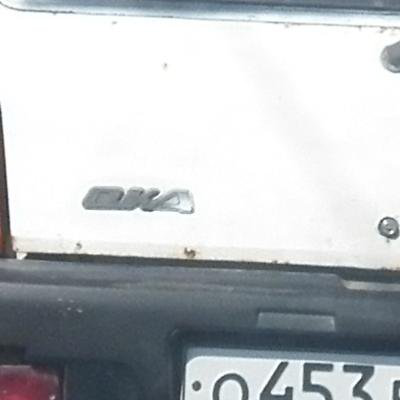

In [ ]:
area = [400, 400, 800, 800]
cropped_img = img.crop(area)
cropped_img

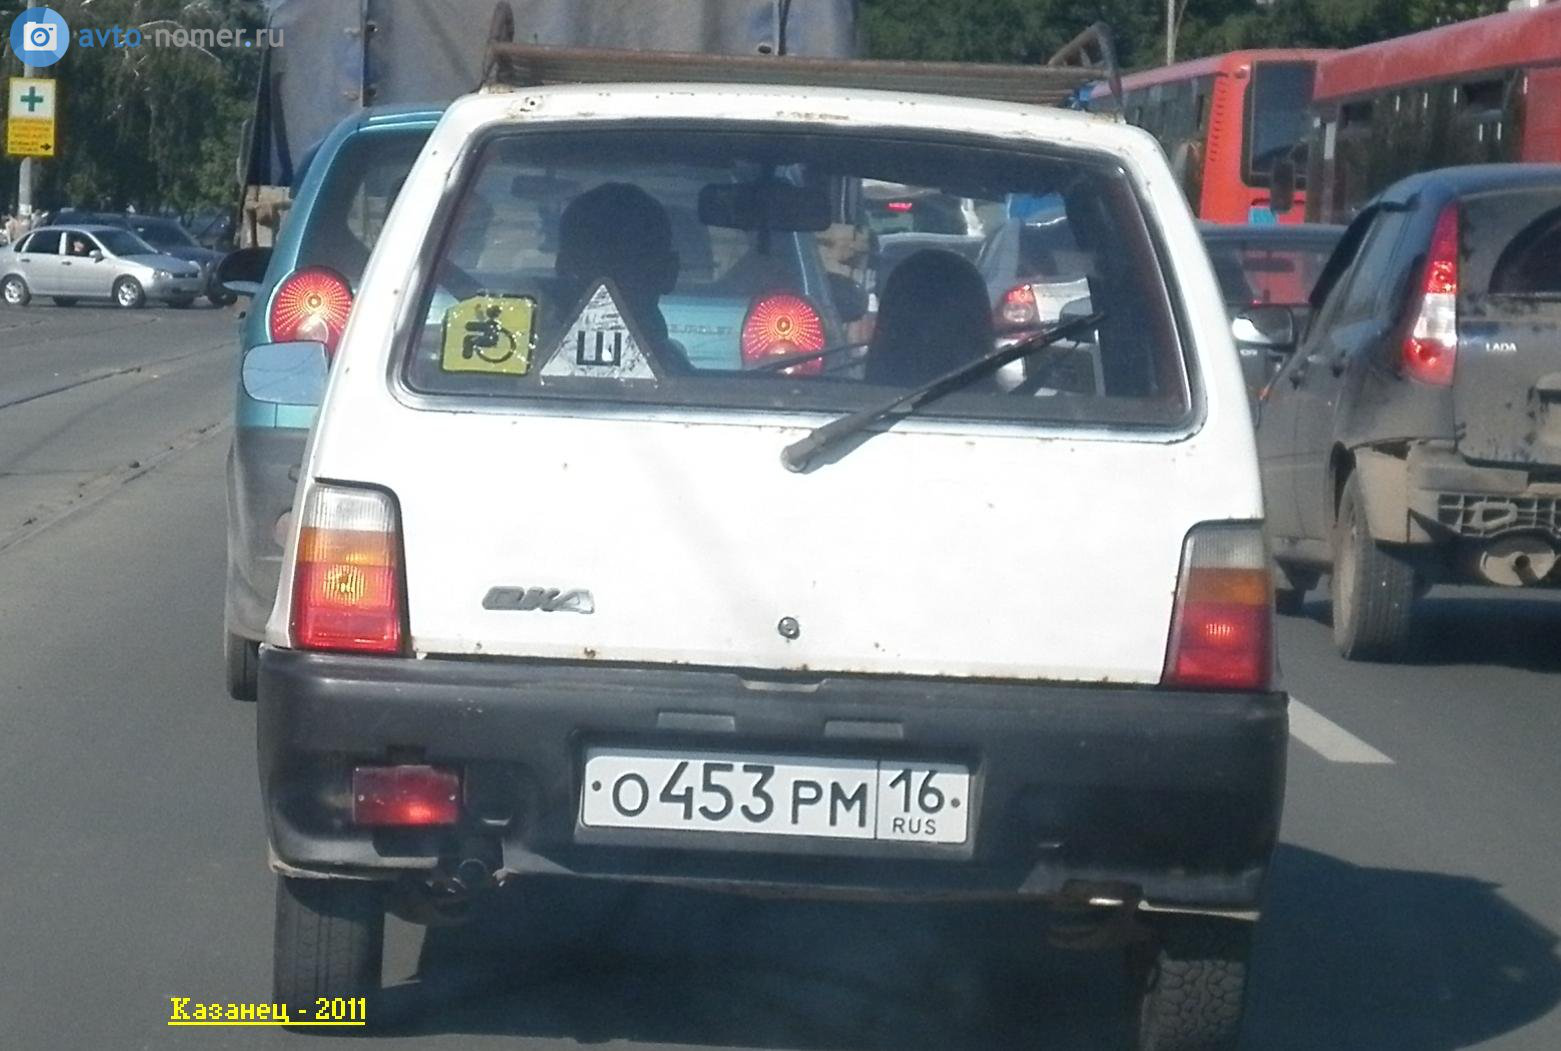

In [ ]:
img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# CSV - пока не нужен, сначала нужно нормализировать координаты

# Из json в датафрейм нужно достать нормализированные координаты

In [ ]:
names = pd.read_json(imgzip.open('data/train.json'))
names

,nums,file
0,"[{'box': [[180, 889], [596, 951], [598, 1056],...",train/0.jpg
1,"[{'box': [[794, 661], [1004, 618], [1009, 670]...",train/1.jpg
2,"[{'box': [[286, 603], [346, 606], [346, 621], ...",train/2.jpg
3,"[{'box': [[217, 486], [489, 487], [488, 580], ...",train/3.jpg
4,"[{'box': [[115, 184], [202, 168], [204, 189], ...",train/4.bmp
...,...,...
25628,"[{'box': [[209, 655], [443, 661], [439, 721], ...",train/25628.jpg
25629,"[{'box': [[205, 158], [287, 165], [288, 189], ...",train/25629.bmp
25630,"[{'box': [[621, 388], [796, 378], [801, 417], ...",train/25630.jpg
25631,"[{'box': [[379, 199], [448, 197], [450, 215], ...",train/25631.bmp


In [ ]:
def parse_coordinates(box):
    box = np.array(box)
    x_min, x_max = min(box[:, 0]), max(box[:, 0])
    y_min, y_max = min(box[:, 1]), max(box[:, 1])
    return ([x_min, y_min, x_max, y_max])

In [ ]:
names['bbox'] = names.nums.apply(lambda x: parse_coordinates(x[0]['box']))
names['plate'] = names.nums.apply(lambda x: x[0]['text'])
names['class'] = 'plate'
names

In [ ]:
names

,nums,file,bbox,class,plate
0,"[{'box': [[180, 889], [596, 951], [598, 1056],...",train/0.jpg,"[180, 889, 598, 1056]",plate,B060BB125
1,"[{'box': [[794, 661], [1004, 618], [1009, 670]...",train/1.jpg,"[794, 618, 1009, 717]",plate,M938OX116
2,"[{'box': [[286, 603], [346, 606], [346, 621], ...",train/2.jpg,"[285, 603, 346, 621]",plate,A549XA163
3,"[{'box': [[217, 486], [489, 487], [488, 580], ...",train/3.jpg,"[204, 486, 489, 580]",plate,O934MO190
4,"[{'box': [[115, 184], [202, 168], [204, 189], ...",train/4.bmp,"[115, 168, 204, 207]",plate,T647TO35
...,...,...,...,...,...
25628,"[{'box': [[209, 655], [443, 661], [439, 721], ...",train/25628.jpg,"[201, 655, 443, 721]",plate,T252TO150
25629,"[{'box': [[205, 158], [287, 165], [288, 189], ...",train/25629.bmp,"[205, 158, 288, 189]",plate,B240PB35
25630,"[{'box': [[621, 388], [796, 378], [801, 417], ...",train/25630.jpg,"[621, 378, 801, 431]",plate,K607AP199
25631,"[{'box': [[379, 199], [448, 197], [450, 215], ...",train/25631.bmp,"[379, 197, 450, 215]",plate,T454HK35


In [ ]:
df = pd.DataFrame({'path': [], 'plate' : []})
df

,path,plate


In [ ]:
df['path'] = names.file.apply(lambda x: 'file' + x[x.find('/'):])
df['plate'] = names.plate.copy()
df

,path,plate
0,file/0.jpg,B060BB125
1,file/1.jpg,M938OX116
2,file/2.jpg,A549XA163
3,file/3.jpg,O934MO190
4,file/4.bmp,T647TO35
...,...,...
25628,file/25628.jpg,T252TO150
25629,file/25629.bmp,B240PB35
25630,file/25630.jpg,K607AP199
25631,file/25631.bmp,T454HK35


In [ ]:
df.drop(df[df.index == 25632].index, inplace=True)

In [ ]:
names.drop('nums', axis=1, inplace=True)
names

,file,bbox,class
0,train/0.jpg,"[180, 889, 598, 1056]",plate
1,train/1.jpg,"[794, 618, 1009, 717]",plate
2,train/2.jpg,"[285, 603, 346, 621]",plate
3,train/3.jpg,"[204, 486, 489, 580]",plate
4,train/4.bmp,"[115, 168, 204, 207]",plate
...,...,...,...
25628,train/25628.jpg,"[201, 655, 443, 721]",plate
25629,train/25629.bmp,"[205, 158, 288, 189]",plate
25630,train/25630.jpg,"[621, 378, 801, 431]",plate
25631,train/25631.bmp,"[379, 197, 450, 215]",plate


In [ ]:
df

In [ ]:
def crop_the_plate(file, bbox):
  newpath = r'/content/drive/MyDrive/file' 
  if not os.path.exists(newpath):
    os.makedirs(newpath)
  ifile = imgzip.open('data/' + file)
  img = Image.open(ifile)
  cropped_img = img.crop(bbox).save(newpath + file[file.find('/'):])

/content/drive/MyDrive/plates/1.jpg


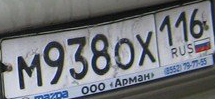

In [ ]:
crop_the_plate(names['file'][1], names['bbox'][1])

In [ ]:
from tqdm import tqdm 

In [ ]:
len(os.listdir("/content/drive/MyDrive/plates"))

25633

In [ ]:
for i in tqdm(names.index):
  print(i)
  crop_the_plate(names['file'][i], names['bbox'][i])

  9%|▊         | 2188/25633 [01:18<13:02, 29.94it/s]

2183
2184
2185
2186
2187
2188


  9%|▊         | 2192/25633 [01:18<13:31, 28.89it/s]

2189
2190
2191
2192
2193
2194
2195
2196


  9%|▊         | 2198/25633 [01:18<12:03, 32.37it/s]

2197
2198
2199
2200


  9%|▊         | 2207/25633 [01:19<12:26, 31.38it/s]

2201
2202
2203
2204
2205
2206
2207


  9%|▊         | 2211/25633 [01:19<13:44, 28.40it/s]

2208
2209
2210
2211
2212
2213
2214


  9%|▊         | 2220/25633 [01:19<12:06, 32.22it/s]

2215
2216
2217
2218
2219
2220
2221


  9%|▊         | 2224/25633 [01:19<14:40, 26.59it/s]

2222
2223
2224
2225


  9%|▊         | 2232/25633 [01:19<13:06, 29.76it/s]

2226
2227
2228
2229
2230
2231
2232


  9%|▊         | 2236/25633 [01:20<12:25, 31.40it/s]

2233
2234
2235
2236
2237
2238
2239
2240


  9%|▉         | 2244/25633 [01:20<14:46, 26.37it/s]

2241
2242
2243
2244
2245
2246


  9%|▉         | 2250/25633 [01:20<15:01, 25.93it/s]

2247
2248
2249
2250
2251


  9%|▉         | 2256/25633 [01:20<16:59, 22.94it/s]

2252
2253
2254
2255
2256


  9%|▉         | 2262/25633 [01:21<15:39, 24.88it/s]

2257
2258
2259
2260
2261
2262


  9%|▉         | 2265/25633 [01:21<15:47, 24.65it/s]

2263
2264
2265
2266
2267
2268


  9%|▉         | 2272/25633 [01:21<14:25, 27.00it/s]

2269
2270
2271
2272
2273
2274


  9%|▉         | 2278/25633 [01:21<15:31, 25.07it/s]

2275
2276
2277
2278
2279
2280


  9%|▉         | 2286/25633 [01:21<12:53, 30.19it/s]

2281
2282
2283
2284
2285
2286
2287
2288


  9%|▉         | 2296/25633 [01:22<10:46, 36.07it/s]

2289
2290
2291
2292
2293
2294
2295
2296
2297


  9%|▉         | 2304/25633 [01:22<11:39, 33.34it/s]

2298
2299
2300
2301
2302
2303
2304
2305


  9%|▉         | 2308/25633 [01:22<12:41, 30.63it/s]

2306
2307
2308
2309
2310
2311


  9%|▉         | 2315/25633 [01:22<13:49, 28.10it/s]

2312
2313
2314
2315
2316
2317
2318


  9%|▉         | 2323/25633 [01:23<13:18, 29.20it/s]

2319
2320
2321
2322
2323
2324
2325
2326


  9%|▉         | 2331/25633 [01:23<12:37, 30.76it/s]

2327
2328
2329
2330
2331
2332


  9%|▉         | 2338/25633 [01:23<14:43, 26.37it/s]

2333
2334
2335
2336
2337
2338


  9%|▉         | 2343/25633 [01:23<13:05, 29.65it/s]

2339
2340
2341
2342
2343
2344
2345


  9%|▉         | 2350/25633 [01:24<13:30, 28.73it/s]

2346
2347
2348
2349
2350
2351


  9%|▉         | 2357/25633 [01:24<12:22, 31.34it/s]

2352
2353
2354
2355
2356
2357
2358
2359


  9%|▉         | 2365/25633 [01:24<14:03, 27.58it/s]

2360
2361
2362
2363
2364
2365


  9%|▉         | 2371/25633 [01:24<14:49, 26.15it/s]

2366
2367
2368
2369
2370


  9%|▉         | 2374/25633 [01:25<15:10, 25.54it/s]

2371
2372
2373
2374
2375
2376


  9%|▉         | 2380/25633 [01:25<16:41, 23.21it/s]

2377
2378
2379
2380


  9%|▉         | 2384/25633 [01:25<15:30, 24.98it/s]

2381
2382
2383
2384
2385
2386


  9%|▉         | 2390/25633 [01:25<16:50, 23.00it/s]

2387
2388
2389
2390
2391
2392


  9%|▉         | 2398/25633 [01:26<14:54, 25.96it/s]

2393
2394
2395
2396
2397
2398


  9%|▉         | 2405/25633 [01:26<13:28, 28.72it/s]

2399
2400
2401
2402
2403
2404
2405


  9%|▉         | 2409/25633 [01:26<12:21, 31.33it/s]

2406
2407
2408
2409
2410
2411
2412
2413


  9%|▉         | 2418/25633 [01:26<11:41, 33.09it/s]

2414
2415
2416
2417
2418
2419
2420


  9%|▉         | 2426/25633 [01:26<11:39, 33.16it/s]

2421
2422
2423
2424
2425
2426


  9%|▉         | 2430/25633 [01:26<11:32, 33.53it/s]

2427
2428
2429
2430
2431
2432
2433
2434


 10%|▉         | 2439/25633 [01:27<13:08, 29.43it/s]

2435
2436
2437
2438
2439


 10%|▉         | 2447/25633 [01:27<12:39, 30.52it/s]

2440
2441
2442
2443
2444
2445
2446
2447


 10%|▉         | 2455/25633 [01:27<12:32, 30.79it/s]

2448
2449
2450
2451
2452
2453
2454
2455


 10%|▉         | 2463/25633 [01:28<11:17, 34.22it/s]

2456
2457
2458
2459
2460
2461
2462
2463


 10%|▉         | 2467/25633 [01:28<13:01, 29.65it/s]

2464
2465
2466
2467
2468
2469
2470


 10%|▉         | 2477/25633 [01:28<11:37, 33.22it/s]

2471
2472
2473
2474
2475
2476
2477


 10%|▉         | 2481/25633 [01:28<13:28, 28.63it/s]

2478
2479
2480
2481
2482
2483
2484


 10%|▉         | 2486/25633 [01:28<13:11, 29.25it/s]

2485
2486
2487
2488
2489
2490
2491


 10%|▉         | 2496/25633 [01:29<12:59, 29.70it/s]

2492
2493
2494
2495
2496


 10%|▉         | 2500/25633 [01:29<13:01, 29.61it/s]

2497
2498
2499
2500
2501
2502


 10%|▉         | 2504/25633 [01:29<14:03, 27.43it/s]

2503
2504
2505
2506


 10%|▉         | 2512/25633 [01:29<13:18, 28.97it/s]

2507
2508
2509
2510
2511
2512
2513
2514
2515


 10%|▉         | 2520/25633 [01:29<13:21, 28.82it/s]

2516
2517
2518
2519
2520
2521


 10%|▉         | 2524/25633 [01:30<13:20, 28.88it/s]

2522
2523
2524
2525
2526
2527
2528


 10%|▉         | 2535/25633 [01:30<11:49, 32.56it/s]

2529
2530
2531
2532
2533
2534
2535
2536
2537


 10%|▉         | 2545/25633 [01:30<10:45, 35.77it/s]

2538
2539
2540
2541
2542
2543
2544
2545


 10%|▉         | 2549/25633 [01:30<11:31, 33.39it/s]

2546
2547
2548
2549
2550
2551
2552


 10%|▉         | 2553/25633 [01:31<11:59, 32.07it/s]

2553
2554
2555


 10%|▉         | 2557/25633 [01:31<17:49, 21.57it/s]

2556
2557
2558
2559


 10%|▉         | 2563/25633 [01:31<16:40, 23.06it/s]

2560
2561
2562
2563
2564
2565


 10%|█         | 2570/25633 [01:31<15:11, 25.31it/s]

2566
2567
2568
2569
2570
2571
2572
2573
2574


 10%|█         | 2576/25633 [01:31<12:23, 31.00it/s]

2575
2576
2577
2578
2579


 10%|█         | 2583/25633 [01:32<14:08, 27.17it/s]

2580
2581
2582
2583
2584


 10%|█         | 2591/25633 [01:32<12:01, 31.96it/s]

2585
2586
2587
2588
2589
2590
2591
2592
2593
2594


 10%|█         | 2602/25633 [01:32<10:44, 35.73it/s]

2595
2596
2597
2598
2599
2600
2601


 10%|█         | 2606/25633 [01:32<13:05, 29.33it/s]

2602
2603
2604
2605
2606


 10%|█         | 2610/25633 [01:33<13:23, 28.65it/s]

2607
2608
2609
2610
2611


 10%|█         | 2614/25633 [01:33<13:58, 27.46it/s]

2612
2613
2614
2615
2616
2617


 10%|█         | 2622/25633 [01:33<13:12, 29.02it/s]

2618
2619
2620
2621
2622
2623
2624


 10%|█         | 2629/25633 [01:33<12:52, 29.78it/s]

2625
2626
2627
2628
2629
2630
2631


 10%|█         | 2636/25633 [01:34<14:10, 27.04it/s]

2632
2633
2634
2635
2636


 10%|█         | 2639/25633 [01:34<13:54, 27.54it/s]

2637
2638
2639
2640
2641


 10%|█         | 2645/25633 [01:34<16:40, 22.97it/s]

2642
2643
2644
2645
2646
2647


 10%|█         | 2651/25633 [01:34<15:36, 24.55it/s]

2648
2649
2650
2651
2652
2653


 10%|█         | 2657/25633 [01:34<15:33, 24.61it/s]

2654
2655
2656
2657
2658
2659


 10%|█         | 2663/25633 [01:35<15:50, 24.17it/s]

2660
2661
2662
2663
2664
2665


 10%|█         | 2669/25633 [01:35<14:57, 25.58it/s]

2666
2667
2668
2669
2670
2671


 10%|█         | 2675/25633 [01:35<14:40, 26.06it/s]

2672
2673
2674
2675
2676
2677
2678


 10%|█         | 2683/25633 [01:35<12:18, 31.08it/s]

2679
2680
2681
2682
2683
2684
2685
2686


 11%|█         | 2692/25633 [01:36<12:58, 29.46it/s]

2687
2688
2689
2690
2691
2692


 11%|█         | 2696/25633 [01:36<13:46, 27.75it/s]

2693
2694
2695
2696
2697


 11%|█         | 2702/25633 [01:36<16:25, 23.28it/s]

2698
2699
2700
2701
2702


 11%|█         | 2710/25633 [01:36<13:48, 27.68it/s]

2703
2704
2705
2706
2707
2708
2709
2710
2711


 11%|█         | 2718/25633 [01:37<12:32, 30.44it/s]

2712
2713
2714
2715
2716
2717
2718


 11%|█         | 2722/25633 [01:37<12:50, 29.73it/s]

2719
2720
2721
2722
2723
2724


 11%|█         | 2729/25633 [01:37<13:16, 28.74it/s]

2725
2726
2727
2728
2729
2730
2731


 11%|█         | 2736/25633 [01:37<14:17, 26.69it/s]

2732
2733
2734
2735
2736


 11%|█         | 2740/25633 [01:38<14:26, 26.42it/s]

2737
2738
2739
2740
2741
2742
2743
2744


 11%|█         | 2749/25633 [01:38<11:42, 32.57it/s]

2745
2746
2747
2748
2749
2750
2751
2752
2753


 11%|█         | 2758/25633 [01:38<11:31, 33.07it/s]

2754
2755
2756
2757
2758
2759
2760
2761


 11%|█         | 2767/25633 [01:38<11:11, 34.04it/s]

2762
2763
2764
2765
2766
2767
2768


 11%|█         | 2771/25633 [01:38<11:50, 32.19it/s]

2769
2770
2771
2772
2773


 11%|█         | 2779/25633 [01:39<14:58, 25.42it/s]

2774
2775
2776
2777
2778
2779


 11%|█         | 2782/25633 [01:39<15:25, 24.70it/s]

2780
2781
2782
2783
2784


 11%|█         | 2788/25633 [01:39<15:23, 24.75it/s]

2785
2786
2787
2788
2789
2790
2791
2792


 11%|█         | 2797/25633 [01:39<12:50, 29.63it/s]

2793
2794
2795
2796
2797
2798
2799


 11%|█         | 2806/25633 [01:40<10:48, 35.22it/s]

2800
2801
2802
2803
2804
2805
2806
2807


 11%|█         | 2810/25633 [01:40<10:53, 34.94it/s]

2808
2809
2810
2811
2812
2813
2814
2815


 11%|█         | 2820/25633 [01:40<11:17, 33.69it/s]

2816
2817
2818
2819
2820
2821


 11%|█         | 2824/25633 [01:40<13:05, 29.06it/s]

2822
2823
2824
2825
2826


 11%|█         | 2833/25633 [01:41<11:13, 33.87it/s]

2827
2828
2829
2830
2831
2832
2833
2834


 11%|█         | 2841/25633 [01:41<11:31, 32.96it/s]

2835
2836
2837
2838
2839
2840
2841


 11%|█         | 2845/25633 [01:41<12:01, 31.59it/s]

2842
2843
2844
2845
2846
2847
2848


 11%|█         | 2853/25633 [01:41<12:57, 29.30it/s]

2849
2850
2851
2852
2853
2854
2855


 11%|█         | 2860/25633 [01:41<12:55, 29.36it/s]

2856
2857
2858
2859
2860
2861
2862


 11%|█         | 2867/25633 [01:42<13:37, 27.84it/s]

2863
2864
2865
2866
2867
2868
2869
2870


 11%|█         | 2876/25633 [01:42<11:30, 32.94it/s]

2871
2872
2873
2874
2875
2876
2877
2878


 11%|█         | 2880/25633 [01:42<13:20, 28.42it/s]

2879
2880
2881
2882
2883
2884
2885
2886


 11%|█▏        | 2891/25633 [01:42<12:57, 29.25it/s]

2887
2888
2889
2890
2891
2892


 11%|█▏        | 2899/25633 [01:43<12:09, 31.14it/s]

2893
2894
2895
2896
2897
2898
2899


 11%|█▏        | 2903/25633 [01:43<12:37, 30.02it/s]

2900
2901
2902
2903
2904
2905


 11%|█▏        | 2911/25633 [01:43<12:01, 31.50it/s]

2906
2907
2908
2909
2910
2911
2912
2913


 11%|█▏        | 2915/25633 [01:43<12:06, 31.29it/s]

2914
2915
2916
2917
2918


 11%|█▏        | 2923/25633 [01:44<12:37, 30.00it/s]

2919
2920
2921
2922
2923
2924
2925
2926


 11%|█▏        | 2931/25633 [01:44<11:34, 32.67it/s]

2927
2928
2929
2930
2931
2932
2933
2934


 11%|█▏        | 2939/25633 [01:44<13:02, 28.99it/s]

2935
2936
2937
2938
2939
2940


 11%|█▏        | 2942/25633 [01:44<14:20, 26.37it/s]

2941
2942
2943
2944
2945


 12%|█▏        | 2949/25633 [01:44<13:55, 27.15it/s]

2946
2947
2948
2949
2950


 12%|█▏        | 2956/25633 [01:45<12:53, 29.34it/s]

2951
2952
2953
2954
2955
2956
2957


 12%|█▏        | 2962/25633 [01:45<14:09, 26.68it/s]

2958
2959
2960
2961
2962
2963


 12%|█▏        | 2970/25633 [01:45<13:02, 28.97it/s]

2964
2965
2966
2967
2968
2969
2970


 12%|█▏        | 2975/25633 [01:45<11:50, 31.88it/s]

2971
2972
2973
2974
2975
2976
2977
2978


 12%|█▏        | 2983/25633 [01:46<13:34, 27.82it/s]

2979
2980
2981
2982
2983
2984


 12%|█▏        | 2988/25633 [01:46<12:00, 31.45it/s]

2985
2986
2987
2988
2989
2990
2991


 12%|█▏        | 2998/25633 [01:46<11:15, 33.53it/s]

2992
2993
2994
2995
2996
2997
2998


 12%|█▏        | 3002/25633 [01:46<13:19, 28.32it/s]

2999
3000
3001
3002
3003
3004


 12%|█▏        | 3009/25633 [01:47<12:47, 29.46it/s]

3005
3006
3007
3008
3009
3010
3011


 12%|█▏        | 3016/25633 [01:47<13:22, 28.19it/s]

3012
3013
3014
3015
3016
3017
3018


 12%|█▏        | 3025/25633 [01:47<12:02, 31.31it/s]

3019
3020
3021
3022
3023
3024
3025


 12%|█▏        | 3029/25633 [01:47<11:52, 31.72it/s]

3026
3027
3028
3029
3030
3031
3032


 12%|█▏        | 3037/25633 [01:47<11:25, 32.94it/s]

3033
3034
3035
3036
3037
3038
3039
3040


 12%|█▏        | 3045/25633 [01:48<11:41, 32.19it/s]

3041
3042
3043
3044
3045
3046
3047


 12%|█▏        | 3053/25633 [01:48<11:23, 33.05it/s]

3048
3049
3050
3051
3052
3053
3054


 12%|█▏        | 3061/25633 [01:48<12:04, 31.16it/s]

3055
3056
3057
3058
3059
3060
3061
3062
3063


 12%|█▏        | 3068/25633 [01:48<14:56, 25.17it/s]

3064
3065
3066
3067
3068
3069
3070


 12%|█▏        | 3076/25633 [01:49<12:22, 30.36it/s]

3071
3072
3073
3074
3075
3076
3077


 12%|█▏        | 3084/25633 [01:49<12:35, 29.84it/s]

3078
3079
3080
3081
3082
3083
3084


 12%|█▏        | 3088/25633 [01:49<14:55, 25.17it/s]

3085
3086
3087
3088


 12%|█▏        | 3094/25633 [01:49<14:42, 25.53it/s]

3089
3090
3091
3092
3093
3094


 12%|█▏        | 3097/25633 [01:50<16:11, 23.19it/s]

3095
3096
3097
3098


 12%|█▏        | 3103/25633 [01:50<15:30, 24.23it/s]

3099
3100
3101
3102
3103
3104
3105


 12%|█▏        | 3110/25633 [01:50<13:49, 27.16it/s]

3106
3107
3108
3109
3110
3111
3112


 12%|█▏        | 3119/25633 [01:50<11:27, 32.77it/s]

3113
3114
3115
3116
3117
3118
3119


 12%|█▏        | 3123/25633 [01:50<13:14, 28.34it/s]

3120
3121
3122
3123
3124
3125
3126


 12%|█▏        | 3131/25633 [01:51<12:42, 29.50it/s]

3127
3128
3129
3130
3131
3132


 12%|█▏        | 3135/25633 [01:51<15:32, 24.12it/s]

3133
3134
3135
3136
3137


 12%|█▏        | 3141/25633 [01:51<15:03, 24.90it/s]

3138
3139
3140
3141
3142


 12%|█▏        | 3147/25633 [01:51<16:25, 22.82it/s]

3143
3144
3145
3146
3147
3148


 12%|█▏        | 3154/25633 [01:52<14:23, 26.04it/s]

3149
3150
3151
3152
3153
3154
3155
3156
3157
3158


 12%|█▏        | 3164/25633 [01:52<11:59, 31.21it/s]

3159
3160
3161
3162
3163
3164
3165
3166
3167


 12%|█▏        | 3172/25633 [01:52<12:00, 31.18it/s]

3168
3169
3170
3171
3172
3173


 12%|█▏        | 3180/25633 [01:53<12:25, 30.10it/s]

3174
3175
3176
3177
3178
3179
3180


 12%|█▏        | 3184/25633 [01:53<14:02, 26.66it/s]

3181
3182
3183
3184
3185


 12%|█▏        | 3191/25633 [01:53<13:38, 27.42it/s]

3186
3187
3188
3189
3190
3191


 12%|█▏        | 3198/25633 [01:53<12:58, 28.83it/s]

3192
3193
3194
3195
3196
3197
3198


 12%|█▏        | 3204/25633 [01:53<14:32, 25.69it/s]

3199
3200
3201
3202
3203
3204


 13%|█▎        | 3207/25633 [01:54<15:09, 24.66it/s]

3205
3206
3207
3208
3209
3210
3211


 13%|█▎        | 3216/25633 [01:54<12:40, 29.49it/s]

3212
3213
3214
3215
3216
3217
3218


 13%|█▎        | 3222/25633 [01:54<13:14, 28.22it/s]

3219
3220
3221
3222
3223
3224


 13%|█▎        | 3230/25633 [01:54<12:06, 30.85it/s]

3225
3226
3227
3228
3229
3230
3231
3232
3233


 13%|█▎        | 3239/25633 [01:55<10:33, 35.35it/s]

3234
3235
3236
3237
3238
3239
3240
3241


 13%|█▎        | 3248/25633 [01:55<09:53, 37.72it/s]

3242
3243
3244
3245
3246
3247
3248
3249
3250


 13%|█▎        | 3257/25633 [01:55<10:20, 36.05it/s]

3251
3252
3253
3254
3255
3256
3257


 13%|█▎        | 3261/25633 [01:55<11:57, 31.19it/s]

3258
3259
3260
3261
3262
3263
3264


 13%|█▎        | 3265/25633 [01:55<13:17, 28.03it/s]

3265
3266
3267
3268


 13%|█▎        | 3273/25633 [01:56<13:24, 27.78it/s]

3269
3270
3271
3272
3273
3274


 13%|█▎        | 3280/25633 [01:56<13:07, 28.39it/s]

3275
3276
3277
3278
3279
3280


 13%|█▎        | 3284/25633 [01:56<13:18, 27.99it/s]

3281
3282
3283
3284
3285
3286
3287


 13%|█▎        | 3288/25633 [01:56<12:04, 30.82it/s]

3288
3289
3290
3291


 13%|█▎        | 3295/25633 [01:57<14:11, 26.22it/s]

3292
3293
3294
3295
3296
3297


 13%|█▎        | 3302/25633 [01:57<13:23, 27.78it/s]

3298
3299
3300
3301
3302
3303
3304


 13%|█▎        | 3310/25633 [01:57<11:58, 31.06it/s]

3305
3306
3307
3308
3309
3310
3311
3312


 13%|█▎        | 3318/25633 [01:57<12:38, 29.41it/s]

3313
3314
3315
3316
3317
3318


 13%|█▎        | 3322/25633 [01:57<12:59, 28.63it/s]

3319
3320
3321
3322
3323
3324
3325
3326


 13%|█▎        | 3331/25633 [01:58<13:27, 27.61it/s]

3327
3328
3329
3330
3331


 13%|█▎        | 3337/25633 [01:58<13:54, 26.73it/s]

3332
3333
3334
3335
3336
3337


 13%|█▎        | 3342/25633 [01:58<12:20, 30.10it/s]

3338
3339
3340
3341
3342
3343
3344
3345


 13%|█▎        | 3350/25633 [01:58<13:13, 28.07it/s]

3346
3347
3348
3349
3350
3351

 13%|█▎        | 3357/25633 [01:59<12:46, 29.06it/s]


3352
3353
3354
3355
3356
3357


 13%|█▎        | 3361/25633 [01:59<12:17, 30.19it/s]

3358
3359
3360
3361
3362
3363
3364


 13%|█▎        | 3370/25633 [01:59<10:41, 34.68it/s]

3365
3366
3367
3368
3369
3370
3371


 13%|█▎        | 3378/25633 [01:59<11:16, 32.89it/s]

3372
3373
3374
3375
3376
3377
3378
3379


 13%|█▎        | 3382/25633 [01:59<10:58, 33.78it/s]

3380
3381
3382
3383
3384
3385


 13%|█▎        | 3391/25633 [02:00<11:45, 31.51it/s]

3386
3387
3388
3389
3390
3391


 13%|█▎        | 3395/25633 [02:00<13:35, 27.26it/s]

3392
3393
3394
3395
3396
3397
3398


 13%|█▎        | 3402/25633 [02:00<13:00, 28.49it/s]

3399
3400
3401
3402
3403


 13%|█▎        | 3409/25633 [02:01<15:31, 23.85it/s]

3404
3405
3406
3407
3408
3409
3410


 13%|█▎        | 3416/25633 [02:01<13:52, 26.68it/s]

3411
3412
3413
3414
3415
3416


 13%|█▎        | 3422/25633 [02:01<14:26, 25.63it/s]

3417
3418
3419
3420
3421
3422


 13%|█▎        | 3425/25633 [02:01<14:40, 25.21it/s]

3423
3424
3425
3426
3427


 13%|█▎        | 3431/25633 [02:01<15:26, 23.95it/s]

3428
3429
3430
3431
3432


 13%|█▎        | 3437/25633 [02:02<15:01, 24.63it/s]

3433
3434
3435
3436
3437


 13%|█▎        | 3440/25633 [02:02<18:04, 20.46it/s]

3438
3439
3440
3441
3442
3443


 13%|█▎        | 3447/25633 [02:02<15:10, 24.36it/s]

3444
3445
3446
3447
3448
3449
3450
3451


 13%|█▎        | 3457/25633 [02:02<11:27, 32.25it/s]

3452
3453
3454
3455
3456
3457
3458
3459


 14%|█▎        | 3465/25633 [02:03<12:51, 28.73it/s]

3460
3461
3462
3463
3464
3465


 14%|█▎        | 3471/25633 [02:03<13:41, 26.98it/s]

3466
3467
3468
3469
3470
3471
3472


 14%|█▎        | 3476/25633 [02:03<11:47, 31.31it/s]

3473
3474
3475
3476
3477
3478
3479


 14%|█▎        | 3485/25633 [02:03<11:18, 32.65it/s]

3480
3481
3482
3483
3484
3485
3486


 14%|█▎        | 3492/25633 [02:04<13:20, 27.65it/s]

3487
3488
3489
3490
3491
3492


 14%|█▎        | 3496/25633 [02:04<13:00, 28.35it/s]

3493
3494
3495
3496
3497
3498


 14%|█▎        | 3503/25633 [02:04<13:39, 27.00it/s]

3499
3500
3501
3502
3503
3504


 14%|█▎        | 3509/25633 [02:04<14:12, 25.94it/s]

3505
3506
3507
3508
3509
3510
3511


 14%|█▎        | 3517/25633 [02:04<12:26, 29.64it/s]

3512
3513
3514
3515
3516
3517


 14%|█▍        | 3525/25633 [02:05<12:07, 30.40it/s]

3518
3519
3520
3521
3522
3523
3524
3525


 14%|█▍        | 3529/25633 [02:05<14:37, 25.18it/s]

3526
3527
3528
3529


 14%|█▍        | 3532/25633 [02:05<15:19, 24.04it/s]

3530
3531
3532
3533
3534
3535


 14%|█▍        | 3541/25633 [02:05<12:38, 29.12it/s]

3536
3537
3538
3539
3540
3541
3542


 14%|█▍        | 3549/25633 [02:06<12:24, 29.66it/s]

3543
3544
3545
3546
3547
3548
3549
3550


 14%|█▍        | 3557/25633 [02:06<11:35, 31.75it/s]

3551
3552
3553
3554
3555
3556
3557
3558


 14%|█▍        | 3561/25633 [02:06<13:15, 27.75it/s]

3559
3560
3561
3562
3563
3564


 14%|█▍        | 3568/25633 [02:06<15:01, 24.46it/s]

3565
3566
3567
3568
3569


 14%|█▍        | 3575/25633 [02:07<13:39, 26.90it/s]

3570
3571
3572
3573
3574
3575


 14%|█▍        | 3579/25633 [02:07<13:21, 27.51it/s]

3576
3577
3578
3579
3580
3581


 14%|█▍        | 3585/25633 [02:07<13:49, 26.58it/s]

3582
3583
3584
3585
3586
3587


 14%|█▍        | 3593/25633 [02:07<13:15, 27.70it/s]

3588
3589
3590
3591
3592
3593
3594
3595
3596


 14%|█▍        | 3601/25633 [02:08<13:30, 27.18it/s]

3597
3598
3599
3600
3601
3602
3603


 14%|█▍        | 3609/25633 [02:08<12:53, 28.47it/s]

3604
3605
3606
3607
3608


 14%|█▍        | 3612/25633 [02:08<12:57, 28.34it/s]

3609
3610
3611
3612
3613
3614
3615
3616


 14%|█▍        | 3621/25633 [02:08<11:34, 31.68it/s]

3617
3618
3619
3620
3621


 14%|█▍        | 3625/25633 [02:08<13:12, 27.78it/s]

3622
3623
3624
3625
3626


 14%|█▍        | 3631/25633 [02:09<15:24, 23.80it/s]

3627
3628
3629
3630
3631


 14%|█▍        | 3638/25633 [02:09<13:36, 26.95it/s]

3632
3633
3634
3635
3636
3637
3638


 14%|█▍        | 3641/25633 [02:09<16:35, 22.09it/s]

3639
3640
3641


 14%|█▍        | 3647/25633 [02:09<18:25, 19.90it/s]

3642
3643
3644
3645
3646
3647


 14%|█▍        | 3654/25633 [02:10<15:35, 23.50it/s]

3648
3649
3650
3651
3652
3653
3654


 14%|█▍        | 3658/25633 [02:10<14:13, 25.74it/s]

3655
3656
3657
3658
3659
3660
3661
3662


 14%|█▍        | 3667/25633 [02:10<11:59, 30.53it/s]

3663
3664
3665
3666
3667
3668
3669


 14%|█▍        | 3675/25633 [02:10<12:18, 29.75it/s]

3670
3671
3672
3673
3674
3675
3676


 14%|█▍        | 3679/25633 [02:10<11:21, 32.22it/s]

3677
3678
3679
3680
3681
3682


 14%|█▍        | 3687/25633 [02:11<13:05, 27.95it/s]

3683
3684
3685
3686
3687
3688
3689


 14%|█▍        | 3691/25633 [02:11<14:37, 25.00it/s]

3690
3691
3692
3693


 14%|█▍        | 3697/25633 [02:11<14:38, 24.98it/s]

3694
3695
3696
3697
3698
3699
3700


 14%|█▍        | 3701/25633 [02:11<14:40, 24.91it/s]

3701
3702


 14%|█▍        | 3707/25633 [02:12<17:17, 21.13it/s]

3703
3704
3705
3706
3707
3708
3709


 14%|█▍        | 3711/25633 [02:12<15:06, 24.19it/s]

3710
3711
3712
3713
3714


 15%|█▍        | 3719/25633 [02:12<13:25, 27.19it/s]

3715
3716
3717
3718
3719
3720
3721


 15%|█▍        | 3725/25633 [02:12<14:37, 24.96it/s]

3722
3723
3724
3725


 15%|█▍        | 3733/25633 [02:13<13:17, 27.46it/s]

3726
3727
3728
3729
3730
3731
3732
3733
3734
3735


 15%|█▍        | 3738/25633 [02:13<12:22, 29.47it/s]

3736
3737
3738
3739
3740


 15%|█▍        | 3741/25633 [02:13<12:53, 28.31it/s]

3741
3742
3743


 15%|█▍        | 3748/25633 [02:13<15:48, 23.08it/s]

3744
3745
3746
3747
3748


 15%|█▍        | 3755/25633 [02:14<13:37, 26.77it/s]

3749
3750
3751
3752
3753
3754
3755


 15%|█▍        | 3758/25633 [02:14<14:55, 24.43it/s]

3756
3757
3758
3759
3760
3761


 15%|█▍        | 3766/25633 [02:14<13:53, 26.24it/s]

3762
3763
3764
3765
3766


 15%|█▍        | 3774/25633 [02:14<12:48, 28.44it/s]

3767
3768
3769
3770
3771
3772
3773
3774


 15%|█▍        | 3780/25633 [02:14<13:07, 27.74it/s]

3775
3776
3777
3778
3779
3780


 15%|█▍        | 3783/25633 [02:15<16:03, 22.68it/s]

3781
3782
3783
3784
3785


 15%|█▍        | 3789/25633 [02:15<15:57, 22.81it/s]

3786
3787
3788
3789
3790
3791
3792


 15%|█▍        | 3799/25633 [02:15<11:05, 32.83it/s]

3793
3794
3795
3796
3797
3798
3799
3800


 15%|█▍        | 3807/25633 [02:15<10:54, 33.33it/s]

3801
3802
3803
3804
3805
3806
3807


 15%|█▍        | 3811/25633 [02:16<11:36, 31.31it/s]

3808
3809
3810
3811
3812
3813
3814


 15%|█▍        | 3819/25633 [02:16<12:07, 29.99it/s]

3815
3816
3817
3818
3819
3820
3821
3822
3823


 15%|█▍        | 3828/25633 [02:16<12:26, 29.21it/s]

3824
3825
3826
3827
3828


 15%|█▍        | 3835/25633 [02:16<14:13, 25.55it/s]

3829
3830
3831
3832
3833
3834
3835


 15%|█▍        | 3838/25633 [02:17<14:56, 24.32it/s]

3836
3837
3838
3839
3840


 15%|█▍        | 3844/25633 [02:17<14:43, 24.65it/s]

3841
3842
3843
3844
3845
3846
3847


 15%|█▌        | 3851/25633 [02:17<14:12, 25.55it/s]

3848
3849
3850
3851
3852
3853


 15%|█▌        | 3858/25633 [02:17<12:48, 28.32it/s]

3854
3855
3856
3857
3858
3859
3860


 15%|█▌        | 3864/25633 [02:18<12:57, 28.00it/s]

3861
3862
3863
3864
3865
3866


 15%|█▌        | 3872/25633 [02:18<12:11, 29.76it/s]

3867
3868
3869
3870
3871
3872
3873
3874
3875


 15%|█▌        | 3880/25633 [02:18<10:56, 33.13it/s]

3876
3877
3878
3879
3880
3881
3882
3883


 15%|█▌        | 3888/25633 [02:18<12:26, 29.14it/s]

3884
3885
3886
3887
3888
3889
3890

 15%|█▌        | 3894/25633 [02:19<13:02, 27.79it/s]


3891
3892
3893
3894
3895

 15%|█▌        | 3902/25633 [02:19<11:07, 32.58it/s]


3896
3897
3898
3899
3900
3901
3902


 15%|█▌        | 3906/25633 [02:19<11:16, 32.13it/s]

3903
3904
3905
3906
3907
3908


 15%|█▌        | 3913/25633 [02:19<13:37, 26.56it/s]

3909
3910
3911
3912
3913
3914
3915


 15%|█▌        | 3921/25633 [02:19<12:05, 29.95it/s]

3916
3917
3918
3919
3920
3921


 15%|█▌        | 3925/25633 [02:20<12:23, 29.21it/s]

3922
3923
3924
3925
3926
3927


 15%|█▌        | 3931/25633 [02:20<14:25, 25.08it/s]

3928
3929
3930
3931
3932


 15%|█▌        | 3934/25633 [02:20<17:36, 20.53it/s]

3933
3934
3935


 15%|█▌        | 3940/25633 [02:20<18:37, 19.42it/s]

3936
3937
3938
3939
3940
3941


 15%|█▌        | 3947/25633 [02:21<15:14, 23.73it/s]

3942
3943
3944
3945
3946
3947


 15%|█▌        | 3951/25633 [02:21<14:47, 24.43it/s]

3948
3949
3950
3951
3952
3953


 15%|█▌        | 3958/25633 [02:21<14:11, 25.47it/s]

3954
3955
3956
3957
3958


 15%|█▌        | 3961/25633 [02:21<16:47, 21.51it/s]

3959
3960
3961
3962
3963


 15%|█▌        | 3967/25633 [02:22<16:45, 21.56it/s]

3964
3965
3966
3967
3968


 16%|█▌        | 3974/25633 [02:22<13:52, 26.02it/s]

3969
3970
3971
3972
3973
3974
3975
3976


 16%|█▌        | 3982/25633 [02:22<12:36, 28.62it/s]

3977
3978
3979
3980
3981
3982


 16%|█▌        | 3985/25633 [02:22<12:58, 27.80it/s]

3983
3984
3985
3986
3987


 16%|█▌        | 3993/25633 [02:22<12:34, 28.69it/s]

3988
3989
3990
3991
3992
3993
3994


 16%|█▌        | 3999/25633 [02:23<12:32, 28.73it/s]

3995
3996
3997
3998
3999
4000
4001


 16%|█▌        | 4005/25633 [02:23<14:42, 24.50it/s]

4002
4003
4004
4005
4006
4007


 16%|█▌        | 4011/25633 [02:23<13:43, 26.24it/s]

4008
4009
4010
4011
4012
4013
4014


 16%|█▌        | 4020/25633 [02:23<11:28, 31.41it/s]

4015
4016
4017
4018
4019
4020
4021
4022


 16%|█▌        | 4024/25633 [02:24<11:48, 30.48it/s]

4023
4024
4025
4026
4027

 16%|█▌        | 4032/25633 [02:24<12:54, 27.88it/s]


4028
4029
4030
4031
4032


 16%|█▌        | 4039/25633 [02:24<12:53, 27.93it/s]

4033
4034
4035
4036
4037
4038
4039


 16%|█▌        | 4042/25633 [02:24<13:49, 26.03it/s]

4040
4041
4042
4043
4044


 16%|█▌        | 4049/25633 [02:25<13:59, 25.72it/s]

4045
4046
4047
4048
4049


 16%|█▌        | 4055/25633 [02:25<13:34, 26.49it/s]

4050
4051
4052
4053
4054
4055


 16%|█▌        | 4059/25633 [02:25<13:08, 27.35it/s]

4056
4057
4058
4059
4060


 16%|█▌        | 4065/25633 [02:25<14:30, 24.76it/s]

4061
4062
4063
4064
4065
4066
4067


 16%|█▌        | 4072/25633 [02:25<13:20, 26.93it/s]

4068
4069
4070
4071
4072


 16%|█▌        | 4075/25633 [02:26<14:29, 24.80it/s]

4073
4074
4075
4076
4077
4078
4079


 16%|█▌        | 4084/25633 [02:26<12:01, 29.87it/s]

4080
4081
4082
4083
4084
4085


 16%|█▌        | 4092/25633 [02:26<12:53, 27.86it/s]

4086
4087
4088
4089
4090
4091
4092


 16%|█▌        | 4098/25633 [02:26<14:26, 24.87it/s]

4093
4094
4095
4096
4097
4098


 16%|█▌        | 4104/25633 [02:27<13:31, 26.53it/s]

4099
4100
4101
4102
4103
4104


 16%|█▌        | 4107/25633 [02:27<15:36, 22.98it/s]

4105
4106
4107
4108


 16%|█▌        | 4110/25633 [02:27<16:05, 22.28it/s]

4109
4110
4111
4112


 16%|█▌        | 4118/25633 [02:27<13:40, 26.22it/s]

4113
4114
4115
4116
4117
4118
4119
4120
4121


 16%|█▌        | 4125/25633 [02:28<14:15, 25.14it/s]

4122
4123
4124
4125
4126
4127


 16%|█▌        | 4134/25633 [02:28<12:06, 29.58it/s]

4128
4129
4130
4131
4132
4133
4134


 16%|█▌        | 4138/25633 [02:28<13:32, 26.47it/s]

4135
4136
4137
4138
4139
4140
4141


 16%|█▌        | 4146/25633 [02:28<11:48, 30.33it/s]

4142
4143
4144
4145
4146
4147
4148


 16%|█▌        | 4154/25633 [02:28<11:51, 30.20it/s]

4149
4150
4151
4152
4153
4154


 16%|█▌        | 4158/25633 [02:29<11:09, 32.08it/s]

4155
4156
4157
4158
4159
4160
4161


 16%|█▋        | 4167/25633 [02:29<10:28, 34.17it/s]

4162
4163
4164
4165
4166
4167
4168
4169
4170


 16%|█▋        | 4176/25633 [02:29<10:16, 34.81it/s]

4171
4172
4173
4174
4175
4176
4177
4178


 16%|█▋        | 4180/25633 [02:29<11:09, 32.05it/s]

4179
4180
4181
4182
4183


 16%|█▋        | 4188/25633 [02:30<13:41, 26.10it/s]

4184
4185
4186
4187
4188


 16%|█▋        | 4191/25633 [02:30<16:29, 21.66it/s]

4189
4190
4191
4192
4193


 16%|█▋        | 4198/25633 [02:30<14:45, 24.22it/s]

4194
4195
4196
4197
4198
4199


 16%|█▋        | 4204/25633 [02:30<14:15, 25.04it/s]

4200
4201
4202
4203
4204
4205


 16%|█▋        | 4209/25633 [02:30<11:28, 31.12it/s]

4206
4207
4208
4209
4210
4211
4212


 16%|█▋        | 4216/25633 [02:31<14:19, 24.91it/s]

4213
4214
4215
4216
4217
4218


 16%|█▋        | 4223/25633 [02:31<12:29, 28.57it/s]

4219
4220
4221
4222
4223
4224
4225
4226


 17%|█▋        | 4231/25633 [02:31<11:43, 30.40it/s]

4227
4228
4229
4230
4231
4232
4233


 17%|█▋        | 4235/25633 [02:31<13:29, 26.42it/s]

4234
4235
4236
4237
4238


 17%|█▋        | 4243/25633 [02:32<12:22, 28.80it/s]

4239
4240
4241
4242
4243
4244
4245


 17%|█▋        | 4250/25633 [02:32<14:00, 25.44it/s]

4246
4247
4248
4249
4250


 17%|█▋        | 4258/25633 [02:32<13:02, 27.31it/s]

4251
4252
4253
4254
4255
4256
4257
4258


 17%|█▋        | 4261/25633 [02:32<13:09, 27.07it/s]

4259
4260
4261
4262
4263


 17%|█▋        | 4267/25633 [02:33<13:57, 25.50it/s]

4264
4265
4266
4267
4268


 17%|█▋        | 4274/25633 [02:33<13:41, 26.00it/s]

4269
4270
4271
4272
4273
4274


 17%|█▋        | 4280/25633 [02:33<13:57, 25.51it/s]

4275
4276
4277
4278
4279
4280


 17%|█▋        | 4288/25633 [02:33<11:33, 30.79it/s]

4281
4282
4283
4284
4285
4286
4287
4288


 17%|█▋        | 4296/25633 [02:34<10:14, 34.73it/s]

4289
4290
4291
4292
4293
4294
4295
4296


 17%|█▋        | 4300/25633 [02:34<09:58, 35.63it/s]

4297
4298
4299
4300
4301
4302
4303


 17%|█▋        | 4308/25633 [02:34<13:03, 27.23it/s]

4304
4305
4306
4307
4308


 17%|█▋        | 4311/25633 [02:34<13:51, 25.64it/s]

4309
4310
4311
4312
4313

 17%|█▋        | 4318/25633 [02:34<13:21, 26.59it/s]


4314
4315
4316
4317
4318


 17%|█▋        | 4325/25633 [02:35<12:37, 28.14it/s]

4319
4320
4321
4322
4323
4324
4325
4326


 17%|█▋        | 4328/25633 [02:35<12:55, 27.49it/s]

4327
4328
4329
4330
4331


 17%|█▋        | 4336/25633 [02:35<13:09, 26.98it/s]

4332
4333
4334
4335
4336
4337


 17%|█▋        | 4342/25633 [02:35<13:02, 27.20it/s]

4338
4339
4340
4341
4342


 17%|█▋        | 4348/25633 [02:36<12:46, 27.79it/s]

4343
4344
4345
4346
4347
4348
4349


 17%|█▋        | 4351/25633 [02:36<12:53, 27.53it/s]

4350
4351
4352
4353


 17%|█▋        | 4358/25633 [02:36<14:11, 24.99it/s]

4354
4355
4356
4357
4358
4359
4360


 17%|█▋        | 4365/25633 [02:36<12:23, 28.61it/s]

4361
4362
4363
4364
4365
4366


 17%|█▋        | 4369/25633 [02:36<14:35, 24.28it/s]

4367
4368
4369
4370
4371
4372
4373


 17%|█▋        | 4377/25633 [02:37<13:03, 27.12it/s]

4374
4375
4376
4377
4378
4379
4380


 17%|█▋        | 4385/25633 [02:37<11:26, 30.96it/s]

4381
4382
4383
4384
4385
4386
4387
4388


 17%|█▋        | 4393/25633 [02:37<10:31, 33.65it/s]

4389
4390
4391
4392
4393
4394
4395


 17%|█▋        | 4401/25633 [02:37<12:17, 28.77it/s]

4396
4397
4398
4399
4400
4401


 17%|█▋        | 4405/25633 [02:38<12:30, 28.30it/s]

4402
4403
4404
4405
4406
4407
4408


 17%|█▋        | 4413/25633 [02:38<12:25, 28.45it/s]

4409
4410
4411
4412
4413
4414


 17%|█▋        | 4422/25633 [02:38<11:18, 31.27it/s]

4415
4416
4417
4418
4419
4420
4421
4422


 17%|█▋        | 4426/25633 [02:38<12:51, 27.48it/s]

4423
4424
4425
4426
4427


 17%|█▋        | 4434/25633 [02:39<11:03, 31.95it/s]

4428
4429
4430
4431
4432
4433
4434
4435


 17%|█▋        | 4442/25633 [02:39<11:09, 31.67it/s]

4436
4437
4438
4439
4440
4441
4442


 17%|█▋        | 4446/25633 [02:39<11:31, 30.63it/s]

4443
4444
4445
4446
4447
4448
4449


 17%|█▋        | 4453/25633 [02:39<12:21, 28.55it/s]

4450
4451
4452
4453
4454
4455
4456


 17%|█▋        | 4457/25633 [02:39<11:28, 30.74it/s]

4457
4458
4459
4460


 17%|█▋        | 4464/25633 [02:40<14:33, 24.24it/s]

4461
4462
4463
4464
4465


 17%|█▋        | 4470/25633 [02:40<14:46, 23.87it/s]

4466
4467
4468
4469
4470
4471


 17%|█▋        | 4477/25633 [02:40<14:29, 24.34it/s]

4472
4473
4474
4475
4476
4477


 17%|█▋        | 4484/25633 [02:40<12:32, 28.09it/s]

4478
4479
4480
4481
4482
4483
4484


 18%|█▊        | 4488/25633 [02:41<11:48, 29.83it/s]

4485
4486
4487
4488
4489
4490
4491


 18%|█▊        | 4496/25633 [02:41<12:29, 28.19it/s]

4492
4493
4494
4495
4496
4497


 18%|█▊        | 4502/25633 [02:41<13:38, 25.82it/s]

4498
4499
4500
4501
4502
4503


 18%|█▊        | 4508/25633 [02:41<13:44, 25.62it/s]

4504
4505
4506
4507
4508


 18%|█▊        | 4514/25633 [02:42<14:50, 23.72it/s]

4509
4510
4511
4512
4513
4514
4515
4516


 18%|█▊        | 4519/25633 [02:42<12:20, 28.51it/s]

4517
4518
4519
4520
4521
4522
4523


 18%|█▊        | 4528/25633 [02:42<11:56, 29.44it/s]

4524
4525
4526
4527
4528
4529


 18%|█▊        | 4536/25633 [02:42<11:01, 31.90it/s]

4530
4531
4532
4533
4534
4535
4536


 18%|█▊        | 4540/25633 [02:42<13:12, 26.62it/s]

4537
4538
4539
4540
4541


 18%|█▊        | 4546/25633 [02:43<12:57, 27.12it/s]

4542
4543
4544
4545
4546
4547


 18%|█▊        | 4549/25633 [02:43<14:47, 23.75it/s]

4548
4549
4550
4551
4552


 18%|█▊        | 4556/25633 [02:43<13:57, 25.18it/s]

4553
4554
4555
4556
4557
4558
4559


 18%|█▊        | 4563/25633 [02:43<13:16, 26.45it/s]

4560
4561
4562
4563
4564
4565


 18%|█▊        | 4571/25633 [02:44<13:12, 26.59it/s]

4566
4567
4568
4569
4570
4571


 18%|█▊        | 4577/25633 [02:44<13:44, 25.55it/s]

4572
4573
4574
4575
4576
4577


 18%|█▊        | 4583/25633 [02:44<13:25, 26.12it/s]

4578
4579
4580
4581
4582
4583


 18%|█▊        | 4586/25633 [02:44<17:56, 19.55it/s]

4584
4585
4586


 18%|█▊        | 4590/25633 [02:45<16:05, 21.79it/s]

4587
4588
4589
4590
4591
4592
4593
4594


 18%|█▊        | 4600/25633 [02:45<12:11, 28.74it/s]

4595
4596
4597
4598
4599
4600
4601
4602


 18%|█▊        | 4604/25633 [02:45<11:46, 29.76it/s]

4603
4604
4605
4606
4607


 18%|█▊        | 4612/25633 [02:45<13:15, 26.43it/s]

4608
4609
4610
4611
4612
4613


 18%|█▊        | 4618/25633 [02:46<13:03, 26.81it/s]

4614
4615
4616
4617
4618
4619
4620


 18%|█▊        | 4624/25633 [02:46<13:12, 26.50it/s]

4621
4622
4623
4624
4625


 18%|█▊        | 4631/25633 [02:46<13:21, 26.21it/s]

4626
4627
4628
4629
4630
4631


 18%|█▊        | 4637/25633 [02:46<14:12, 24.63it/s]

4632
4633
4634
4635
4636


 18%|█▊        | 4644/25633 [02:47<12:51, 27.21it/s]

4637
4638
4639
4640
4641
4642
4643
4644


 18%|█▊        | 4647/25633 [02:47<13:30, 25.91it/s]

4645
4646
4647
4648
4649


 18%|█▊        | 4654/25633 [02:47<12:39, 27.61it/s]

4650
4651
4652
4653
4654
4655
4656


 18%|█▊        | 4657/25633 [02:47<13:33, 25.77it/s]

4657
4658
4659
4660


 18%|█▊        | 4664/25633 [02:47<16:34, 21.08it/s]

4661
4662
4663
4664
4665


 18%|█▊        | 4669/25633 [02:48<13:13, 26.43it/s]

4666
4667
4668
4669
4670
4671
4672


 18%|█▊        | 4677/25633 [02:48<12:40, 27.56it/s]

4673
4674
4675
4676
4677
4678


 18%|█▊        | 4684/25633 [02:48<12:07, 28.80it/s]

4679
4680
4681
4682
4683
4684
4685


 18%|█▊        | 4690/25633 [02:48<12:37, 27.66it/s]

4686
4687
4688
4689
4690
4691


 18%|█▊        | 4696/25633 [02:49<13:19, 26.17it/s]

4692
4693
4694
4695
4696


 18%|█▊        | 4699/25633 [02:49<16:11, 21.55it/s]

4697
4698
4699
4700


 18%|█▊        | 4705/25633 [02:49<11:49, 29.48it/s]

4701
4702
4703
4704
4705
4706
4707
4708


 18%|█▊        | 4709/25633 [02:49<11:52, 29.36it/s]

4709
4710
4711


 18%|█▊        | 4717/25633 [02:49<13:27, 25.91it/s]

4712
4713
4714
4715
4716
4717
4718


 18%|█▊        | 4722/25633 [02:49<11:54, 29.28it/s]

4719
4720
4721
4722
4723
4724


 18%|█▊        | 4729/25633 [02:50<13:22, 26.06it/s]

4725
4726
4727
4728
4729
4730


 18%|█▊        | 4733/25633 [02:50<12:00, 28.99it/s]

4731
4732
4733
4734
4735


 18%|█▊        | 4737/25633 [02:50<15:24, 22.61it/s]

4736
4737
4738
4739
4740


 19%|█▊        | 4745/25633 [02:51<14:27, 24.09it/s]

4741
4742
4743
4744
4745
4746
4747
4748
4749


 19%|█▊        | 4754/25633 [02:51<12:24, 28.06it/s]

4750
4751
4752
4753
4754
4755


 19%|█▊        | 4758/25633 [02:51<12:51, 27.05it/s]

4756
4757
4758


 19%|█▊        | 4765/25633 [02:51<14:14, 24.41it/s]

4759
4760
4761
4762
4763
4764
4765


 19%|█▊        | 4770/25633 [02:51<12:19, 28.20it/s]

4766
4767
4768
4769
4770
4771
4772
4773


 19%|█▊        | 4778/25633 [02:52<11:54, 29.19it/s]

4774
4775
4776
4777
4778
4779
4780


 19%|█▊        | 4782/25633 [02:52<11:15, 30.87it/s]

4781
4782
4783
4784


 19%|█▊        | 4790/25633 [02:52<13:34, 25.58it/s]

4785
4786
4787
4788
4789
4790


 19%|█▊        | 4796/25633 [02:52<13:42, 25.34it/s]

4791
4792
4793
4794
4795
4796


 19%|█▊        | 4803/25633 [02:53<13:02, 26.61it/s]

4797
4798
4799
4800
4801
4802
4803


 19%|█▊        | 4806/25633 [02:53<13:48, 25.15it/s]

4804
4805
4806
4807
4808


 19%|█▉        | 4812/25633 [02:53<16:13, 21.39it/s]

4809
4810
4811
4812
4813
4814


 19%|█▉        | 4818/25633 [02:53<15:45, 22.03it/s]

4815
4816
4817
4818
4819


 19%|█▉        | 4827/25633 [02:54<11:59, 28.91it/s]

4820
4821
4822
4823
4824
4825
4826
4827


 19%|█▉        | 4831/25633 [02:54<11:48, 29.36it/s]

4828
4829
4830
4831
4832
4833


 19%|█▉        | 4838/25633 [02:54<13:02, 26.57it/s]

4834
4835
4836
4837
4838
4839


 19%|█▉        | 4844/25633 [02:54<14:27, 23.96it/s]

4840
4841
4842
4843
4844


 19%|█▉        | 4851/25633 [02:55<12:53, 26.86it/s]

4845
4846
4847
4848
4849
4850
4851


 19%|█▉        | 4855/25633 [02:55<13:47, 25.12it/s]

4852
4853
4854
4855
4856
4857


 19%|█▉        | 4859/25633 [02:55<13:05, 26.46it/s]

4858
4859
4860
4861


 19%|█▉        | 4865/25633 [02:55<16:35, 20.87it/s]

4862
4863
4864
4865
4866


 19%|█▉        | 4871/25633 [02:56<14:59, 23.08it/s]

4867
4868
4869
4870
4871


 19%|█▉        | 4874/25633 [02:56<14:24, 24.01it/s]

4872
4873
4874
4875
4876


 19%|█▉        | 4880/25633 [02:56<15:34, 22.20it/s]

4877
4878
4879
4880
4881


 19%|█▉        | 4887/25633 [02:56<14:21, 24.07it/s]

4882
4883
4884
4885
4886
4887


 19%|█▉        | 4890/25633 [02:56<14:26, 23.95it/s]

4888
4889
4890
4891
4892
4893


 19%|█▉        | 4897/25633 [02:57<14:03, 24.60it/s]

4894
4895
4896
4897
4898
4899
4900


 19%|█▉        | 4905/25633 [02:57<12:11, 28.33it/s]

4901
4902
4903
4904
4905
4906
4907


 19%|█▉        | 4911/25633 [02:57<14:05, 24.50it/s]

4908
4909
4910
4911
4912


 19%|█▉        | 4918/25633 [02:57<13:08, 26.26it/s]

4913
4914
4915
4916
4917
4918


 19%|█▉        | 4921/25633 [02:58<13:55, 24.79it/s]

4919
4920
4921
4922
4923
4924


 19%|█▉        | 4929/25633 [02:58<12:43, 27.13it/s]

4925
4926
4927
4928
4929
4930


 19%|█▉        | 4935/25633 [02:58<14:26, 23.88it/s]

4931
4932
4933
4934
4935


 19%|█▉        | 4941/25633 [02:58<13:35, 25.37it/s]

4936
4937
4938
4939
4940
4941
4942


 19%|█▉        | 4947/25633 [02:59<14:18, 24.09it/s]

4943
4944
4945
4946
4947


 19%|█▉        | 4954/25633 [02:59<12:01, 28.68it/s]

4948
4949
4950
4951
4952
4953
4954


 19%|█▉        | 4957/25633 [02:59<13:52, 24.83it/s]

4955
4956
4957
4958
4959
4960


 19%|█▉        | 4966/25633 [02:59<11:28, 30.04it/s]

4961
4962
4963
4964
4965
4966
4967


 19%|█▉        | 4970/25633 [02:59<15:00, 22.95it/s]

4968
4969
4970
4971


 19%|█▉        | 4977/25633 [03:00<13:33, 25.39it/s]

4972
4973
4974
4975
4976
4977


 19%|█▉        | 4984/25633 [03:00<12:14, 28.10it/s]

4978
4979
4980
4981
4982
4983
4984
4985


 19%|█▉        | 4990/25633 [03:00<13:09, 26.13it/s]

4986
4987
4988
4989
4990


 19%|█▉        | 4998/25633 [03:00<11:14, 30.60it/s]

4991
4992
4993
4994
4995
4996
4997
4998


 20%|█▉        | 5002/25633 [03:01<13:15, 25.93it/s]

4999
5000
5001
5002
5003


 20%|█▉        | 5009/25633 [03:01<12:39, 27.15it/s]

5004
5005
5006
5007
5008
5009


 20%|█▉        | 5015/25633 [03:01<12:45, 26.93it/s]

5010
5011
5012
5013
5014
5015


 20%|█▉        | 5018/25633 [03:01<13:27, 25.53it/s]

5016
5017
5018
5019
5020
5021
5022


 20%|█▉        | 5027/25633 [03:02<11:59, 28.64it/s]

5023
5024
5025
5026
5027
5028


 20%|█▉        | 5033/25633 [03:02<13:32, 25.36it/s]

5029
5030
5031
5032
5033


 20%|█▉        | 5039/25633 [03:02<14:10, 24.22it/s]

5034
5035
5036
5037
5038
5039


 20%|█▉        | 5046/25633 [03:02<12:43, 26.96it/s]

5040
5041
5042
5043
5044
5045
5046


 20%|█▉        | 5049/25633 [03:02<12:50, 26.70it/s]

5047
5048
5049
5050
5051
5052
5053


 20%|█▉        | 5058/25633 [03:03<11:08, 30.78it/s]

5054
5055
5056
5057
5058
5059
5060


 20%|█▉        | 5067/25633 [03:03<10:12, 33.60it/s]

5061
5062
5063
5064
5065
5066
5067
5068
5069
5070


 20%|█▉        | 5076/25633 [03:03<09:37, 35.60it/s]

5071
5072
5073
5074
5075
5076
5077


 20%|█▉        | 5080/25633 [03:03<10:14, 33.43it/s]

5078
5079
5080
5081
5082
5083
5084


 20%|█▉        | 5089/25633 [03:04<12:02, 28.44it/s]

5085
5086
5087
5088
5089
5090


 20%|█▉        | 5096/25633 [03:04<11:08, 30.71it/s]

5091
5092
5093
5094
5095
5096
5097


 20%|█▉        | 5100/25633 [03:04<11:57, 28.61it/s]

5098
5099
5100
5101
5102
5103


 20%|█▉        | 5107/25633 [03:04<13:29, 25.37it/s]

5104
5105
5106
5107
5108


 20%|█▉        | 5112/25633 [03:04<11:13, 30.47it/s]

5109
5110
5111
5112
5113
5114
5115


 20%|█▉        | 5120/25633 [03:05<12:50, 26.64it/s]

5116
5117
5118
5119
5120


 20%|█▉        | 5123/25633 [03:05<13:27, 25.41it/s]

5121
5122
5123
5124
5125
5126


 20%|██        | 5131/25633 [03:05<12:02, 28.36it/s]

5127
5128
5129
5130
5131
5132
5133


 20%|██        | 5137/25633 [03:05<12:20, 27.67it/s]

5134
5135
5136
5137
5138
5139


 20%|██        | 5143/25633 [03:06<14:20, 23.81it/s]

5140
5141
5142
5143
5144


 20%|██        | 5149/25633 [03:06<14:53, 22.93it/s]

5145
5146
5147
5148
5149
5150
5151


 20%|██        | 5154/25633 [03:06<19:38, 17.38it/s]

5152
5153
5154
5155
5156


 20%|██        | 5160/25633 [03:07<15:53, 21.48it/s]

5157
5158
5159
5160
5161
5162


 20%|██        | 5166/25633 [03:07<14:10, 24.07it/s]

5163
5164
5165
5166
5167
5168


 20%|██        | 5173/25633 [03:07<11:51, 28.77it/s]

5169
5170
5171
5172
5173
5174


 20%|██        | 5180/25633 [03:07<12:17, 27.73it/s]

5175
5176
5177
5178
5179
5180
5181

 20%|██        | 5184/25633 [03:07<11:35, 29.38it/s]


5182
5183
5184
5185
5186
5187


 20%|██        | 5191/25633 [03:08<13:25, 25.39it/s]

5188
5189
5190
5191
5192


 20%|██        | 5195/25633 [03:08<12:57, 26.27it/s]

5193
5194
5195
5196
5197
5198


 20%|██        | 5202/25633 [03:08<13:00, 26.16it/s]

5199
5200
5201
5202
5203
5204
5205


 20%|██        | 5209/25633 [03:08<12:31, 27.19it/s]

5206
5207
5208
5209
5210
5211


 20%|██        | 5217/25633 [03:09<12:50, 26.48it/s]

5212
5213
5214
5215
5216
5217
5218
5219
5220


 20%|██        | 5225/25633 [03:09<11:00, 30.88it/s]

5221
5222
5223
5224
5225
5226
5227


 20%|██        | 5233/25633 [03:09<11:48, 28.77it/s]

5228
5229
5230
5231
5232
5233


 20%|██        | 5237/25633 [03:09<12:54, 26.35it/s]

5234
5235
5236
5237
5238
5239
5240


 20%|██        | 5245/25633 [03:10<11:07, 30.56it/s]

5241
5242
5243
5244
5245
5246
5247


 20%|██        | 5253/25633 [03:10<11:02, 30.78it/s]

5248
5249
5250
5251
5252
5253
5254


 21%|██        | 5257/25633 [03:10<12:40, 26.81it/s]

5255
5256
5257
5258
5259


 21%|██        | 5263/25633 [03:10<12:56, 26.22it/s]

5260
5261
5262
5263
5264
5265
5266


 21%|██        | 5270/25633 [03:11<13:05, 25.93it/s]

5267
5268
5269
5270
5271
5272
5273


 21%|██        | 5279/25633 [03:11<11:13, 30.23it/s]

5274
5275
5276
5277
5278
5279
5280
5281


 21%|██        | 5287/25633 [03:11<10:46, 31.45it/s]

5282
5283
5284
5285
5286
5287


 21%|██        | 5291/25633 [03:11<12:14, 27.69it/s]

5288
5289
5290
5291
5292
5293


 21%|██        | 5295/25633 [03:11<11:26, 29.64it/s]

5294
5295
5296
5297
5298


 21%|██        | 5302/25633 [03:12<13:38, 24.83it/s]

5299
5300
5301
5302


 21%|██        | 5308/25633 [03:12<14:34, 23.24it/s]

5303
5304
5305
5306
5307
5308


 21%|██        | 5311/25633 [03:12<15:10, 22.33it/s]

5309
5310
5311
5312
5313
5314
5315


 21%|██        | 5319/25633 [03:12<13:35, 24.91it/s]

5316
5317
5318
5319
5320


 21%|██        | 5325/25633 [03:13<14:42, 23.01it/s]

5321
5322
5323
5324
5325


 21%|██        | 5331/25633 [03:13<14:04, 24.04it/s]

5326
5327
5328
5329
5330
5331


 21%|██        | 5337/25633 [03:13<13:32, 24.98it/s]

5332
5333
5334
5335
5336
5337


 21%|██        | 5344/25633 [03:13<11:45, 28.78it/s]

5338
5339
5340
5341
5342
5343
5344


 21%|██        | 5348/25633 [03:14<10:46, 31.37it/s]

5345
5346
5347
5348
5349
5350
5351


 21%|██        | 5356/25633 [03:14<12:21, 27.35it/s]

5352
5353
5354
5355
5356


 21%|██        | 5363/25633 [03:14<11:09, 30.28it/s]

5357
5358
5359
5360
5361
5362
5363
5364
5365
5366


 21%|██        | 5373/25633 [03:14<09:44, 34.63it/s]

5367
5368
5369
5370
5371
5372
5373
5374


 21%|██        | 5377/25633 [03:14<09:33, 35.33it/s]

5375
5376
5377
5378
5379
5380


 21%|██        | 5386/25633 [03:15<11:05, 30.43it/s]

5381
5382
5383
5384
5385
5386
5387

 21%|██        | 5390/25633 [03:15<11:06, 30.37it/s]


5388
5389
5390
5391
5392


 21%|██        | 5398/25633 [03:15<11:33, 29.16it/s]

5393
5394
5395
5396
5397
5398
5399


 21%|██        | 5401/25633 [03:15<14:14, 23.66it/s]

5400
5401
5402
5403


 21%|██        | 5407/25633 [03:16<13:50, 24.36it/s]

5404
5405
5406
5407
5408
5409


 21%|██        | 5414/25633 [03:16<12:25, 27.12it/s]

5410
5411
5412
5413
5414
5415


 21%|██        | 5420/25633 [03:16<13:31, 24.90it/s]

5416
5417
5418
5419
5420


 21%|██        | 5424/25633 [03:16<11:50, 28.43it/s]

5421
5422
5423
5424
5425
5426


 21%|██        | 5427/25633 [03:16<13:47, 24.43it/s]

5427


 21%|██        | 5434/25633 [03:17<15:15, 22.06it/s]

5428
5429
5430
5431
5432
5433
5434


 21%|██        | 5440/25633 [03:17<14:58, 22.48it/s]

5435
5436
5437
5438
5439
5440


 21%|██        | 5447/25633 [03:17<12:47, 26.28it/s]

5441
5442
5443
5444
5445
5446
5447


 21%|██▏       | 5453/25633 [03:18<13:20, 25.20it/s]

5448
5449
5450
5451
5452
5453
5454


 21%|██▏       | 5456/25633 [03:18<14:26, 23.30it/s]

5455
5456


 21%|██▏       | 5459/25633 [03:18<18:01, 18.66it/s]

5457
5458
5459
5460


 21%|██▏       | 5464/25633 [03:18<18:42, 17.97it/s]

5461
5462
5463
5464


 21%|██▏       | 5471/25633 [03:19<14:19, 23.47it/s]

5465
5466
5467
5468
5469
5470
5471
5472


 21%|██▏       | 5477/25633 [03:19<13:25, 25.02it/s]

5473
5474
5475
5476
5477
5478
5479


 21%|██▏       | 5481/25633 [03:19<12:22, 27.14it/s]

5480
5481
5482
5483


 21%|██▏       | 5487/25633 [03:19<14:07, 23.77it/s]

5484
5485
5486
5487
5488
5489
5490


 21%|██▏       | 5494/25633 [03:19<13:41, 24.51it/s]

5491
5492
5493
5494


 21%|██▏       | 5497/25633 [03:20<15:59, 20.99it/s]

5495
5496
5497
5498
5499


 21%|██▏       | 5503/25633 [03:20<14:17, 23.48it/s]

5500
5501
5502
5503
5504
5505


 21%|██▏       | 5509/25633 [03:20<14:38, 22.90it/s]

5506
5507
5508
5509
5510


 22%|██▏       | 5515/25633 [03:20<15:33, 21.54it/s]

5511
5512
5513
5514
5515
5516


 22%|██▏       | 5522/25633 [03:21<14:16, 23.48it/s]

5517
5518
5519
5520
5521
5522

 22%|██▏       | 5525/25633 [03:21<13:33, 24.72it/s]


5523
5524
5525
5526


 22%|██▏       | 5531/25633 [03:21<14:54, 22.49it/s]

5527
5528
5529
5530
5531
5532


 22%|██▏       | 5535/25633 [03:21<13:40, 24.48it/s]

5533
5534
5535
5536
5537


 22%|██▏       | 5543/25633 [03:21<11:48, 28.34it/s]

5538
5539
5540
5541
5542
5543
5544


 22%|██▏       | 5550/25633 [03:22<12:28, 26.81it/s]

5545
5546
5547
5548
5549
5550
5551
5552
5553


 22%|██▏       | 5555/25633 [03:22<10:26, 32.07it/s]

5554
5555
5556
5557
5558
5559


 22%|██▏       | 5564/25633 [03:22<11:18, 29.56it/s]

5560
5561
5562
5563
5564
5565
5566


 22%|██▏       | 5572/25633 [03:23<11:48, 28.33it/s]

5567
5568
5569
5570
5571
5572


 22%|██▏       | 5578/25633 [03:23<13:27, 24.83it/s]

5573
5574
5575
5576
5577
5578
5579


 22%|██▏       | 5585/25633 [03:23<12:03, 27.72it/s]

5580
5581
5582
5583
5584
5585


 22%|██▏       | 5592/25633 [03:23<12:20, 27.06it/s]

5586
5587
5588
5589
5590
5591
5592


 22%|██▏       | 5598/25633 [03:24<14:24, 23.19it/s]

5593
5594
5595
5596
5597
5598


 22%|██▏       | 5607/25633 [03:24<10:18, 32.36it/s]

5599
5600
5601
5602
5603
5604
5605
5606
5607
5608


 22%|██▏       | 5611/25633 [03:24<12:02, 27.69it/s]

5609
5610
5611


 22%|██▏       | 5619/25633 [03:24<12:57, 25.75it/s]

5612
5613
5614
5615
5616
5617
5618
5619


 22%|██▏       | 5625/25633 [03:25<12:29, 26.71it/s]

5620
5621
5622
5623
5624
5625
5626


 22%|██▏       | 5629/25633 [03:25<11:24, 29.23it/s]

5627
5628
5629
5630
5631


 22%|██▏       | 5637/25633 [03:25<11:39, 28.59it/s]

5632
5633
5634
5635
5636
5637
5638
5639


 22%|██▏       | 5641/25633 [03:25<10:51, 30.69it/s]

5640
5641
5642
5643


 22%|██▏       | 5649/25633 [03:25<13:09, 25.33it/s]

5644
5645
5646
5647
5648
5649


 22%|██▏       | 5652/25633 [03:26<13:16, 25.07it/s]

5650
5651
5652
5653
5654


 22%|██▏       | 5659/25633 [03:26<12:48, 25.98it/s]

5655
5656
5657
5658
5659
5660
5661


 22%|██▏       | 5665/25633 [03:26<14:12, 23.41it/s]

5662
5663
5664
5665
5666


 22%|██▏       | 5672/25633 [03:26<12:51, 25.86it/s]

5667
5668
5669
5670
5671
5672
5673


 22%|██▏       | 5678/25633 [03:27<14:25, 23.04it/s]

5674
5675
5676
5677
5678


 22%|██▏       | 5682/25633 [03:27<13:32, 24.55it/s]

5679
5680
5681
5682
5683


 22%|██▏       | 5689/25633 [03:27<12:36, 26.36it/s]

5684
5685
5686
5687
5688
5689
5690


 22%|██▏       | 5696/25633 [03:27<12:00, 27.68it/s]

5691
5692
5693
5694
5695
5696
5697
5698
5699


 22%|██▏       | 5703/25633 [03:28<12:10, 27.27it/s]

5700
5701
5702
5703
5704


 22%|██▏       | 5709/25633 [03:28<12:13, 27.17it/s]

5705
5706
5707
5708
5709


 22%|██▏       | 5712/25633 [03:28<13:49, 24.00it/s]

5710
5711
5712
5713
5714


 22%|██▏       | 5718/25633 [03:28<14:46, 22.47it/s]

5715
5716
5717
5718
5719


 22%|██▏       | 5725/25633 [03:29<12:59, 25.55it/s]

5720
5721
5722
5723
5724
5725
5726


 22%|██▏       | 5733/25633 [03:29<10:56, 30.33it/s]

5727
5728
5729
5730
5731
5732
5733
5734


 22%|██▏       | 5737/25633 [03:29<11:56, 27.77it/s]

5735
5736
5737
5738


 22%|██▏       | 5744/25633 [03:29<12:26, 26.65it/s]

5739
5740
5741
5742
5743
5744


 22%|██▏       | 5747/25633 [03:29<12:52, 25.75it/s]

5745
5746
5747
5748
5749


 22%|██▏       | 5753/25633 [03:30<14:46, 22.42it/s]

5750
5751
5752
5753
5754


 22%|██▏       | 5756/25633 [03:30<15:09, 21.86it/s]

5755
5756
5757
5758


 22%|██▏       | 5762/25633 [03:30<17:10, 19.29it/s]

5759
5760
5761
5762
5763
5764

 23%|██▎       | 5769/25633 [03:30<14:00, 23.62it/s]


5765
5766
5767
5768
5769


 23%|██▎       | 5776/25633 [03:31<12:19, 26.86it/s]

5770
5771
5772
5773
5774
5775
5776


 23%|██▎       | 5780/25633 [03:31<11:12, 29.52it/s]

5777
5778
5779
5780
5781
5782
5783


 23%|██▎       | 5789/25633 [03:31<11:23, 29.05it/s]

5784
5785
5786
5787
5788
5789


 23%|██▎       | 5795/25633 [03:31<12:01, 27.51it/s]

5790
5791
5792
5793
5794
5795
5796


 23%|██▎       | 5802/25633 [03:32<12:16, 26.94it/s]

5797
5798
5799
5800
5801
5802


 23%|██▎       | 5805/25633 [03:32<13:19, 24.79it/s]

5803
5804
5805
5806
5807


 23%|██▎       | 5812/25633 [03:32<12:37, 26.18it/s]

5808
5809
5810
5811
5812
5813
5814
5815
5816
5817


 23%|██▎       | 5818/25633 [03:32<10:43, 30.80it/s]

5818
5819
5820
5821


 23%|██▎       | 5825/25633 [03:32<12:34, 26.25it/s]

5822
5823
5824
5825
5826
5827


 23%|██▎       | 5831/25633 [03:33<13:38, 24.21it/s]

5828
5829
5830
5831
5832
5833


 23%|██▎       | 5838/25633 [03:33<12:01, 27.43it/s]

5834
5835
5836
5837
5838
5839
5840


 23%|██▎       | 5845/25633 [03:33<12:34, 26.22it/s]

5841
5842
5843
5844
5845


 23%|██▎       | 5848/25633 [03:33<12:41, 26.00it/s]

5846
5847
5848
5849
5850


 23%|██▎       | 5855/25633 [03:34<12:15, 26.90it/s]

5851
5852
5853
5854
5855
5856
5857


 23%|██▎       | 5861/25633 [03:34<13:40, 24.09it/s]

5858
5859
5860
5861
5862


 23%|██▎       | 5868/25633 [03:34<12:27, 26.42it/s]

5863
5864
5865
5866
5867
5868


 23%|██▎       | 5871/25633 [03:34<14:02, 23.45it/s]

5869
5870
5871
5872
5873


 23%|██▎       | 5877/25633 [03:35<15:08, 21.75it/s]

5874
5875
5876
5877
5878
5879


 23%|██▎       | 5882/25633 [03:35<12:12, 26.96it/s]

5880
5881
5882
5883
5884


 23%|██▎       | 5888/25633 [03:35<14:01, 23.46it/s]

5885
5886
5887
5888
5889
5890


 23%|██▎       | 5895/25633 [03:35<12:32, 26.25it/s]

5891
5892
5893
5894
5895
5896
5897


 23%|██▎       | 5901/25633 [03:36<13:59, 23.50it/s]

5898
5899
5900
5901
5902


 23%|██▎       | 5907/25633 [03:36<13:37, 24.12it/s]

5903
5904
5905
5906
5907
5908


 23%|██▎       | 5913/25633 [03:36<13:17, 24.71it/s]

5909
5910
5911
5912
5913
5914


 23%|██▎       | 5916/25633 [03:36<14:04, 23.35it/s]

5915
5916
5917
5918


 23%|██▎       | 5922/25633 [03:36<13:37, 24.12it/s]

5919
5920
5921
5922
5923
5924


 23%|██▎       | 5928/25633 [03:37<12:42, 25.83it/s]

5925
5926
5927
5928
5929
5930
5931


 23%|██▎       | 5935/25633 [03:37<13:14, 24.79it/s]

5932
5933
5934
5935
5936


 23%|██▎       | 5943/25633 [03:37<10:57, 29.97it/s]

5937
5938
5939
5940
5941
5942
5943
5944


 23%|██▎       | 5950/25633 [03:37<11:28, 28.61it/s]

5945
5946
5947
5948
5949
5950


 23%|██▎       | 5956/25633 [03:38<11:46, 27.84it/s]

5951
5952
5953
5954
5955
5956


 23%|██▎       | 5964/25633 [03:38<10:47, 30.37it/s]

5957
5958
5959
5960
5961
5962
5963
5964


 23%|██▎       | 5968/25633 [03:38<10:07, 32.39it/s]

5965
5966
5967
5968
5969
5970


 23%|██▎       | 5976/25633 [03:38<11:26, 28.64it/s]

5971
5972
5973
5974
5975
5976


 23%|██▎       | 5979/25633 [03:38<11:50, 27.66it/s]

5977
5978
5979
5980
5981


 23%|██▎       | 5985/25633 [03:39<13:08, 24.92it/s]

5982
5983
5984
5985
5986


 23%|██▎       | 5991/25633 [03:39<13:28, 24.30it/s]

5987
5988
5989
5990
5991


 23%|██▎       | 5997/25633 [03:39<13:06, 24.96it/s]

5992
5993
5994
5995
5996
5997


 23%|██▎       | 6000/25633 [03:39<15:37, 20.94it/s]

5998
5999
6000
6001


 23%|██▎       | 6008/25633 [03:40<14:01, 23.32it/s]

6002
6003
6004
6005
6006
6007


 23%|██▎       | 6012/25633 [03:40<12:40, 25.79it/s]

6008
6009
6010
6011
6012
6013


 23%|██▎       | 6019/25633 [03:40<12:17, 26.59it/s]

6014
6015
6016
6017
6018
6019


 24%|██▎       | 6026/25633 [03:40<11:09, 29.27it/s]

6020
6021
6022
6023
6024
6025
6026


 24%|██▎       | 6030/25633 [03:40<12:46, 25.57it/s]

6027
6028
6029
6030
6031
6032


 24%|██▎       | 6036/25633 [03:41<13:46, 23.72it/s]

6033
6034
6035
6036
6037


 24%|██▎       | 6043/25633 [03:41<11:55, 27.39it/s]

6038
6039
6040
6041
6042
6043


 24%|██▎       | 6050/25633 [03:41<11:11, 29.15it/s]

6044
6045
6046
6047
6048
6049
6050


 24%|██▎       | 6056/25633 [03:41<12:01, 27.15it/s]

6051
6052
6053
6054
6055
6056


 24%|██▎       | 6059/25633 [03:42<12:56, 25.22it/s]

6057
6058
6059
6060
6061


 24%|██▎       | 6065/25633 [03:42<14:56, 21.82it/s]

6062
6063
6064
6065
6066


 24%|██▎       | 6071/25633 [03:42<14:52, 21.92it/s]

6067
6068
6069
6070
6071


 24%|██▎       | 6074/25633 [03:42<17:58, 18.13it/s]

6072
6073
6074


 24%|██▎       | 6078/25633 [03:43<17:37, 18.49it/s]

6075
6076
6077
6078
6079


 24%|██▎       | 6085/25633 [03:43<14:33, 22.38it/s]

6080
6081
6082
6083
6084
6085


 24%|██▍       | 6091/25633 [03:43<13:31, 24.07it/s]

6086
6087
6088
6089
6090
6091


 24%|██▍       | 6094/25633 [03:43<13:25, 24.26it/s]

6092
6093
6094
6095
6096


 24%|██▍       | 6102/25633 [03:43<10:45, 30.24it/s]

6097
6098
6099
6100
6101
6102
6103
6104
6105


 24%|██▍       | 6106/25633 [03:44<10:39, 30.52it/s]

6106
6107
6108
6109


 24%|██▍       | 6113/25633 [03:44<12:54, 25.21it/s]

6110
6111
6112
6113
6114
6115
6116


 24%|██▍       | 6120/25633 [03:44<11:51, 27.43it/s]

6117
6118
6119
6120
6121
6122


 24%|██▍       | 6127/25633 [03:44<11:56, 27.23it/s]

6123
6124
6125
6126
6127
6128
6129
6130


 24%|██▍       | 6135/25633 [03:45<11:09, 29.13it/s]

6131
6132
6133
6134
6135
6136


 24%|██▍       | 6139/25633 [03:45<13:42, 23.70it/s]

6137
6138
6139
6140
6141


 24%|██▍       | 6145/25633 [03:45<13:38, 23.80it/s]

6142
6143
6144
6145
6146
6147


 24%|██▍       | 6151/25633 [03:45<13:02, 24.90it/s]

6148
6149
6150
6151
6152
6153


 24%|██▍       | 6158/25633 [03:46<11:28, 28.30it/s]

6154
6155
6156
6157
6158
6159
6160


 24%|██▍       | 6164/25633 [03:46<13:31, 23.99it/s]

6161
6162
6163
6164


 24%|██▍       | 6167/25633 [03:46<15:05, 21.50it/s]

6165
6166
6167
6168
6169
6170


 24%|██▍       | 6174/25633 [03:46<14:03, 23.06it/s]

6171
6172
6173
6174
6175


 24%|██▍       | 6180/25633 [03:47<13:32, 23.95it/s]

6176
6177
6178
6179
6180


 24%|██▍       | 6183/25633 [03:47<14:25, 22.47it/s]

6181
6182
6183
6184
6185


 24%|██▍       | 6190/25633 [03:47<12:46, 25.38it/s]

6186
6187
6188
6189
6190
6191


 24%|██▍       | 6196/25633 [03:47<12:53, 25.13it/s]

6192
6193
6194
6195
6196
6197
6198


 24%|██▍       | 6200/25633 [03:47<12:39, 25.58it/s]

6199
6200
6201
6202


 24%|██▍       | 6206/25633 [03:48<14:41, 22.03it/s]

6203
6204
6205
6206
6207
6208


 24%|██▍       | 6212/25633 [03:48<13:23, 24.17it/s]

6209
6210
6211
6212
6213


 24%|██▍       | 6215/25633 [03:48<14:29, 22.34it/s]

6214
6215
6216
6217


 24%|██▍       | 6222/25633 [03:48<14:21, 22.54it/s]

6218
6219
6220
6221
6222
6223


 24%|██▍       | 6228/25633 [03:49<15:00, 21.55it/s]

6224
6225
6226
6227
6228


 24%|██▍       | 6235/25633 [03:49<13:13, 24.45it/s]

6229
6230
6231
6232
6233
6234
6235


 24%|██▍       | 6242/25633 [03:49<11:51, 27.26it/s]

6236
6237
6238
6239
6240
6241
6242


 24%|██▍       | 6245/25633 [03:49<13:04, 24.73it/s]

6243
6244
6245
6246


 24%|██▍       | 6251/25633 [03:50<14:07, 22.87it/s]

6247
6248
6249
6250
6251


 24%|██▍       | 6257/25633 [03:50<14:24, 22.40it/s]

6252
6253
6254
6255
6256


 24%|██▍       | 6260/25633 [03:50<14:49, 21.78it/s]

6257
6258
6259
6260
6261
6262


 24%|██▍       | 6266/25633 [03:50<13:49, 23.35it/s]

6263
6264
6265
6266
6267
6268
6269


 24%|██▍       | 6274/25633 [03:51<11:40, 27.64it/s]

6270
6271
6272
6273
6274
6275


 24%|██▍       | 6280/25633 [03:51<12:58, 24.85it/s]

6276
6277
6278
6279
6280


 25%|██▍       | 6286/25633 [03:51<13:02, 24.73it/s]

6281
6282
6283
6284
6285
6286


 25%|██▍       | 6289/25633 [03:51<14:34, 22.12it/s]

6287
6288
6289
6290
6291
6292


 25%|██▍       | 6293/25633 [03:52<16:05, 20.04it/s]

6293
6294
6295


 25%|██▍       | 6300/25633 [03:52<15:42, 20.52it/s]

6296
6297
6298
6299
6300
6301


 25%|██▍       | 6303/25633 [03:52<17:06, 18.83it/s]

6302
6303
6304
6305


 25%|██▍       | 6311/25633 [03:52<13:08, 24.50it/s]

6306
6307
6308
6309
6310
6311
6312
6313


 25%|██▍       | 6317/25633 [03:53<13:10, 24.43it/s]

6314
6315
6316
6317
6318
6319


 25%|██▍       | 6324/25633 [03:53<12:23, 25.98it/s]

6320
6321
6322
6323
6324
6325
6326


 25%|██▍       | 6328/25633 [03:53<11:43, 27.44it/s]

6327
6328
6329
6330


 25%|██▍       | 6336/25633 [03:53<11:16, 28.53it/s]

6331
6332
6333
6334
6335
6336
6337


 25%|██▍       | 6342/25633 [03:54<11:26, 28.12it/s]

6338
6339
6340
6341
6342
6343


 25%|██▍       | 6348/25633 [03:54<12:09, 26.43it/s]

6344
6345
6346
6347
6348


 25%|██▍       | 6351/25633 [03:54<13:36, 23.60it/s]

6349
6350
6351
6352
6353


 25%|██▍       | 6358/25633 [03:54<12:01, 26.72it/s]

6354
6355
6356
6357
6358
6359
6360


 25%|██▍       | 6364/25633 [03:54<12:06, 26.52it/s]

6361
6362
6363
6364
6365
6366


 25%|██▍       | 6370/25633 [03:55<13:50, 23.19it/s]

6367
6368
6369
6370
6371


 25%|██▍       | 6376/25633 [03:55<13:29, 23.80it/s]

6372
6373
6374
6375
6376


 25%|██▍       | 6379/25633 [03:55<15:44, 20.40it/s]

6377
6378
6379
6380
6381


 25%|██▍       | 6385/25633 [03:55<14:56, 21.47it/s]

6382
6383
6384
6385


 25%|██▍       | 6388/25633 [03:56<15:55, 20.14it/s]

6386
6387
6388
6389
6390


 25%|██▍       | 6394/25633 [03:56<16:53, 18.99it/s]

6391
6392
6393
6394
6395


 25%|██▍       | 6400/25633 [03:56<14:13, 22.54it/s]

6396
6397
6398
6399
6400
6401


 25%|██▍       | 6407/25633 [03:56<12:51, 24.91it/s]

6402
6403
6404
6405
6406
6407


 25%|██▌       | 6410/25633 [03:57<17:20, 18.48it/s]

6408
6409
6410
6411


 25%|██▌       | 6416/25633 [03:57<16:39, 19.24it/s]

6412
6413
6414
6415
6416


 25%|██▌       | 6419/25633 [03:57<17:45, 18.03it/s]

6417
6418
6419


 25%|██▌       | 6425/25633 [03:57<14:52, 21.52it/s]

6420
6421
6422
6423
6424
6425
6426


 25%|██▌       | 6430/25633 [03:58<18:41, 17.12it/s]

6427
6428
6429
6430


 25%|██▌       | 6435/25633 [03:58<21:24, 14.94it/s]

6431
6432
6433
6434
6435


 25%|██▌       | 6437/25633 [03:58<21:51, 14.64it/s]

6436
6437
6438


 25%|██▌       | 6441/25633 [03:59<24:35, 13.01it/s]

6439
6440
6441


 25%|██▌       | 6443/25633 [03:59<24:42, 12.95it/s]

6442
6443
6444


 25%|██▌       | 6447/25633 [03:59<25:44, 12.42it/s]

6445
6446
6447
6448


 25%|██▌       | 6452/25633 [03:59<21:08, 15.12it/s]

6449
6450
6451
6452


 25%|██▌       | 6456/25633 [04:00<19:48, 16.13it/s]

6453
6454
6455
6456
6457


 25%|██▌       | 6463/25633 [04:00<14:50, 21.53it/s]

6458
6459
6460
6461
6462


 25%|██▌       | 6466/25633 [04:00<15:54, 20.07it/s]

6463
6464
6465
6466
6467


 25%|██▌       | 6469/25633 [04:00<17:19, 18.44it/s]

6468
6469
6470
6471


 25%|██▌       | 6475/25633 [04:01<14:19, 22.29it/s]

6472
6473
6474
6475
6476


 25%|██▌       | 6482/25633 [04:01<13:12, 24.18it/s]

6477
6478
6479
6480
6481
6482
6483


 25%|██▌       | 6488/25633 [04:01<13:17, 24.01it/s]

6484
6485
6486
6487
6488


 25%|██▌       | 6491/25633 [04:01<14:53, 21.43it/s]

6489
6490
6491
6492
6493


 25%|██▌       | 6498/25633 [04:02<13:17, 23.99it/s]

6494
6495
6496
6497
6498


 25%|██▌       | 6501/25633 [04:02<14:09, 22.53it/s]

6499
6500
6501
6502
6503
6504


 25%|██▌       | 6508/25633 [04:02<13:14, 24.07it/s]

6505
6506
6507
6508
6509


 25%|██▌       | 6511/25633 [04:02<15:47, 20.18it/s]

6510
6511
6512
6513
6514


 25%|██▌       | 6518/25633 [04:02<15:03, 21.15it/s]

6515
6516
6517
6518
6519


 25%|██▌       | 6521/25633 [04:03<14:48, 21.50it/s]

6520
6521
6522
6523


 25%|██▌       | 6527/25633 [04:03<15:55, 19.99it/s]

6524
6525
6526
6527
6528
6529


 25%|██▌       | 6533/25633 [04:03<13:55, 22.86it/s]

6530
6531
6532
6533
6534
6535
6536


 26%|██▌       | 6543/25633 [04:03<09:39, 32.93it/s]

6537
6538
6539
6540
6541
6542
6543
6544


 26%|██▌       | 6547/25633 [04:04<10:33, 30.13it/s]

6545
6546
6547
6548
6549
6550


 26%|██▌       | 6555/25633 [04:04<10:12, 31.15it/s]

6551
6552
6553
6554
6555
6556
6557
6558


 26%|██▌       | 6563/25633 [04:04<10:22, 30.65it/s]

6559
6560
6561
6562
6563
6564


 26%|██▌       | 6570/25633 [04:04<12:31, 25.35it/s]

6565
6566
6567
6568
6569
6570


 26%|██▌       | 6573/25633 [04:05<13:29, 23.55it/s]

6571
6572
6573
6574
6575
6576
6577


 26%|██▌       | 6581/25633 [04:05<11:49, 26.84it/s]

6578
6579
6580
6581
6582
6583
6584


 26%|██▌       | 6588/25633 [04:05<12:19, 25.76it/s]

6585
6586
6587
6588
6589
6590


 26%|██▌       | 6595/25633 [04:05<11:32, 27.48it/s]

6591
6592
6593
6594
6595
6596
6597

 26%|██▌       | 6602/25633 [04:06<11:44, 27.02it/s]


6598
6599
6600
6601
6602


 26%|██▌       | 6605/25633 [04:06<12:10, 26.06it/s]

6603
6604
6605
6606
6607


 26%|██▌       | 6611/25633 [04:06<15:16, 20.75it/s]

6608
6609
6610
6611


 26%|██▌       | 6617/25633 [04:06<14:11, 22.34it/s]

6612
6613
6614
6615
6616
6617


 26%|██▌       | 6620/25633 [04:06<13:45, 23.05it/s]

6618
6619
6620
6621
6622


 26%|██▌       | 6626/25633 [04:07<14:33, 21.75it/s]

6623
6624
6625
6626
6627


 26%|██▌       | 6632/25633 [04:07<14:29, 21.86it/s]

6628
6629
6630
6631
6632


 26%|██▌       | 6639/25633 [04:07<12:20, 25.66it/s]

6633
6634
6635
6636
6637
6638
6639


 26%|██▌       | 6647/25633 [04:08<10:11, 31.04it/s]

6640
6641
6642
6643
6644
6645
6646
6647


 26%|██▌       | 6651/25633 [04:08<10:58, 28.81it/s]

6648
6649
6650
6651
6652
6653


 26%|██▌       | 6655/25633 [04:08<12:48, 24.69it/s]

6654
6655
6656
6657


 26%|██▌       | 6662/25633 [04:08<12:51, 24.60it/s]

6658
6659
6660
6661
6662
6663
6664


 26%|██▌       | 6669/25633 [04:08<11:29, 27.50it/s]

6665
6666
6667
6668
6669
6670
6671


 26%|██▌       | 6675/25633 [04:09<11:50, 26.69it/s]

6672
6673
6674
6675
6676
6677


 26%|██▌       | 6681/25633 [04:09<12:15, 25.77it/s]

6678
6679
6680
6681
6682
6683


 26%|██▌       | 6689/25633 [04:09<10:54, 28.96it/s]

6684
6685
6686
6687
6688
6689
6690


 26%|██▌       | 6695/25633 [04:09<11:36, 27.18it/s]

6691
6692
6693
6694
6695


 26%|██▌       | 6698/25633 [04:10<16:08, 19.54it/s]

6696
6697
6698
6699
6700
6701


 26%|██▌       | 6705/25633 [04:10<14:50, 21.26it/s]

6702
6703
6704
6705
6706


 26%|██▌       | 6712/25633 [04:10<13:19, 23.67it/s]

6707
6708
6709
6710
6711
6712


 26%|██▌       | 6715/25633 [04:10<13:08, 23.98it/s]

6713
6714
6715
6716
6717


 26%|██▌       | 6721/25633 [04:11<13:46, 22.89it/s]

6718
6719
6720
6721
6722
6723
6724


 26%|██▌       | 6728/25633 [04:11<11:55, 26.43it/s]

6725
6726
6727
6728
6729
6730


 26%|██▋       | 6734/25633 [04:11<12:51, 24.50it/s]

6731
6732
6733
6734
6735
6736


 26%|██▋       | 6741/25633 [04:11<11:09, 28.20it/s]

6737
6738
6739
6740
6741
6742
6743
6744


 26%|██▋       | 6746/25633 [04:11<10:30, 29.97it/s]

6745
6746
6747
6748
6749


 26%|██▋       | 6753/25633 [04:12<14:10, 22.20it/s]

6750
6751
6752
6753


 26%|██▋       | 6756/25633 [04:12<13:24, 23.46it/s]

6754
6755
6756
6757
6758


 26%|██▋       | 6762/25633 [04:12<14:07, 22.27it/s]

6759
6760
6761
6762
6763
6764


 26%|██▋       | 6768/25633 [04:13<13:26, 23.38it/s]

6765
6766
6767
6768
6769


 26%|██▋       | 6771/25633 [04:13<15:01, 20.93it/s]

6770
6771
6772
6773


 26%|██▋       | 6777/25633 [04:13<14:33, 21.59it/s]

6774
6775
6776
6777
6778
6779


 26%|██▋       | 6783/25633 [04:13<14:22, 21.84it/s]

6780
6781
6782
6783


 26%|██▋       | 6790/25633 [04:13<13:03, 24.05it/s]

6784
6785
6786
6787
6788
6789
6790


 27%|██▋       | 6793/25633 [04:14<14:28, 21.69it/s]

6791
6792
6793


 27%|██▋       | 6800/25633 [04:14<12:59, 24.16it/s]

6794
6795
6796
6797
6798
6799


 27%|██▋       | 6803/25633 [04:14<12:50, 24.44it/s]

6800
6801
6802
6803
6804


 27%|██▋       | 6810/25633 [04:14<11:53, 26.38it/s]

6805
6806
6807
6808
6809
6810
6811


 27%|██▋       | 6816/25633 [04:15<13:18, 23.57it/s]

6812
6813
6814
6815
6816


 27%|██▋       | 6819/25633 [04:15<14:50, 21.14it/s]

6817
6818
6819


 27%|██▋       | 6825/25633 [04:15<13:46, 22.75it/s]

6820
6821
6822
6823
6824
6825


 27%|██▋       | 6828/25633 [04:15<14:17, 21.92it/s]

6826
6827
6828
6829
6830
6831


 27%|██▋       | 6836/25633 [04:15<12:27, 25.16it/s]

6832
6833
6834
6835
6836
6837


 27%|██▋       | 6842/25633 [04:16<12:19, 25.40it/s]

6838
6839
6840
6841
6842
6843
6844


 27%|██▋       | 6849/25633 [04:16<12:12, 25.65it/s]

6845
6846
6847
6848
6849


 27%|██▋       | 6857/25633 [04:16<10:10, 30.73it/s]

6850
6851
6852
6853
6854
6855
6856
6857
6858
6859


 27%|██▋       | 6861/25633 [04:16<14:06, 22.19it/s]

6860
6861
6862
6863
6864
6865


 27%|██▋       | 6869/25633 [04:17<12:32, 24.92it/s]

6866
6867
6868
6869
6870
6871


 27%|██▋       | 6876/25633 [04:17<12:16, 25.45it/s]

6872
6873
6874
6875
6876
6877


 27%|██▋       | 6879/25633 [04:17<12:08, 25.75it/s]

6878
6879
6880
6881


 27%|██▋       | 6885/25633 [04:17<13:32, 23.08it/s]

6882
6883
6884
6885
6886
6887
6888


 27%|██▋       | 6892/25633 [04:18<12:39, 24.66it/s]

6889
6890
6891
6892
6893
6894


 27%|██▋       | 6900/25633 [04:18<11:51, 26.31it/s]

6895
6896
6897
6898
6899
6900


 27%|██▋       | 6906/25633 [04:18<12:41, 24.58it/s]

6901
6902
6903
6904
6905
6906


 27%|██▋       | 6909/25633 [04:18<12:14, 25.48it/s]

6907
6908
6909
6910
6911
6912


 27%|██▋       | 6916/25633 [04:19<12:51, 24.25it/s]

6913
6914
6915
6916
6917
6918


 27%|██▋       | 6922/25633 [04:19<12:05, 25.79it/s]

6919
6920
6921
6922
6923
6924


 27%|██▋       | 6928/25633 [04:19<12:47, 24.37it/s]

6925
6926
6927
6928
6929
6930
6931


 27%|██▋       | 6937/25633 [04:19<09:50, 31.66it/s]

6932
6933
6934
6935
6936
6937


 27%|██▋       | 6945/25633 [04:20<10:28, 29.74it/s]

6938
6939
6940
6941
6942
6943
6944
6945


 27%|██▋       | 6949/25633 [04:20<12:17, 25.34it/s]

6946
6947
6948
6949


 27%|██▋       | 6952/25633 [04:20<12:54, 24.13it/s]

6950
6951
6952
6953
6954


 27%|██▋       | 6959/25633 [04:20<12:01, 25.88it/s]

6955
6956
6957
6958
6959
6960


 27%|██▋       | 6966/25633 [04:21<11:30, 27.05it/s]

6961
6962
6963
6964
6965
6966


 27%|██▋       | 6969/25633 [04:21<12:42, 24.47it/s]

6967
6968
6969
6970
6971


 27%|██▋       | 6976/25633 [04:21<12:10, 25.55it/s]

6972
6973
6974
6975
6976
6977
6978


 27%|██▋       | 6983/25633 [04:21<11:21, 27.35it/s]

6979
6980
6981
6982
6983


 27%|██▋       | 6986/25633 [04:21<12:33, 24.75it/s]

6984
6985
6986
6987
6988
6989


 27%|██▋       | 6994/25633 [04:22<11:31, 26.95it/s]

6990
6991
6992
6993
6994
6995
6996


 27%|██▋       | 6997/25633 [04:22<11:24, 27.21it/s]

6997
6998
6999


 27%|██▋       | 7004/25633 [04:22<14:02, 22.11it/s]

7000
7001
7002
7003
7004


 27%|██▋       | 7012/25633 [04:22<11:19, 27.42it/s]

7005
7006
7007
7008
7009
7010
7011
7012


 27%|██▋       | 7020/25633 [04:23<09:40, 32.04it/s]

7013
7014
7015
7016
7017
7018
7019
7020
7021


 27%|██▋       | 7024/25633 [04:23<10:24, 29.80it/s]

7022
7023
7024
7025
7026
7027


 27%|██▋       | 7031/25633 [04:23<11:07, 27.88it/s]

7028
7029
7030
7031
7032
7033


 27%|██▋       | 7038/25633 [04:23<10:33, 29.37it/s]

7034
7035
7036
7037
7038
7039
7040


 27%|██▋       | 7044/25633 [04:23<11:06, 27.91it/s]

7041
7042
7043
7044
7045
7046


 28%|██▊       | 7051/25633 [04:24<12:02, 25.72it/s]

7047
7048
7049
7050
7051
7052


 28%|██▊       | 7057/25633 [04:24<13:06, 23.61it/s]

7053
7054
7055
7056
7057


 28%|██▊       | 7061/25633 [04:24<12:56, 23.90it/s]

7058
7059
7060
7061
7062


 28%|██▊       | 7067/25633 [04:25<13:23, 23.12it/s]

7063
7064
7065
7066
7067
7068


 28%|██▊       | 7073/25633 [04:25<13:32, 22.85it/s]

7069
7070
7071
7072
7073


 28%|██▊       | 7076/25633 [04:25<12:43, 24.29it/s]

7074
7075
7076
7077
7078


 28%|██▊       | 7083/25633 [04:25<12:36, 24.52it/s]

7079
7080
7081
7082
7083
7084


 28%|██▊       | 7090/25633 [04:25<11:01, 28.03it/s]

7085
7086
7087
7088
7089
7090
7091
7092


 28%|██▊       | 7097/25633 [04:26<10:48, 28.59it/s]

7093
7094
7095
7096
7097
7098
7099
7100


 28%|██▊       | 7104/25633 [04:26<11:01, 28.03it/s]

7101
7102
7103
7104
7105
7106
7107


 28%|██▊       | 7111/25633 [04:26<10:52, 28.39it/s]

7108
7109
7110
7111
7112
7113


 28%|██▊       | 7118/25633 [04:26<11:02, 27.94it/s]

7114
7115
7116
7117
7118
7119


 28%|██▊       | 7125/25633 [04:27<11:24, 27.04it/s]

7120
7121
7122
7123
7124
7125


 28%|██▊       | 7128/25633 [04:27<13:12, 23.34it/s]

7126
7127
7128
7129
7130


 28%|██▊       | 7135/25633 [04:27<12:36, 24.46it/s]

7131
7132
7133
7134
7135


 28%|██▊       | 7138/25633 [04:27<14:41, 20.98it/s]

7136
7137
7138
7139
7140


 28%|██▊       | 7144/25633 [04:28<13:57, 22.08it/s]

7141
7142
7143
7144
7145
7146


 28%|██▊       | 7148/25633 [04:28<12:15, 25.15it/s]

7147
7148
7149
7150
7151


 28%|██▊       | 7155/25633 [04:28<12:27, 24.73it/s]

7152
7153
7154
7155
7156
7157


 28%|██▊       | 7162/25633 [04:28<12:20, 24.95it/s]

7158
7159
7160
7161
7162
7163


 28%|██▊       | 7168/25633 [04:29<13:13, 23.28it/s]

7164
7165
7166
7167
7168
7169


 28%|██▊       | 7174/25633 [04:29<13:57, 22.05it/s]

7170
7171
7172
7173
7174


 28%|██▊       | 7181/25633 [04:29<11:41, 26.32it/s]

7175
7176
7177
7178
7179
7180
7181


 28%|██▊       | 7187/25633 [04:29<11:58, 25.68it/s]

7182
7183
7184
7185
7186
7187


 28%|██▊       | 7193/25633 [04:30<11:37, 26.43it/s]

7188
7189
7190
7191
7192
7193


 28%|██▊       | 7196/25633 [04:30<11:56, 25.73it/s]

7194
7195
7196
7197
7198


 28%|██▊       | 7203/25633 [04:30<11:02, 27.81it/s]

7199
7200
7201
7202
7203
7204
7205
7206
7207


 28%|██▊       | 7211/25633 [04:30<11:50, 25.94it/s]

7208
7209
7210
7211
7212


 28%|██▊       | 7217/25633 [04:31<13:13, 23.22it/s]

7213
7214
7215
7216
7217


 28%|██▊       | 7223/25633 [04:31<12:25, 24.69it/s]

7218
7219
7220
7221
7222
7223


 28%|██▊       | 7229/25633 [04:31<12:12, 25.11it/s]

7224
7225
7226
7227
7228
7229


 28%|██▊       | 7236/25633 [04:31<11:52, 25.82it/s]

7230
7231
7232
7233
7234
7235
7236


 28%|██▊       | 7240/25633 [04:31<10:41, 28.67it/s]

7237
7238
7239
7240
7241
7242


 28%|██▊       | 7247/25633 [04:32<11:46, 26.04it/s]

7243
7244
7245
7246
7247
7248
7249


 28%|██▊       | 7255/25633 [04:32<10:53, 28.14it/s]

7250
7251
7252
7253
7254
7255
7256


 28%|██▊       | 7259/25633 [04:32<09:56, 30.82it/s]

7257
7258
7259
7260


 28%|██▊       | 7266/25633 [04:32<11:53, 25.76it/s]

7261
7262
7263
7264
7265
7266


 28%|██▊       | 7269/25633 [04:33<12:23, 24.69it/s]

7267
7268
7269
7270
7271
7272


 28%|██▊       | 7276/25633 [04:33<11:26, 26.73it/s]

7273
7274
7275
7276
7277
7278


 28%|██▊       | 7284/25633 [04:33<11:03, 27.64it/s]

7279
7280
7281
7282
7283
7284
7285


 28%|██▊       | 7291/25633 [04:33<10:25, 29.34it/s]

7286
7287
7288
7289
7290
7291
7292
7293
7294


 28%|██▊       | 7299/25633 [04:34<09:55, 30.77it/s]

7295
7296
7297
7298
7299
7300


 28%|██▊       | 7303/25633 [04:34<11:55, 25.62it/s]

7301
7302
7303
7304
7305
7306


 29%|██▊       | 7311/25633 [04:34<10:55, 27.95it/s]

7307
7308
7309
7310
7311
7312
7313


 29%|██▊       | 7317/25633 [04:34<13:21, 22.85it/s]

7314
7315
7316
7317
7318


 29%|██▊       | 7324/25633 [04:35<12:24, 24.58it/s]

7319
7320
7321
7322
7323
7324


 29%|██▊       | 7328/25633 [04:35<12:30, 24.40it/s]

7325
7326
7327
7328
7329
7330


 29%|██▊       | 7335/25633 [04:35<11:12, 27.21it/s]

7331
7332
7333
7334
7335
7336


 29%|██▊       | 7338/25633 [04:35<12:13, 24.93it/s]

7337
7338
7339
7340


 29%|██▊       | 7347/25633 [04:36<11:53, 25.63it/s]

7341
7342
7343
7344
7345
7346


 29%|██▊       | 7350/25633 [04:36<13:36, 22.38it/s]

7347
7348
7349
7350
7351


 29%|██▊       | 7356/25633 [04:36<13:55, 21.88it/s]

7352
7353
7354
7355
7356


 29%|██▊       | 7362/25633 [04:36<13:26, 22.66it/s]

7357
7358
7359
7360
7361
7362
7363


 29%|██▊       | 7365/25633 [04:37<19:47, 15.38it/s]

7364
7365
7366


 29%|██▊       | 7369/25633 [04:37<22:07, 13.76it/s]

7367
7368
7369


 29%|██▉       | 7373/25633 [04:37<24:08, 12.61it/s]

7370
7371
7372
7373
7374


 29%|██▉       | 7378/25633 [04:38<21:54, 13.88it/s]

7375
7376
7377
7378
7379
7380


 29%|██▉       | 7383/25633 [04:38<22:04, 13.78it/s]

7381
7382
7383


 29%|██▉       | 7385/25633 [04:38<25:18, 12.02it/s]

7384
7385
7386
7387


 29%|██▉       | 7390/25633 [04:39<22:17, 13.64it/s]

7388
7389
7390


 29%|██▉       | 7392/25633 [04:39<21:33, 14.11it/s]

7391
7392
7393


 29%|██▉       | 7396/25633 [04:39<23:03, 13.18it/s]

7394
7395
7396
7397
7398


 29%|██▉       | 7401/25633 [04:39<19:34, 15.53it/s]

7399
7400
7401


 29%|██▉       | 7403/25633 [04:39<21:45, 13.96it/s]

7402
7403
7404


 29%|██▉       | 7407/25633 [04:40<21:28, 14.14it/s]

7405
7406
7407
7408


 29%|██▉       | 7411/25633 [04:40<21:05, 14.40it/s]

7409
7410
7411


 29%|██▉       | 7415/25633 [04:40<21:51, 13.89it/s]

7412
7413
7414
7415


 29%|██▉       | 7420/25633 [04:41<18:01, 16.84it/s]

7416
7417
7418
7419
7420


 29%|██▉       | 7426/25633 [04:41<14:10, 21.40it/s]

7421
7422
7423
7424
7425
7426


 29%|██▉       | 7433/25633 [04:41<11:39, 26.03it/s]

7427
7428
7429
7430
7431
7432
7433
7434


 29%|██▉       | 7439/25633 [04:41<13:13, 22.94it/s]

7435
7436
7437
7438
7439


 29%|██▉       | 7442/25633 [04:41<13:00, 23.32it/s]

7440
7441
7442
7443
7444


 29%|██▉       | 7448/25633 [04:42<14:57, 20.27it/s]

7445
7446
7447
7448
7449


 29%|██▉       | 7455/25633 [04:42<12:12, 24.81it/s]

7450
7451
7452
7453
7454
7455
7456


 29%|██▉       | 7462/25633 [04:42<11:16, 26.85it/s]

7457
7458
7459
7460
7461
7462


 29%|██▉       | 7465/25633 [04:42<10:59, 27.53it/s]

7463
7464
7465
7466
7467


 29%|██▉       | 7471/25633 [04:43<12:53, 23.48it/s]

7468
7469
7470
7471


 29%|██▉       | 7474/25633 [04:43<14:21, 21.07it/s]

7472
7473
7474
7475
7476


 29%|██▉       | 7481/25633 [04:43<13:12, 22.91it/s]

7477
7478
7479
7480
7481
7482


 29%|██▉       | 7488/25633 [04:43<11:56, 25.34it/s]

7483
7484
7485
7486
7487
7488
7489


 29%|██▉       | 7491/25633 [04:44<14:52, 20.33it/s]

7490
7491
7492
7493


 29%|██▉       | 7498/25633 [04:44<13:06, 23.06it/s]

7494
7495
7496
7497
7498


 29%|██▉       | 7501/25633 [04:44<15:07, 19.98it/s]

7499
7500
7501
7502
7503
7504


 29%|██▉       | 7508/25633 [04:44<12:58, 23.28it/s]

7505
7506
7507
7508
7509


 29%|██▉       | 7514/25633 [04:45<13:25, 22.49it/s]

7510
7511
7512
7513
7514
7515


 29%|██▉       | 7520/25633 [04:45<12:56, 23.32it/s]

7516
7517
7518
7519
7520
7521


 29%|██▉       | 7527/25633 [04:45<11:34, 26.06it/s]

7522
7523
7524
7525
7526
7527


 29%|██▉       | 7533/25633 [04:45<11:37, 25.95it/s]

7528
7529
7530
7531
7532
7533


 29%|██▉       | 7536/25633 [04:45<12:23, 24.35it/s]

7534
7535
7536
7537
7538


 29%|██▉       | 7542/25633 [04:46<12:29, 24.15it/s]

7539
7540
7541
7542
7543


 29%|██▉       | 7548/25633 [04:46<12:53, 23.40it/s]

7544
7545
7546
7547
7548


 29%|██▉       | 7551/25633 [04:46<13:03, 23.08it/s]

7549
7550
7551
7552
7553
7554
7555


 29%|██▉       | 7560/25633 [04:46<11:24, 26.42it/s]

7556
7557
7558
7559
7560


 30%|██▉       | 7566/25633 [04:47<12:24, 24.27it/s]

7561
7562
7563
7564
7565
7566


 30%|██▉       | 7569/25633 [04:47<14:09, 21.27it/s]

7567
7568
7569
7570


 30%|██▉       | 7575/25633 [04:47<12:30, 24.05it/s]

7571
7572
7573
7574
7575
7576
7577


 30%|██▉       | 7582/25633 [04:47<11:18, 26.62it/s]

7578
7579
7580
7581
7582
7583


 30%|██▉       | 7588/25633 [04:48<11:41, 25.73it/s]

7584
7585
7586
7587
7588
7589


 30%|██▉       | 7595/25633 [04:48<11:09, 26.93it/s]

7590
7591
7592
7593
7594
7595


 30%|██▉       | 7598/25633 [04:48<13:32, 22.19it/s]

7596
7597
7598
7599
7600
7601


 30%|██▉       | 7602/25633 [04:48<12:55, 23.24it/s]

7602
7603
7604


 30%|██▉       | 7609/25633 [04:48<12:03, 24.90it/s]

7605
7606
7607
7608
7609
7610


 30%|██▉       | 7615/25633 [04:49<13:14, 22.67it/s]

7611
7612
7613
7614
7615
7616


 30%|██▉       | 7622/25633 [04:49<11:14, 26.72it/s]

7617
7618
7619
7620
7621
7622


 30%|██▉       | 7625/25633 [04:49<12:21, 24.30it/s]

7623
7624
7625
7626
7627


 30%|██▉       | 7631/25633 [04:49<13:43, 21.86it/s]

7628
7629
7630
7631
7632


 30%|██▉       | 7637/25633 [04:50<13:29, 22.24it/s]

7633
7634
7635
7636
7637


 30%|██▉       | 7640/25633 [04:50<13:34, 22.08it/s]

7638
7639
7640
7641
7642
7643
7644


 30%|██▉       | 7648/25633 [04:50<12:03, 24.86it/s]

7645
7646
7647
7648
7649


 30%|██▉       | 7654/25633 [04:50<12:17, 24.39it/s]

7650
7651
7652
7653
7654
7655
7656


 30%|██▉       | 7660/25633 [04:51<13:08, 22.79it/s]

7657
7658
7659
7660
7661


 30%|██▉       | 7663/25633 [04:51<13:01, 23.00it/s]

7662
7663
7664
7665
7666


 30%|██▉       | 7670/25633 [04:51<12:08, 24.67it/s]

7667
7668
7669
7670
7671
7672


 30%|██▉       | 7676/25633 [04:51<12:53, 23.20it/s]

7673
7674
7675
7676
7677


 30%|██▉       | 7686/25633 [04:52<09:32, 31.34it/s]

7678
7679
7680
7681
7682
7683
7684
7685
7686


 30%|███       | 7690/25633 [04:52<10:48, 27.66it/s]

7687
7688
7689
7690
7691
7692


 30%|███       | 7697/25633 [04:52<10:52, 27.48it/s]

7693
7694
7695
7696
7697


 30%|███       | 7700/25633 [04:52<12:11, 24.52it/s]

7698
7699
7700
7701
7702
7703


 30%|███       | 7707/25633 [04:53<12:38, 23.65it/s]

7704
7705
7706
7707
7708


 30%|███       | 7710/25633 [04:53<13:05, 22.81it/s]

7709
7710
7711
7712


 30%|███       | 7716/25633 [04:53<14:35, 20.46it/s]

7713
7714
7715
7716
7717


 30%|███       | 7720/25633 [04:53<13:13, 22.56it/s]

7718
7719
7720
7721
7722


 30%|███       | 7727/25633 [04:53<12:02, 24.78it/s]

7723
7724
7725
7726
7727
7728
7729


 30%|███       | 7734/25633 [04:54<11:14, 26.54it/s]

7730
7731
7732
7733
7734
7735


 30%|███       | 7738/25633 [04:54<10:08, 29.40it/s]

7736
7737
7738
7739
7740
7741


 30%|███       | 7745/25633 [04:54<12:04, 24.68it/s]

7742
7743
7744
7745
7746


 30%|███       | 7752/25633 [04:54<11:53, 25.07it/s]

7747
7748
7749
7750
7751
7752


 30%|███       | 7756/25633 [04:54<10:56, 27.23it/s]

7753
7754
7755
7756
7757
7758
7759
7760


 30%|███       | 7764/25633 [04:55<10:35, 28.14it/s]

7761
7762
7763
7764
7765


 30%|███       | 7770/25633 [04:55<11:59, 24.84it/s]

7766
7767
7768
7769
7770


 30%|███       | 7776/25633 [04:55<12:11, 24.41it/s]

7771
7772
7773
7774
7775
7776
7777


 30%|███       | 7783/25633 [04:56<10:55, 27.22it/s]

7778
7779
7780
7781
7782
7783
7784


 30%|███       | 7789/25633 [04:56<10:57, 27.16it/s]

7785
7786
7787
7788
7789


 30%|███       | 7792/25633 [04:56<12:27, 23.86it/s]

7790
7791
7792
7793
7794


 30%|███       | 7798/25633 [04:56<12:34, 23.64it/s]

7795
7796
7797
7798
7799


 30%|███       | 7804/25633 [04:56<13:57, 21.28it/s]

7800
7801
7802
7803
7804
7805


 30%|███       | 7811/25633 [04:57<12:56, 22.94it/s]

7806
7807
7808
7809
7810
7811


 30%|███       | 7814/25633 [04:57<12:19, 24.11it/s]

7812
7813
7814
7815
7816


 31%|███       | 7822/25633 [04:57<11:08, 26.63it/s]

7817
7818
7819
7820
7821
7822
7823


 31%|███       | 7829/25633 [04:57<10:55, 27.17it/s]

7824
7825
7826
7827
7828
7829


 31%|███       | 7836/25633 [04:58<10:22, 28.60it/s]

7830
7831
7832
7833
7834
7835
7836


 31%|███       | 7839/25633 [04:58<13:11, 22.48it/s]

7837
7838
7839
7840
7841


 31%|███       | 7845/25633 [04:58<12:22, 23.97it/s]

7842
7843
7844
7845
7846


 31%|███       | 7848/25633 [04:58<13:27, 22.03it/s]

7847
7848
7849
7850


 31%|███       | 7854/25633 [04:59<13:03, 22.69it/s]

7851
7852
7853
7854
7855
7856
7857
7858


 31%|███       | 7863/25633 [04:59<10:09, 29.13it/s]

7859
7860
7861
7862
7863
7864
7865


 31%|███       | 7869/25633 [04:59<10:15, 28.88it/s]

7866
7867
7868
7869
7870
7871


 31%|███       | 7876/25633 [04:59<10:36, 27.90it/s]

7872
7873
7874
7875
7876
7877
7878
7879


 31%|███       | 7883/25633 [05:00<11:02, 26.77it/s]

7880
7881
7882
7883


 31%|███       | 7886/25633 [05:00<11:29, 25.74it/s]

7884
7885
7886
7887
7888
7889
7890


 31%|███       | 7895/25633 [05:00<09:36, 30.75it/s]

7891
7892
7893
7894
7895
7896
7897


 31%|███       | 7899/25633 [05:00<11:48, 25.03it/s]

7898
7899
7900
7901


 31%|███       | 7907/25633 [05:00<10:46, 27.42it/s]

7902
7903
7904
7905
7906
7907


 31%|███       | 7910/25633 [05:01<12:25, 23.76it/s]

7908
7909
7910
7911
7912


 31%|███       | 7916/25633 [05:01<11:39, 25.34it/s]

7913
7914
7915
7916
7917
7918


 31%|███       | 7922/25633 [05:01<12:33, 23.52it/s]

7919
7920
7921
7922
7923
7924


 31%|███       | 7928/25633 [05:01<11:20, 26.00it/s]

7925
7926
7927
7928
7929
7930
7931


 31%|███       | 7935/25633 [05:02<12:18, 23.97it/s]

7932
7933
7934
7935


 31%|███       | 7942/25633 [05:02<10:54, 27.04it/s]

7936
7937
7938
7939
7940
7941
7942


 31%|███       | 7945/25633 [05:02<12:54, 22.84it/s]

7943
7944
7945
7946
7947


 31%|███       | 7952/25633 [05:02<11:38, 25.33it/s]

7948
7949
7950
7951
7952
7953


 31%|███       | 7955/25633 [05:03<14:16, 20.64it/s]

7954
7955
7956
7957
7958


 31%|███       | 7962/25633 [05:03<13:34, 21.68it/s]

7959
7960
7961
7962
7963


 31%|███       | 7969/25633 [05:03<11:32, 25.52it/s]

7964
7965
7966
7967
7968
7969


 31%|███       | 7972/25633 [05:03<14:14, 20.67it/s]

7970
7971
7972
7973


 31%|███       | 7978/25633 [05:04<13:55, 21.13it/s]

7974
7975
7976
7977
7978


 31%|███       | 7984/25633 [05:04<12:46, 23.03it/s]

7979
7980
7981
7982
7983
7984


 31%|███       | 7990/25633 [05:04<12:21, 23.79it/s]

7985
7986
7987
7988
7989
7990


 31%|███       | 7996/25633 [05:04<12:59, 22.64it/s]

7991
7992
7993
7994
7995


 31%|███       | 7999/25633 [05:04<13:09, 22.32it/s]

7996
7997
7998
7999
8000
8001


 31%|███       | 8005/25633 [05:05<12:18, 23.89it/s]

8002
8003
8004
8005
8006


 31%|███▏      | 8011/25633 [05:05<13:13, 22.21it/s]

8007
8008
8009
8010
8011


 31%|███▏      | 8017/25633 [05:05<11:58, 24.52it/s]

8012
8013
8014
8015
8016
8017
8018


 31%|███▏      | 8025/25633 [05:05<09:49, 29.89it/s]

8019
8020
8021
8022
8023
8024
8025
8026


 31%|███▏      | 8029/25633 [05:06<09:38, 30.45it/s]

8027
8028
8029
8030
8031
8032


 31%|███▏      | 8037/25633 [05:06<09:09, 32.04it/s]

8033
8034
8035
8036
8037
8038
8039


 31%|███▏      | 8045/25633 [05:06<09:18, 31.51it/s]

8040
8041
8042
8043
8044
8045
8046


 31%|███▏      | 8049/25633 [05:06<10:00, 29.29it/s]

8047
8048
8049
8050
8051


 31%|███▏      | 8056/25633 [05:07<10:50, 27.02it/s]

8052
8053
8054
8055
8056


 31%|███▏      | 8063/25633 [05:07<10:48, 27.09it/s]

8057
8058
8059
8060
8061
8062


 31%|███▏      | 8066/25633 [05:07<12:02, 24.31it/s]

8063
8064
8065
8066


 31%|███▏      | 8069/25633 [05:07<12:22, 23.66it/s]

8067
8068
8069
8070
8071


 32%|███▏      | 8075/25633 [05:07<11:46, 24.85it/s]

8072
8073
8074
8075
8076
8077


 32%|███▏      | 8083/25633 [05:08<09:33, 30.59it/s]

8078
8079
8080
8081
8082
8083
8084
8085


 32%|███▏      | 8090/25633 [05:08<11:03, 26.43it/s]

8086
8087
8088
8089
8090


 32%|███▏      | 8094/25633 [05:08<09:57, 29.36it/s]

8091
8092
8093
8094
8095


 32%|███▏      | 8098/25633 [05:08<11:52, 24.61it/s]

8096
8097
8098
8099
8100


 32%|███▏      | 8104/25633 [05:08<12:26, 23.49it/s]

8101
8102
8103
8104
8105
8106


 32%|███▏      | 8111/25633 [05:09<11:34, 25.23it/s]

8107
8108
8109
8110
8111
8112
8113


 32%|███▏      | 8117/25633 [05:09<13:10, 22.15it/s]

8114
8115
8116
8117
8118


 32%|███▏      | 8123/25633 [05:09<13:12, 22.10it/s]

8119
8120
8121
8122
8123


 32%|███▏      | 8126/25633 [05:09<14:30, 20.11it/s]

8124
8125
8126
8127

 32%|███▏      | 8129/25633 [05:10<14:46, 19.75it/s]


8128
8129
8130
8131
8132
8133
8134


 32%|███▏      | 8139/25633 [05:10<10:42, 27.25it/s]

8135
8136
8137
8138
8139


 32%|███▏      | 8142/25633 [05:10<11:12, 26.03it/s]

8140
8141
8142
8143
8144


 32%|███▏      | 8148/25633 [05:10<11:47, 24.71it/s]

8145
8146
8147
8148
8149
8150


 32%|███▏      | 8154/25633 [05:11<11:08, 26.17it/s]

8151
8152
8153
8154
8155


 32%|███▏      | 8157/25633 [05:11<12:02, 24.20it/s]

8156
8157
8158
8159


 32%|███▏      | 8163/25633 [05:11<14:21, 20.27it/s]

8160
8161
8162
8163


 32%|███▏      | 8166/25633 [05:11<14:31, 20.04it/s]

8164
8165
8166
8167
8168


 32%|███▏      | 8173/25633 [05:12<15:51, 18.36it/s]

8169
8170
8171
8172
8173

 32%|███▏      | 8176/25633 [05:12<15:23, 18.91it/s]


8174
8175
8176
8177


 32%|███▏      | 8181/25633 [05:12<14:59, 19.41it/s]

8178
8179
8180
8181
8182
8183


 32%|███▏      | 8188/25633 [05:12<12:03, 24.10it/s]

8184
8185
8186
8187
8188
8189
8190


 32%|███▏      | 8199/25633 [05:13<09:05, 31.97it/s]

8191
8192
8193
8194
8195
8196
8197
8198


 32%|███▏      | 8203/25633 [05:13<10:27, 27.76it/s]

8199
8200
8201
8202
8203


 32%|███▏      | 8206/25633 [05:13<11:02, 26.30it/s]

8204
8205
8206
8207
8208


 32%|███▏      | 8212/25633 [05:13<12:25, 23.36it/s]

8209
8210
8211
8212
8213


 32%|███▏      | 8218/25633 [05:13<11:56, 24.29it/s]

8214
8215
8216
8217
8218
8219
8220


 32%|███▏      | 8225/25633 [05:14<11:21, 25.56it/s]

8221
8222
8223
8224
8225


 32%|███▏      | 8231/25633 [05:14<10:55, 26.56it/s]

8226
8227
8228
8229
8230
8231


 32%|███▏      | 8234/25633 [05:14<11:06, 26.10it/s]

8232
8233
8234
8235
8236


 32%|███▏      | 8241/25633 [05:14<10:54, 26.57it/s]

8237
8238
8239
8240
8241
8242


 32%|███▏      | 8244/25633 [05:14<11:26, 25.34it/s]

8243
8244
8245
8246


 32%|███▏      | 8251/25633 [05:15<11:23, 25.43it/s]

8247
8248
8249
8250
8251
8252
8253


 32%|███▏      | 8257/25633 [05:15<12:05, 23.95it/s]

8254
8255
8256
8257
8258


 32%|███▏      | 8264/25633 [05:15<10:44, 26.96it/s]

8259
8260
8261
8262
8263
8264


 32%|███▏      | 8267/25633 [05:15<13:06, 22.09it/s]

8265
8266
8267
8268
8269


 32%|███▏      | 8273/25633 [05:16<13:07, 22.03it/s]

8270
8271
8272
8273
8274
8275


 32%|███▏      | 8279/25633 [05:16<12:38, 22.88it/s]

8276
8277
8278
8279
8280
8281
8282


 32%|███▏      | 8286/25633 [05:16<12:41, 22.77it/s]

8283
8284
8285
8286


 32%|███▏      | 8289/25633 [05:16<12:51, 22.47it/s]

8287
8288
8289
8290
8291


 32%|███▏      | 8297/25633 [05:17<12:45, 22.63it/s]

8292
8293
8294
8295
8296
8297


 32%|███▏      | 8300/25633 [05:17<12:55, 22.34it/s]

8298
8299
8300
8301
8302
8303


 32%|███▏      | 8307/25633 [05:17<13:29, 21.41it/s]

8304
8305
8306
8307


 32%|███▏      | 8311/25633 [05:17<12:21, 23.37it/s]

8308
8309
8310
8311
8312
8313
8314


 32%|███▏      | 8318/25633 [05:18<11:37, 24.82it/s]

8315
8316
8317
8318
8319
8320


 32%|███▏      | 8325/25633 [05:18<10:12, 28.26it/s]

8321
8322
8323
8324
8325
8326
8327

 33%|███▎      | 8331/25633 [05:18<11:24, 25.27it/s]


8328
8329
8330
8331


 33%|███▎      | 8337/25633 [05:18<11:38, 24.75it/s]

8332
8333
8334
8335
8336
8337


 33%|███▎      | 8340/25633 [05:18<12:30, 23.05it/s]

8338
8339
8340
8341
8342
8343


 33%|███▎      | 8347/25633 [05:19<12:16, 23.48it/s]

8344
8345
8346
8347
8348


 33%|███▎      | 8353/25633 [05:19<12:33, 22.92it/s]

8349
8350
8351
8352
8353
8354


 33%|███▎      | 8359/25633 [05:19<12:04, 23.84it/s]

8355
8356
8357
8358
8359


 33%|███▎      | 8362/25633 [05:19<12:25, 23.18it/s]

8360
8361
8362
8363
8364


 33%|███▎      | 8369/25633 [05:20<12:05, 23.80it/s]

8365
8366
8367
8368
8369


 33%|███▎      | 8375/25633 [05:20<12:25, 23.15it/s]

8370
8371
8372
8373
8374
8375


 33%|███▎      | 8382/25633 [05:20<10:54, 26.36it/s]

8376
8377
8378
8379
8380
8381
8382


 33%|███▎      | 8385/25633 [05:20<11:45, 24.46it/s]

8383
8384
8385
8386
8387
8388


 33%|███▎      | 8392/25633 [05:21<11:35, 24.79it/s]

8389
8390
8391
8392


 33%|███▎      | 8398/25633 [05:21<11:53, 24.14it/s]

8393
8394
8395
8396
8397
8398


 33%|███▎      | 8401/25633 [05:21<14:24, 19.93it/s]

8399
8400
8401
8402
8403

 33%|███▎      | 8405/25633 [05:21<12:13, 23.48it/s]


8404
8405
8406


 33%|███▎      | 8408/25633 [05:21<14:13, 20.17it/s]

8407
8408
8409
8410


 33%|███▎      | 8413/25633 [05:22<16:21, 17.55it/s]

8411
8412
8413
8414
8415


 33%|███▎      | 8420/25633 [05:22<14:47, 19.39it/s]

8416
8417
8418
8419
8420
8421


 33%|███▎      | 8426/25633 [05:22<13:28, 21.28it/s]

8422
8423
8424
8425
8426


 33%|███▎      | 8433/25633 [05:23<11:44, 24.42it/s]

8427
8428
8429
8430
8431
8432
8433


 33%|███▎      | 8436/25633 [05:23<11:33, 24.81it/s]

8434
8435
8436
8437


 33%|███▎      | 8443/25633 [05:23<12:09, 23.56it/s]

8438
8439
8440
8441
8442
8443


 33%|███▎      | 8448/25633 [05:23<09:57, 28.77it/s]

8444
8445
8446
8447
8448
8449
8450
8451
8452


 33%|███▎      | 8453/25633 [05:23<09:44, 29.39it/s]

8453
8454
8455
8456


 33%|███▎      | 8461/25633 [05:24<11:32, 24.81it/s]

8457
8458
8459
8460
8461
8462


 33%|███▎      | 8469/25633 [05:24<09:53, 28.92it/s]

8463
8464
8465
8466
8467
8468
8469
8470


 33%|███▎      | 8476/25633 [05:24<11:09, 25.62it/s]

8471
8472
8473
8474
8475
8476


 33%|███▎      | 8479/25633 [05:24<11:29, 24.87it/s]

8477
8478
8479
8480
8481


 33%|███▎      | 8486/25633 [05:25<10:32, 27.10it/s]

8482
8483
8484
8485
8486
8487
8488


 33%|███▎      | 8493/25633 [05:25<10:24, 27.45it/s]

8489
8490
8491
8492
8493
8494
8495


 33%|███▎      | 8499/25633 [05:25<11:35, 24.64it/s]

8496
8497
8498
8499
8500


 33%|███▎      | 8505/25633 [05:25<11:39, 24.49it/s]

8501
8502
8503
8504
8505


 33%|███▎      | 8511/25633 [05:26<11:35, 24.63it/s]

8506
8507
8508
8509
8510
8511


 33%|███▎      | 8514/25633 [05:26<11:47, 24.18it/s]

8512
8513
8514
8515
8516


 33%|███▎      | 8517/25633 [05:26<12:34, 22.68it/s]

8517
8518
8519


 33%|███▎      | 8524/25633 [05:26<13:12, 21.60it/s]

8520
8521
8522
8523
8524
8525
8526


 33%|███▎      | 8528/25633 [05:27<14:08, 20.16it/s]

8527
8528
8529


 33%|███▎      | 8534/25633 [05:27<12:42, 22.42it/s]

8530
8531
8532
8533
8534
8535


 33%|███▎      | 8537/25633 [05:27<12:49, 22.22it/s]

8536
8537
8538


 33%|███▎      | 8544/25633 [05:27<13:13, 21.53it/s]

8539
8540
8541
8542
8543
8544


 33%|███▎      | 8550/25633 [05:28<12:26, 22.87it/s]

8545
8546
8547
8548
8549
8550


 33%|███▎      | 8553/25633 [05:28<16:33, 17.19it/s]

8551
8552
8553
8554


 33%|███▎      | 8559/25633 [05:28<13:31, 21.04it/s]

8555
8556
8557
8558
8559
8560


 33%|███▎      | 8562/25633 [05:28<13:01, 21.83it/s]

8561
8562
8563
8564


 33%|███▎      | 8568/25633 [05:28<12:59, 21.89it/s]

8565
8566
8567
8568
8569
8570
8571

 33%|███▎      | 8575/25633 [05:29<11:46, 24.13it/s]


8572
8573
8574
8575


 33%|███▎      | 8582/25633 [05:29<10:12, 27.83it/s]

8576
8577
8578
8579
8580
8581
8582


 33%|███▎      | 8585/25633 [05:29<11:40, 24.35it/s]

8583
8584
8585
8586
8587


 34%|███▎      | 8588/25633 [05:29<11:32, 24.62it/s]

8588
8589


 34%|███▎      | 8594/25633 [05:30<14:23, 19.73it/s]

8590
8591
8592
8593
8594


 34%|███▎      | 8597/25633 [05:30<13:14, 21.45it/s]

8595
8596
8597
8598
8599


 34%|███▎      | 8603/25633 [05:30<13:39, 20.79it/s]

8600
8601
8602
8603
8604


 34%|███▎      | 8609/25633 [05:30<13:38, 20.80it/s]

8605
8606
8607
8608
8609


 34%|███▎      | 8612/25633 [05:30<13:48, 20.54it/s]

8610
8611
8612


 34%|███▎      | 8620/25633 [05:31<13:10, 21.52it/s]

8613
8614
8615
8616
8617
8618
8619
8620


 34%|███▎      | 8628/25633 [05:31<11:04, 25.60it/s]

8621
8622
8623
8624
8625
8626
8627
8628

 34%|███▎      | 8631/25633 [05:31<12:24, 22.83it/s]


8629
8630
8631
8632


 34%|███▎      | 8635/25633 [05:31<11:13, 25.24it/s]

8633
8634
8635
8636
8637


 34%|███▎      | 8641/25633 [05:32<11:51, 23.89it/s]

8638
8639
8640
8641
8642
8643


 34%|███▎      | 8645/25633 [05:32<11:06, 25.47it/s]

8644
8645
8646
8647


 34%|███▎      | 8651/25633 [05:32<12:06, 23.37it/s]

8648
8649
8650
8651
8652
8653
8654


 34%|███▍      | 8658/25633 [05:32<11:58, 23.63it/s]

8655
8656
8657
8658
8659
8660


 34%|███▍      | 8664/25633 [05:33<12:37, 22.41it/s]

8661
8662
8663
8664
8665


 34%|███▍      | 8667/25633 [05:33<13:44, 20.57it/s]

8666
8667
8668
8669
8670


 34%|███▍      | 8674/25633 [05:33<13:54, 20.31it/s]

8671
8672
8673
8674


 34%|███▍      | 8677/25633 [05:33<14:50, 19.05it/s]

8675
8676
8677
8678
8679
8680


 34%|███▍      | 8684/25633 [05:34<12:47, 22.08it/s]

8681
8682
8683
8684


 34%|███▍      | 8690/25633 [05:34<12:52, 21.94it/s]

8685
8686
8687
8688
8689
8690
8691


 34%|███▍      | 8694/25633 [05:34<12:56, 21.80it/s]

8692
8693
8694


 34%|███▍      | 8697/25633 [05:34<13:37, 20.71it/s]

8695
8696
8697
8698
8699
8700


 34%|███▍      | 8705/25633 [05:35<14:45, 19.12it/s]

8701
8702
8703
8704
8705


 34%|███▍      | 8712/25633 [05:35<12:29, 22.56it/s]

8706
8707
8708
8709
8710
8711
8712


 34%|███▍      | 8715/25633 [05:35<13:24, 21.03it/s]

8713
8714
8715
8716
8717


 34%|███▍      | 8721/25633 [05:35<13:26, 20.96it/s]

8718
8719
8720
8721
8722


 34%|███▍      | 8727/25633 [05:36<11:58, 23.53it/s]

8723
8724
8725
8726
8727
8728


 34%|███▍      | 8730/25633 [05:36<13:32, 20.81it/s]

8729
8730
8731
8732
8733


 34%|███▍      | 8737/25633 [05:36<13:52, 20.29it/s]

8734
8735
8736
8737


 34%|███▍      | 8740/25633 [05:36<15:13, 18.48it/s]

8738
8739
8740
8741
8742


 34%|███▍      | 8746/25633 [05:37<14:04, 20.00it/s]

8743
8744
8745
8746
8747
8748


 34%|███▍      | 8753/25633 [05:37<11:17, 24.93it/s]

8749
8750
8751
8752
8753
8754


 34%|███▍      | 8761/25633 [05:37<09:42, 28.95it/s]

8755
8756
8757
8758
8759
8760
8761


 34%|███▍      | 8768/25633 [05:37<10:29, 26.79it/s]

8762
8763
8764
8765
8766
8767
8768


 34%|███▍      | 8774/25633 [05:38<11:02, 25.45it/s]

8769
8770
8771
8772
8773
8774


 34%|███▍      | 8778/25633 [05:38<10:13, 27.46it/s]

8775
8776
8777
8778
8779
8780


 34%|███▍      | 8784/25633 [05:38<10:13, 27.45it/s]

8781
8782
8783
8784
8785


 34%|███▍      | 8791/25633 [05:38<10:44, 26.13it/s]

8786
8787
8788
8789
8790
8791


 34%|███▍      | 8797/25633 [05:39<10:56, 25.65it/s]

8792
8793
8794
8795
8796
8797


 34%|███▍      | 8800/25633 [05:39<11:16, 24.88it/s]

8798
8799
8800
8801


 34%|███▍      | 8807/25633 [05:39<10:48, 25.93it/s]

8802
8803
8804
8805
8806
8807


 34%|███▍      | 8813/25633 [05:39<11:01, 25.41it/s]

8808
8809
8810
8811
8812
8813


 34%|███▍      | 8816/25633 [05:39<12:24, 22.58it/s]

8814
8815
8816
8817
8818


 34%|███▍      | 8822/25633 [05:40<13:15, 21.14it/s]

8819
8820
8821
8822


 34%|███▍      | 8825/25633 [05:40<13:54, 20.15it/s]

8823
8824
8825
8826
8827


 34%|███▍      | 8832/25633 [05:40<11:14, 24.90it/s]

8828
8829
8830
8831
8832
8833
8834
8835


 34%|███▍      | 8840/25633 [05:40<09:35, 29.16it/s]

8836
8837
8838
8839
8840
8841


 35%|███▍      | 8847/25633 [05:41<10:04, 27.79it/s]

8842
8843
8844
8845
8846
8847


 35%|███▍      | 8850/25633 [05:41<11:44, 23.82it/s]

8848
8849
8850
8851
8852


 35%|███▍      | 8856/25633 [05:41<12:03, 23.20it/s]

8853
8854
8855
8856


 35%|███▍      | 8862/25633 [05:41<12:28, 22.39it/s]

8857
8858
8859
8860
8861
8862

 35%|███▍      | 8866/25633 [05:41<12:08, 23.03it/s]


8863
8864
8865
8866


 35%|███▍      | 8872/25633 [05:42<11:40, 23.94it/s]

8867
8868
8869
8870
8871
8872


 35%|███▍      | 8875/25633 [05:42<12:18, 22.69it/s]

8873
8874
8875
8876
8877


 35%|███▍      | 8881/25633 [05:42<13:48, 20.23it/s]

8878
8879
8880
8881
8882


 35%|███▍      | 8889/25633 [05:42<10:17, 27.10it/s]

8883
8884
8885
8886
8887
8888
8889


 35%|███▍      | 8892/25633 [05:43<13:45, 20.28it/s]

8890
8891
8892
8893
8894


 35%|███▍      | 8898/25633 [05:43<13:06, 21.27it/s]

8895
8896
8897
8898
8899


 35%|███▍      | 8901/25633 [05:43<14:27, 19.28it/s]

8900
8901
8902
8903


 35%|███▍      | 8907/25633 [05:43<14:27, 19.29it/s]

8904
8905
8906
8907


 35%|███▍      | 8910/25633 [05:44<14:35, 19.09it/s]

8908
8909
8910
8911


 35%|███▍      | 8914/25633 [05:44<17:59, 15.49it/s]

8912
8913
8914


 35%|███▍      | 8919/25633 [05:44<15:04, 18.47it/s]

8915
8916
8917
8918
8919


 35%|███▍      | 8924/25633 [05:44<14:44, 18.89it/s]

8920
8921
8922
8923


 35%|███▍      | 8927/25633 [05:45<13:34, 20.50it/s]

8924
8925
8926
8927
8928
8929


 35%|███▍      | 8933/25633 [05:45<12:47, 21.75it/s]

8930
8931
8932
8933
8934


 35%|███▍      | 8939/25633 [05:45<11:38, 23.89it/s]

8935
8936
8937
8938
8939
8940


 35%|███▍      | 8947/25633 [05:45<09:35, 28.97it/s]

8941
8942
8943
8944
8945
8946
8947


 35%|███▍      | 8950/25633 [05:45<10:39, 26.08it/s]

8948
8949
8950
8951


 35%|███▍      | 8956/25633 [05:46<11:35, 23.98it/s]

8952
8953
8954
8955
8956
8957
8958


 35%|███▍      | 8960/25633 [05:46<10:23, 26.73it/s]

8959
8960
8961
8962


 35%|███▍      | 8967/25633 [05:46<11:50, 23.46it/s]

8963
8964
8965
8966
8967


 35%|███▌      | 8973/25633 [05:46<12:01, 23.10it/s]

8968
8969
8970
8971
8972
8973


 35%|███▌      | 8979/25633 [05:47<12:05, 22.96it/s]

8974
8975
8976
8977
8978
8979


 35%|███▌      | 8982/25633 [05:47<11:28, 24.17it/s]

8980
8981
8982
8983
8984


 35%|███▌      | 8988/25633 [05:47<11:38, 23.84it/s]

8985
8986
8987
8988
8989
8990
8991


 35%|███▌      | 8992/25633 [05:47<10:17, 26.95it/s]

8992
8993
8994


 35%|███▌      | 8999/25633 [05:48<12:03, 23.00it/s]

8995
8996
8997
8998
8999
9000


 35%|███▌      | 9003/25633 [05:48<11:44, 23.61it/s]

9001
9002
9003
9004


 35%|███▌      | 9009/25633 [05:48<13:33, 20.44it/s]

9005
9006
9007
9008


 35%|███▌      | 9012/25633 [05:48<12:35, 21.99it/s]

9009
9010
9011
9012
9013
9014


 35%|███▌      | 9019/25633 [05:48<11:11, 24.73it/s]

9015
9016
9017
9018
9019
9020
9021
9022


 35%|███▌      | 9027/25633 [05:49<10:21, 26.70it/s]

9023
9024
9025
9026
9027
9028
9029


 35%|███▌      | 9033/25633 [05:49<10:30, 26.34it/s]

9030
9031
9032
9033
9034


 35%|███▌      | 9036/25633 [05:49<11:18, 24.44it/s]

9035
9036
9037
9038
9039


 35%|███▌      | 9043/25633 [05:49<11:41, 23.64it/s]

9040
9041
9042
9043
9044
9045


 35%|███▌      | 9049/25633 [05:50<10:52, 25.43it/s]

9046
9047
9048
9049
9050
9051

 35%|███▌      | 9055/25633 [05:50<10:38, 25.97it/s]


9052
9053
9054
9055
9056
9057


 35%|███▌      | 9063/25633 [05:50<09:52, 27.95it/s]

9058
9059
9060
9061
9062
9063


 35%|███▌      | 9066/25633 [05:50<11:08, 24.77it/s]

9064
9065
9066
9067
9068


 35%|███▌      | 9072/25633 [05:51<11:27, 24.10it/s]

9069
9070
9071
9072
9073
9074


 35%|███▌      | 9080/25633 [05:51<09:23, 29.39it/s]

9075
9076
9077
9078
9079
9080
9081


 35%|███▌      | 9086/25633 [05:51<10:39, 25.87it/s]

9082
9083
9084
9085
9086
9087


 35%|███▌      | 9092/25633 [05:51<10:43, 25.71it/s]

9088
9089
9090
9091
9092
9093


 35%|███▌      | 9098/25633 [05:52<12:00, 22.95it/s]

9094
9095
9096
9097
9098


 36%|███▌      | 9102/25633 [05:52<11:02, 24.95it/s]

9099
9100
9101
9102
9103
9104
9105


 36%|███▌      | 9109/25633 [05:52<11:14, 24.50it/s]

9106
9107
9108
9109
9110
9111


 36%|███▌      | 9117/25633 [05:52<10:16, 26.78it/s]

9112
9113
9114
9115
9116
9117


 36%|███▌      | 9123/25633 [05:53<10:57, 25.10it/s]

9118
9119
9120
9121
9122
9123


 36%|███▌      | 9129/25633 [05:53<11:35, 23.74it/s]

9124
9125
9126
9127
9128
9129


 36%|███▌      | 9136/25633 [05:53<09:53, 27.80it/s]

9130
9131
9132
9133
9134
9135
9136
9137


 36%|███▌      | 9143/25633 [05:53<09:23, 29.28it/s]

9138
9139
9140
9141
9142
9143


 36%|███▌      | 9146/25633 [05:53<10:01, 27.42it/s]

9144
9145
9146
9147
9148


 36%|███▌      | 9152/25633 [05:54<12:18, 22.31it/s]

9149
9150
9151
9152
9153
9154


 36%|███▌      | 9156/25633 [05:54<11:26, 24.01it/s]

9155
9156
9157


 36%|███▌      | 9162/25633 [05:54<12:45, 21.52it/s]

9158
9159
9160
9161
9162
9163


 36%|███▌      | 9166/25633 [05:54<11:22, 24.12it/s]

9164
9165
9166
9167
9168


 36%|███▌      | 9172/25633 [05:55<12:32, 21.89it/s]

9169
9170
9171
9172
9173


 36%|███▌      | 9179/25633 [05:55<11:43, 23.40it/s]

9174
9175
9176
9177
9178
9179


 36%|███▌      | 9182/25633 [05:55<12:24, 22.10it/s]

9180
9181
9182
9183
9184
9185


 36%|███▌      | 9189/25633 [05:55<10:30, 26.09it/s]

9186
9187
9188
9189
9190
9191
9192
9193


 36%|███▌      | 9197/25633 [05:56<10:09, 26.96it/s]

9194
9195
9196
9197
9198


 36%|███▌      | 9203/25633 [05:56<12:12, 22.42it/s]

9199
9200
9201
9202


 36%|███▌      | 9206/25633 [05:56<12:23, 22.09it/s]

9203
9204
9205
9206
9207
9208


 36%|███▌      | 9212/25633 [05:56<11:57, 22.87it/s]

9209
9210
9211
9212
9213
9214


 36%|███▌      | 9218/25633 [05:56<11:29, 23.81it/s]

9215
9216
9217
9218
9219


 36%|███▌      | 9224/25633 [05:57<11:32, 23.70it/s]

9220
9221
9222
9223
9224


 36%|███▌      | 9227/25633 [05:57<11:40, 23.41it/s]

9225
9226
9227
9228
9229


 36%|███▌      | 9233/25633 [05:57<12:25, 22.01it/s]

9230
9231
9232
9233
9234


 36%|███▌      | 9236/25633 [05:57<13:04, 20.90it/s]

9235
9236
9237
9238


 36%|███▌      | 9239/25633 [05:58<14:43, 18.56it/s]

9239
9240
9241
9242


 36%|███▌      | 9246/25633 [05:58<13:26, 20.32it/s]

9243
9244
9245
9246
9247
9248
9249


 36%|███▌      | 9254/25633 [05:58<10:46, 25.32it/s]

9250
9251
9252
9253
9254


 36%|███▌      | 9260/25633 [05:58<11:34, 23.59it/s]

9255
9256
9257
9258
9259
9260


 36%|███▌      | 9267/25633 [05:59<09:49, 27.76it/s]

9261
9262
9263
9264
9265
9266
9267
9268


 36%|███▌      | 9270/25633 [05:59<10:29, 26.01it/s]

9269
9270
9271
9272


 36%|███▌      | 9276/25633 [05:59<13:11, 20.67it/s]

9273
9274
9275
9276


 36%|███▌      | 9279/25633 [05:59<13:36, 20.03it/s]

9277
9278
9279
9280


 36%|███▌      | 9285/25633 [06:00<12:43, 21.42it/s]

9281
9282
9283
9284
9285
9286


 36%|███▌      | 9291/25633 [06:00<12:01, 22.66it/s]

9287
9288
9289
9290
9291
9292
9293


 36%|███▋      | 9295/25633 [06:00<11:08, 24.44it/s]

9294
9295
9296


 36%|███▋      | 9301/25633 [06:00<12:07, 22.45it/s]

9297
9298
9299
9300
9301


 36%|███▋      | 9308/25633 [06:00<10:28, 25.95it/s]

9302
9303
9304
9305
9306
9307
9308


 36%|███▋      | 9311/25633 [06:01<10:57, 24.83it/s]

9309
9310
9311
9312
9313
9314


 36%|███▋      | 9319/25633 [06:01<10:06, 26.90it/s]

9315
9316
9317
9318
9319


 36%|███▋      | 9322/25633 [06:01<11:59, 22.68it/s]

9320
9321
9322
9323
9324


 36%|███▋      | 9328/25633 [06:01<12:40, 21.44it/s]

9325
9326
9327
9328
9329


 36%|███▋      | 9334/25633 [06:02<12:35, 21.56it/s]

9330
9331
9332
9333
9334


 36%|███▋      | 9337/25633 [06:02<12:38, 21.48it/s]

9335
9336
9337
9338
9339


 36%|███▋      | 9343/25633 [06:02<13:14, 20.51it/s]

9340
9341
9342
9343
9344
9345


 36%|███▋      | 9349/25633 [06:02<11:54, 22.79it/s]

9346
9347
9348
9349
9350


 36%|███▋      | 9355/25633 [06:03<11:26, 23.71it/s]

9351
9352
9353
9354
9355
9356
9357


 37%|███▋      | 9359/25633 [06:03<10:41, 25.35it/s]

9358
9359
9360
9361


 37%|███▋      | 9365/25633 [06:03<11:42, 23.15it/s]

9362
9363
9364
9365
9366


 37%|███▋      | 9368/25633 [06:03<13:12, 20.52it/s]

9367
9368
9369
9370


 37%|███▋      | 9376/25633 [06:04<11:05, 24.45it/s]

9371
9372
9373
9374
9375
9376
9377


 37%|███▋      | 9382/25633 [06:04<10:57, 24.71it/s]

9378
9379
9380
9381
9382
9383


 37%|███▋      | 9388/25633 [06:04<10:52, 24.91it/s]

9384
9385
9386
9387
9388
9389
9390
9391


 37%|███▋      | 9395/25633 [06:04<10:57, 24.68it/s]

9392
9393
9394
9395


 37%|███▋      | 9398/25633 [06:04<12:05, 22.38it/s]

9396
9397
9398
9399
9400


 37%|███▋      | 9404/25633 [06:05<11:51, 22.83it/s]

9401
9402
9403
9404
9405
9406
9407


 37%|███▋      | 9412/25633 [06:05<10:57, 24.66it/s]

9408
9409
9410
9411


 37%|███▋      | 9419/25633 [06:05<09:15, 29.19it/s]

9412
9413
9414
9415
9416
9417
9418
9419


 37%|███▋      | 9423/25633 [06:05<09:54, 27.25it/s]

9420
9421
9422
9423
9424
9425


 37%|███▋      | 9430/25633 [06:06<10:06, 26.71it/s]

9426
9427
9428
9429
9430
9431


 37%|███▋      | 9436/25633 [06:06<10:57, 24.62it/s]

9432
9433
9434
9435
9436


 37%|███▋      | 9442/25633 [06:06<11:45, 22.95it/s]

9437
9438
9439
9440
9441
9442


 37%|███▋      | 9445/25633 [06:06<11:11, 24.11it/s]

9443
9444
9445
9446
9447
9448


 37%|███▋      | 9452/25633 [06:07<11:47, 22.88it/s]

9449
9450
9451
9452


 37%|███▋      | 9455/25633 [06:07<12:06, 22.26it/s]

9453
9454
9455
9456
9457


 37%|███▋      | 9461/25633 [06:07<13:38, 19.75it/s]

9458
9459
9460
9461


 37%|███▋      | 9469/25633 [06:07<10:23, 25.94it/s]

9462
9463
9464
9465
9466
9467
9468
9469


 37%|███▋      | 9472/25633 [06:07<10:42, 25.17it/s]

9470
9471
9472
9473
9474


 37%|███▋      | 9478/25633 [06:08<11:15, 23.91it/s]

9475
9476
9477
9478
9479


 37%|███▋      | 9484/25633 [06:08<11:35, 23.23it/s]

9480
9481
9482
9483
9484
9485


 37%|███▋      | 9490/25633 [06:08<10:32, 25.54it/s]

9486
9487
9488
9489
9490


 37%|███▋      | 9496/25633 [06:09<12:32, 21.44it/s]

9491
9492
9493
9494
9495
9496


 37%|███▋      | 9499/25633 [06:09<12:03, 22.29it/s]

9497
9498
9499
9500
9501
9502


 37%|███▋      | 9508/25633 [06:09<08:59, 29.91it/s]

9503
9504
9505
9506
9507
9508
9509
9510
9511


 37%|███▋      | 9516/25633 [06:09<09:46, 27.47it/s]

9512
9513
9514
9515
9516


 37%|███▋      | 9522/25633 [06:09<10:06, 26.56it/s]

9517
9518
9519
9520
9521
9522


 37%|███▋      | 9529/25633 [06:10<09:15, 28.99it/s]

9523
9524
9525
9526
9527
9528
9529


 37%|███▋      | 9532/25633 [06:10<09:16, 28.93it/s]

9530
9531
9532
9533
9534


 37%|███▋      | 9540/25633 [06:10<09:50, 27.24it/s]

9535
9536
9537
9538
9539
9540
9541


 37%|███▋      | 9546/25633 [06:10<10:49, 24.78it/s]

9542
9543
9544
9545
9546


 37%|███▋      | 9549/25633 [06:10<10:34, 25.34it/s]

9547
9548
9549
9550
9551


 37%|███▋      | 9556/25633 [06:11<10:01, 26.72it/s]

9552
9553
9554
9555
9556
9557
9558
9559


 37%|███▋      | 9563/25633 [06:11<11:01, 24.28it/s]

9560
9561
9562
9563


 37%|███▋      | 9570/25633 [06:11<10:07, 26.43it/s]

9564
9565
9566
9567
9568
9569
9570


 37%|███▋      | 9573/25633 [06:11<11:31, 23.22it/s]

9571
9572
9573
9574


 37%|███▋      | 9579/25633 [06:12<11:09, 23.98it/s]

9575
9576
9577
9578
9579


 37%|███▋      | 9582/25633 [06:12<11:25, 23.43it/s]

9580
9581
9582
9583


 37%|███▋      | 9588/25633 [06:12<13:21, 20.02it/s]

9584
9585
9586
9587
9588


 37%|███▋      | 9591/25633 [06:12<12:46, 20.94it/s]

9589
9590
9591
9592


 37%|███▋      | 9597/25633 [06:13<13:50, 19.32it/s]

9593
9594
9595
9596
9597


 37%|███▋      | 9600/25633 [06:13<12:23, 21.57it/s]

9598
9599
9600
9601
9602


 37%|███▋      | 9606/25633 [06:13<13:58, 19.11it/s]

9603
9604
9605
9606


 38%|███▊      | 9613/25633 [06:13<11:51, 22.52it/s]

9607
9608
9609
9610
9611
9612


 38%|███▊      | 9616/25633 [06:14<11:39, 22.89it/s]

9613
9614
9615
9616
9617
9618
9619


 38%|███▊      | 9624/25633 [06:14<10:44, 24.84it/s]

9620
9621
9622
9623
9624


 38%|███▊      | 9630/25633 [06:14<11:09, 23.90it/s]

9625
9626
9627
9628
9629


 38%|███▊      | 9633/25633 [06:14<11:46, 22.65it/s]

9630
9631
9632
9633


 38%|███▊      | 9639/25633 [06:14<11:04, 24.08it/s]

9634
9635
9636
9637
9638
9639


 38%|███▊      | 9646/25633 [06:15<09:49, 27.12it/s]

9640
9641
9642
9643
9644
9645
9646


 38%|███▊      | 9649/25633 [06:15<11:07, 23.94it/s]

9647
9648
9649
9650
9651


 38%|███▊      | 9655/25633 [06:15<10:46, 24.70it/s]

9652
9653
9654
9655
9656


 38%|███▊      | 9662/25633 [06:15<10:20, 25.72it/s]

9657
9658
9659
9660
9661
9662


 38%|███▊      | 9668/25633 [06:16<11:16, 23.58it/s]

9663
9664
9665
9666
9667


 38%|███▊      | 9671/25633 [06:16<11:36, 22.93it/s]

9668
9669
9670
9671
9672


 38%|███▊      | 9677/25633 [06:16<12:08, 21.90it/s]

9673
9674
9675
9676
9677
9678


 38%|███▊      | 9683/25633 [06:16<11:01, 24.10it/s]

9679
9680
9681
9682
9683


 38%|███▊      | 9689/25633 [06:17<11:29, 23.12it/s]

9684
9685
9686
9687
9688
9689


 38%|███▊      | 9692/25633 [06:17<11:36, 22.88it/s]

9690
9691
9692
9693
9694


 38%|███▊      | 9698/25633 [06:17<12:28, 21.28it/s]

9695
9696
9697
9698
9699
9700
9701


 38%|███▊      | 9705/25633 [06:17<11:44, 22.61it/s]

9702
9703
9704
9705
9706


 38%|███▊      | 9712/25633 [06:18<10:35, 25.04it/s]

9707
9708
9709
9710
9711
9712


 38%|███▊      | 9719/25633 [06:18<11:10, 23.72it/s]

9713
9714
9715
9716
9717
9718
9719
9720


 38%|███▊      | 9725/25633 [06:18<10:44, 24.70it/s]

9721
9722
9723
9724
9725


 38%|███▊      | 9728/25633 [06:18<14:18, 18.52it/s]

9726
9727
9728
9729


 38%|███▊      | 9731/25633 [06:19<13:41, 19.37it/s]

9730
9731
9732
9733


 38%|███▊      | 9737/25633 [06:19<13:09, 20.14it/s]

9734
9735
9736
9737
9738


 38%|███▊      | 9744/25633 [06:19<10:45, 24.63it/s]

9739
9740
9741
9742
9743
9744
9745


 38%|███▊      | 9750/25633 [06:19<12:25, 21.31it/s]

9746
9747
9748
9749
9750


 38%|███▊      | 9753/25633 [06:20<13:43, 19.28it/s]

9751
9752
9753
9754
9755


 38%|███▊      | 9759/25633 [06:20<12:27, 21.25it/s]

9756
9757
9758
9759
9760
9761


 38%|███▊      | 9765/25633 [06:20<12:25, 21.29it/s]

9762
9763
9764
9765


 38%|███▊      | 9768/25633 [06:20<12:13, 21.62it/s]

9766
9767
9768
9769
9770


 38%|███▊      | 9775/25633 [06:21<12:00, 22.01it/s]

9771
9772
9773
9774
9775
9776


 38%|███▊      | 9781/25633 [06:21<11:38, 22.69it/s]

9777
9778
9779
9780
9781


 38%|███▊      | 9787/25633 [06:21<11:24, 23.16it/s]

9782
9783
9784
9785
9786
9787


 38%|███▊      | 9790/25633 [06:21<11:49, 22.34it/s]

9788
9789
9790
9791


 38%|███▊      | 9796/25633 [06:22<11:45, 22.45it/s]

9792
9793
9794
9795
9796
9797


 38%|███▊      | 9802/25633 [06:22<11:30, 22.93it/s]

9798
9799
9800
9801
9802


 38%|███▊      | 9810/25633 [06:22<09:21, 28.17it/s]

9803
9804
9805
9806
9807
9808
9809


 38%|███▊      | 9813/25633 [06:22<10:32, 25.00it/s]

9810
9811
9812
9813
9814


 38%|███▊      | 9819/25633 [06:22<10:34, 24.94it/s]

9815
9816
9817
9818
9819
9820


 38%|███▊      | 9823/25633 [06:23<10:11, 25.83it/s]

9821
9822
9823
9824


 38%|███▊      | 9830/25633 [06:23<10:00, 26.32it/s]

9825
9826
9827
9828
9829
9830
9831


 38%|███▊      | 9834/25633 [06:23<09:03, 29.09it/s]

9832
9833
9834
9835
9836
9837


 38%|███▊      | 9841/25633 [06:23<10:24, 25.29it/s]

9838
9839
9840
9841
9842
9843


 38%|███▊      | 9847/25633 [06:23<10:05, 26.07it/s]

9844
9845
9846
9847
9848


 38%|███▊      | 9853/25633 [06:24<10:43, 24.53it/s]

9849
9850
9851
9852
9853
9854
9855
9856


 38%|███▊      | 9860/25633 [06:24<10:30, 25.00it/s]

9857
9858
9859
9860
9861
9862


 38%|███▊      | 9866/25633 [06:24<10:57, 23.97it/s]

9863
9864
9865
9866
9867


 39%|███▊      | 9872/25633 [06:25<11:14, 23.36it/s]

9868
9869
9870
9871
9872
9873


 39%|███▊      | 9878/25633 [06:25<10:10, 25.83it/s]

9874
9875
9876
9877
9878


 39%|███▊      | 9885/25633 [06:25<09:49, 26.73it/s]

9879
9880
9881
9882
9883
9884


 39%|███▊      | 9888/25633 [06:25<11:46, 22.29it/s]

9885
9886
9887
9888


 39%|███▊      | 9891/25633 [06:25<13:09, 19.95it/s]

9889
9890
9891
9892
9893


 39%|███▊      | 9897/25633 [06:26<12:59, 20.18it/s]

9894
9895
9896
9897
9898


 39%|███▊      | 9901/25633 [06:26<11:47, 22.23it/s]

9899
9900
9901
9902
9903
9904


 39%|███▊      | 9908/25633 [06:26<10:20, 25.34it/s]

9905
9906
9907
9908
9909
9910


 39%|███▊      | 9914/25633 [06:26<10:43, 24.41it/s]

9911
9912
9913
9914
9915
9916


 39%|███▊      | 9921/25633 [06:27<11:00, 23.78it/s]

9917
9918
9919
9920
9921


 39%|███▊      | 9924/25633 [06:27<10:58, 23.84it/s]

9922
9923
9924
9925
9926
9927


 39%|███▊      | 9932/25633 [06:27<09:55, 26.36it/s]

9928
9929
9930
9931
9932
9933


 39%|███▉      | 9938/25633 [06:27<11:09, 23.43it/s]

9934
9935
9936
9937
9938


 39%|███▉      | 9941/25633 [06:27<11:08, 23.46it/s]

9939
9940
9941
9942
9943


 39%|███▉      | 9947/25633 [06:28<11:53, 21.98it/s]

9944
9945
9946
9947
9948
9949


 39%|███▉      | 9954/25633 [06:28<10:01, 26.08it/s]

9950
9951
9952
9953
9954
9955
9956


 39%|███▉      | 9960/25633 [06:28<10:53, 24.00it/s]

9957
9958
9959
9960


 39%|███▉      | 9963/25633 [06:28<13:37, 19.17it/s]

9961
9962
9963


 39%|███▉      | 9966/25633 [06:29<13:12, 19.76it/s]

9964
9965
9966
9967
9968


 39%|███▉      | 9972/25633 [06:29<12:45, 20.47it/s]

9969
9970
9971
9972
9973


 39%|███▉      | 9978/25633 [06:29<13:01, 20.04it/s]

9974
9975
9976
9977
9978


 39%|███▉      | 9985/25633 [06:29<10:14, 25.48it/s]

9979
9980
9981
9982
9983
9984
9985


 39%|███▉      | 9988/25633 [06:30<10:29, 24.84it/s]

9986
9987
9988
9989


 39%|███▉      | 9994/25633 [06:30<11:09, 23.37it/s]

9990
9991
9992
9993
9994
9995
9996


 39%|███▉      | 10002/25633 [06:30<09:38, 27.00it/s]

9997
9998
9999
10000
10001
10002
10003


 39%|███▉      | 10008/25633 [06:30<09:38, 26.99it/s]

10004
10005
10006
10007
10008


 39%|███▉      | 10011/25633 [06:31<11:12, 23.24it/s]

10009
10010
10011
10012
10013


 39%|███▉      | 10017/25633 [06:31<11:20, 22.95it/s]

10014
10015
10016
10017
10018


 39%|███▉      | 10023/25633 [06:31<11:09, 23.31it/s]

10019
10020
10021
10022
10023


 39%|███▉      | 10029/25633 [06:31<10:20, 25.15it/s]

10024
10025
10026
10027
10028
10029


 39%|███▉      | 10036/25633 [06:31<09:08, 28.42it/s]

10030
10031
10032
10033
10034
10035
10036


 39%|███▉      | 10039/25633 [06:32<11:03, 23.52it/s]

10037
10038
10039
10040


 39%|███▉      | 10045/25633 [06:32<12:24, 20.95it/s]

10041
10042
10043
10044
10045


 39%|███▉      | 10049/25633 [06:32<10:30, 24.71it/s]

10046
10047
10048
10049
10050
10051


 39%|███▉      | 10052/25633 [06:32<10:51, 23.91it/s]

10052
10053
10054


 39%|███▉      | 10059/25633 [06:33<11:48, 21.97it/s]

10055
10056
10057
10058
10059


 39%|███▉      | 10065/25633 [06:33<12:03, 21.52it/s]

10060
10061
10062
10063
10064


 39%|███▉      | 10069/25633 [06:33<13:01, 19.91it/s]

10065
10066
10067
10068
10069


 39%|███▉      | 10075/25633 [06:33<13:21, 19.41it/s]

10070
10071
10072
10073
10074
10075


 39%|███▉      | 10081/25633 [06:34<11:27, 22.62it/s]

10076
10077
10078
10079
10080
10081
10082


 39%|███▉      | 10084/25633 [06:34<11:06, 23.31it/s]

10083
10084
10085
10086


 39%|███▉      | 10090/25633 [06:34<12:10, 21.28it/s]

10087
10088
10089
10090
10091


 39%|███▉      | 10096/25633 [06:34<12:32, 20.66it/s]

10092
10093
10094
10095


 39%|███▉      | 10099/25633 [06:35<13:08, 19.70it/s]

10096
10097
10098
10099


 39%|███▉      | 10105/25633 [06:35<12:33, 20.62it/s]

10100
10101
10102
10103
10104
10105


 39%|███▉      | 10108/25633 [06:35<11:31, 22.45it/s]

10106
10107
10108
10109
10110


 39%|███▉      | 10114/25633 [06:35<13:16, 19.49it/s]

10111
10112
10113
10114
10115


 39%|███▉      | 10117/25633 [06:35<11:55, 21.67it/s]

10116
10117
10118
10119


 39%|███▉      | 10123/25633 [06:36<12:35, 20.53it/s]

10120
10121
10122
10123
10124


 40%|███▉      | 10130/25633 [06:36<11:05, 23.30it/s]

10125
10126
10127
10128
10129
10130


 40%|███▉      | 10134/25633 [06:36<10:11, 25.33it/s]

10131
10132
10133
10134
10135
10136
10137


 40%|███▉      | 10142/25633 [06:36<09:26, 27.37it/s]

10138
10139
10140
10141
10142


 40%|███▉      | 10148/25633 [06:37<10:14, 25.21it/s]

10143
10144
10145
10146
10147


 40%|███▉      | 10151/25633 [06:37<12:03, 21.38it/s]

10148
10149
10150
10151


 40%|███▉      | 10158/25633 [06:37<09:53, 26.07it/s]

10152
10153
10154
10155
10156
10157
10158


 40%|███▉      | 10161/25633 [06:37<10:27, 24.65it/s]

10159
10160
10161
10162


 40%|███▉      | 10168/25633 [06:38<10:50, 23.76it/s]

10163
10164
10165
10166
10167
10168


 40%|███▉      | 10174/25633 [06:38<11:32, 22.34it/s]

10169
10170
10171
10172
10173
10174


 40%|███▉      | 10177/25633 [06:38<13:59, 18.42it/s]

10175
10176
10177
10178


 40%|███▉      | 10183/25633 [06:38<12:37, 20.38it/s]

10179
10180
10181
10182
10183


 40%|███▉      | 10189/25633 [06:39<12:02, 21.37it/s]

10184
10185
10186
10187
10188
10189


 40%|███▉      | 10192/25633 [06:39<13:36, 18.90it/s]

10190
10191
10192
10193
10194


 40%|███▉      | 10196/25633 [06:39<11:25, 22.51it/s]

10195
10196
10197
10198


 40%|███▉      | 10202/25633 [06:39<13:51, 18.55it/s]

10199
10200
10201
10202


 40%|███▉      | 10208/25633 [06:40<11:48, 21.77it/s]

10203
10204
10205
10206
10207
10208


 40%|███▉      | 10211/25633 [06:40<11:04, 23.21it/s]

10209
10210
10211
10212
10213


 40%|███▉      | 10217/25633 [06:40<12:01, 21.37it/s]

10214
10215
10216
10217
10218


 40%|███▉      | 10223/25633 [06:40<12:11, 21.07it/s]

10219
10220
10221
10222
10223


 40%|███▉      | 10226/25633 [06:40<12:16, 20.91it/s]

10224
10225
10226
10227
10228


 40%|███▉      | 10232/25633 [06:41<13:19, 19.26it/s]

10229
10230
10231
10232
10233


 40%|███▉      | 10235/25633 [06:41<12:41, 20.22it/s]

10234
10235
10236
10237


 40%|███▉      | 10241/25633 [06:41<11:54, 21.53it/s]

10238
10239
10240
10241
10242
10243


 40%|███▉      | 10248/25633 [06:41<10:43, 23.90it/s]

10244
10245
10246
10247
10248
10249


 40%|███▉      | 10251/25633 [06:42<11:52, 21.58it/s]

10250
10251
10252
10253


 40%|████      | 10257/25633 [06:42<12:51, 19.92it/s]

10254
10255
10256
10257


 40%|████      | 10263/25633 [06:42<11:39, 21.98it/s]

10258
10259
10260
10261
10262
10263


 40%|████      | 10266/25633 [06:42<12:01, 21.31it/s]

10264
10265
10266
10267


 40%|████      | 10272/25633 [06:43<12:40, 20.19it/s]

10268
10269
10270
10271
10272


 40%|████      | 10278/25633 [06:43<12:06, 21.14it/s]

10273
10274
10275
10276
10277
10278


 40%|████      | 10284/25633 [06:43<11:22, 22.49it/s]

10279
10280
10281
10282
10283
10284


 40%|████      | 10287/25633 [06:43<12:16, 20.84it/s]

10285
10286
10287
10288
10289
10290


 40%|████      | 10291/25633 [06:43<10:12, 25.07it/s]

10291
10292
10293


 40%|████      | 10294/25633 [06:44<12:15, 20.86it/s]

10294
10295


 40%|████      | 10300/25633 [06:44<14:33, 17.55it/s]

10296
10297
10298
10299
10300


 40%|████      | 10302/25633 [06:44<14:13, 17.97it/s]

10301
10302
10303


 40%|████      | 10306/25633 [06:44<15:15, 16.75it/s]

10304
10305
10306
10307


 40%|████      | 10310/25633 [06:45<17:04, 14.96it/s]

10308
10309
10310


 40%|████      | 10312/25633 [06:45<19:22, 13.18it/s]

10311
10312
10313


 40%|████      | 10316/25633 [06:45<20:03, 12.73it/s]

10314
10315
10316


 40%|████      | 10318/25633 [06:45<19:56, 12.80it/s]

10317
10318
10319
10320


 40%|████      | 10323/25633 [06:46<17:45, 14.37it/s]

10321
10322
10323
10324


 40%|████      | 10327/25633 [06:46<17:26, 14.62it/s]

10325
10326
10327


 40%|████      | 10329/25633 [06:46<20:34, 12.40it/s]

10328
10329
10330


 40%|████      | 10333/25633 [06:47<19:59, 12.76it/s]

10331
10332
10333


 40%|████      | 10337/25633 [06:47<18:09, 14.04it/s]

10334
10335
10336
10337


 40%|████      | 10341/25633 [06:47<17:32, 14.53it/s]

10338
10339
10340
10341


 40%|████      | 10345/25633 [06:47<15:37, 16.31it/s]

10342
10343
10344
10345
10346


 40%|████      | 10348/25633 [06:47<15:10, 16.78it/s]

10347
10348
10349


 40%|████      | 10352/25633 [06:48<15:08, 16.82it/s]

10350
10351
10352
10353


 40%|████      | 10357/25633 [06:48<13:51, 18.37it/s]

10354
10355
10356
10357
10358

 40%|████      | 10362/25633 [06:48<12:44, 19.99it/s]


10359
10360
10361
10362


 40%|████      | 10365/25633 [06:48<13:11, 19.29it/s]

10363
10364
10365
10366


 40%|████      | 10370/25633 [06:49<12:11, 20.87it/s]

10367
10368
10369
10370
10371
10372


 40%|████      | 10377/25633 [06:49<09:50, 25.85it/s]

10373
10374
10375
10376
10377
10378
10379


 41%|████      | 10384/25633 [06:49<10:02, 25.32it/s]

10380
10381
10382
10383
10384


 41%|████      | 10390/25633 [06:49<10:37, 23.92it/s]

10385
10386
10387
10388
10389
10390
10391

 41%|████      | 10393/25633 [06:50<11:08, 22.78it/s]


10392
10393
10394
10395


 41%|████      | 10399/25633 [06:50<11:13, 22.61it/s]

10396
10397
10398
10399
10400


 41%|████      | 10402/25633 [06:50<12:03, 21.05it/s]

10401
10402
10403
10404


 41%|████      | 10409/25633 [06:50<12:28, 20.34it/s]

10405
10406
10407
10408
10409
10410


 41%|████      | 10415/25633 [06:51<13:21, 18.99it/s]

10411
10412
10413
10414
10415


 41%|████      | 10418/25633 [06:51<13:05, 19.36it/s]

10416
10417
10418
10419


 41%|████      | 10424/25633 [06:51<13:00, 19.50it/s]

10420
10421
10422
10423
10424


 41%|████      | 10427/25633 [06:51<13:32, 18.70it/s]

10425
10426
10427
10428
10429


 41%|████      | 10433/25633 [06:52<13:41, 18.50it/s]

10430
10431
10432
10433


 41%|████      | 10438/25633 [06:52<12:50, 19.72it/s]

10434
10435
10436
10437
10438


 41%|████      | 10441/25633 [06:52<12:53, 19.64it/s]

10439
10440
10441
10442


 41%|████      | 10447/25633 [06:52<13:26, 18.82it/s]

10443
10444
10445
10446
10447
10448


 41%|████      | 10452/25633 [06:53<12:35, 20.09it/s]

10449
10450
10451
10452
10453


 41%|████      | 10455/25633 [06:53<11:47, 21.46it/s]

10454
10455
10456
10457


 41%|████      | 10462/25633 [06:53<13:14, 19.09it/s]

10458
10459
10460
10461
10462


 41%|████      | 10469/25633 [06:53<10:56, 23.11it/s]

10463
10464
10465
10466
10467
10468
10469


 41%|████      | 10472/25633 [06:54<11:05, 22.78it/s]

10470
10471
10472
10473
10474
10475


 41%|████      | 10479/25633 [06:54<10:25, 24.22it/s]

10476
10477
10478
10479
10480


 41%|████      | 10486/25633 [06:54<09:31, 26.51it/s]

10481
10482
10483
10484
10485
10486
10487


 41%|████      | 10492/25633 [06:54<10:36, 23.78it/s]

10488
10489
10490
10491
10492


 41%|████      | 10495/25633 [06:55<13:01, 19.37it/s]

10493
10494
10495
10496


 41%|████      | 10501/25633 [06:55<12:09, 20.75it/s]

10497
10498
10499
10500
10501
10502
10503
10504


 41%|████      | 10509/25633 [06:55<10:17, 24.49it/s]

10505
10506
10507
10508
10509


 41%|████      | 10512/25633 [06:55<10:24, 24.20it/s]

10510
10511
10512
10513
10514


 41%|████      | 10519/25633 [06:56<09:47, 25.71it/s]

10515
10516
10517
10518
10519
10520
10521


 41%|████      | 10525/25633 [06:56<11:44, 21.46it/s]

10522
10523
10524
10525
10526


 41%|████      | 10531/25633 [06:56<11:28, 21.93it/s]

10527
10528
10529
10530
10531


 41%|████      | 10535/25633 [06:56<10:26, 24.09it/s]

10532
10533
10534
10535
10536
10537


 41%|████      | 10541/25633 [06:56<10:45, 23.39it/s]

10538
10539
10540
10541
10542


 41%|████      | 10547/25633 [06:57<11:11, 22.46it/s]

10543
10544
10545
10546
10547


 41%|████      | 10550/25633 [06:57<11:56, 21.06it/s]

10548
10549
10550


 41%|████      | 10556/25633 [06:57<12:38, 19.88it/s]

10551
10552
10553
10554
10555
10556


 41%|████      | 10562/25633 [06:58<11:43, 21.41it/s]

10557
10558
10559
10560
10561
10562


 41%|████      | 10565/25633 [06:58<11:52, 21.14it/s]

10563
10564
10565
10566
10567


 41%|████      | 10571/25633 [06:58<12:35, 19.93it/s]

10568
10569
10570
10571


 41%|████▏     | 10578/25633 [06:58<10:31, 23.84it/s]

10572
10573
10574
10575
10576
10577
10578


 41%|████▏     | 10581/25633 [06:58<10:53, 23.04it/s]

10579
10580
10581
10582


 41%|████▏     | 10584/25633 [06:59<12:19, 20.36it/s]

10583
10584
10585
10586


 41%|████▏     | 10590/25633 [06:59<12:29, 20.07it/s]

10587
10588
10589
10590
10591
10592


 41%|████▏     | 10594/25633 [06:59<11:46, 21.27it/s]

10593
10594
10595
10596


 41%|████▏     | 10600/25633 [06:59<12:36, 19.88it/s]

10597
10598
10599
10600


 41%|████▏     | 10605/25633 [07:00<13:17, 18.83it/s]

10601
10602
10603
10604
10605


 41%|████▏     | 10612/25633 [07:00<10:17, 24.34it/s]

10606
10607
10608
10609
10610
10611
10612


 41%|████▏     | 10615/25633 [07:00<10:07, 24.70it/s]

10613
10614
10615
10616
10617


 41%|████▏     | 10621/25633 [07:00<10:37, 23.54it/s]

10618
10619
10620
10621
10622
10623


 41%|████▏     | 10628/25633 [07:01<10:19, 24.20it/s]

10624
10625
10626
10627
10628


 41%|████▏     | 10631/25633 [07:01<10:05, 24.77it/s]

10629
10630
10631
10632
10633


 41%|████▏     | 10637/25633 [07:01<10:41, 23.37it/s]

10634
10635
10636
10637
10638


 42%|████▏     | 10643/25633 [07:01<11:29, 21.73it/s]

10639
10640
10641
10642
10643


 42%|████▏     | 10646/25633 [07:01<12:57, 19.27it/s]

10644
10645
10646
10647


 42%|████▏     | 10652/25633 [07:02<12:05, 20.65it/s]

10648
10649
10650
10651
10652


 42%|████▏     | 10655/25633 [07:02<13:18, 18.76it/s]

10653
10654
10655
10656
10657


 42%|████▏     | 10661/25633 [07:02<12:02, 20.71it/s]

10658
10659
10660
10661


 42%|████▏     | 10664/25633 [07:02<12:32, 19.89it/s]

10662
10663
10664
10665


 42%|████▏     | 10671/25633 [07:03<11:27, 21.77it/s]

10666
10667
10668
10669
10670
10671


 42%|████▏     | 10674/25633 [07:03<11:29, 21.70it/s]

10672
10673
10674
10675
10676


 42%|████▏     | 10680/25633 [07:03<11:07, 22.41it/s]

10677
10678
10679
10680
10681


 42%|████▏     | 10686/25633 [07:03<11:38, 21.39it/s]

10682
10683
10684
10685
10686


 42%|████▏     | 10689/25633 [07:04<11:48, 21.09it/s]

10687
10688
10689
10690
10691


 42%|████▏     | 10695/25633 [07:04<11:38, 21.39it/s]

10692
10693
10694
10695
10696
10697


 42%|████▏     | 10699/25633 [07:04<11:02, 22.55it/s]

10698
10699
10700
10701


 42%|████▏     | 10705/25633 [07:04<11:18, 21.99it/s]

10702
10703
10704
10705
10706
10707
10708


 42%|████▏     | 10712/25633 [07:04<10:48, 23.00it/s]

10709
10710
10711
10712


 42%|████▏     | 10715/25633 [07:05<11:18, 21.97it/s]

10713
10714
10715
10716
10717
10718
10719


 42%|████▏     | 10723/25633 [07:05<10:23, 23.93it/s]

10720
10721
10722
10723
10724
10725


 42%|████▏     | 10729/25633 [07:05<10:13, 24.29it/s]

10726
10727
10728
10729
10730
10731


 42%|████▏     | 10735/25633 [07:05<09:55, 25.02it/s]

10732
10733
10734
10735
10736


 42%|████▏     | 10738/25633 [07:06<11:16, 22.00it/s]

10737
10738
10739
10740


 42%|████▏     | 10744/25633 [07:06<11:37, 21.35it/s]

10741
10742
10743
10744
10745
10746


 42%|████▏     | 10750/25633 [07:06<11:03, 22.43it/s]

10747
10748
10749
10750
10751


 42%|████▏     | 10757/25633 [07:06<09:22, 26.43it/s]

10752
10753
10754
10755
10756
10757


 42%|████▏     | 10760/25633 [07:07<11:42, 21.19it/s]

10758
10759
10760
10761


 42%|████▏     | 10766/25633 [07:07<11:14, 22.06it/s]

10762
10763
10764
10765
10766
10767


 42%|████▏     | 10772/25633 [07:07<12:06, 20.46it/s]

10768
10769
10770
10771
10772


 42%|████▏     | 10776/25633 [07:07<11:23, 21.73it/s]

10773
10774
10775
10776
10777


 42%|████▏     | 10782/25633 [07:08<12:20, 20.06it/s]

10778
10779
10780
10781


 42%|████▏     | 10786/25633 [07:08<10:29, 23.57it/s]

10782
10783
10784
10785
10786
10787
10788


 42%|████▏     | 10792/25633 [07:08<10:46, 22.95it/s]

10789
10790
10791
10792


 42%|████▏     | 10795/25633 [07:08<10:42, 23.10it/s]

10793
10794
10795
10796
10797


 42%|████▏     | 10801/25633 [07:09<13:02, 18.95it/s]

10798
10799
10800
10801


 42%|████▏     | 10805/25633 [07:09<10:58, 22.52it/s]

10802
10803
10804
10805
10806
10807


 42%|████▏     | 10811/25633 [07:09<12:12, 20.23it/s]

10808
10809
10810
10811


 42%|████▏     | 10814/25633 [07:09<13:27, 18.35it/s]

10812
10813
10814
10815
10816
10817


 42%|████▏     | 10824/25633 [07:10<10:42, 23.06it/s]

10818
10819
10820
10821
10822
10823


 42%|████▏     | 10827/25633 [07:10<11:14, 21.97it/s]

10824
10825
10826
10827


 42%|████▏     | 10833/25633 [07:10<10:30, 23.49it/s]

10828
10829
10830
10831
10832
10833
10834


 42%|████▏     | 10839/25633 [07:10<10:07, 24.35it/s]

10835
10836
10837
10838
10839
10840

 42%|████▏     | 10842/25633 [07:10<10:50, 22.73it/s]


10841
10842
10843


 42%|████▏     | 10848/25633 [07:11<11:20, 21.71it/s]

10844
10845
10846
10847
10848
10849


 42%|████▏     | 10854/25633 [07:11<10:05, 24.40it/s]

10850
10851
10852
10853
10854


 42%|████▏     | 10857/25633 [07:11<10:21, 23.78it/s]

10855
10856
10857
10858
10859


 42%|████▏     | 10863/25633 [07:11<11:10, 22.03it/s]

10860
10861
10862
10863


 42%|████▏     | 10869/25633 [07:12<10:56, 22.50it/s]

10864
10865
10866
10867
10868
10869


 42%|████▏     | 10875/25633 [07:12<09:58, 24.67it/s]

10870
10871
10872
10873
10874
10875


 42%|████▏     | 10881/25633 [07:12<09:53, 24.84it/s]

10876
10877
10878
10879
10880
10881


 42%|████▏     | 10884/25633 [07:12<09:44, 25.24it/s]

10882
10883
10884
10885
10886


 42%|████▏     | 10890/25633 [07:12<11:12, 21.92it/s]

10887
10888
10889
10890
10891


 42%|████▏     | 10893/25633 [07:13<10:43, 22.89it/s]

10892
10893
10894
10895


 43%|████▎     | 10899/25633 [07:13<12:05, 20.32it/s]

10896
10897
10898
10899
10900


 43%|████▎     | 10905/25633 [07:13<11:48, 20.80it/s]

10901
10902
10903
10904
10905


 43%|████▎     | 10908/25633 [07:13<12:13, 20.09it/s]

10906
10907
10908
10909
10910


 43%|████▎     | 10911/25633 [07:14<12:56, 18.97it/s]

10911
10912


 43%|████▎     | 10915/25633 [07:14<15:07, 16.23it/s]

10913
10914
10915
10916


 43%|████▎     | 10920/25633 [07:14<13:11, 18.58it/s]

10917
10918
10919
10920
10921
10922


 43%|████▎     | 10926/25633 [07:14<12:13, 20.04it/s]

10923
10924
10925
10926
10927


 43%|████▎     | 10930/25633 [07:14<10:58, 22.34it/s]

10928
10929
10930
10931
10932


 43%|████▎     | 10936/25633 [07:15<11:25, 21.43it/s]

10933
10934
10935
10936
10937


 43%|████▎     | 10939/25633 [07:15<12:07, 20.19it/s]

10938
10939
10940
10941


 43%|████▎     | 10945/25633 [07:15<11:54, 20.57it/s]

10942
10943
10944
10945
10946


 43%|████▎     | 10951/25633 [07:16<11:33, 21.16it/s]

10947
10948
10949
10950
10951


 43%|████▎     | 10954/25633 [07:16<12:42, 19.26it/s]

10952
10953
10954
10955
10956
10957


 43%|████▎     | 10961/25633 [07:16<10:43, 22.80it/s]

10958
10959
10960
10961


 43%|████▎     | 10969/25633 [07:16<08:54, 27.43it/s]

10962
10963
10964
10965
10966
10967
10968
10969


 43%|████▎     | 10973/25633 [07:16<10:00, 24.41it/s]

10970
10971
10972
10973
10974
10975


 43%|████▎     | 10979/25633 [07:17<10:07, 24.11it/s]

10976
10977
10978
10979
10980


 43%|████▎     | 10985/25633 [07:17<10:00, 24.40it/s]

10981
10982
10983
10984
10985
10986
10987


 43%|████▎     | 10992/25633 [07:17<10:16, 23.75it/s]

10988
10989
10990
10991
10992


 43%|████▎     | 10998/25633 [07:17<10:34, 23.07it/s]

10993
10994
10995
10996
10997


 43%|████▎     | 11001/25633 [07:18<10:30, 23.22it/s]

10998
10999
11000
11001
11002
11003


 43%|████▎     | 11007/25633 [07:18<10:12, 23.86it/s]

11004
11005
11006
11007
11008


 43%|████▎     | 11013/25633 [07:18<09:37, 25.34it/s]

11009
11010
11011
11012
11013


 43%|████▎     | 11019/25633 [07:18<10:36, 22.97it/s]

11014
11015
11016
11017
11018
11019


 43%|████▎     | 11022/25633 [07:19<12:26, 19.58it/s]

11020
11021
11022
11023


 43%|████▎     | 11025/25633 [07:19<12:25, 19.60it/s]

11024
11025
11026
11027


 43%|████▎     | 11033/25633 [07:19<10:21, 23.48it/s]

11028
11029
11030
11031
11032
11033
11034
11035


 43%|████▎     | 11037/25633 [07:19<09:50, 24.73it/s]

11036
11037
11038


 43%|████▎     | 11043/25633 [07:19<10:44, 22.64it/s]

11039
11040
11041
11042
11043
11044


 43%|████▎     | 11049/25633 [07:20<10:32, 23.07it/s]

11045
11046
11047
11048
11049


 43%|████▎     | 11055/25633 [07:20<10:30, 23.14it/s]

11050
11051
11052
11053
11054
11055


 43%|████▎     | 11058/25633 [07:20<11:32, 21.04it/s]

11056
11057
11058
11059
11060
11061

 43%|████▎     | 11065/25633 [07:20<10:25, 23.28it/s]


11062
11063
11064
11065


 43%|████▎     | 11072/25633 [07:21<09:44, 24.92it/s]

11066
11067
11068
11069
11070
11071
11072


 43%|████▎     | 11075/25633 [07:21<10:51, 22.33it/s]

11073
11074
11075
11076


 43%|████▎     | 11082/25633 [07:21<09:32, 25.42it/s]

11077
11078
11079
11080
11081
11082
11083


 43%|████▎     | 11085/25633 [07:21<10:17, 23.55it/s]

11084
11085
11086
11087


 43%|████▎     | 11092/25633 [07:22<10:23, 23.34it/s]

11088
11089
11090
11091
11092
11093


 43%|████▎     | 11098/25633 [07:22<09:37, 25.15it/s]

11094
11095
11096
11097
11098
11099


 43%|████▎     | 11101/25633 [07:22<11:05, 21.85it/s]

11100
11101
11102
11103
11104


 43%|████▎     | 11108/25633 [07:22<10:44, 22.55it/s]

11105
11106
11107
11108
11109


 43%|████▎     | 11115/25633 [07:23<10:02, 24.08it/s]

11110
11111
11112
11113
11114
11115


 43%|████▎     | 11121/25633 [07:23<09:59, 24.22it/s]

11116
11117
11118
11119
11120
11121


 43%|████▎     | 11124/25633 [07:23<11:15, 21.47it/s]

11122
11123
11124
11125


 43%|████▎     | 11130/25633 [07:23<11:18, 21.37it/s]

11126
11127
11128
11129
11130
11131


 43%|████▎     | 11136/25633 [07:24<11:17, 21.39it/s]

11132
11133
11134
11135
11136


 43%|████▎     | 11139/25633 [07:24<12:03, 20.03it/s]

11137
11138
11139
11140


 43%|████▎     | 11142/25633 [07:24<11:57, 20.20it/s]

11141
11142
11143
11144


 43%|████▎     | 11149/25633 [07:24<10:50, 22.28it/s]

11145
11146
11147
11148
11149
11150


 44%|████▎     | 11155/25633 [07:24<10:33, 22.87it/s]

11151
11152
11153
11154
11155


 44%|████▎     | 11158/25633 [07:25<11:11, 21.56it/s]

11156
11157
11158
11159
11160


 44%|████▎     | 11164/25633 [07:25<11:50, 20.37it/s]

11161
11162
11163
11164


 44%|████▎     | 11167/25633 [07:25<12:00, 20.08it/s]

11165
11166
11167
11168


 44%|████▎     | 11170/25633 [07:25<12:58, 18.59it/s]

11169
11170
11171


 44%|████▎     | 11174/25633 [07:26<16:04, 14.99it/s]

11172
11173
11174


 44%|████▎     | 11179/25633 [07:26<13:17, 18.13it/s]

11175
11176
11177
11178
11179


 44%|████▎     | 11183/25633 [07:26<13:06, 18.38it/s]

11180
11181
11182
11183
11184
11185


 44%|████▎     | 11190/25633 [07:26<09:50, 24.45it/s]

11186
11187
11188
11189
11190
11191


 44%|████▎     | 11196/25633 [07:27<11:16, 21.34it/s]

11192
11193
11194
11195
11196


 44%|████▎     | 11202/25633 [07:27<10:26, 23.02it/s]

11197
11198
11199
11200
11201
11202


 44%|████▎     | 11205/25633 [07:27<12:29, 19.24it/s]

11203
11204
11205


 44%|████▎     | 11209/25633 [07:27<11:16, 21.32it/s]

11206
11207
11208
11209
11210


 44%|████▍     | 11215/25633 [07:28<11:33, 20.80it/s]

11211
11212
11213
11214
11215


 44%|████▍     | 11221/25633 [07:28<10:52, 22.10it/s]

11216
11217
11218
11219
11220


 44%|████▍     | 11224/25633 [07:28<11:55, 20.13it/s]

11221
11222
11223
11224


 44%|████▍     | 11227/25633 [07:28<11:33, 20.79it/s]

11225
11226
11227
11228


 44%|████▍     | 11233/25633 [07:28<11:05, 21.65it/s]

11229
11230
11231
11232
11233


 44%|████▍     | 11236/25633 [07:29<11:19, 21.20it/s]

11234
11235
11236
11237
11238


 44%|████▍     | 11241/25633 [07:29<12:31, 19.16it/s]

11239
11240
11241
11242


 44%|████▍     | 11247/25633 [07:29<10:48, 22.17it/s]

11243
11244
11245
11246
11247
11248


 44%|████▍     | 11250/25633 [07:29<12:07, 19.78it/s]

11249
11250
11251
11252
11253


 44%|████▍     | 11257/25633 [07:30<11:12, 21.36it/s]

11254
11255
11256
11257
11258


 44%|████▍     | 11263/25633 [07:30<10:24, 23.01it/s]

11259
11260
11261
11262
11263
11264


 44%|████▍     | 11267/25633 [07:30<09:29, 25.23it/s]

11265
11266
11267
11268
11269
11270


 44%|████▍     | 11274/25633 [07:30<10:17, 23.24it/s]

11271
11272
11273
11274
11275


 44%|████▍     | 11280/25633 [07:31<10:15, 23.32it/s]

11276
11277
11278
11279
11280


 44%|████▍     | 11283/25633 [07:31<10:44, 22.25it/s]

11281
11282
11283
11284
11285


 44%|████▍     | 11290/25633 [07:31<09:22, 25.49it/s]

11286
11287
11288
11289
11290
11291
11292


 44%|████▍     | 11296/25633 [07:31<10:24, 22.95it/s]

11293
11294
11295
11296
11297
11298


 44%|████▍     | 11303/25633 [07:31<09:07, 26.17it/s]

11299
11300
11301
11302
11303


 44%|████▍     | 11306/25633 [07:32<09:54, 24.10it/s]

11304
11305
11306


 44%|████▍     | 11312/25633 [07:32<12:12, 19.55it/s]

11307
11308
11309
11310
11311
11312


 44%|████▍     | 11318/25633 [07:32<11:24, 20.92it/s]

11313
11314
11315
11316
11317
11318

 44%|████▍     | 11321/25633 [07:32<12:05, 19.73it/s]


11319
11320
11321
11322
11323


 44%|████▍     | 11326/25633 [07:33<13:18, 17.91it/s]

11324
11325
11326
11327


 44%|████▍     | 11331/25633 [07:33<13:20, 17.87it/s]

11328
11329
11330
11331


 44%|████▍     | 11334/25633 [07:33<11:50, 20.11it/s]

11332
11333
11334
11335
11336


 44%|████▍     | 11340/25633 [07:33<11:10, 21.33it/s]

11337
11338
11339
11340
11341


 44%|████▍     | 11346/25633 [07:34<10:28, 22.73it/s]

11342
11343
11344
11345
11346
11347
11348


 44%|████▍     | 11350/25633 [07:34<10:23, 22.90it/s]

11349
11350
11351
11352


 44%|████▍     | 11356/25633 [07:34<10:42, 22.23it/s]

11353
11354
11355
11356
11357
11358


 44%|████▍     | 11362/25633 [07:34<10:23, 22.91it/s]

11359
11360
11361
11362
11363


 44%|████▍     | 11368/25633 [07:35<10:01, 23.71it/s]

11364
11365
11366
11367
11368
11369


 44%|████▍     | 11374/25633 [07:35<10:00, 23.74it/s]

11370
11371
11372
11373
11374


 44%|████▍     | 11380/25633 [07:35<10:20, 22.97it/s]

11375
11376
11377
11378
11379
11380


 44%|████▍     | 11386/25633 [07:35<10:08, 23.43it/s]

11381
11382
11383
11384
11385
11386


 44%|████▍     | 11392/25633 [07:36<10:55, 21.73it/s]

11387
11388
11389
11390
11391
11392


 44%|████▍     | 11398/25633 [07:36<10:03, 23.59it/s]

11393
11394
11395
11396
11397
11398


 44%|████▍     | 11401/25633 [07:36<10:32, 22.52it/s]

11399
11400
11401
11402
11403


 45%|████▍     | 11407/25633 [07:36<10:47, 21.96it/s]

11404
11405
11406
11407
11408


 45%|████▍     | 11413/25633 [07:37<10:58, 21.58it/s]

11409
11410
11411
11412
11413


 45%|████▍     | 11420/25633 [07:37<09:22, 25.28it/s]

11414
11415
11416
11417
11418
11419
11420


 45%|████▍     | 11426/25633 [07:37<10:20, 22.91it/s]

11421
11422
11423
11424
11425
11426


 45%|████▍     | 11432/25633 [07:37<10:10, 23.26it/s]

11427
11428
11429
11430
11431
11432


 45%|████▍     | 11435/25633 [07:38<10:12, 23.19it/s]

11433
11434
11435
11436
11437
11438
11439


 45%|████▍     | 11443/25633 [07:38<09:05, 26.00it/s]

11440
11441
11442
11443
11444


 45%|████▍     | 11449/25633 [07:38<09:33, 24.72it/s]

11445
11446
11447
11448
11449
11450


 45%|████▍     | 11456/25633 [07:38<09:22, 25.19it/s]

11451
11452
11453
11454
11455
11456
11457


 45%|████▍     | 11462/25633 [07:39<10:12, 23.14it/s]

11458
11459
11460
11461
11462


 45%|████▍     | 11465/25633 [07:39<11:07, 21.23it/s]

11463
11464
11465
11466
11467
11468


 45%|████▍     | 11472/25633 [07:39<11:08, 21.19it/s]

11469
11470
11471
11472
11473


 45%|████▍     | 11478/25633 [07:39<10:42, 22.04it/s]

11474
11475
11476
11477
11478


 45%|████▍     | 11484/25633 [07:40<10:59, 21.44it/s]

11479
11480
11481
11482
11483
11484


 45%|████▍     | 11491/25633 [07:40<09:02, 26.05it/s]

11485
11486
11487
11488
11489
11490
11491


 45%|████▍     | 11497/25633 [07:40<09:03, 26.03it/s]

11492
11493
11494
11495
11496
11497
11498


 45%|████▍     | 11503/25633 [07:40<09:12, 25.59it/s]

11499
11500
11501
11502
11503


 45%|████▍     | 11506/25633 [07:41<10:27, 22.52it/s]

11504
11505
11506
11507
11508


 45%|████▍     | 11515/25633 [07:41<09:40, 24.30it/s]

11509
11510
11511
11512
11513
11514


 45%|████▍     | 11518/25633 [07:41<09:32, 24.64it/s]

11515
11516
11517
11518


 45%|████▍     | 11521/25633 [07:41<10:32, 22.32it/s]

11519
11520
11521
11522
11523
11524


 45%|████▍     | 11528/25633 [07:42<10:51, 21.63it/s]

11525
11526
11527
11528


 45%|████▍     | 11534/25633 [07:42<09:27, 24.86it/s]

11529
11530
11531
11532
11533
11534
11535


 45%|████▌     | 11537/25633 [07:42<09:54, 23.73it/s]

11536
11537
11538
11539


 45%|████▌     | 11544/25633 [07:42<09:57, 23.58it/s]

11540
11541
11542
11543
11544
11545


 45%|████▌     | 11550/25633 [07:43<09:52, 23.77it/s]

11546
11547
11548
11549
11550
11551


 45%|████▌     | 11556/25633 [07:43<10:24, 22.54it/s]

11552
11553
11554
11555


 45%|████▌     | 11559/25633 [07:43<11:03, 21.21it/s]

11556
11557
11558
11559


 45%|████▌     | 11565/25633 [07:43<10:13, 22.92it/s]

11560
11561
11562
11563
11564
11565


 45%|████▌     | 11568/25633 [07:43<11:11, 20.96it/s]

11566
11567
11568
11569


 45%|████▌     | 11574/25633 [07:44<11:34, 20.25it/s]

11570
11571
11572
11573
11574


 45%|████▌     | 11577/25633 [07:44<12:08, 19.30it/s]

11575
11576
11577
11578


 45%|████▌     | 11583/25633 [07:44<10:47, 21.72it/s]

11579
11580
11581
11582
11583
11584


 45%|████▌     | 11590/25633 [07:44<09:12, 25.40it/s]

11585
11586
11587
11588
11589
11590


 45%|████▌     | 11593/25633 [07:45<10:44, 21.79it/s]

11591
11592
11593
11594
11595


 45%|████▌     | 11599/25633 [07:45<10:45, 21.75it/s]

11596
11597
11598
11599
11600


 45%|████▌     | 11605/25633 [07:45<09:42, 24.07it/s]

11601
11602
11603
11604
11605
11606
11607


 45%|████▌     | 11613/25633 [07:45<08:43, 26.78it/s]

11608
11609
11610
11611
11612
11613


 45%|████▌     | 11619/25633 [07:46<08:52, 26.29it/s]

11614
11615
11616
11617
11618


 45%|████▌     | 11622/25633 [07:46<10:19, 22.63it/s]

11619
11620
11621
11622
11623


 45%|████▌     | 11628/25633 [07:46<10:33, 22.12it/s]

11624
11625
11626
11627
11628


 45%|████▌     | 11631/25633 [07:46<11:46, 19.81it/s]

11629
11630
11631


 45%|████▌     | 11637/25633 [07:46<11:15, 20.71it/s]

11632
11633
11634
11635
11636
11637


 45%|████▌     | 11643/25633 [07:47<10:24, 22.38it/s]

11638
11639
11640
11641
11642
11643


 45%|████▌     | 11649/25633 [07:47<09:14, 25.22it/s]

11644
11645
11646
11647
11648
11649


 45%|████▌     | 11652/25633 [07:47<11:11, 20.83it/s]

11650
11651
11652
11653
11654


 45%|████▌     | 11660/25633 [07:47<08:46, 26.55it/s]

11655
11656
11657
11658
11659
11660
11661


 45%|████▌     | 11663/25633 [07:47<08:59, 25.89it/s]

11662
11663
11664
11665


 46%|████▌     | 11669/25633 [07:48<09:53, 23.52it/s]

11666
11667
11668
11669
11670


 46%|████▌     | 11675/25633 [07:48<10:12, 22.77it/s]

11671
11672
11673
11674
11675
11676


 46%|████▌     | 11682/25633 [07:48<09:08, 25.42it/s]

11677
11678
11679
11680
11681
11682


 46%|████▌     | 11685/25633 [07:48<10:00, 23.22it/s]

11683
11684
11685
11686
11687


 46%|████▌     | 11691/25633 [07:49<11:28, 20.24it/s]

11688
11689
11690
11691


 46%|████▌     | 11694/25633 [07:49<11:26, 20.31it/s]

11692
11693
11694
11695
11696


 46%|████▌     | 11700/25633 [07:49<11:22, 20.42it/s]

11697
11698
11699
11700


 46%|████▌     | 11706/25633 [07:49<10:12, 22.73it/s]

11701
11702
11703
11704
11705
11706


 46%|████▌     | 11709/25633 [07:50<11:41, 19.84it/s]

11707
11708
11709
11710
11711


 46%|████▌     | 11715/25633 [07:50<11:12, 20.68it/s]

11712
11713
11714
11715
11716


 46%|████▌     | 11721/25633 [07:50<10:45, 21.55it/s]

11717
11718
11719
11720
11721
11722


 46%|████▌     | 11727/25633 [07:50<10:19, 22.43it/s]

11723
11724
11725
11726
11727


 46%|████▌     | 11733/25633 [07:51<09:35, 24.14it/s]

11728
11729
11730
11731
11732
11733


 46%|████▌     | 11736/25633 [07:51<09:53, 23.43it/s]

11734
11735
11736
11737
11738


 46%|████▌     | 11742/25633 [07:51<09:50, 23.54it/s]

11739
11740
11741
11742
11743


 46%|████▌     | 11748/25633 [07:51<10:56, 21.16it/s]

11744
11745
11746
11747
11748


 46%|████▌     | 11751/25633 [07:52<09:59, 23.14it/s]

11749
11750
11751
11752
11753


 46%|████▌     | 11757/25633 [07:52<11:13, 20.62it/s]

11754
11755
11756
11757
11758


 46%|████▌     | 11763/25633 [07:52<11:45, 19.67it/s]

11759
11760
11761
11762
11763


 46%|████▌     | 11770/25633 [07:52<10:27, 22.09it/s]

11764
11765
11766
11767
11768
11769


 46%|████▌     | 11773/25633 [07:53<10:56, 21.10it/s]

11770
11771
11772
11773
11774


 46%|████▌     | 11780/25633 [07:53<09:09, 25.20it/s]

11775
11776
11777
11778
11779
11780


 46%|████▌     | 11783/25633 [07:53<10:02, 22.97it/s]

11781
11782
11783
11784
11785


 46%|████▌     | 11786/25633 [07:53<10:19, 22.36it/s]

11786
11787


 46%|████▌     | 11791/25633 [07:54<13:30, 17.08it/s]

11788
11789
11790
11791


 46%|████▌     | 11793/25633 [07:54<14:04, 16.39it/s]

11792
11793
11794
11795
11796


 46%|████▌     | 11800/25633 [07:54<10:52, 21.19it/s]

11797
11798
11799
11800
11801


 46%|████▌     | 11803/25633 [07:54<11:28, 20.09it/s]

11802
11803
11804
11805


 46%|████▌     | 11809/25633 [07:54<12:21, 18.63it/s]

11806
11807
11808
11809


 46%|████▌     | 11814/25633 [07:55<13:24, 17.17it/s]

11810
11811
11812
11813
11814


 46%|████▌     | 11820/25633 [07:55<10:58, 20.97it/s]

11815
11816
11817
11818
11819
11820


 46%|████▌     | 11823/25633 [07:55<11:34, 19.88it/s]

11821
11822
11823
11824
11825


 46%|████▌     | 11829/25633 [07:56<11:19, 20.32it/s]

11826
11827
11828
11829
11830


 46%|████▌     | 11837/25633 [07:56<08:54, 25.82it/s]

11831
11832
11833
11834
11835
11836
11837


 46%|████▌     | 11843/25633 [07:56<08:48, 26.08it/s]

11838
11839
11840
11841
11842
11843


 46%|████▌     | 11846/25633 [07:56<10:14, 22.42it/s]

11844
11845
11846
11847
11848


 46%|████▌     | 11852/25633 [07:56<10:12, 22.49it/s]

11849
11850
11851
11852
11853
11854


 46%|████▋     | 11860/25633 [07:57<08:43, 26.33it/s]

11855
11856
11857
11858
11859
11860


 46%|████▋     | 11863/25633 [07:57<08:55, 25.72it/s]

11861
11862
11863
11864


 46%|████▋     | 11866/25633 [07:57<10:49, 21.21it/s]

11865
11866
11867
11868


 46%|████▋     | 11872/25633 [07:57<10:58, 20.89it/s]

11869
11870
11871
11872


 46%|████▋     | 11879/25633 [07:58<10:18, 22.24it/s]

11873
11874
11875
11876
11877
11878
11879


 46%|████▋     | 11885/25633 [07:58<09:36, 23.85it/s]

11880
11881
11882
11883
11884
11885
11886


 46%|████▋     | 11892/25633 [07:58<08:30, 26.90it/s]

11887
11888
11889
11890
11891
11892


 46%|████▋     | 11895/25633 [07:58<10:19, 22.19it/s]

11893
11894
11895
11896


 46%|████▋     | 11901/25633 [07:59<10:46, 21.23it/s]

11897
11898
11899
11900
11901


 46%|████▋     | 11907/25633 [07:59<09:22, 24.42it/s]

11902
11903
11904
11905
11906
11907


 46%|████▋     | 11910/25633 [07:59<09:34, 23.89it/s]

11908
11909
11910
11911


 46%|████▋     | 11916/25633 [07:59<10:43, 21.32it/s]

11912
11913
11914
11915
11916


 46%|████▋     | 11919/25633 [07:59<10:34, 21.61it/s]

11917
11918
11919
11920
11921


 47%|████▋     | 11926/25633 [08:00<10:00, 22.82it/s]

11922
11923
11924
11925
11926


 47%|████▋     | 11932/25633 [08:00<10:53, 20.95it/s]

11927
11928
11929
11930
11931
11932


 47%|████▋     | 11935/25633 [08:00<10:44, 21.27it/s]

11933
11934
11935
11936
11937


 47%|████▋     | 11941/25633 [08:00<10:04, 22.64it/s]

11938
11939
11940
11941
11942


 47%|████▋     | 11947/25633 [08:01<09:59, 22.84it/s]

11943
11944
11945
11946
11947
11948


 47%|████▋     | 11953/25633 [08:01<09:20, 24.40it/s]

11949
11950
11951
11952
11953


 47%|████▋     | 11959/25633 [08:01<09:31, 23.95it/s]

11954
11955
11956
11957
11958
11959
11960


 47%|████▋     | 11965/25633 [08:01<09:20, 24.37it/s]

11961
11962
11963
11964
11965
11966


 47%|████▋     | 11973/25633 [08:02<08:00, 28.44it/s]

11967
11968
11969
11970
11971
11972
11973
11974


 47%|████▋     | 11976/25633 [08:02<08:46, 25.93it/s]

11975
11976
11977
11978


 47%|████▋     | 11982/25633 [08:02<09:55, 22.92it/s]

11979
11980
11981
11982
11983


 47%|████▋     | 11985/25633 [08:02<09:53, 23.01it/s]

11984
11985
11986
11987


 47%|████▋     | 11991/25633 [08:03<11:06, 20.45it/s]

11988
11989
11990
11991
11992


 47%|████▋     | 11998/25633 [08:03<09:43, 23.38it/s]

11993
11994
11995
11996
11997
11998


 47%|████▋     | 12001/25633 [08:03<09:53, 22.95it/s]

11999
12000
12001
12002
12003


 47%|████▋     | 12007/25633 [08:03<11:49, 19.22it/s]

12004
12005
12006
12007


 47%|████▋     | 12010/25633 [08:03<11:10, 20.33it/s]

12008
12009
12010
12011
12012


 47%|████▋     | 12016/25633 [08:04<11:38, 19.50it/s]

12013
12014
12015
12016
12017


 47%|████▋     | 12022/25633 [08:04<10:12, 22.22it/s]

12018
12019
12020
12021
12022
12023


 47%|████▋     | 12028/25633 [08:04<10:18, 21.99it/s]

12024
12025
12026
12027
12028


 47%|████▋     | 12031/25633 [08:04<10:06, 22.41it/s]

12029
12030
12031
12032
12033


 47%|████▋     | 12037/25633 [08:05<10:46, 21.02it/s]

12034
12035
12036
12037
12038


 47%|████▋     | 12043/25633 [08:05<10:22, 21.82it/s]

12039
12040
12041
12042
12043


 47%|████▋     | 12049/25633 [08:05<09:47, 23.12it/s]

12044
12045
12046
12047
12048
12049


 47%|████▋     | 12052/25633 [08:05<10:22, 21.82it/s]

12050
12051
12052
12053


 47%|████▋     | 12058/25633 [08:06<09:33, 23.66it/s]

12054
12055
12056
12057
12058


 47%|████▋     | 12061/25633 [08:06<10:11, 22.19it/s]

12059
12060
12061
12062
12063


 47%|████▋     | 12067/25633 [08:06<10:54, 20.72it/s]

12064
12065
12066
12067
12068


 47%|████▋     | 12070/25633 [08:06<11:20, 19.92it/s]

12069
12070
12071
12072


 47%|████▋     | 12076/25633 [08:07<11:08, 20.29it/s]

12073
12074
12075
12076
12077


 47%|████▋     | 12082/25633 [08:07<10:25, 21.66it/s]

12078
12079
12080
12081
12082
12083


 47%|████▋     | 12085/25633 [08:07<11:09, 20.24it/s]

12084
12085
12086
12087
12088


 47%|████▋     | 12092/25633 [08:07<09:18, 24.26it/s]

12089
12090
12091
12092
12093


 47%|████▋     | 12098/25633 [08:08<09:15, 24.39it/s]

12094
12095
12096
12097
12098
12099
12100


 47%|████▋     | 12104/25633 [08:08<09:13, 24.45it/s]

12101
12102
12103
12104
12105


 47%|████▋     | 12111/25633 [08:08<08:09, 27.64it/s]

12106
12107
12108
12109
12110
12111


 47%|████▋     | 12114/25633 [08:08<08:59, 25.06it/s]

12112
12113
12114
12115
12116


 47%|████▋     | 12120/25633 [08:08<10:15, 21.95it/s]

12117
12118
12119
12120


 47%|████▋     | 12123/25633 [08:09<12:04, 18.66it/s]

12121
12122
12123
12124


 47%|████▋     | 12130/25633 [08:09<10:51, 20.74it/s]

12125
12126
12127
12128
12129
12130
12131
12132


 47%|████▋     | 12136/25633 [08:09<11:38, 19.31it/s]

12133
12134
12135
12136
12137
12138
12139


 47%|████▋     | 12143/25633 [08:10<09:40, 23.23it/s]

12140
12141
12142
12143
12144
12145


 47%|████▋     | 12149/25633 [08:10<10:01, 22.43it/s]

12146
12147
12148
12149


 47%|████▋     | 12155/25633 [08:10<10:12, 21.99it/s]

12150
12151
12152
12153
12154


 47%|████▋     | 12158/25633 [08:10<10:27, 21.48it/s]

12155
12156
12157
12158
12159


 47%|████▋     | 12164/25633 [08:11<10:38, 21.09it/s]

12160
12161
12162
12163
12164


 47%|████▋     | 12167/25633 [08:11<11:29, 19.54it/s]

12165
12166
12167
12168
12169
12170


 47%|████▋     | 12174/25633 [08:11<09:58, 22.51it/s]

12171
12172
12173
12174
12175
12176


 48%|████▊     | 12180/25633 [08:11<09:57, 22.50it/s]

12177
12178
12179
12180


 48%|████▊     | 12183/25633 [08:11<11:13, 19.96it/s]

12181
12182
12183
12184
12185


 48%|████▊     | 12189/25633 [08:12<11:34, 19.35it/s]

12186
12187
12188
12189


 48%|████▊     | 12191/25633 [08:12<12:27, 17.99it/s]

12190
12191
12192


 48%|████▊     | 12195/25633 [08:12<14:32, 15.40it/s]

12193
12194
12195
12196


 48%|████▊     | 12200/25633 [08:13<13:06, 17.08it/s]

12197
12198
12199
12200
12201


 48%|████▊     | 12204/25633 [08:13<13:46, 16.24it/s]

12202
12203
12204
12205


 48%|████▊     | 12209/25633 [08:13<12:38, 17.70it/s]

12206
12207
12208
12209


 48%|████▊     | 12213/25633 [08:13<12:44, 17.57it/s]

12210
12211
12212
12213


 48%|████▊     | 12219/25633 [08:14<10:03, 22.22it/s]

12214
12215
12216
12217
12218
12219


 48%|████▊     | 12222/25633 [08:14<11:51, 18.86it/s]

12220
12221
12222
12223
12224

 48%|████▊     | 12228/25633 [08:14<10:24, 21.48it/s]


12225
12226
12227
12228


 48%|████▊     | 12231/25633 [08:14<11:32, 19.35it/s]

12229
12230
12231
12232


 48%|████▊     | 12238/25633 [08:14<10:35, 21.06it/s]

12233
12234
12235
12236
12237
12238


 48%|████▊     | 12241/25633 [08:15<10:58, 20.34it/s]

12239
12240
12241


 48%|████▊     | 12247/25633 [08:15<10:20, 21.56it/s]

12242
12243
12244
12245
12246
12247


 48%|████▊     | 12251/25633 [08:15<09:34, 23.29it/s]

12248
12249
12250
12251
12252
12253


 48%|████▊     | 12257/25633 [08:15<09:33, 23.33it/s]

12254
12255
12256
12257
12258


 48%|████▊     | 12260/25633 [08:15<09:26, 23.59it/s]

12259
12260
12261


 48%|████▊     | 12266/25633 [08:16<11:10, 19.95it/s]

12262
12263
12264
12265
12266


 48%|████▊     | 12272/25633 [08:16<10:15, 21.71it/s]

12267
12268
12269
12270
12271


 48%|████▊     | 12275/25633 [08:16<09:26, 23.60it/s]

12272
12273
12274
12275
12276
12277


 48%|████▊     | 12282/25633 [08:16<09:02, 24.61it/s]

12278
12279
12280
12281
12282


 48%|████▊     | 12285/25633 [08:17<10:36, 20.98it/s]

12283
12284
12285
12286


 48%|████▊     | 12291/25633 [08:17<10:12, 21.79it/s]

12287
12288
12289
12290
12291


 48%|████▊     | 12294/25633 [08:17<10:38, 20.88it/s]

12292
12293
12294
12295
12296


 48%|████▊     | 12300/25633 [08:17<10:37, 20.93it/s]

12297
12298
12299
12300


 48%|████▊     | 12303/25633 [08:17<10:53, 20.41it/s]

12301
12302
12303
12304
12305


 48%|████▊     | 12310/25633 [08:18<09:16, 23.95it/s]

12306
12307
12308
12309
12310
12311
12312


 48%|████▊     | 12316/25633 [08:18<09:27, 23.47it/s]

12313
12314
12315
12316
12317


 48%|████▊     | 12319/25633 [08:18<10:09, 21.85it/s]

12318
12319
12320
12321


 48%|████▊     | 12325/25633 [08:19<11:30, 19.27it/s]

12322
12323
12324
12325
12326


 48%|████▊     | 12331/25633 [08:19<10:43, 20.67it/s]

12327
12328
12329
12330
12331


 48%|████▊     | 12334/25633 [08:19<12:30, 17.72it/s]

12332
12333
12334
12335
12336
12337


 48%|████▊     | 12341/25633 [08:19<10:10, 21.78it/s]

12338
12339
12340
12341
12342


 48%|████▊     | 12348/25633 [08:20<09:13, 23.99it/s]

12343
12344
12345
12346
12347
12348


 48%|████▊     | 12351/25633 [08:20<09:43, 22.77it/s]

12349
12350
12351
12352
12353


 48%|████▊     | 12354/25633 [08:20<09:41, 22.83it/s]

12354
12355
12356


 48%|████▊     | 12360/25633 [08:20<11:37, 19.03it/s]

12357
12358
12359
12360
12361


 48%|████▊     | 12363/25633 [08:20<10:31, 21.00it/s]

12362
12363
12364
12365


 48%|████▊     | 12369/25633 [08:21<10:43, 20.62it/s]

12366
12367
12368
12369
12370


 48%|████▊     | 12375/25633 [08:21<09:47, 22.57it/s]

12371
12372
12373
12374
12375


 48%|████▊     | 12378/25633 [08:21<10:23, 21.27it/s]

12376
12377
12378
12379
12380


 48%|████▊     | 12384/25633 [08:21<10:47, 20.47it/s]

12381
12382
12383
12384


 48%|████▊     | 12387/25633 [08:22<13:23, 16.48it/s]

12385
12386
12387


 48%|████▊     | 12390/25633 [08:22<11:57, 18.46it/s]

12388
12389
12390
12391
12392


 48%|████▊     | 12395/25633 [08:22<11:39, 18.94it/s]

12393
12394
12395
12396


 48%|████▊     | 12401/25633 [08:22<10:23, 21.21it/s]

12397
12398
12399
12400
12401
12402
12403


 48%|████▊     | 12408/25633 [08:23<09:29, 23.22it/s]

12404
12405
12406
12407
12408
12409


 48%|████▊     | 12416/25633 [08:23<08:15, 26.65it/s]

12410
12411
12412
12413
12414
12415
12416


 48%|████▊     | 12419/25633 [08:23<09:07, 24.14it/s]

12417
12418
12419
12420
12421


 48%|████▊     | 12425/25633 [08:23<10:52, 20.24it/s]

12422
12423
12424
12425


 48%|████▊     | 12431/25633 [08:24<10:20, 21.26it/s]

12426
12427
12428
12429
12430
12431


 49%|████▊     | 12434/25633 [08:24<10:54, 20.16it/s]

12432
12433
12434
12435
12436


 49%|████▊     | 12440/25633 [08:24<10:54, 20.16it/s]

12437
12438
12439
12440
12441


 49%|████▊     | 12443/25633 [08:24<10:21, 21.24it/s]

12442
12443
12444
12445


 49%|████▊     | 12449/25633 [08:24<10:55, 20.12it/s]

12446
12447
12448
12449
12450


 49%|████▊     | 12453/25633 [08:25<09:10, 23.92it/s]

12451
12452
12453
12454
12455


 49%|████▊     | 12460/25633 [08:25<09:03, 24.22it/s]

12456
12457
12458
12459
12460
12461
12462


 49%|████▊     | 12466/25633 [08:25<08:59, 24.42it/s]

12463
12464
12465
12466
12467


 49%|████▊     | 12473/25633 [08:25<08:31, 25.73it/s]

12468
12469
12470
12471
12472
12473


 49%|████▊     | 12476/25633 [08:26<09:44, 22.52it/s]

12474
12475
12476
12477
12478
12479


 49%|████▊     | 12483/25633 [08:26<09:13, 23.74it/s]

12480
12481
12482
12483
12484
12485


 49%|████▊     | 12489/25633 [08:26<09:20, 23.47it/s]

12486
12487
12488
12489
12490


 49%|████▊     | 12492/25633 [08:26<10:15, 21.35it/s]

12491
12492
12493
12494


 49%|████▉     | 12498/25633 [08:27<10:46, 20.31it/s]

12495
12496
12497
12498


 49%|████▉     | 12501/25633 [08:27<12:10, 17.97it/s]

12499
12500
12501
12502
12503


 49%|████▉     | 12505/25633 [08:27<10:57, 19.97it/s]

12504
12505
12506
12507


 49%|████▉     | 12511/25633 [08:27<11:34, 18.88it/s]

12508
12509
12510
12511


 49%|████▉     | 12516/25633 [08:28<11:19, 19.30it/s]

12512
12513
12514
12515
12516


 49%|████▉     | 12521/25633 [08:28<10:41, 20.44it/s]

12517
12518
12519
12520
12521


 49%|████▉     | 12524/25633 [08:28<10:52, 20.10it/s]

12522
12523
12524
12525


 49%|████▉     | 12529/25633 [08:28<11:54, 18.33it/s]

12526
12527
12528
12529


 49%|████▉     | 12535/25633 [08:29<10:23, 21.02it/s]

12530
12531
12532
12533
12534
12535


 49%|████▉     | 12538/25633 [08:29<09:49, 22.21it/s]

12536
12537
12538
12539
12540


 49%|████▉     | 12544/25633 [08:29<09:45, 22.36it/s]

12541
12542
12543
12544
12545


 49%|████▉     | 12550/25633 [08:29<08:59, 24.23it/s]

12546
12547
12548
12549
12550
12551


 49%|████▉     | 12553/25633 [08:29<10:24, 20.94it/s]

12552
12553
12554
12555


 49%|████▉     | 12559/25633 [08:30<09:44, 22.36it/s]

12556
12557
12558
12559
12560


 49%|████▉     | 12565/25633 [08:30<09:51, 22.09it/s]

12561
12562
12563
12564
12565


 49%|████▉     | 12571/25633 [08:30<09:46, 22.27it/s]

12566
12567
12568
12569
12570
12571


 49%|████▉     | 12574/25633 [08:30<10:49, 20.10it/s]

12572
12573
12574
12575
12576


 49%|████▉     | 12580/25633 [08:31<10:06, 21.52it/s]

12577
12578
12579
12580
12581
12582


 49%|████▉     | 12586/25633 [08:31<09:23, 23.14it/s]

12583
12584
12585
12586
12587


 49%|████▉     | 12592/25633 [08:31<08:57, 24.24it/s]

12588
12589
12590
12591
12592
12593


 49%|████▉     | 12598/25633 [08:31<08:43, 24.90it/s]

12594
12595
12596
12597
12598
12599


 49%|████▉     | 12604/25633 [08:32<10:46, 20.14it/s]

12600
12601
12602
12603
12604
12605


 49%|████▉     | 12610/25633 [08:32<10:26, 20.77it/s]

12606
12607
12608
12609
12610
12611


 49%|████▉     | 12617/25633 [08:32<08:18, 26.09it/s]

12612
12613
12614
12615
12616
12617
12618


 49%|████▉     | 12624/25633 [08:32<08:30, 25.46it/s]

12619
12620
12621
12622
12623
12624


 49%|████▉     | 12627/25633 [08:33<08:23, 25.84it/s]

12625
12626
12627
12628
12629


 49%|████▉     | 12635/25633 [08:33<07:47, 27.83it/s]

12630
12631
12632
12633
12634
12635
12636
12637


 49%|████▉     | 12641/25633 [08:33<08:53, 24.34it/s]

12638
12639
12640
12641


 49%|████▉     | 12644/25633 [08:33<10:00, 21.63it/s]

12642
12643
12644
12645
12646


 49%|████▉     | 12650/25633 [08:34<10:43, 20.17it/s]

12647
12648
12649
12650
12651


 49%|████▉     | 12653/25633 [08:34<10:22, 20.85it/s]

12652
12653
12654
12655


 49%|████▉     | 12659/25633 [08:34<10:16, 21.04it/s]

12656
12657
12658
12659
12660


 49%|████▉     | 12665/25633 [08:34<11:09, 19.37it/s]

12661
12662
12663
12664
12665


 49%|████▉     | 12668/25633 [08:35<11:21, 19.03it/s]

12666
12667
12668
12669
12670


 49%|████▉     | 12674/25633 [08:35<10:51, 19.90it/s]

12671
12672
12673
12674
12675
12676


 49%|████▉     | 12680/25633 [08:35<10:02, 21.50it/s]

12677
12678
12679
12680
12681
12682


 49%|████▉     | 12686/25633 [08:35<09:20, 23.12it/s]

12683
12684
12685
12686
12687


 50%|████▉     | 12692/25633 [08:36<09:46, 22.08it/s]

12688
12689
12690
12691
12692
12693


 50%|████▉     | 12698/25633 [08:36<10:37, 20.29it/s]

12694
12695
12696
12697


 50%|████▉     | 12701/25633 [08:36<09:38, 22.35it/s]

12698
12699
12700
12701
12702


 50%|████▉     | 12708/25633 [08:36<09:24, 22.88it/s]

12703
12704
12705
12706
12707
12708


 50%|████▉     | 12711/25633 [08:37<10:00, 21.53it/s]

12709
12710
12711
12712
12713
12714


 50%|████▉     | 12718/25633 [08:37<09:35, 22.45it/s]

12715
12716
12717
12718


 50%|████▉     | 12721/25633 [08:37<11:18, 19.03it/s]

12719
12720
12721
12722


 50%|████▉     | 12727/25633 [08:37<10:33, 20.36it/s]

12723
12724
12725
12726
12727


 50%|████▉     | 12733/25633 [08:38<09:44, 22.05it/s]

12728
12729
12730
12731
12732
12733


 50%|████▉     | 12736/25633 [08:38<09:37, 22.31it/s]

12734
12735
12736
12737


 50%|████▉     | 12742/25633 [08:38<10:47, 19.91it/s]

12738
12739
12740
12741
12742


 50%|████▉     | 12745/25633 [08:38<09:55, 21.63it/s]

12743
12744
12745
12746
12747


 50%|████▉     | 12748/25633 [08:38<09:56, 21.61it/s]

12748
12749
12750


 50%|████▉     | 12754/25633 [08:39<10:39, 20.15it/s]

12751
12752
12753
12754
12755


 50%|████▉     | 12760/25633 [08:39<10:52, 19.72it/s]

12756
12757
12758
12759


 50%|████▉     | 12763/25633 [08:39<10:32, 20.34it/s]

12760
12761
12762
12763
12764


 50%|████▉     | 12766/25633 [08:39<10:04, 21.28it/s]

12765
12766
12767
12768


 50%|████▉     | 12772/25633 [08:40<10:48, 19.84it/s]

12769
12770
12771
12772
12773
12774


 50%|████▉     | 12778/25633 [08:40<10:29, 20.41it/s]

12775
12776
12777
12778


 50%|████▉     | 12784/25633 [08:40<09:57, 21.52it/s]

12779
12780
12781
12782
12783
12784


 50%|████▉     | 12787/25633 [08:40<11:06, 19.27it/s]

12785
12786
12787
12788
12789


 50%|████▉     | 12793/25633 [08:41<09:40, 22.12it/s]

12790
12791
12792
12793
12794


 50%|████▉     | 12796/25633 [08:41<10:15, 20.85it/s]

12795
12796
12797
12798


 50%|████▉     | 12802/25633 [08:41<10:20, 20.68it/s]

12799
12800
12801
12802
12803
12804
12805


 50%|████▉     | 12809/25633 [08:41<08:47, 24.32it/s]

12806
12807
12808
12809
12810


 50%|████▉     | 12812/25633 [08:41<09:18, 22.95it/s]

12811
12812
12813
12814


 50%|█████     | 12818/25633 [08:42<10:19, 20.70it/s]

12815
12816
12817
12818
12819
12820
12821


 50%|█████     | 12825/25633 [08:42<09:51, 21.64it/s]

12822
12823
12824
12825


 50%|█████     | 12828/25633 [08:42<10:40, 19.98it/s]

12826
12827
12828
12829
12830


 50%|█████     | 12834/25633 [08:43<10:00, 21.31it/s]

12831
12832
12833
12834
12835


 50%|█████     | 12840/25633 [08:43<09:28, 22.51it/s]

12836
12837
12838
12839
12840
12841
12842


 50%|█████     | 12843/25633 [08:43<20:40, 10.31it/s]

12843


 50%|█████     | 12845/25633 [08:44<29:54,  7.13it/s]

12844
12845


 50%|█████     | 12847/25633 [08:44<29:58,  7.11it/s]

12846
12847


 50%|█████     | 12849/25633 [08:45<34:06,  6.25it/s]

12848
12849


 50%|█████     | 12851/25633 [08:45<35:58,  5.92it/s]

12850
12851


 50%|█████     | 12852/25633 [08:45<38:19,  5.56it/s]

12852


 50%|█████     | 12854/25633 [08:46<38:26,  5.54it/s]

12853
12854


 50%|█████     | 12855/25633 [08:46<35:28,  6.00it/s]

12855


 50%|█████     | 12857/25633 [08:46<46:24,  4.59it/s]

12856
12857


 50%|█████     | 12858/25633 [08:47<41:32,  5.13it/s]

12858


 50%|█████     | 12860/25633 [08:47<47:59,  4.44it/s]

12859
12860


 50%|█████     | 12862/25633 [08:48<40:57,  5.20it/s]

12861
12862


 50%|█████     | 12863/25633 [08:48<38:36,  5.51it/s]

12863


 50%|█████     | 12865/25633 [08:48<38:55,  5.47it/s]

12864
12865


 50%|█████     | 12867/25633 [08:48<34:29,  6.17it/s]

12866
12867


 50%|█████     | 12869/25633 [08:49<30:08,  7.06it/s]

12868
12869


 50%|█████     | 12872/25633 [08:49<24:45,  8.59it/s]

12870
12871
12872


 50%|█████     | 12874/25633 [08:49<27:47,  7.65it/s]

12873
12874


 50%|█████     | 12875/25633 [08:49<30:02,  7.08it/s]

12875


 50%|█████     | 12877/25633 [08:50<37:30,  5.67it/s]

12876
12877


 50%|█████     | 12878/25633 [08:50<45:31,  4.67it/s]

12878


 50%|█████     | 12880/25633 [08:50<43:16,  4.91it/s]

12879
12880


 50%|█████     | 12881/25633 [08:51<45:13,  4.70it/s]

12881


 50%|█████     | 12883/25633 [08:51<44:51,  4.74it/s]

12882
12883


 50%|█████     | 12885/25633 [08:51<36:32,  5.81it/s]

12884
12885


 50%|█████     | 12889/25633 [08:52<27:02,  7.86it/s]

12886
12887
12888
12889
12890


 50%|█████     | 12891/25633 [08:52<22:16,  9.54it/s]

12891
12892


 50%|█████     | 12896/25633 [08:52<16:17, 13.03it/s]

12893
12894
12895
12896


 50%|█████     | 12898/25633 [08:53<17:56, 11.84it/s]

12897
12898
12899
12900


 50%|█████     | 12903/25633 [08:53<16:38, 12.74it/s]

12901
12902
12903
12904


 50%|█████     | 12909/25633 [08:53<12:07, 17.48it/s]

12905
12906
12907
12908
12909


 50%|█████     | 12911/25633 [08:53<12:39, 16.76it/s]

12910
12911
12912


 50%|█████     | 12915/25633 [08:54<15:47, 13.42it/s]

12913
12914
12915
12916


 50%|█████     | 12920/25633 [08:54<12:50, 16.49it/s]

12917
12918
12919
12920
12921


 50%|█████     | 12926/25633 [08:54<10:38, 19.90it/s]

12922
12923
12924
12925
12926
12927


 50%|█████     | 12933/25633 [08:54<08:56, 23.69it/s]

12928
12929
12930
12931
12932


 50%|█████     | 12936/25633 [08:55<09:45, 21.68it/s]

12933
12934
12935
12936


 50%|█████     | 12939/25633 [08:55<11:00, 19.21it/s]

12937
12938
12939
12940
12941


 51%|█████     | 12945/25633 [08:55<10:32, 20.06it/s]

12942
12943
12944
12945


 51%|█████     | 12948/25633 [08:55<10:12, 20.73it/s]

12946
12947
12948
12949
12950


 51%|█████     | 12955/25633 [08:56<09:16, 22.80it/s]

12951
12952
12953
12954
12955
12956
12957


 51%|█████     | 12962/25633 [08:56<09:13, 22.88it/s]

12958
12959
12960
12961
12962


 51%|█████     | 12965/25633 [08:56<10:09, 20.78it/s]

12963
12964
12965
12966
12967
12968


 51%|█████     | 12972/25633 [08:56<09:11, 22.94it/s]

12969
12970
12971
12972
12973
12974


 51%|█████     | 12978/25633 [08:57<08:48, 23.96it/s]

12975
12976
12977
12978
12979
12980


 51%|█████     | 12984/25633 [08:57<10:02, 21.00it/s]

12981
12982
12983
12984


 51%|█████     | 12990/25633 [08:57<09:30, 22.15it/s]

12985
12986
12987
12988
12989
12990


 51%|█████     | 12993/25633 [08:57<12:46, 16.48it/s]

12991
12992
12993


 51%|█████     | 12997/25633 [08:58<12:16, 17.15it/s]

12994
12995
12996
12997


 51%|█████     | 13001/25633 [08:58<13:22, 15.74it/s]

12998
12999
13000
13001


 51%|█████     | 13006/25633 [08:58<11:35, 18.16it/s]

13002
13003
13004
13005
13006


 51%|█████     | 13012/25633 [08:58<08:58, 23.42it/s]

13007
13008
13009
13010
13011
13012


 51%|█████     | 13015/25633 [08:58<09:01, 23.30it/s]

13013
13014
13015
13016
13017


 51%|█████     | 13022/25633 [08:59<08:18, 25.29it/s]

13018
13019
13020
13021
13022
13023


 51%|█████     | 13028/25633 [08:59<09:14, 22.74it/s]

13024
13025
13026
13027
13028
13029


 51%|█████     | 13034/25633 [08:59<09:16, 22.62it/s]

13030
13031
13032
13033
13034


 51%|█████     | 13040/25633 [09:00<09:32, 21.99it/s]

13035
13036
13037
13038
13039
13040


 51%|█████     | 13044/25633 [09:00<08:36, 24.35it/s]

13041
13042
13043
13044
13045
13046


 51%|█████     | 13050/25633 [09:00<08:48, 23.83it/s]

13047
13048
13049
13050


 51%|█████     | 13056/25633 [09:00<08:59, 23.32it/s]

13051
13052
13053
13054
13055
13056


 51%|█████     | 13059/25633 [09:00<10:03, 20.84it/s]

13057
13058
13059
13060
13061


 51%|█████     | 13065/25633 [09:01<10:42, 19.57it/s]

13062
13063
13064
13065


 51%|█████     | 13068/25633 [09:01<10:20, 20.25it/s]

13066
13067
13068
13069
13070


 51%|█████     | 13075/25633 [09:01<09:05, 23.01it/s]

13071
13072
13073
13074
13075


 51%|█████     | 13081/25633 [09:01<09:32, 21.92it/s]

13076
13077
13078
13079
13080
13081


 51%|█████     | 13084/25633 [09:02<10:01, 20.87it/s]

13082
13083
13084
13085
13086
13087


 51%|█████     | 13091/25633 [09:02<09:35, 21.79it/s]

13088
13089
13090
13091
13092


 51%|█████     | 13097/25633 [09:02<09:56, 21.03it/s]

13093
13094
13095
13096
13097


 51%|█████     | 13100/25633 [09:02<09:48, 21.29it/s]

13098
13099
13100
13101
13102


 51%|█████     | 13106/25633 [09:03<09:29, 22.00it/s]

13103
13104
13105
13106
13107


 51%|█████     | 13113/25633 [09:03<08:26, 24.73it/s]

13108
13109
13110
13111
13112
13113


 51%|█████     | 13116/25633 [09:03<09:55, 21.01it/s]

13114
13115
13116
13117


 51%|█████     | 13122/25633 [09:03<09:52, 21.13it/s]

13118
13119
13120
13121
13122


 51%|█████     | 13125/25633 [09:03<10:05, 20.67it/s]

13123
13124
13125
13126
13127


 51%|█████     | 13131/25633 [09:04<10:09, 20.50it/s]

13128
13129
13130
13131


 51%|█████▏    | 13138/25633 [09:04<08:37, 24.16it/s]

13132
13133
13134
13135
13136
13137
13138


 51%|█████▏    | 13141/25633 [09:04<08:36, 24.17it/s]

13139
13140
13141
13142
13143


 51%|█████▏    | 13147/25633 [09:04<09:12, 22.60it/s]

13144
13145
13146
13147
13148
13149


 51%|█████▏    | 13153/25633 [09:05<09:59, 20.81it/s]

13150
13151
13152
13153


 51%|█████▏    | 13156/25633 [09:05<10:46, 19.31it/s]

13154
13155
13156
13157


 51%|█████▏    | 13162/25633 [09:05<10:13, 20.34it/s]

13158
13159
13160
13161
13162


 51%|█████▏    | 13165/25633 [09:05<10:34, 19.66it/s]

13163
13164
13165
13166
13167


 51%|█████▏    | 13172/25633 [09:06<08:30, 24.39it/s]

13168
13169
13170
13171
13172
13173


 51%|█████▏    | 13178/25633 [09:06<09:22, 22.15it/s]

13174
13175
13176
13177
13178


 51%|█████▏    | 13181/25633 [09:06<11:09, 18.61it/s]

13179
13180
13181
13182
13183


 51%|█████▏    | 13185/25633 [09:06<09:52, 21.01it/s]

13184
13185
13186
13187


 51%|█████▏    | 13191/25633 [09:07<09:49, 21.10it/s]

13188
13189
13190
13191
13192


 51%|█████▏    | 13198/25633 [09:07<09:04, 22.82it/s]

13193
13194
13195
13196
13197
13198


 52%|█████▏    | 13201/25633 [09:07<09:23, 22.08it/s]

13199
13200
13201
13202
13203


 52%|█████▏    | 13207/25633 [09:07<09:52, 20.96it/s]

13204
13205
13206
13207
13208


 52%|█████▏    | 13213/25633 [09:08<10:00, 20.68it/s]

13209
13210
13211
13212
13213


 52%|█████▏    | 13219/25633 [09:08<09:22, 22.06it/s]

13214
13215
13216
13217
13218
13219


 52%|█████▏    | 13225/25633 [09:08<09:17, 22.24it/s]

13220
13221
13222
13223
13224
13225


 52%|█████▏    | 13228/25633 [09:08<09:19, 22.17it/s]

13226
13227
13228
13229


 52%|█████▏    | 13234/25633 [09:09<09:34, 21.58it/s]

13230
13231
13232
13233
13234
13235


 52%|█████▏    | 13237/25633 [09:09<09:54, 20.84it/s]

13236
13237
13238
13239


 52%|█████▏    | 13243/25633 [09:09<10:24, 19.84it/s]

13240
13241
13242
13243


 52%|█████▏    | 13249/25633 [09:09<10:04, 20.50it/s]

13244
13245
13246
13247
13248
13249


 52%|█████▏    | 13252/25633 [09:10<11:50, 17.43it/s]

13250
13251
13252


 52%|█████▏    | 13254/25633 [09:10<11:39, 17.69it/s]

13253
13254
13255
13256


 52%|█████▏    | 13259/25633 [09:10<11:38, 17.73it/s]

13257
13258
13259
13260


 52%|█████▏    | 13264/25633 [09:10<10:14, 20.11it/s]

13261
13262
13263
13264
13265


 52%|█████▏    | 13271/25633 [09:11<09:10, 22.44it/s]

13266
13267
13268
13269
13270
13271


 52%|█████▏    | 13278/25633 [09:11<08:06, 25.40it/s]

13272
13273
13274
13275
13276
13277
13278


 52%|█████▏    | 13281/25633 [09:11<08:30, 24.22it/s]

13279
13280
13281
13282


 52%|█████▏    | 13284/25633 [09:11<10:09, 20.27it/s]

13283
13284
13285
13286


 52%|█████▏    | 13290/25633 [09:11<10:02, 20.49it/s]

13287
13288
13289
13290
13291


 52%|█████▏    | 13296/25633 [09:12<10:04, 20.41it/s]

13292
13293
13294
13295
13296


 52%|█████▏    | 13299/25633 [09:12<10:56, 18.80it/s]

13297
13298
13299
13300
13301


 52%|█████▏    | 13305/25633 [09:12<10:02, 20.45it/s]

13302
13303
13304
13305
13306
13307


 52%|█████▏    | 13311/25633 [09:12<09:24, 21.84it/s]

13308
13309
13310
13311
13312


 52%|█████▏    | 13314/25633 [09:13<09:41, 21.18it/s]

13313
13314
13315
13316


 52%|█████▏    | 13320/25633 [09:13<10:20, 19.85it/s]

13317
13318
13319
13320
13321


 52%|█████▏    | 13326/25633 [09:13<09:09, 22.38it/s]

13322
13323
13324
13325
13326


 52%|█████▏    | 13329/25633 [09:13<10:02, 20.41it/s]

13327
13328
13329
13330


 52%|█████▏    | 13335/25633 [09:14<09:53, 20.72it/s]

13331
13332
13333
13334
13335


 52%|█████▏    | 13342/25633 [09:14<08:28, 24.18it/s]

13336
13337
13338
13339
13340
13341
13342


 52%|█████▏    | 13348/25633 [09:14<08:24, 24.37it/s]

13343
13344
13345
13346
13347


 52%|█████▏    | 13351/25633 [09:14<08:39, 23.64it/s]

13348
13349
13350
13351
13352


 52%|█████▏    | 13357/25633 [09:15<10:04, 20.30it/s]

13353
13354
13355
13356
13357


 52%|█████▏    | 13361/25633 [09:15<08:40, 23.57it/s]

13358
13359
13360
13361
13362
13363


 52%|█████▏    | 13367/25633 [09:15<08:40, 23.57it/s]

13364
13365
13366
13367
13368


 52%|█████▏    | 13373/25633 [09:15<09:41, 21.10it/s]

13369
13370
13371
13372
13373


 52%|█████▏    | 13376/25633 [09:15<10:35, 19.28it/s]

13374
13375
13376
13377


 52%|█████▏    | 13379/25633 [09:16<11:49, 17.28it/s]

13378
13379
13380
13381


 52%|█████▏    | 13384/25633 [09:16<11:31, 17.71it/s]

13382
13383
13384
13385


 52%|█████▏    | 13389/25633 [09:16<11:42, 17.44it/s]

13386
13387
13388
13389


 52%|█████▏    | 13391/25633 [09:16<13:59, 14.58it/s]

13390
13391
13392
13393


 52%|█████▏    | 13396/25633 [09:17<14:55, 13.67it/s]

13394
13395
13396


 52%|█████▏    | 13401/25633 [09:17<11:30, 17.70it/s]

13397
13398
13399
13400
13401
13402


 52%|█████▏    | 13408/25633 [09:17<10:11, 19.99it/s]

13403
13404
13405
13406
13407


 52%|█████▏    | 13411/25633 [09:18<09:15, 22.01it/s]

13408
13409
13410
13411
13412
13413

 52%|█████▏    | 13414/25633 [09:18<10:21, 19.66it/s]


13414
13415
13416


 52%|█████▏    | 13420/25633 [09:18<09:15, 21.98it/s]

13417
13418
13419
13420
13421
13422


 52%|█████▏    | 13426/25633 [09:18<09:04, 22.43it/s]

13423
13424
13425
13426
13427


 52%|█████▏    | 13429/25633 [09:18<09:04, 22.42it/s]

13428
13429
13430
13431


 52%|█████▏    | 13435/25633 [09:19<09:44, 20.87it/s]

13432
13433
13434
13435
13436


 52%|█████▏    | 13440/25633 [09:19<10:39, 19.08it/s]

13437
13438
13439
13440


 52%|█████▏    | 13445/25633 [09:19<10:49, 18.77it/s]

13441
13442
13443
13444
13445


 52%|█████▏    | 13448/25633 [09:19<09:59, 20.32it/s]

13446
13447
13448
13449


 52%|█████▏    | 13455/25633 [09:20<09:36, 21.14it/s]

13450
13451
13452
13453
13454
13455


 53%|█████▎    | 13458/25633 [09:20<09:43, 20.88it/s]

13456
13457
13458
13459
13460


 53%|█████▎    | 13464/25633 [09:20<10:05, 20.09it/s]

13461
13462
13463
13464


 53%|█████▎    | 13467/25633 [09:20<10:17, 19.71it/s]

13465
13466
13467
13468


 53%|█████▎    | 13473/25633 [09:21<09:39, 20.98it/s]

13469
13470
13471
13472
13473
13474


 53%|█████▎    | 13480/25633 [09:21<08:36, 23.51it/s]

13475
13476
13477
13478
13479
13480


 53%|█████▎    | 13486/25633 [09:21<10:09, 19.94it/s]

13481
13482
13483
13484
13485
13486


 53%|█████▎    | 13489/25633 [09:21<09:53, 20.48it/s]

13487
13488
13489
13490
13491


 53%|█████▎    | 13495/25633 [09:22<10:14, 19.75it/s]

13492
13493
13494
13495


 53%|█████▎    | 13498/25633 [09:22<11:00, 18.38it/s]

13496
13497
13498


 53%|█████▎    | 13500/25633 [09:22<11:49, 17.10it/s]

13499
13500
13501


 53%|█████▎    | 13505/25633 [09:22<10:57, 18.46it/s]

13502
13503
13504
13505
13506


 53%|█████▎    | 13510/25633 [09:22<10:07, 19.94it/s]

13507
13508
13509
13510
13511


 53%|█████▎    | 13515/25633 [09:23<11:17, 17.90it/s]

13512
13513
13514
13515
13516


 53%|█████▎    | 13521/25633 [09:23<09:37, 20.96it/s]

13517
13518
13519
13520
13521


 53%|█████▎    | 13524/25633 [09:23<08:45, 23.02it/s]

13522
13523
13524
13525
13526


 53%|█████▎    | 13530/25633 [09:23<09:51, 20.48it/s]

13527
13528
13529
13530
13531
13532
13533
13534


 53%|█████▎    | 13538/25633 [09:24<09:07, 22.10it/s]

13535
13536
13537
13538


 53%|█████▎    | 13541/25633 [09:24<11:28, 17.55it/s]

13539
13540
13541
13542
13543


 53%|█████▎    | 13546/25633 [09:24<13:04, 15.41it/s]

13544
13545
13546
13547


 53%|█████▎    | 13551/25633 [09:25<11:51, 16.97it/s]

13548
13549
13550
13551


 53%|█████▎    | 13556/25633 [09:25<10:45, 18.70it/s]

13552
13553
13554
13555
13556
13557


 53%|█████▎    | 13559/25633 [09:25<11:11, 17.98it/s]

13558
13559
13560


 53%|█████▎    | 13563/25633 [09:25<11:31, 17.46it/s]

13561
13562
13563
13564


 53%|█████▎    | 13568/25633 [09:26<10:37, 18.92it/s]

13565
13566
13567
13568
13569


 53%|█████▎    | 13575/25633 [09:26<08:18, 24.20it/s]

13570
13571
13572
13573
13574
13575


 53%|█████▎    | 13578/25633 [09:26<08:55, 22.52it/s]

13576
13577
13578
13579
13580


 53%|█████▎    | 13584/25633 [09:26<09:39, 20.78it/s]

13581
13582
13583
13584
13585


 53%|█████▎    | 13589/25633 [09:27<10:33, 19.02it/s]

13586
13587
13588
13589


 53%|█████▎    | 13594/25633 [09:27<09:58, 20.13it/s]

13590
13591
13592
13593
13594


 53%|█████▎    | 13599/25633 [09:27<10:33, 18.98it/s]

13595
13596
13597
13598
13599


 53%|█████▎    | 13602/25633 [09:27<09:25, 21.29it/s]

13600
13601
13602
13603
13604


 53%|█████▎    | 13608/25633 [09:28<09:33, 20.95it/s]

13605
13606
13607
13608
13609
13610


 53%|█████▎    | 13614/25633 [09:28<08:54, 22.50it/s]

13611
13612
13613
13614
13615
13616


 53%|█████▎    | 13620/25633 [09:28<09:10, 21.84it/s]

13617
13618
13619
13620


 53%|█████▎    | 13623/25633 [09:28<09:29, 21.11it/s]

13621
13622
13623
13624
13625
13626


 53%|█████▎    | 13630/25633 [09:29<09:09, 21.83it/s]

13627
13628
13629
13630
13631


 53%|█████▎    | 13636/25633 [09:29<09:12, 21.70it/s]

13632
13633
13634
13635
13636


 53%|█████▎    | 13639/25633 [09:29<10:17, 19.43it/s]

13637
13638
13639
13640
13641


 53%|█████▎    | 13642/25633 [09:29<09:21, 21.36it/s]

13642
13643
13644


 53%|█████▎    | 13648/25633 [09:29<10:06, 19.75it/s]

13645
13646
13647
13648


 53%|█████▎    | 13651/25633 [09:30<11:29, 17.38it/s]

13649
13650
13651
13652
13653


 53%|█████▎    | 13656/25633 [09:30<11:10, 17.87it/s]

13654
13655
13656
13657


 53%|█████▎    | 13659/25633 [09:30<11:08, 17.91it/s]

13658
13659
13660


 53%|█████▎    | 13663/25633 [09:30<11:52, 16.81it/s]

13661
13662
13663
13664


 53%|█████▎    | 13667/25633 [09:31<13:38, 14.62it/s]

13665
13666
13667


 53%|█████▎    | 13669/25633 [09:31<13:14, 15.06it/s]

13668
13669
13670
13671


 53%|█████▎    | 13674/25633 [09:31<14:13, 14.01it/s]

13672
13673
13674


 53%|█████▎    | 13676/25633 [09:31<13:05, 15.23it/s]

13675
13676
13677


 53%|█████▎    | 13681/25633 [09:32<13:01, 15.30it/s]

13678
13679
13680
13681


 53%|█████▎    | 13683/25633 [09:32<14:49, 13.43it/s]

13682
13683


 53%|█████▎    | 13687/25633 [09:32<14:24, 13.83it/s]

13684
13685
13686
13687


 53%|█████▎    | 13689/25633 [09:32<14:16, 13.95it/s]

13688
13689
13690


 53%|█████▎    | 13693/25633 [09:33<13:50, 14.37it/s]

13691
13692
13693
13694


 53%|█████▎    | 13697/25633 [09:33<14:33, 13.66it/s]

13695
13696
13697
13698


 53%|█████▎    | 13701/25633 [09:33<14:37, 13.60it/s]

13699
13700
13701


 53%|█████▎    | 13703/25633 [09:33<15:16, 13.01it/s]

13702
13703
13704
13705


 53%|█████▎    | 13708/25633 [09:34<15:32, 12.79it/s]

13706
13707
13708


 53%|█████▎    | 13712/25633 [09:34<15:11, 13.08it/s]

13709
13710
13711
13712


 54%|█████▎    | 13716/25633 [09:34<13:19, 14.91it/s]

13713
13714
13715
13716


 54%|█████▎    | 13720/25633 [09:35<13:05, 15.16it/s]

13717
13718
13719
13720


 54%|█████▎    | 13724/25633 [09:35<13:33, 14.64it/s]

13721
13722
13723
13724


 54%|█████▎    | 13728/25633 [09:35<12:04, 16.43it/s]

13725
13726
13727
13728
13729
13730


 54%|█████▎    | 13733/25633 [09:35<10:46, 18.41it/s]

13731
13732
13733
13734


 54%|█████▎    | 13737/25633 [09:36<12:22, 16.01it/s]

13735
13736
13737
13738


 54%|█████▎    | 13741/25633 [09:36<12:40, 15.64it/s]

13739
13740
13741
13742
13743


 54%|█████▎    | 13748/25633 [09:36<08:37, 22.98it/s]

13744
13745
13746
13747
13748
13749
13750


 54%|█████▎    | 13754/25633 [09:36<09:21, 21.16it/s]

13751
13752
13753
13754
13755


 54%|█████▎    | 13757/25633 [09:37<09:51, 20.07it/s]

13756
13757
13758
13759


 54%|█████▎    | 13763/25633 [09:37<10:27, 18.91it/s]

13760
13761
13762
13763
13764


 54%|█████▎    | 13768/25633 [09:37<10:14, 19.29it/s]

13765
13766
13767
13768


 54%|█████▎    | 13772/25633 [09:37<11:11, 17.68it/s]

13769
13770
13771
13772


 54%|█████▍    | 13778/25633 [09:38<09:27, 20.89it/s]

13773
13774
13775
13776
13777


 54%|█████▍    | 13781/25633 [09:38<09:57, 19.85it/s]

13778
13779
13780
13781


 54%|█████▍    | 13786/25633 [09:38<09:38, 20.46it/s]

13782
13783
13784
13785
13786


 54%|█████▍    | 13789/25633 [09:38<09:50, 20.07it/s]

13787
13788
13789
13790


 54%|█████▍    | 13795/25633 [09:39<09:27, 20.85it/s]

13791
13792
13793
13794
13795
13796


 54%|█████▍    | 13801/25633 [09:39<09:55, 19.86it/s]

13797
13798
13799
13800
13801
13802


 54%|█████▍    | 13804/25633 [09:39<09:39, 20.41it/s]

13803
13804
13805


 54%|█████▍    | 13810/25633 [09:39<09:34, 20.59it/s]

13806
13807
13808
13809
13810


 54%|█████▍    | 13813/25633 [09:39<10:05, 19.52it/s]

13811
13812
13813
13814
13815


 54%|█████▍    | 13819/25633 [09:40<09:33, 20.61it/s]

13816
13817
13818
13819


 54%|█████▍    | 13822/25633 [09:40<10:03, 19.57it/s]

13820
13821
13822
13823
13824
13825


 54%|█████▍    | 13829/25633 [09:40<08:59, 21.86it/s]

13826
13827
13828
13829


 54%|█████▍    | 13832/25633 [09:40<10:02, 19.57it/s]

13830
13831
13832
13833
13834


 54%|█████▍    | 13839/25633 [09:41<08:44, 22.48it/s]

13835
13836
13837
13838
13839


 54%|█████▍    | 13845/25633 [09:41<08:23, 23.42it/s]

13840
13841
13842
13843
13844
13845


 54%|█████▍    | 13852/25633 [09:41<07:11, 27.29it/s]

13846
13847
13848
13849
13850
13851
13852


 54%|█████▍    | 13855/25633 [09:41<08:12, 23.91it/s]

13853
13854
13855
13856


 54%|█████▍    | 13861/25633 [09:42<08:45, 22.40it/s]

13857
13858
13859
13860
13861


 54%|█████▍    | 13864/25633 [09:42<09:44, 20.15it/s]

13862
13863
13864
13865


 54%|█████▍    | 13870/25633 [09:42<09:19, 21.03it/s]

13866
13867
13868
13869
13870


 54%|█████▍    | 13873/25633 [09:42<09:27, 20.72it/s]

13871
13872
13873
13874
13875
13876


 54%|█████▍    | 13880/25633 [09:43<09:03, 21.64it/s]

13877
13878
13879
13880
13881


 54%|█████▍    | 13886/25633 [09:43<08:59, 21.78it/s]

13882
13883
13884
13885
13886
13887


 54%|█████▍    | 13889/25633 [09:43<09:17, 21.07it/s]

13888
13889
13890
13891


 54%|█████▍    | 13895/25633 [09:43<09:41, 20.19it/s]

13892
13893
13894
13895
13896


 54%|█████▍    | 13898/25633 [09:43<10:06, 19.35it/s]

13897
13898
13899


 54%|█████▍    | 13903/25633 [09:44<11:38, 16.80it/s]

13900
13901
13902
13903
13904


 54%|█████▍    | 13909/25633 [09:44<09:26, 20.70it/s]

13905
13906
13907
13908
13909
13910


 54%|█████▍    | 13912/25633 [09:44<09:14, 21.13it/s]

13911
13912
13913


 54%|█████▍    | 13915/25633 [09:44<09:35, 20.37it/s]

13914
13915
13916
13917


 54%|█████▍    | 13921/25633 [09:45<09:08, 21.37it/s]

13918
13919
13920
13921
13922
13923
13924


 54%|█████▍    | 13928/25633 [09:45<08:38, 22.56it/s]

13925
13926
13927
13928


 54%|█████▍    | 13931/25633 [09:45<09:04, 21.50it/s]

13929
13930
13931
13932
13933


 54%|█████▍    | 13937/25633 [09:45<08:26, 23.11it/s]

13934
13935
13936
13937
13938


 54%|█████▍    | 13940/25633 [09:45<09:06, 21.39it/s]

13939
13940
13941
13942


 54%|█████▍    | 13946/25633 [09:46<09:06, 21.39it/s]

13943
13944
13945
13946
13947
13948


 54%|█████▍    | 13952/25633 [09:46<09:07, 21.34it/s]

13949
13950
13951
13952
13953


 54%|█████▍    | 13958/25633 [09:46<08:56, 21.78it/s]

13954
13955
13956
13957
13958


 54%|█████▍    | 13961/25633 [09:46<09:19, 20.86it/s]

13959
13960
13961
13962
13963


 54%|█████▍    | 13967/25633 [09:47<09:33, 20.34it/s]

13964
13965
13966
13967
13968

 55%|█████▍    | 13970/25633 [09:47<09:46, 19.89it/s]


13969
13970
13971


 55%|█████▍    | 13975/25633 [09:47<10:46, 18.04it/s]

13972
13973
13974
13975


 55%|█████▍    | 13981/25633 [09:47<09:24, 20.63it/s]

13976
13977
13978
13979
13980
13981


 55%|█████▍    | 13987/25633 [09:48<08:48, 22.02it/s]

13982
13983
13984
13985
13986
13987


 55%|█████▍    | 13990/25633 [09:48<08:53, 21.81it/s]

13988
13989
13990
13991
13992


 55%|█████▍    | 13996/25633 [09:48<08:36, 22.55it/s]

13993
13994
13995
13996
13997


 55%|█████▍    | 14002/25633 [09:48<08:17, 23.37it/s]

13998
13999
14000
14001
14002


 55%|█████▍    | 14005/25633 [09:49<08:46, 22.10it/s]

14003
14004
14005
14006
14007


 55%|█████▍    | 14011/25633 [09:49<09:46, 19.83it/s]

14008
14009
14010
14011
14012


 55%|█████▍    | 14017/25633 [09:49<10:11, 18.99it/s]

14013
14014
14015
14016
14017


 55%|█████▍    | 14019/25633 [09:49<10:47, 17.93it/s]

14018
14019
14020


 55%|█████▍    | 14023/25633 [09:50<11:22, 17.01it/s]

14021
14022
14023
14024


 55%|█████▍    | 14028/25633 [09:50<10:19, 18.73it/s]

14025
14026
14027
14028
14029


 55%|█████▍    | 14034/25633 [09:50<09:19, 20.72it/s]

14030
14031
14032
14033
14034


 55%|█████▍    | 14037/25633 [09:50<10:44, 18.00it/s]

14035
14036
14037


 55%|█████▍    | 14041/25633 [09:51<13:15, 14.58it/s]

14038
14039
14040
14041


 55%|█████▍    | 14043/25633 [09:51<14:45, 13.09it/s]

14042
14043
14044


 55%|█████▍    | 14047/25633 [09:51<12:40, 15.24it/s]

14045
14046
14047
14048


 55%|█████▍    | 14052/25633 [09:51<10:55, 17.68it/s]

14049
14050
14051
14052


 55%|█████▍    | 14057/25633 [09:52<10:26, 18.47it/s]

14053
14054
14055
14056
14057


 55%|█████▍    | 14059/25633 [09:52<11:06, 17.36it/s]

14058
14059
14060
14061


 55%|█████▍    | 14064/25633 [09:52<11:15, 17.13it/s]

14062
14063
14064
14065


 55%|█████▍    | 14070/25633 [09:52<09:32, 20.18it/s]

14066
14067
14068
14069
14070


 55%|█████▍    | 14075/25633 [09:53<09:56, 19.38it/s]

14071
14072
14073
14074
14075


 55%|█████▍    | 14081/25633 [09:53<08:42, 22.10it/s]

14076
14077
14078
14079
14080
14081
14082


 55%|█████▍    | 14087/25633 [09:53<07:57, 24.19it/s]

14083
14084
14085
14086
14087


 55%|█████▍    | 14090/25633 [09:53<09:06, 21.13it/s]

14088
14089
14090
14091
14092


 55%|█████▍    | 14096/25633 [09:53<07:54, 24.34it/s]

14093
14094
14095
14096
14097


 55%|█████▌    | 14099/25633 [09:54<09:22, 20.51it/s]

14098
14099
14100
14101


 55%|█████▌    | 14105/25633 [09:54<09:27, 20.31it/s]

14102
14103
14104
14105
14106


 55%|█████▌    | 14111/25633 [09:54<08:38, 22.23it/s]

14107
14108
14109
14110
14111


 55%|█████▌    | 14114/25633 [09:54<09:13, 20.82it/s]

14112
14113
14114
14115


 55%|█████▌    | 14119/25633 [09:55<10:46, 17.80it/s]

14116
14117
14118
14119


 55%|█████▌    | 14121/25633 [09:55<12:22, 15.50it/s]

14120
14121


 55%|█████▌    | 14125/25633 [09:55<12:24, 15.46it/s]

14122
14123
14124
14125
14126


 55%|█████▌    | 14130/25633 [09:55<10:35, 18.11it/s]

14127
14128
14129
14130
14131


 55%|█████▌    | 14135/25633 [09:56<10:53, 17.60it/s]

14132
14133
14134
14135


 55%|█████▌    | 14139/25633 [09:56<11:55, 16.06it/s]

14136
14137
14138
14139


 55%|█████▌    | 14142/25633 [09:56<10:43, 17.85it/s]

14140
14141
14142
14143


 55%|█████▌    | 14147/25633 [09:56<10:35, 18.06it/s]

14144
14145
14146
14147
14148
14149


 55%|█████▌    | 14155/25633 [09:57<07:55, 24.16it/s]

14150
14151
14152
14153
14154
14155


 55%|█████▌    | 14158/25633 [09:57<08:59, 21.26it/s]

14156
14157
14158
14159
14160


 55%|█████▌    | 14164/25633 [09:57<10:16, 18.60it/s]

14161
14162
14163
14164


 55%|█████▌    | 14166/25633 [09:57<12:33, 15.22it/s]

14165
14166
14167


 55%|█████▌    | 14170/25633 [09:58<12:23, 15.43it/s]

14168
14169
14170
14171


 55%|█████▌    | 14175/25633 [09:58<10:24, 18.36it/s]

14172
14173
14174
14175
14176


 55%|█████▌    | 14179/25633 [09:58<12:57, 14.74it/s]

14177
14178
14179


 55%|█████▌    | 14183/25633 [09:58<12:26, 15.35it/s]

14180
14181
14182
14183


 55%|█████▌    | 14187/25633 [09:59<11:26, 16.68it/s]

14184
14185
14186
14187


 55%|█████▌    | 14192/25633 [09:59<10:20, 18.43it/s]

14188
14189
14190
14191


 55%|█████▌    | 14194/25633 [09:59<10:20, 18.44it/s]

14192
14193
14194
14195


 55%|█████▌    | 14200/25633 [09:59<09:10, 20.77it/s]

14196
14197
14198
14199
14200
14201


 55%|█████▌    | 14203/25633 [09:59<09:15, 20.59it/s]

14202
14203


 55%|█████▌    | 14206/25633 [10:00<11:34, 16.44it/s]

14204
14205
14206
14207


 55%|█████▌    | 14211/25633 [10:00<11:13, 16.97it/s]

14208
14209
14210
14211
14212
14213


 55%|█████▌    | 14217/25633 [10:00<09:59, 19.05it/s]

14214
14215
14216
14217
14218


 55%|█████▌    | 14220/25633 [10:00<09:26, 20.14it/s]

14219
14220
14221
14222


 55%|█████▌    | 14225/25633 [10:01<11:21, 16.73it/s]

14223
14224
14225
14226


 56%|█████▌    | 14229/25633 [10:01<10:51, 17.51it/s]

14227
14228
14229
14230
14231


 56%|█████▌    | 14235/25633 [10:01<09:46, 19.43it/s]

14232
14233
14234
14235
14236


 56%|█████▌    | 14242/25633 [10:02<08:09, 23.25it/s]

14237
14238
14239
14240
14241
14242


 56%|█████▌    | 14245/25633 [10:02<08:46, 21.62it/s]

14243
14244
14245
14246
14247


 56%|█████▌    | 14251/25633 [10:02<08:26, 22.48it/s]

14248
14249
14250
14251
14252


 56%|█████▌    | 14257/25633 [10:02<08:33, 22.15it/s]

14253
14254
14255
14256
14257


 56%|█████▌    | 14260/25633 [10:02<09:44, 19.46it/s]

14258
14259
14260
14261


 56%|█████▌    | 14266/25633 [10:03<08:45, 21.64it/s]

14262
14263
14264
14265
14266
14267


 56%|█████▌    | 14272/25633 [10:03<08:45, 21.61it/s]

14268
14269
14270
14271
14272


 56%|█████▌    | 14275/25633 [10:03<09:33, 19.81it/s]

14273
14274
14275
14276


 56%|█████▌    | 14281/25633 [10:03<08:58, 21.10it/s]

14277
14278
14279
14280
14281


 56%|█████▌    | 14284/25633 [10:04<09:08, 20.69it/s]

14282
14283
14284
14285
14286


 56%|█████▌    | 14290/25633 [10:04<08:47, 21.48it/s]

14287
14288
14289
14290


 56%|█████▌    | 14293/25633 [10:04<10:20, 18.28it/s]

14291
14292
14293


 56%|█████▌    | 14298/25633 [10:04<09:20, 20.21it/s]

14294
14295
14296
14297
14298
14299


 56%|█████▌    | 14304/25633 [10:05<08:09, 23.13it/s]

14300
14301
14302
14303
14304


 56%|█████▌    | 14307/25633 [10:05<09:17, 20.32it/s]

14305
14306
14307
14308


 56%|█████▌    | 14313/25633 [10:05<08:54, 21.18it/s]

14309
14310
14311
14312
14313


 56%|█████▌    | 14316/25633 [10:05<08:50, 21.33it/s]

14314
14315
14316
14317
14318


 56%|█████▌    | 14323/25633 [10:05<08:31, 22.13it/s]

14319
14320
14321
14322
14323


 56%|█████▌    | 14329/25633 [10:06<09:16, 20.32it/s]

14324
14325
14326
14327
14328
14329


 56%|█████▌    | 14332/25633 [10:06<09:15, 20.34it/s]

14330
14331
14332
14333
14334
14335


 56%|█████▌    | 14339/25633 [10:06<08:30, 22.13it/s]

14336
14337
14338
14339


 56%|█████▌    | 14342/25633 [10:06<09:03, 20.78it/s]

14340
14341
14342
14343


 56%|█████▌    | 14348/25633 [10:07<09:08, 20.56it/s]

14344
14345
14346
14347
14348


 56%|█████▌    | 14351/25633 [10:07<09:06, 20.66it/s]

14349
14350
14351
14352


 56%|█████▌    | 14356/25633 [10:07<09:35, 19.60it/s]

14353
14354
14355
14356
14357


 56%|█████▌    | 14361/25633 [10:07<09:52, 19.03it/s]

14358
14359
14360
14361
14362


 56%|█████▌    | 14366/25633 [10:08<09:18, 20.18it/s]

14363
14364
14365
14366
14367
14368


 56%|█████▌    | 14372/25633 [10:08<09:08, 20.54it/s]

14369
14370
14371
14372
14373


 56%|█████▌    | 14375/25633 [10:08<09:23, 19.98it/s]

14374
14375
14376


 56%|█████▌    | 14378/25633 [10:08<10:36, 17.68it/s]

14377
14378
14379
14380


 56%|█████▌    | 14384/25633 [10:09<09:42, 19.31it/s]

14381
14382
14383
14384
14385


 56%|█████▌    | 14390/25633 [10:09<08:54, 21.05it/s]

14386
14387
14388
14389
14390
14391


 56%|█████▌    | 14394/25633 [10:09<07:41, 24.36it/s]

14392
14393
14394
14395
14396


 56%|█████▌    | 14400/25633 [10:09<08:56, 20.92it/s]

14397
14398
14399
14400


 56%|█████▌    | 14406/25633 [10:10<08:26, 22.18it/s]

14401
14402
14403
14404
14405
14406


 56%|█████▌    | 14409/25633 [10:10<08:57, 20.87it/s]

14407
14408
14409
14410


 56%|█████▌    | 14415/25633 [10:10<08:32, 21.88it/s]

14411
14412
14413
14414
14415
14416


 56%|█████▋    | 14421/25633 [10:10<07:56, 23.51it/s]

14417
14418
14419
14420
14421


 56%|█████▋    | 14428/25633 [10:10<07:09, 26.11it/s]

14422
14423
14424
14425
14426
14427
14428


 56%|█████▋    | 14431/25633 [10:11<08:16, 22.54it/s]

14429
14430
14431


 56%|█████▋    | 14437/25633 [10:11<08:06, 23.01it/s]

14432
14433
14434
14435
14436
14437
14438


 56%|█████▋    | 14443/25633 [10:11<07:55, 23.55it/s]

14439
14440
14441
14442
14443


 56%|█████▋    | 14446/25633 [10:11<08:11, 22.76it/s]

14444
14445
14446
14447
14448


 56%|█████▋    | 14449/25633 [10:11<08:16, 22.53it/s]

14449
14450
14451


 56%|█████▋    | 14455/25633 [10:12<09:55, 18.78it/s]

14452
14453
14454
14455


 56%|█████▋    | 14458/25633 [10:12<10:47, 17.26it/s]

14456
14457
14458
14459


 56%|█████▋    | 14464/25633 [10:12<09:38, 19.30it/s]

14460
14461
14462
14463
14464
14465
14466


 56%|█████▋    | 14470/25633 [10:13<08:26, 22.04it/s]

14467
14468
14469
14470
14471
14472
14473


 56%|█████▋    | 14477/25633 [10:13<08:25, 22.05it/s]

14474
14475
14476
14477
14478


 57%|█████▋    | 14483/25633 [10:13<08:24, 22.09it/s]

14479
14480
14481
14482
14483


 57%|█████▋    | 14486/25633 [10:13<08:46, 21.15it/s]

14484
14485
14486
14487
14488
14489


 57%|█████▋    | 14490/25633 [10:13<08:41, 21.37it/s]

14490


 57%|█████▋    | 14493/25633 [10:14<12:41, 14.63it/s]

14491
14492
14493
14494
14495


 57%|█████▋    | 14499/25633 [10:14<10:51, 17.10it/s]

14496
14497
14498
14499


 57%|█████▋    | 14503/25633 [10:14<11:00, 16.85it/s]

14500
14501
14502
14503
14504


 57%|█████▋    | 14509/25633 [10:15<09:26, 19.64it/s]

14505
14506
14507
14508
14509


 57%|█████▋    | 14512/25633 [10:15<08:37, 21.47it/s]

14510
14511
14512
14513


 57%|█████▋    | 14519/25633 [10:15<08:36, 21.53it/s]

14514
14515
14516
14517
14518
14519


 57%|█████▋    | 14522/25633 [10:15<09:46, 18.94it/s]

14520
14521
14522


 57%|█████▋    | 14525/25633 [10:15<10:24, 17.80it/s]

14523
14524
14525
14526
14527


 57%|█████▋    | 14531/25633 [10:16<09:07, 20.28it/s]

14528
14529
14530
14531


 57%|█████▋    | 14534/25633 [10:16<09:35, 19.29it/s]

14532
14533
14534
14535


 57%|█████▋    | 14539/25633 [10:16<10:29, 17.63it/s]

14536
14537
14538
14539


 57%|█████▋    | 14542/25633 [10:16<09:21, 19.76it/s]

14540
14541
14542
14543
14544


 57%|█████▋    | 14547/25633 [10:17<10:29, 17.60it/s]

14545
14546
14547


 57%|█████▋    | 14549/25633 [10:17<12:02, 15.35it/s]

14548
14549
14550
14551
14552


 57%|█████▋    | 14555/25633 [10:17<10:22, 17.79it/s]

14553
14554
14555
14556


 57%|█████▋    | 14560/25633 [10:17<09:52, 18.69it/s]

14557
14558
14559
14560
14561


 57%|█████▋    | 14565/25633 [10:18<09:27, 19.52it/s]

14562
14563
14564
14565
14566
14567
14568

 57%|█████▋    | 14569/25633 [10:18<08:46, 21.00it/s]


14569
14570
14571


 57%|█████▋    | 14575/25633 [10:18<08:35, 21.45it/s]

14572
14573
14574
14575


 57%|█████▋    | 14578/25633 [10:18<09:03, 20.33it/s]

14576
14577
14578
14579
14580
14581


 57%|█████▋    | 14585/25633 [10:19<07:49, 23.53it/s]

14582
14583
14584
14585
14586
14587


 57%|█████▋    | 14591/25633 [10:19<07:22, 24.93it/s]

14588
14589
14590
14591
14592


 57%|█████▋    | 14594/25633 [10:19<08:12, 22.39it/s]

14593
14594
14595
14596


 57%|█████▋    | 14600/25633 [10:19<09:04, 20.25it/s]

14597
14598
14599
14600


 57%|█████▋    | 14603/25633 [10:19<09:58, 18.42it/s]

14601
14602
14603


 57%|█████▋    | 14607/25633 [10:20<10:40, 17.22it/s]

14604
14605
14606
14607


 57%|█████▋    | 14612/25633 [10:20<09:25, 19.48it/s]

14608
14609
14610
14611
14612


 57%|█████▋    | 14614/25633 [10:20<10:42, 17.15it/s]

14613
14614
14615


 57%|█████▋    | 14619/25633 [10:20<10:01, 18.30it/s]

14616
14617
14618
14619
14620


 57%|█████▋    | 14623/25633 [10:21<11:02, 16.61it/s]

14621
14622
14623


 57%|█████▋    | 14628/25633 [10:21<09:25, 19.47it/s]

14624
14625
14626
14627
14628


 57%|█████▋    | 14631/25633 [10:21<08:59, 20.39it/s]

14629
14630
14631
14632
14633


 57%|█████▋    | 14637/25633 [10:21<09:31, 19.24it/s]

14634
14635
14636
14637


 57%|█████▋    | 14642/25633 [10:22<09:01, 20.28it/s]

14638
14639
14640
14641


 57%|█████▋    | 14645/25633 [10:22<09:29, 19.29it/s]

14642
14643
14644
14645


 57%|█████▋    | 14650/25633 [10:22<09:09, 19.99it/s]

14646
14647
14648
14649
14650


 57%|█████▋    | 14653/25633 [10:22<09:46, 18.73it/s]

14651
14652
14653
14654


 57%|█████▋    | 14658/25633 [10:22<09:35, 19.06it/s]

14655
14656
14657
14658


 57%|█████▋    | 14664/25633 [10:23<08:05, 22.58it/s]

14659
14660
14661
14662
14663
14664


 57%|█████▋    | 14671/25633 [10:23<07:32, 24.20it/s]

14665
14666
14667
14668
14669
14670


 57%|█████▋    | 14674/25633 [10:23<08:01, 22.77it/s]

14671
14672
14673
14674
14675


 57%|█████▋    | 14680/25633 [10:23<08:20, 21.88it/s]

14676
14677
14678
14679
14680


 57%|█████▋    | 14683/25633 [10:24<08:43, 20.90it/s]

14681
14682
14683
14684


 57%|█████▋    | 14689/25633 [10:24<08:26, 21.59it/s]

14685
14686
14687
14688
14689


 57%|█████▋    | 14692/25633 [10:24<08:52, 20.54it/s]

14690
14691
14692
14693
14694
14695


 57%|█████▋    | 14699/25633 [10:24<07:25, 24.52it/s]

14696
14697
14698
14699
14700
14701
14702


 57%|█████▋    | 14706/25633 [10:24<07:09, 25.46it/s]

14703
14704
14705
14706
14707


 57%|█████▋    | 14712/25633 [10:25<07:26, 24.45it/s]

14708
14709
14710
14711
14712


 57%|█████▋    | 14719/25633 [10:25<06:54, 26.33it/s]

14713
14714
14715
14716
14717
14718
14719


 57%|█████▋    | 14722/25633 [10:25<06:58, 26.06it/s]

14720
14721
14722
14723
14724


 57%|█████▋    | 14728/25633 [10:25<07:17, 24.90it/s]

14725
14726
14727
14728
14729
14730


 57%|█████▋    | 14734/25633 [10:26<07:45, 23.44it/s]

14731
14732
14733
14734


 57%|█████▋    | 14737/25633 [10:26<08:02, 22.58it/s]

14735
14736
14737
14738
14739


 58%|█████▊    | 14743/25633 [10:26<08:21, 21.71it/s]

14740
14741
14742
14743


 58%|█████▊    | 14749/25633 [10:26<08:09, 22.24it/s]

14744
14745
14746
14747
14748
14749


 58%|█████▊    | 14752/25633 [10:27<09:17, 19.52it/s]

14750
14751
14752
14753
14754


 58%|█████▊    | 14758/25633 [10:27<09:31, 19.03it/s]

14755
14756
14757
14758


 58%|█████▊    | 14763/25633 [10:27<08:49, 20.51it/s]

14759
14760
14761
14762
14763
14764


 58%|█████▊    | 14769/25633 [10:27<08:18, 21.79it/s]

14765
14766
14767
14768
14769


 58%|█████▊    | 14772/25633 [10:28<09:26, 19.18it/s]

14770
14771
14772
14773
14774


 58%|█████▊    | 14778/25633 [10:28<08:57, 20.20it/s]

14775
14776
14777
14778
14779


 58%|█████▊    | 14784/25633 [10:28<08:05, 22.33it/s]

14780
14781
14782
14783
14784


 58%|█████▊    | 14787/25633 [10:28<09:23, 19.24it/s]

14785
14786
14787
14788


 58%|█████▊    | 14793/25633 [10:29<08:55, 20.26it/s]

14789
14790
14791
14792
14793


 58%|█████▊    | 14796/25633 [10:29<08:59, 20.09it/s]

14794
14795
14796
14797
14798
14799


 58%|█████▊    | 14803/25633 [10:29<07:59, 22.59it/s]

14800
14801
14802
14803


 58%|█████▊    | 14806/25633 [10:29<08:32, 21.14it/s]

14804
14805
14806
14807
14808
14809


 58%|█████▊    | 14813/25633 [10:29<08:18, 21.68it/s]

14810
14811
14812
14813


 58%|█████▊    | 14816/25633 [10:30<09:32, 18.89it/s]

14814
14815
14816
14817


 58%|█████▊    | 14820/25633 [10:30<10:38, 16.92it/s]

14818
14819
14820
14821


 58%|█████▊    | 14825/25633 [10:30<09:30, 18.96it/s]

14822
14823
14824
14825
14826


 58%|█████▊    | 14828/25633 [10:30<08:50, 20.38it/s]

14827
14828
14829
14830


 58%|█████▊    | 14833/25633 [10:31<09:28, 18.98it/s]

14831
14832
14833
14834


 58%|█████▊    | 14837/25633 [10:31<09:49, 18.30it/s]

14835
14836
14837
14838
14839


 58%|█████▊    | 14843/25633 [10:31<09:18, 19.31it/s]

14840
14841
14842
14843


 58%|█████▊    | 14849/25633 [10:31<08:32, 21.06it/s]

14844
14845
14846
14847
14848


 58%|█████▊    | 14852/25633 [10:32<08:43, 20.60it/s]

14849
14850
14851
14852


 58%|█████▊    | 14858/25633 [10:32<07:54, 22.70it/s]

14853
14854
14855
14856
14857
14858


 58%|█████▊    | 14864/25633 [10:32<07:57, 22.56it/s]

14859
14860
14861
14862
14863
14864


 58%|█████▊    | 14870/25633 [10:32<08:01, 22.33it/s]

14865
14866
14867
14868
14869
14870
14871


 58%|█████▊    | 14873/25633 [10:33<11:44, 15.27it/s]

14872
14873
14874
14875


 58%|█████▊    | 14878/25633 [10:33<10:47, 16.60it/s]

14876
14877
14878
14879


 58%|█████▊    | 14882/25633 [10:33<10:49, 16.54it/s]

14880
14881
14882


 58%|█████▊    | 14887/25633 [10:33<09:54, 18.08it/s]

14883
14884
14885
14886
14887


 58%|█████▊    | 14893/25633 [10:34<08:34, 20.87it/s]

14888
14889
14890
14891
14892
14893


 58%|█████▊    | 14897/25633 [10:34<08:04, 22.18it/s]

14894
14895
14896
14897
14898


 58%|█████▊    | 14900/25633 [10:34<08:47, 20.35it/s]

14899
14900
14901
14902


 58%|█████▊    | 14907/25633 [10:34<08:23, 21.29it/s]

14903
14904
14905
14906
14907


 58%|█████▊    | 14910/25633 [10:35<09:07, 19.58it/s]

14908
14909
14910


 58%|█████▊    | 14917/25633 [10:35<07:36, 23.50it/s]

14911
14912
14913
14914
14915
14916
14917


 58%|█████▊    | 14920/25633 [10:35<09:17, 19.20it/s]

14918
14919
14920


 58%|█████▊    | 14923/25633 [10:35<09:24, 18.96it/s]

14921
14922
14923
14924
14925


 58%|█████▊    | 14929/25633 [10:36<09:57, 17.92it/s]

14926
14927
14928
14929


 58%|█████▊    | 14933/25633 [10:36<10:09, 17.56it/s]

14930
14931
14932


 58%|█████▊    | 14935/25633 [10:36<11:16, 15.81it/s]

14933
14934
14935


 58%|█████▊    | 14940/25633 [10:36<09:49, 18.15it/s]

14936
14937
14938
14939
14940


 58%|█████▊    | 14942/25633 [10:36<10:35, 16.82it/s]

14941
14942
14943


 58%|█████▊    | 14948/25633 [10:37<10:28, 17.01it/s]

14944
14945
14946
14947
14948
14949


 58%|█████▊    | 14952/25633 [10:37<10:15, 17.37it/s]

14950
14951
14952
14953


 58%|█████▊    | 14957/25633 [10:37<08:46, 20.29it/s]

14954
14955
14956
14957
14958


 58%|█████▊    | 14960/25633 [10:37<09:37, 18.47it/s]

14959
14960
14961


 58%|█████▊    | 14965/25633 [10:38<09:35, 18.53it/s]

14962
14963
14964
14965
14966


 58%|█████▊    | 14971/25633 [10:38<08:17, 21.42it/s]

14967
14968
14969
14970
14971


 58%|█████▊    | 14974/25633 [10:38<09:13, 19.25it/s]

14972
14973
14974
14975
14976


 58%|█████▊    | 14980/25633 [10:38<09:07, 19.45it/s]

14977
14978
14979
14980
14981
14982


 58%|█████▊    | 14986/25633 [10:39<09:29, 18.71it/s]

14983
14984
14985
14986


 58%|█████▊    | 14989/25633 [10:39<08:25, 21.06it/s]

14987
14988
14989
14990
14991


 58%|█████▊    | 14992/25633 [10:39<09:03, 19.58it/s]

14992
14993
14994


 59%|█████▊    | 14997/25633 [10:39<10:49, 16.38it/s]

14995
14996
14997
14998


 59%|█████▊    | 15002/25633 [10:40<09:56, 17.83it/s]

14999
15000
15001
15002


 59%|█████▊    | 15009/25633 [10:40<07:55, 22.36it/s]

15003
15004
15005
15006
15007
15008


 59%|█████▊    | 15012/25633 [10:40<07:50, 22.58it/s]

15009
15010
15011
15012
15013


 59%|█████▊    | 15018/25633 [10:40<07:36, 23.26it/s]

15014
15015
15016
15017
15018


 59%|█████▊    | 15021/25633 [10:40<07:49, 22.60it/s]

15019
15020
15021
15022


 59%|█████▊    | 15026/25633 [10:41<09:49, 18.01it/s]

15023
15024
15025
15026


 59%|█████▊    | 15032/25633 [10:41<07:51, 22.49it/s]

15027
15028
15029
15030
15031
15032
15033


 59%|█████▊    | 15038/25633 [10:41<07:44, 22.79it/s]

15034
15035
15036
15037
15038


 59%|█████▊    | 15041/25633 [10:41<08:58, 19.67it/s]

15039
15040
15041


 59%|█████▊    | 15047/25633 [10:42<08:30, 20.75it/s]

15042
15043
15044
15045
15046
15047


 59%|█████▊    | 15050/25633 [10:42<09:01, 19.53it/s]

15048
15049
15050
15051
15052


 59%|█████▊    | 15057/25633 [10:42<07:47, 22.64it/s]

15053
15054
15055
15056
15057


 59%|█████▉    | 15060/25633 [10:42<09:28, 18.59it/s]

15058
15059
15060


 59%|█████▉    | 15066/25633 [10:43<08:18, 21.22it/s]

15061
15062
15063
15064
15065
15066


 59%|█████▉    | 15069/25633 [10:43<10:00, 17.59it/s]

15067
15068
15069
15070
15071


 59%|█████▉    | 15075/25633 [10:43<08:29, 20.72it/s]

15072
15073
15074
15075
15076
15077


 59%|█████▉    | 15081/25633 [10:43<07:26, 23.61it/s]

15078
15079
15080
15081
15082
15083


 59%|█████▉    | 15088/25633 [10:44<06:56, 25.32it/s]

15084
15085
15086
15087
15088
15089


 59%|█████▉    | 15091/25633 [10:44<07:38, 23.00it/s]

15090
15091
15092
15093

 59%|█████▉    | 15094/25633 [10:44<08:26, 20.81it/s]


15094
15095
15096


 59%|█████▉    | 15100/25633 [10:44<08:07, 21.63it/s]

15097
15098
15099
15100
15101


 59%|█████▉    | 15107/25633 [10:45<08:19, 21.05it/s]

15102
15103
15104
15105
15106
15107


 59%|█████▉    | 15110/25633 [10:45<08:53, 19.72it/s]

15108
15109
15110
15111
15112


 59%|█████▉    | 15113/25633 [10:45<08:22, 20.92it/s]

15113
15114
15115


 59%|█████▉    | 15118/25633 [10:45<09:59, 17.53it/s]

15116
15117
15118
15119
15120


 59%|█████▉    | 15125/25633 [10:46<08:31, 20.55it/s]

15121
15122
15123
15124
15125


 59%|█████▉    | 15128/25633 [10:46<09:29, 18.45it/s]

15126
15127
15128
15129
15130


 59%|█████▉    | 15134/25633 [10:46<09:08, 19.13it/s]

15131
15132
15133
15134
15135


 59%|█████▉    | 15138/25633 [10:46<09:12, 18.98it/s]

15136
15137
15138
15139
15140
15141


 59%|█████▉    | 15145/25633 [10:47<09:03, 19.28it/s]

15142
15143
15144
15145
15146


 59%|█████▉    | 15148/25633 [10:47<08:25, 20.75it/s]

15147
15148
15149
15150


 59%|█████▉    | 15153/25633 [10:47<10:15, 17.01it/s]

15151
15152
15153
15154


 59%|█████▉    | 15158/25633 [10:47<09:19, 18.71it/s]

15155
15156
15157
15158
15159


 59%|█████▉    | 15164/25633 [10:48<07:54, 22.05it/s]

15160
15161
15162
15163
15164
15165


 59%|█████▉    | 15167/25633 [10:48<07:41, 22.67it/s]

15166
15167
15168
15169


 59%|█████▉    | 15173/25633 [10:48<08:56, 19.51it/s]

15170
15171
15172
15173
15174
15175


 59%|█████▉    | 15179/25633 [10:48<08:27, 20.58it/s]

15176
15177
15178
15179


 59%|█████▉    | 15182/25633 [10:49<08:39, 20.12it/s]

15180
15181
15182
15183


 59%|█████▉    | 15185/25633 [10:49<10:07, 17.19it/s]

15184
15185
15186


 59%|█████▉    | 15190/25633 [10:49<09:56, 17.52it/s]

15187
15188
15189
15190
15191
15192


 59%|█████▉    | 15196/25633 [10:49<09:10, 18.95it/s]

15193
15194
15195
15196


 59%|█████▉    | 15199/25633 [10:50<10:08, 17.15it/s]

15197
15198
15199
15200


 59%|█████▉    | 15203/25633 [10:50<10:22, 16.77it/s]

15201
15202
15203
15204


 59%|█████▉    | 15207/25633 [10:50<10:03, 17.27it/s]

15205
15206
15207
15208


 59%|█████▉    | 15212/25633 [10:50<09:20, 18.58it/s]

15209
15210
15211
15212
15213
15214


 59%|█████▉    | 15218/25633 [10:51<08:16, 20.97it/s]

15215
15216
15217
15218
15219


 59%|█████▉    | 15224/25633 [10:51<07:30, 23.09it/s]

15220
15221
15222
15223
15224
15225


 59%|█████▉    | 15230/25633 [10:51<07:32, 23.00it/s]

15226
15227
15228
15229
15230


 59%|█████▉    | 15233/25633 [10:51<10:39, 16.27it/s]

15231
15232
15233
15234


 59%|█████▉    | 15239/25633 [10:52<08:16, 20.94it/s]

15235
15236
15237
15238
15239
15240


 59%|█████▉    | 15245/25633 [10:52<08:30, 20.34it/s]

15241
15242
15243
15244
15245


 59%|█████▉    | 15248/25633 [10:52<09:31, 18.19it/s]

15246
15247
15248


 60%|█████▉    | 15253/25633 [10:52<09:08, 18.93it/s]

15249
15250
15251
15252
15253


 60%|█████▉    | 15259/25633 [10:53<08:12, 21.07it/s]

15254
15255
15256
15257
15258
15259
15260


 60%|█████▉    | 15265/25633 [10:53<07:35, 22.78it/s]

15261
15262
15263
15264
15265
15266


 60%|█████▉    | 15268/25633 [10:53<08:16, 20.89it/s]

15267
15268
15269
15270


 60%|█████▉    | 15274/25633 [10:53<08:44, 19.76it/s]

15271
15272
15273
15274
15275


 60%|█████▉    | 15279/25633 [10:54<09:21, 18.43it/s]

15276
15277
15278
15279


 60%|█████▉    | 15284/25633 [10:54<09:05, 18.96it/s]

15280
15281
15282
15283
15284
15285


 60%|█████▉    | 15290/25633 [10:54<07:52, 21.88it/s]

15286
15287
15288
15289
15290


 60%|█████▉    | 15296/25633 [10:54<07:50, 21.99it/s]

15291
15292
15293
15294
15295
15296


 60%|█████▉    | 15299/25633 [10:55<07:43, 22.31it/s]

15297
15298
15299
15300


 60%|█████▉    | 15305/25633 [10:55<08:00, 21.50it/s]

15301
15302
15303
15304
15305
15306


 60%|█████▉    | 15308/25633 [10:55<08:09, 21.11it/s]

15307
15308
15309
15310


 60%|█████▉    | 15313/25633 [10:55<09:15, 18.58it/s]

15311
15312
15313
15314


 60%|█████▉    | 15317/25633 [10:56<09:31, 18.05it/s]

15315
15316
15317
15318


 60%|█████▉    | 15322/25633 [10:56<08:45, 19.63it/s]

15319
15320
15321
15322
15323


 60%|█████▉    | 15327/25633 [10:56<08:59, 19.12it/s]

15324
15325
15326
15327


 60%|█████▉    | 15332/25633 [10:56<09:30, 18.05it/s]

15328
15329
15330
15331
15332


 60%|█████▉    | 15337/25633 [10:57<08:51, 19.39it/s]

15333
15334
15335
15336
15337


 60%|█████▉    | 15339/25633 [10:57<09:03, 18.93it/s]

15338
15339
15340
15341


 60%|█████▉    | 15345/25633 [10:57<09:38, 17.78it/s]

15342
15343
15344
15345
15346
15347


 60%|█████▉    | 15351/25633 [10:57<08:53, 19.28it/s]

15348
15349
15350
15351


 60%|█████▉    | 15354/25633 [10:58<09:12, 18.60it/s]

15352
15353
15354
15355


 60%|█████▉    | 15359/25633 [10:58<09:04, 18.86it/s]

15356
15357
15358
15359
15360


 60%|█████▉    | 15365/25633 [10:58<08:22, 20.44it/s]

15361
15362
15363
15364
15365


 60%|█████▉    | 15368/25633 [10:58<08:46, 19.48it/s]

15366
15367
15368
15369
15370


 60%|█████▉    | 15374/25633 [10:59<08:05, 21.12it/s]

15371
15372
15373
15374
15375
15376


 60%|██████    | 15380/25633 [10:59<08:09, 20.93it/s]

15377
15378
15379
15380
15381


 60%|██████    | 15383/25633 [10:59<08:29, 20.11it/s]

15382
15383
15384
15385


 60%|██████    | 15388/25633 [10:59<10:14, 16.66it/s]

15386
15387
15388
15389


 60%|██████    | 15391/25633 [11:00<10:15, 16.65it/s]

15390
15391
15392


 60%|██████    | 15396/25633 [11:00<09:34, 17.83it/s]

15393
15394
15395
15396
15397


 60%|██████    | 15401/25633 [11:00<08:46, 19.42it/s]

15398
15399
15400
15401
15402
15403


 60%|██████    | 15407/25633 [11:00<08:45, 19.47it/s]

15404
15405
15406
15407


 60%|██████    | 15412/25633 [11:01<08:34, 19.87it/s]

15408
15409
15410
15411
15412
15413
15414


 60%|██████    | 15417/25633 [11:01<10:26, 16.32it/s]

15415
15416
15417


 60%|██████    | 15422/25633 [11:01<09:10, 18.55it/s]

15418
15419
15420
15421
15422


 60%|██████    | 15426/25633 [11:02<09:51, 17.24it/s]

15423
15424
15425
15426


 60%|██████    | 15430/25633 [11:02<08:29, 20.04it/s]

15427
15428
15429
15430
15431


 60%|██████    | 15435/25633 [11:02<09:24, 18.08it/s]

15432
15433
15434
15435
15436

 60%|██████    | 15441/25633 [11:02<08:03, 21.08it/s]


15437
15438
15439
15440
15441
15442
15443


 60%|██████    | 15447/25633 [11:03<08:43, 19.44it/s]

15444
15445
15446
15447
15448


 60%|██████    | 15453/25633 [11:03<08:14, 20.59it/s]

15449
15450
15451
15452
15453


 60%|██████    | 15456/25633 [11:03<07:57, 21.32it/s]

15454
15455
15456
15457


 60%|██████    | 15462/25633 [11:03<08:05, 20.94it/s]

15458
15459
15460
15461
15462


 60%|██████    | 15465/25633 [11:03<08:42, 19.47it/s]

15463
15464
15465
15466
15467


 60%|██████    | 15471/25633 [11:04<08:22, 20.22it/s]

15468
15469
15470
15471


 60%|██████    | 15474/25633 [11:04<09:35, 17.66it/s]

15472
15473
15474
15475


 60%|██████    | 15479/25633 [11:04<08:28, 19.98it/s]

15476
15477
15478
15479


 60%|██████    | 15482/25633 [11:04<10:38, 15.90it/s]

15480
15481
15482


 60%|██████    | 15487/25633 [11:05<09:07, 18.52it/s]

15483
15484
15485
15486
15487


 60%|██████    | 15490/25633 [11:05<09:08, 18.49it/s]

15488
15489
15490
15491


 60%|██████    | 15497/25633 [11:05<08:02, 21.01it/s]

15492
15493
15494
15495
15496
15497


 60%|██████    | 15503/25633 [11:05<07:54, 21.37it/s]

15498
15499
15500
15501
15502
15503


 60%|██████    | 15506/25633 [11:06<08:33, 19.73it/s]

15504
15505
15506
15507
15508


 61%|██████    | 15512/25633 [11:06<08:15, 20.44it/s]

15509
15510
15511
15512
15513


 61%|██████    | 15518/25633 [11:06<08:18, 20.30it/s]

15514
15515
15516
15517
15518


 61%|██████    | 15521/25633 [11:06<08:37, 19.54it/s]

15519
15520
15521
15522


 61%|██████    | 15526/25633 [11:07<08:52, 18.98it/s]

15523
15524
15525
15526
15527


 61%|██████    | 15530/25633 [11:07<10:24, 16.17it/s]

15528
15529
15530


 61%|██████    | 15535/25633 [11:07<09:30, 17.70it/s]

15531
15532
15533
15534
15535


 61%|██████    | 15540/25633 [11:07<08:10, 20.56it/s]

15536
15537
15538
15539
15540


 61%|██████    | 15546/25633 [11:08<07:27, 22.56it/s]

15541
15542
15543
15544
15545


 61%|██████    | 15549/25633 [11:08<08:13, 20.43it/s]

15546
15547
15548
15549


 61%|██████    | 15552/25633 [11:08<07:29, 22.44it/s]

15550
15551
15552
15553
15554


 61%|██████    | 15558/25633 [11:08<08:31, 19.68it/s]

15555
15556
15557
15558
15559


 61%|██████    | 15561/25633 [11:08<08:00, 20.97it/s]

15560
15561
15562
15563


 61%|██████    | 15567/25633 [11:09<08:10, 20.51it/s]

15564
15565
15566
15567
15568


 61%|██████    | 15570/25633 [11:09<07:34, 22.14it/s]

15569
15570
15571
15572


 61%|██████    | 15576/25633 [11:09<07:52, 21.28it/s]

15573
15574
15575
15576
15577
15578


 61%|██████    | 15582/25633 [11:10<08:15, 20.27it/s]

15579
15580
15581
15582


 61%|██████    | 15585/25633 [11:10<09:13, 18.17it/s]

15583
15584
15585
15586


 61%|██████    | 15590/25633 [11:10<09:16, 18.05it/s]

15587
15588
15589
15590


 61%|██████    | 15594/25633 [11:10<10:13, 16.36it/s]

15591
15592
15593
15594


 61%|██████    | 15596/25633 [11:10<11:25, 14.65it/s]

15595
15596
15597
15598


 61%|██████    | 15601/25633 [11:11<09:58, 16.76it/s]

15599
15600
15601
15602


 61%|██████    | 15607/25633 [11:11<09:18, 17.95it/s]

15603
15604
15605
15606
15607


 61%|██████    | 15610/25633 [11:11<08:17, 20.14it/s]

15608
15609
15610
15611


 61%|██████    | 15616/25633 [11:11<08:00, 20.87it/s]

15612
15613
15614
15615
15616
15617


 61%|██████    | 15620/25633 [11:12<07:01, 23.75it/s]

15618
15619
15620
15621
15622


 61%|██████    | 15626/25633 [11:12<08:04, 20.67it/s]

15623
15624
15625
15626
15627


 61%|██████    | 15632/25633 [11:12<07:33, 22.07it/s]

15628
15629
15630
15631
15632


 61%|██████    | 15635/25633 [11:12<07:36, 21.89it/s]

15633
15634
15635
15636
15637


 61%|██████    | 15641/25633 [11:13<07:11, 23.15it/s]

15638
15639
15640
15641
15642
15643


 61%|██████    | 15647/25633 [11:13<07:51, 21.19it/s]

15644
15645
15646
15647


 61%|██████    | 15653/25633 [11:13<07:20, 22.66it/s]

15648
15649
15650
15651
15652


 61%|██████    | 15656/25633 [11:13<07:50, 21.21it/s]

15653
15654
15655
15656
15657


 61%|██████    | 15659/25633 [11:13<08:00, 20.77it/s]

15658
15659
15660
15661


 61%|██████    | 15665/25633 [11:14<08:43, 19.05it/s]

15662
15663
15664
15665


 61%|██████    | 15670/25633 [11:14<09:01, 18.38it/s]

15666
15667
15668
15669
15670


 61%|██████    | 15672/25633 [11:14<10:09, 16.34it/s]

15671
15672
15673
15674


 61%|██████    | 15677/25633 [11:15<10:36, 15.65it/s]

15675
15676
15677


 61%|██████    | 15681/25633 [11:15<10:07, 16.39it/s]

15678
15679
15680
15681


 61%|██████    | 15685/25633 [11:15<10:10, 16.29it/s]

15682
15683
15684
15685


 61%|██████    | 15690/25633 [11:15<08:56, 18.53it/s]

15686
15687
15688
15689
15690
15691


 61%|██████    | 15696/25633 [11:15<07:39, 21.62it/s]

15692
15693
15694
15695
15696
15697


 61%|██████▏   | 15702/25633 [11:16<07:32, 21.95it/s]

15698
15699
15700
15701
15702


 61%|██████▏   | 15705/25633 [11:16<08:18, 19.92it/s]

15703
15704
15705
15706


 61%|██████▏   | 15711/25633 [11:16<08:04, 20.48it/s]

15707
15708
15709
15710


 61%|██████▏   | 15714/25633 [11:16<08:09, 20.26it/s]

15711
15712
15713
15714
15715


 61%|██████▏   | 15720/25633 [11:17<07:45, 21.28it/s]

15716
15717
15718
15719
15720


 61%|██████▏   | 15723/25633 [11:17<09:03, 18.23it/s]

15721
15722
15723
15724


 61%|██████▏   | 15726/25633 [11:17<08:23, 19.69it/s]

15725
15726
15727
15728


 61%|██████▏   | 15732/25633 [11:17<08:12, 20.09it/s]

15729
15730
15731
15732


 61%|██████▏   | 15735/25633 [11:17<08:30, 19.37it/s]

15733
15734
15735
15736


 61%|██████▏   | 15740/25633 [11:18<08:01, 20.55it/s]

15737
15738
15739
15740
15741
15742

 61%|██████▏   | 15743/25633 [11:18<08:37, 19.12it/s]


15743
15744
15745


 61%|██████▏   | 15749/25633 [11:18<08:03, 20.46it/s]

15746
15747
15748
15749
15750


 61%|██████▏   | 15755/25633 [11:18<07:57, 20.68it/s]

15751
15752
15753
15754
15755
15756


 61%|██████▏   | 15758/25633 [11:19<08:24, 19.56it/s]

15757
15758
15759
15760


 61%|██████▏   | 15764/25633 [11:19<07:44, 21.26it/s]

15761
15762
15763
15764


 62%|██████▏   | 15767/25633 [11:19<07:58, 20.62it/s]

15765
15766
15767
15768
15769


 62%|██████▏   | 15773/25633 [11:19<08:25, 19.49it/s]

15770
15771
15772
15773


 62%|██████▏   | 15778/25633 [11:20<08:38, 19.02it/s]

15774
15775
15776
15777
15778


 62%|██████▏   | 15780/25633 [11:20<08:58, 18.30it/s]

15779
15780
15781


 62%|██████▏   | 15784/25633 [11:20<12:22, 13.27it/s]

15782
15783
15784


 62%|██████▏   | 15788/25633 [11:20<12:07, 13.54it/s]

15785
15786
15787
15788


 62%|██████▏   | 15791/25633 [11:21<09:57, 16.49it/s]

15789
15790
15791
15792


 62%|██████▏   | 15795/25633 [11:21<11:21, 14.44it/s]

15793
15794
15795


 62%|██████▏   | 15799/25633 [11:21<12:10, 13.47it/s]

15796
15797
15798
15799


 62%|██████▏   | 15801/25633 [11:21<11:38, 14.07it/s]

15800
15801
15802
15803


 62%|██████▏   | 15807/25633 [11:22<09:24, 17.40it/s]

15804
15805
15806
15807
15808


 62%|██████▏   | 15812/25633 [11:22<08:19, 19.68it/s]

15809
15810
15811
15812
15813


 62%|██████▏   | 15818/25633 [11:22<07:50, 20.86it/s]

15814
15815
15816
15817
15818


 62%|██████▏   | 15824/25633 [11:22<08:01, 20.36it/s]

15819
15820
15821
15822
15823
15824


 62%|██████▏   | 15827/25633 [11:23<07:27, 21.94it/s]

15825
15826
15827
15828
15829


 62%|██████▏   | 15833/25633 [11:23<08:03, 20.27it/s]

15830
15831
15832
15833


 62%|██████▏   | 15840/25633 [11:23<06:55, 23.56it/s]

15834
15835
15836
15837
15838
15839
15840


 62%|██████▏   | 15843/25633 [11:23<07:40, 21.25it/s]

15841
15842
15843
15844


 62%|██████▏   | 15849/25633 [11:24<08:08, 20.04it/s]

15845
15846
15847
15848
15849


 62%|██████▏   | 15852/25633 [11:24<07:50, 20.78it/s]

15850
15851
15852
15853
15854


 62%|██████▏   | 15858/25633 [11:24<08:28, 19.23it/s]

15855
15856
15857
15858


 62%|██████▏   | 15861/25633 [11:24<08:26, 19.30it/s]

15859
15860
15861
15862


 62%|██████▏   | 15865/25633 [11:25<09:15, 17.59it/s]

15863
15864
15865
15866


 62%|██████▏   | 15871/25633 [11:25<07:23, 22.01it/s]

15867
15868
15869
15870
15871
15872


 62%|██████▏   | 15877/25633 [11:25<07:39, 21.24it/s]

15873
15874
15875
15876
15877


 62%|██████▏   | 15880/25633 [11:25<07:58, 20.39it/s]

15878
15879
15880
15881


 62%|██████▏   | 15886/25633 [11:26<07:55, 20.49it/s]

15882
15883
15884
15885
15886


 62%|██████▏   | 15889/25633 [11:26<08:03, 20.17it/s]

15887
15888
15889
15890
15891


 62%|██████▏   | 15895/25633 [11:26<08:28, 19.15it/s]

15892
15893
15894
15895
15896


 62%|██████▏   | 15898/25633 [11:26<08:05, 20.06it/s]

15897
15898
15899
15900


 62%|██████▏   | 15903/25633 [11:26<08:55, 18.16it/s]

15901
15902
15903
15904
15905


 62%|██████▏   | 15909/25633 [11:27<08:17, 19.56it/s]

15906
15907
15908
15909


 62%|██████▏   | 15912/25633 [11:27<07:47, 20.79it/s]

15910
15911
15912
15913


 62%|██████▏   | 15917/25633 [11:27<09:33, 16.95it/s]

15914
15915
15916
15917


 62%|██████▏   | 15921/25633 [11:28<10:16, 15.75it/s]

15918
15919
15920
15921


 62%|██████▏   | 15926/25633 [11:28<08:54, 18.17it/s]

15922
15923
15924
15925
15926


 62%|██████▏   | 15929/25633 [11:28<08:36, 18.79it/s]

15927
15928
15929
15930


 62%|██████▏   | 15933/25633 [11:28<08:52, 18.20it/s]

15931
15932
15933
15934
15935


 62%|██████▏   | 15938/25633 [11:28<08:58, 17.99it/s]

15936
15937
15938
15939
15940


 62%|██████▏   | 15944/25633 [11:29<07:53, 20.47it/s]

15941
15942
15943
15944


 62%|██████▏   | 15947/25633 [11:29<08:24, 19.21it/s]

15945
15946
15947
15948
15949


 62%|██████▏   | 15952/25633 [11:29<08:59, 17.94it/s]

15950
15951
15952


 62%|██████▏   | 15954/25633 [11:29<10:45, 14.99it/s]

15953
15954
15955
15956


 62%|██████▏   | 15959/25633 [11:30<09:03, 17.81it/s]

15957
15958
15959
15960
15961


 62%|██████▏   | 15965/25633 [11:30<07:42, 20.91it/s]

15962
15963
15964
15965
15966
15967
15968


 62%|██████▏   | 15972/25633 [11:30<06:24, 25.13it/s]

15969
15970
15971
15972
15973


 62%|██████▏   | 15978/25633 [11:30<06:45, 23.83it/s]

15974
15975
15976
15977
15978


 62%|██████▏   | 15981/25633 [11:30<07:35, 21.21it/s]

15979
15980
15981
15982
15983


 62%|██████▏   | 15987/25633 [11:31<07:36, 21.11it/s]

15984
15985
15986
15987
15988


 62%|██████▏   | 15990/25633 [11:31<08:22, 19.19it/s]

15989
15990
15991


 62%|██████▏   | 15994/25633 [11:31<10:20, 15.53it/s]

15992
15993
15994


 62%|██████▏   | 15997/25633 [11:31<09:35, 16.74it/s]

15995
15996
15997
15998


 62%|██████▏   | 16001/25633 [11:32<09:14, 17.37it/s]

15999
16000
16001


 62%|██████▏   | 16005/25633 [11:32<10:17, 15.60it/s]

16002
16003
16004
16005


 62%|██████▏   | 16007/25633 [11:32<09:52, 16.26it/s]

16006
16007
16008


 62%|██████▏   | 16012/25633 [11:32<10:07, 15.83it/s]

16009
16010
16011
16012
16013
16014
16015


 62%|██████▏   | 16016/25633 [11:33<07:43, 20.77it/s]

16016
16017
16018


 63%|██████▎   | 16023/25633 [11:33<08:30, 18.84it/s]

16019
16020
16021
16022
16023
16024


 63%|██████▎   | 16030/25633 [11:33<07:38, 20.93it/s]

16025
16026
16027
16028
16029
16030


 63%|██████▎   | 16033/25633 [11:33<08:23, 19.07it/s]

16031
16032
16033
16034


 63%|██████▎   | 16038/25633 [11:34<09:00, 17.76it/s]

16035
16036
16037
16038


 63%|██████▎   | 16041/25633 [11:34<08:57, 17.85it/s]

16039
16040
16041
16042
16043
16044


 63%|██████▎   | 16048/25633 [11:34<08:05, 19.74it/s]

16045
16046
16047
16048


 63%|██████▎   | 16054/25633 [11:34<07:33, 21.11it/s]

16049
16050
16051
16052
16053
16054


 63%|██████▎   | 16057/25633 [11:35<07:40, 20.81it/s]

16055
16056
16057
16058
16059


 63%|██████▎   | 16063/25633 [11:35<08:00, 19.92it/s]

16060
16061
16062
16063


 63%|██████▎   | 16066/25633 [11:35<08:26, 18.87it/s]

16064
16065
16066
16067
16068
16069


 63%|██████▎   | 16073/25633 [11:35<07:44, 20.59it/s]

16070
16071
16072
16073
16074


 63%|██████▎   | 16079/25633 [11:36<07:42, 20.66it/s]

16075
16076
16077
16078
16079


 63%|██████▎   | 16082/25633 [11:36<07:49, 20.35it/s]

16080
16081
16082
16083


 63%|██████▎   | 16088/25633 [11:36<07:26, 21.37it/s]

16084
16085
16086
16087
16088


 63%|██████▎   | 16091/25633 [11:36<08:08, 19.52it/s]

16089
16090
16091
16092


 63%|██████▎   | 16097/25633 [11:37<08:18, 19.14it/s]

16093
16094
16095
16096
16097


 63%|██████▎   | 16101/25633 [11:37<08:50, 17.98it/s]

16098
16099
16100
16101


 63%|██████▎   | 16103/25633 [11:37<09:06, 17.43it/s]

16102
16103
16104
16105


 63%|██████▎   | 16109/25633 [11:37<08:33, 18.53it/s]

16106
16107
16108
16109
16110


 63%|██████▎   | 16115/25633 [11:38<07:14, 21.93it/s]

16111
16112
16113
16114
16115


 63%|██████▎   | 16122/25633 [11:38<06:20, 24.99it/s]

16116
16117
16118
16119
16120
16121
16122


 63%|██████▎   | 16125/25633 [11:38<07:07, 22.25it/s]

16123
16124
16125
16126


 63%|██████▎   | 16128/25633 [11:38<07:42, 20.56it/s]

16127
16128
16129
16130


 63%|██████▎   | 16134/25633 [11:39<08:03, 19.65it/s]

16131
16132
16133
16134
16135


 63%|██████▎   | 16137/25633 [11:39<08:29, 18.64it/s]

16136
16137
16138
16139


 63%|██████▎   | 16142/25633 [11:39<09:23, 16.85it/s]

16140
16141
16142
16143


 63%|██████▎   | 16147/25633 [11:39<08:53, 17.77it/s]

16144
16145
16146
16147


 63%|██████▎   | 16152/25633 [11:40<07:40, 20.58it/s]

16148
16149
16150
16151
16152
16153


 63%|██████▎   | 16155/25633 [11:40<07:28, 21.15it/s]

16154
16155
16156
16157
16158


 63%|██████▎   | 16162/25633 [11:40<07:05, 22.28it/s]

16159
16160
16161
16162
16163


 63%|██████▎   | 16168/25633 [11:40<07:10, 21.99it/s]

16164
16165
16166
16167
16168


 63%|██████▎   | 16174/25633 [11:41<07:25, 21.25it/s]

16169
16170
16171
16172
16173
16174


 63%|██████▎   | 16177/25633 [11:41<08:21, 18.86it/s]

16175
16176
16177


 63%|██████▎   | 16182/25633 [11:41<08:50, 17.83it/s]

16178
16179
16180
16181
16182


 63%|██████▎   | 16184/25633 [11:41<09:47, 16.08it/s]

16183
16184
16185


 63%|██████▎   | 16189/25633 [11:41<08:33, 18.40it/s]

16186
16187
16188
16189
16190


 63%|██████▎   | 16193/25633 [11:42<08:57, 17.55it/s]

16191
16192
16193


 63%|██████▎   | 16198/25633 [11:42<08:25, 18.67it/s]

16194
16195
16196
16197
16198


 63%|██████▎   | 16201/25633 [11:42<08:03, 19.50it/s]

16199
16200
16201
16202
16203


 63%|██████▎   | 16207/25633 [11:42<07:44, 20.28it/s]

16204
16205
16206
16207
16208
16209


 63%|██████▎   | 16213/25633 [11:43<07:04, 22.20it/s]

16210
16211
16212
16213
16214


 63%|██████▎   | 16219/25633 [11:43<07:07, 22.01it/s]

16215
16216
16217
16218
16219


 63%|██████▎   | 16222/25633 [11:43<07:20, 21.38it/s]

16220
16221
16222
16223


 63%|██████▎   | 16228/25633 [11:43<07:15, 21.59it/s]

16224
16225
16226
16227
16228


 63%|██████▎   | 16231/25633 [11:44<07:59, 19.63it/s]

16229
16230
16231
16232


 63%|██████▎   | 16237/25633 [11:44<07:43, 20.28it/s]

16233
16234
16235
16236
16237


 63%|██████▎   | 16243/25633 [11:44<07:17, 21.47it/s]

16238
16239
16240
16241
16242
16243


 63%|██████▎   | 16246/25633 [11:44<07:35, 20.60it/s]

16244
16245
16246
16247
16248


 63%|██████▎   | 16251/25633 [11:45<08:29, 18.41it/s]

16249
16250
16251
16252
16253


 63%|██████▎   | 16257/25633 [11:45<07:24, 21.08it/s]

16254
16255
16256
16257
16258
16259


 63%|██████▎   | 16263/25633 [11:45<08:22, 18.65it/s]

16260
16261
16262
16263


 63%|██████▎   | 16265/25633 [11:45<09:00, 17.35it/s]

16264
16265
16266
16267


 63%|██████▎   | 16270/25633 [11:46<09:06, 17.13it/s]

16268
16269
16270
16271


 63%|██████▎   | 16276/25633 [11:46<07:43, 20.17it/s]

16272
16273
16274
16275
16276


 64%|██████▎   | 16282/25633 [11:46<07:12, 21.63it/s]

16277
16278
16279
16280
16281
16282


 64%|██████▎   | 16289/25633 [11:46<06:31, 23.87it/s]

16283
16284
16285
16286
16287
16288
16289


 64%|██████▎   | 16292/25633 [11:47<07:23, 21.07it/s]

16290
16291
16292
16293
16294


 64%|██████▎   | 16295/25633 [11:47<07:36, 20.47it/s]

16295
16296
16297


 64%|██████▎   | 16300/25633 [11:47<08:57, 17.36it/s]

16298
16299
16300
16301


 64%|██████▎   | 16305/25633 [11:47<08:20, 18.64it/s]

16302
16303
16304
16305


 64%|██████▎   | 16310/25633 [11:48<08:03, 19.29it/s]

16306
16307
16308
16309
16310


 64%|██████▎   | 16312/25633 [11:48<09:36, 16.17it/s]

16311
16312
16313


 64%|██████▎   | 16316/25633 [11:48<09:29, 16.36it/s]

16314
16315
16316


 64%|██████▎   | 16320/25633 [11:48<09:56, 15.61it/s]

16317
16318
16319
16320
16321


 64%|██████▎   | 16323/25633 [11:48<09:05, 17.07it/s]

16322
16323
16324
16325
16326


 64%|██████▎   | 16329/25633 [11:49<08:20, 18.59it/s]

16327
16328
16329
16330


 64%|██████▎   | 16335/25633 [11:49<07:37, 20.33it/s]

16331
16332
16333
16334
16335


 64%|██████▎   | 16338/25633 [11:49<08:05, 19.16it/s]

16336
16337
16338
16339


 64%|██████▍   | 16343/25633 [11:49<07:39, 20.21it/s]

16340
16341
16342
16343
16344
16345


 64%|██████▍   | 16349/25633 [11:50<07:44, 19.98it/s]

16346
16347
16348
16349
16350
16351


 64%|██████▍   | 16355/25633 [11:50<07:32, 20.49it/s]

16352
16353
16354
16355
16356


 64%|██████▍   | 16361/25633 [11:50<07:07, 21.71it/s]

16357
16358
16359
16360
16361


 64%|██████▍   | 16364/25633 [11:50<07:42, 20.03it/s]

16362
16363
16364
16365


 64%|██████▍   | 16369/25633 [11:51<08:29, 18.20it/s]

16366
16367
16368


 64%|██████▍   | 16371/25633 [11:51<08:23, 18.39it/s]

16369
16370
16371
16372
16373


 64%|██████▍   | 16377/25633 [11:51<07:18, 21.12it/s]

16374
16375
16376
16377


 64%|██████▍   | 16383/25633 [11:51<07:29, 20.57it/s]

16378
16379
16380
16381
16382
16383


 64%|██████▍   | 16386/25633 [11:52<07:27, 20.67it/s]

16384
16385
16386
16387


 64%|██████▍   | 16389/25633 [11:52<07:29, 20.57it/s]

16388
16389


 64%|██████▍   | 16394/25633 [11:52<10:38, 14.47it/s]

16390
16391
16392
16393
16394


 64%|██████▍   | 16399/25633 [11:52<08:36, 17.87it/s]

16395
16396
16397
16398
16399
16400


 64%|██████▍   | 16402/25633 [11:53<08:30, 18.09it/s]

16401
16402
16403
16404


 64%|██████▍   | 16405/25633 [11:53<08:03, 19.10it/s]

16405
16406
16407


 64%|██████▍   | 16410/25633 [11:53<09:32, 16.12it/s]

16408
16409
16410


 64%|██████▍   | 16415/25633 [11:53<08:48, 17.45it/s]

16411
16412
16413
16414
16415


 64%|██████▍   | 16421/25633 [11:54<07:17, 21.04it/s]

16416
16417
16418
16419
16420
16421


 64%|██████▍   | 16424/25633 [11:54<07:57, 19.31it/s]

16422
16423
16424
16425


 64%|██████▍   | 16431/25633 [11:54<06:39, 23.01it/s]

16426
16427
16428
16429
16430
16431


 64%|██████▍   | 16434/25633 [11:54<07:24, 20.68it/s]

16432
16433
16434
16435
16436


 64%|██████▍   | 16440/25633 [11:55<07:02, 21.77it/s]

16437
16438
16439
16440
16441


 64%|██████▍   | 16446/25633 [11:55<07:56, 19.29it/s]

16442
16443
16444
16445
16446


 64%|██████▍   | 16452/25633 [11:55<06:56, 22.02it/s]

16447
16448
16449
16450
16451
16452


 64%|██████▍   | 16455/25633 [11:55<07:14, 21.12it/s]

16453
16454
16455
16456


 64%|██████▍   | 16458/25633 [11:56<08:44, 17.51it/s]

16457
16458
16459
16460


 64%|██████▍   | 16463/25633 [11:56<08:39, 17.66it/s]

16461
16462
16463
16464
16465


 64%|██████▍   | 16468/25633 [11:56<09:56, 15.37it/s]

16466
16467
16468


 64%|██████▍   | 16473/25633 [11:56<08:26, 18.07it/s]

16469
16470
16471
16472


 64%|██████▍   | 16475/25633 [11:57<08:52, 17.19it/s]

16473
16474
16475
16476


 64%|██████▍   | 16478/25633 [11:57<09:17, 16.42it/s]

16477
16478
16479
16480


 64%|██████▍   | 16483/25633 [11:57<08:24, 18.12it/s]

16481
16482
16483
16484
16485


 64%|██████▍   | 16489/25633 [11:57<06:58, 21.87it/s]

16486
16487
16488
16489


 64%|██████▍   | 16495/25633 [11:58<07:12, 21.14it/s]

16490
16491
16492
16493
16494
16495


 64%|██████▍   | 16498/25633 [11:58<06:59, 21.77it/s]

16496
16497
16498
16499
16500


 64%|██████▍   | 16504/25633 [11:58<07:13, 21.04it/s]

16501
16502
16503
16504


 64%|██████▍   | 16507/25633 [11:58<07:24, 20.52it/s]

16505
16506
16507
16508
16509


 64%|██████▍   | 16513/25633 [11:58<07:03, 21.55it/s]

16510
16511
16512
16513
16514


 64%|██████▍   | 16519/25633 [11:59<07:05, 21.40it/s]

16515
16516
16517
16518
16519


 64%|██████▍   | 16525/25633 [11:59<07:03, 21.48it/s]

16520
16521
16522
16523
16524
16525


 64%|██████▍   | 16531/25633 [11:59<07:10, 21.13it/s]

16526
16527
16528
16529
16530


 65%|██████▍   | 16534/25633 [11:59<08:00, 18.96it/s]

16531
16532
16533
16534


 65%|██████▍   | 16538/25633 [12:00<08:23, 18.07it/s]

16535
16536
16537
16538


 65%|██████▍   | 16543/25633 [12:00<07:35, 19.97it/s]

16539
16540
16541
16542
16543


 65%|██████▍   | 16546/25633 [12:00<07:21, 20.57it/s]

16544
16545
16546
16547
16548


 65%|██████▍   | 16552/25633 [12:00<07:16, 20.78it/s]

16549
16550
16551
16552


 65%|██████▍   | 16555/25633 [12:00<07:47, 19.43it/s]

16553
16554
16555
16556
16557


 65%|██████▍   | 16558/25633 [12:01<07:28, 20.25it/s]

16558
16559
16560


 65%|██████▍   | 16563/25633 [12:01<08:23, 18.03it/s]

16561
16562
16563
16564


 65%|██████▍   | 16568/25633 [12:01<07:48, 19.35it/s]

16565
16566
16567
16568
16569
16570


 65%|██████▍   | 16574/25633 [12:01<07:27, 20.23it/s]

16571
16572
16573
16574
16575


 65%|██████▍   | 16577/25633 [12:02<07:55, 19.04it/s]

16576
16577
16578


 65%|██████▍   | 16581/25633 [12:02<08:52, 16.99it/s]

16579
16580
16581
16582


 65%|██████▍   | 16585/25633 [12:02<08:58, 16.79it/s]

16583
16584
16585
16586
16587


 65%|██████▍   | 16590/25633 [12:02<08:18, 18.13it/s]

16588
16589
16590
16591


 65%|██████▍   | 16595/25633 [12:03<07:59, 18.84it/s]

16592
16593
16594
16595


 65%|██████▍   | 16599/25633 [12:03<08:27, 17.79it/s]

16596
16597
16598
16599


 65%|██████▍   | 16603/25633 [12:03<08:21, 18.01it/s]

16600
16601
16602
16603


 65%|██████▍   | 16607/25633 [12:03<09:02, 16.64it/s]

16604
16605
16606
16607


 65%|██████▍   | 16612/25633 [12:04<08:25, 17.83it/s]

16608
16609
16610
16611
16612


 65%|██████▍   | 16617/25633 [12:04<07:30, 20.00it/s]

16613
16614
16615
16616
16617


 65%|██████▍   | 16622/25633 [12:04<07:43, 19.44it/s]

16618
16619
16620
16621
16622


 65%|██████▍   | 16625/25633 [12:04<08:35, 17.47it/s]

16623
16624
16625


 65%|██████▍   | 16629/25633 [12:05<09:10, 16.35it/s]

16626
16627
16628
16629

 65%|██████▍   | 16631/25633 [12:05<08:58, 16.71it/s]


16630
16631
16632
16633


 65%|██████▍   | 16637/25633 [12:05<07:23, 20.30it/s]

16634
16635
16636
16637


 65%|██████▍   | 16640/25633 [12:05<08:39, 17.30it/s]

16638
16639
16640
16641


 65%|██████▍   | 16644/25633 [12:05<08:50, 16.94it/s]

16642
16643
16644
16645
16646


 65%|██████▍   | 16650/25633 [12:06<08:04, 18.55it/s]

16647
16648
16649
16650


 65%|██████▍   | 16655/25633 [12:06<07:34, 19.77it/s]

16651
16652
16653
16654
16655
16656


 65%|██████▍   | 16659/25633 [12:06<06:58, 21.45it/s]

16657
16658
16659
16660
16661


 65%|██████▌   | 16665/25633 [12:06<06:53, 21.67it/s]

16662
16663
16664
16665
16666


 65%|██████▌   | 16671/25633 [12:07<06:46, 22.07it/s]

16667
16668
16669
16670
16671


 65%|██████▌   | 16674/25633 [12:07<07:03, 21.17it/s]

16672
16673
16674
16675


 65%|██████▌   | 16677/25633 [12:07<07:17, 20.47it/s]

16676
16677
16678
16679


 65%|██████▌   | 16683/25633 [12:07<07:34, 19.68it/s]

16680
16681
16682
16683
16684


 65%|██████▌   | 16687/25633 [12:08<08:26, 17.65it/s]

16685
16686
16687
16688


 65%|██████▌   | 16693/25633 [12:08<07:07, 20.90it/s]

16689
16690
16691
16692
16693


 65%|██████▌   | 16696/25633 [12:08<08:01, 18.56it/s]

16694
16695
16696


 65%|██████▌   | 16700/25633 [12:08<08:22, 17.77it/s]

16697
16698
16699
16700


 65%|██████▌   | 16702/25633 [12:08<09:50, 15.13it/s]

16701
16702
16703
16704


 65%|██████▌   | 16707/25633 [12:09<08:48, 16.90it/s]

16705
16706
16707
16708
16709


 65%|██████▌   | 16712/25633 [12:09<08:36, 17.26it/s]

16710
16711
16712
16713
16714


 65%|██████▌   | 16718/25633 [12:09<07:04, 21.01it/s]

16715
16716
16717
16718


 65%|██████▌   | 16724/25633 [12:10<07:50, 18.95it/s]

16719
16720
16721
16722
16723
16724


 65%|██████▌   | 16727/25633 [12:10<09:18, 15.94it/s]

16725
16726
16727


 65%|██████▌   | 16729/25633 [12:10<09:10, 16.17it/s]

16728
16729
16730
16731


 65%|██████▌   | 16735/25633 [12:10<07:55, 18.72it/s]

16732
16733
16734
16735
16736


 65%|██████▌   | 16739/25633 [12:10<08:05, 18.31it/s]

16737
16738
16739
16740


 65%|██████▌   | 16744/25633 [12:11<07:50, 18.90it/s]

16741
16742
16743
16744


 65%|██████▌   | 16749/25633 [12:11<07:26, 19.88it/s]

16745
16746
16747
16748
16749


 65%|██████▌   | 16755/25633 [12:11<06:46, 21.82it/s]

16750
16751
16752
16753
16754
16755


 65%|██████▌   | 16758/25633 [12:11<07:21, 20.08it/s]

16756
16757
16758
16759
16760


 65%|██████▌   | 16764/25633 [12:12<06:36, 22.37it/s]

16761
16762
16763
16764
16765
16766


 65%|██████▌   | 16770/25633 [12:12<06:35, 22.42it/s]

16767
16768
16769
16770


 65%|██████▌   | 16773/25633 [12:12<07:06, 20.78it/s]

16771
16772
16773
16774


 65%|██████▌   | 16780/25633 [12:12<06:23, 23.06it/s]

16775
16776
16777
16778
16779
16780


 65%|██████▌   | 16783/25633 [12:13<06:32, 22.57it/s]

16781
16782
16783
16784
16785


 65%|██████▌   | 16789/25633 [12:13<06:55, 21.29it/s]

16786
16787
16788
16789
16790


 66%|██████▌   | 16795/25633 [12:13<07:14, 20.35it/s]

16791
16792
16793
16794
16795


 66%|██████▌   | 16798/25633 [12:13<08:08, 18.10it/s]

16796
16797
16798


 66%|██████▌   | 16802/25633 [12:14<08:59, 16.37it/s]

16799
16800
16801
16802
16803


 66%|██████▌   | 16805/25633 [12:14<08:12, 17.91it/s]

16804
16805
16806
16807


 66%|██████▌   | 16810/25633 [12:14<08:42, 16.88it/s]

16808
16809
16810


 66%|██████▌   | 16813/25633 [12:14<09:50, 14.94it/s]

16811
16812
16813


 66%|██████▌   | 16818/25633 [12:15<08:40, 16.94it/s]

16814
16815
16816
16817
16818


 66%|██████▌   | 16822/25633 [12:15<08:32, 17.20it/s]

16819
16820
16821
16822


 66%|██████▌   | 16826/25633 [12:15<08:40, 16.93it/s]

16823
16824
16825


 66%|██████▌   | 16828/25633 [12:15<08:49, 16.63it/s]

16826
16827
16828


 66%|██████▌   | 16832/25633 [12:15<09:23, 15.61it/s]

16829
16830
16831
16832
16833


 66%|██████▌   | 16837/25633 [12:16<07:55, 18.50it/s]

16834
16835
16836
16837


 66%|██████▌   | 16841/25633 [12:16<07:46, 18.86it/s]

16838
16839
16840
16841
16842


 66%|██████▌   | 16844/25633 [12:16<06:55, 21.13it/s]

16843
16844
16845
16846


 66%|██████▌   | 16849/25633 [12:16<08:35, 17.06it/s]

16847
16848
16849
16850


 66%|██████▌   | 16853/25633 [12:17<08:50, 16.54it/s]

16851
16852
16853
16854


 66%|██████▌   | 16857/25633 [12:17<09:15, 15.80it/s]

16855
16856
16857
16858
16859


 66%|██████▌   | 16863/25633 [12:17<07:58, 18.32it/s]

16860
16861
16862
16863
16864


 66%|██████▌   | 16868/25633 [12:17<08:08, 17.94it/s]

16865
16866
16867
16868


 66%|██████▌   | 16873/25633 [12:18<07:24, 19.69it/s]

16869
16870
16871
16872
16873
16874


 66%|██████▌   | 16876/25633 [12:18<08:06, 18.00it/s]

16875
16876
16877


 66%|██████▌   | 16880/25633 [12:18<09:27, 15.43it/s]

16878
16879
16880


 66%|██████▌   | 16882/25633 [12:18<09:54, 14.73it/s]

16881
16882
16883


 66%|██████▌   | 16886/25633 [12:19<11:21, 12.83it/s]

16884
16885
16886


 66%|██████▌   | 16891/25633 [12:19<09:28, 15.38it/s]

16887
16888
16889
16890
16891


 66%|██████▌   | 16893/25633 [12:19<10:02, 14.51it/s]

16892
16893
16894


 66%|██████▌   | 16897/25633 [12:19<10:00, 14.54it/s]

16895
16896
16897
16898


 66%|██████▌   | 16901/25633 [12:20<10:35, 13.74it/s]

16899
16900
16901
16902


 66%|██████▌   | 16905/25633 [12:20<13:26, 10.83it/s]

16903
16904
16905
16906


 66%|██████▌   | 16909/25633 [12:21<13:20, 10.90it/s]

16907
16908
16909


 66%|██████▌   | 16912/25633 [12:21<12:03, 12.06it/s]

16910
16911
16912


 66%|██████▌   | 16914/25633 [12:21<11:55, 12.19it/s]

16913
16914
16915


 66%|██████▌   | 16918/25633 [12:21<10:44, 13.52it/s]

16916
16917
16918


 66%|██████▌   | 16920/25633 [12:21<12:47, 11.35it/s]

16919
16920
16921


 66%|██████▌   | 16924/25633 [12:22<12:32, 11.57it/s]

16922
16923
16924


 66%|██████▌   | 16928/25633 [12:22<11:41, 12.40it/s]

16925
16926
16927
16928


 66%|██████▌   | 16930/25633 [12:22<12:27, 11.65it/s]

16929
16930
16931


 66%|██████▌   | 16935/25633 [12:23<12:07, 11.96it/s]

16932
16933
16934
16935


 66%|██████▌   | 16939/25633 [12:23<09:02, 16.04it/s]

16936
16937
16938
16939
16940


 66%|██████▌   | 16942/25633 [12:23<09:08, 15.83it/s]

16941
16942
16943
16944


 66%|██████▌   | 16947/25633 [12:23<08:31, 16.99it/s]

16945
16946
16947
16948


 66%|██████▌   | 16951/25633 [12:24<09:06, 15.89it/s]

16949
16950
16951
16952


 66%|██████▌   | 16958/25633 [12:24<06:45, 21.41it/s]

16953
16954
16955
16956
16957
16958


 66%|██████▌   | 16961/25633 [12:24<06:59, 20.65it/s]

16959
16960
16961
16962
16963


 66%|██████▌   | 16964/25633 [12:24<07:16, 19.85it/s]

16964
16965
16966


 66%|██████▌   | 16973/25633 [12:25<06:35, 21.88it/s]

16967
16968
16969
16970
16971
16972


 66%|██████▌   | 16976/25633 [12:25<06:17, 22.94it/s]

16973
16974
16975
16976


 66%|██████▌   | 16979/25633 [12:25<07:07, 20.25it/s]

16977
16978
16979
16980


 66%|██████▋   | 16984/25633 [12:25<07:45, 18.58it/s]

16981
16982
16983
16984


 66%|██████▋   | 16987/25633 [12:25<07:26, 19.38it/s]

16985
16986
16987
16988
16989


 66%|██████▋   | 16992/25633 [12:26<08:22, 17.21it/s]

16990
16991
16992


 66%|██████▋   | 16996/25633 [12:26<09:07, 15.78it/s]

16993
16994
16995
16996


 66%|██████▋   | 16998/25633 [12:26<09:05, 15.82it/s]

16997
16998
16999


 66%|██████▋   | 17002/25633 [12:26<09:04, 15.85it/s]

17000
17001
17002
17003


 66%|██████▋   | 17008/25633 [12:27<07:30, 19.13it/s]

17004
17005
17006
17007
17008
17009


 66%|██████▋   | 17013/25633 [12:27<07:55, 18.13it/s]

17010
17011
17012
17013


 66%|██████▋   | 17017/25633 [12:27<08:03, 17.81it/s]

17014
17015
17016
17017


 66%|██████▋   | 17022/25633 [12:27<07:37, 18.81it/s]

17018
17019
17020
17021
17022


 66%|██████▋   | 17024/25633 [12:28<08:22, 17.15it/s]

17023
17024
17025
17026


 66%|██████▋   | 17029/25633 [12:28<07:32, 19.02it/s]

17027
17028
17029
17030


 66%|██████▋   | 17034/25633 [12:28<07:39, 18.72it/s]

17031
17032
17033
17034
17035


 66%|██████▋   | 17037/25633 [12:28<07:28, 19.15it/s]

17036
17037
17038
17039


 66%|██████▋   | 17042/25633 [12:29<08:01, 17.83it/s]

17040
17041
17042


 67%|██████▋   | 17046/25633 [12:29<08:42, 16.44it/s]

17043
17044
17045
17046


 67%|██████▋   | 17051/25633 [12:29<07:22, 19.40it/s]

17047
17048
17049
17050
17051


 67%|██████▋   | 17054/25633 [12:29<07:19, 19.52it/s]

17052
17053
17054
17055

 67%|██████▋   | 17058/25633 [12:30<09:18, 15.34it/s]


17056
17057
17058


 67%|██████▋   | 17061/25633 [12:30<08:37, 16.58it/s]

17059
17060
17061
17062


 67%|██████▋   | 17065/25633 [12:30<08:31, 16.74it/s]

17063
17064
17065
17066
17067


 67%|██████▋   | 17070/25633 [12:30<08:33, 16.67it/s]

17068
17069
17070


 67%|██████▋   | 17075/25633 [12:31<08:05, 17.62it/s]

17071
17072
17073
17074
17075


 67%|██████▋   | 17077/25633 [12:31<08:16, 17.24it/s]

17076
17077
17078


 67%|██████▋   | 17081/25633 [12:31<09:06, 15.65it/s]

17079
17080
17081
17082
17083


 67%|██████▋   | 17087/25633 [12:31<07:42, 18.47it/s]

17084
17085
17086
17087


 67%|██████▋   | 17091/25633 [12:32<08:43, 16.32it/s]

17088
17089
17090
17091


 67%|██████▋   | 17095/25633 [12:32<09:08, 15.56it/s]

17092
17093
17094
17095


 67%|██████▋   | 17100/25633 [12:32<07:55, 17.93it/s]

17096
17097
17098
17099
17100


 67%|██████▋   | 17104/25633 [12:32<07:51, 18.11it/s]

17101
17102
17103
17104
17105


 67%|██████▋   | 17109/25633 [12:33<07:26, 19.08it/s]

17106
17107
17108
17109


 67%|██████▋   | 17111/25633 [12:33<08:51, 16.02it/s]

17110
17111
17112


 67%|██████▋   | 17115/25633 [12:33<08:56, 15.86it/s]

17113
17114
17115
17116
17117


 67%|██████▋   | 17120/25633 [12:33<09:04, 15.62it/s]

17118
17119
17120


 67%|██████▋   | 17125/25633 [12:34<08:04, 17.54it/s]

17121
17122
17123
17124
17125


 67%|██████▋   | 17131/25633 [12:34<06:28, 21.88it/s]

17126
17127
17128
17129
17130
17131


 67%|██████▋   | 17134/25633 [12:34<07:11, 19.72it/s]

17132
17133
17134


 67%|██████▋   | 17137/25633 [12:34<07:48, 18.14it/s]

17135
17136
17137
17138


 67%|██████▋   | 17141/25633 [12:34<08:23, 16.88it/s]

17139
17140
17141
17142


 67%|██████▋   | 17146/25633 [12:35<07:58, 17.74it/s]

17143
17144
17145
17146


 67%|██████▋   | 17148/25633 [12:35<08:37, 16.40it/s]

17147
17148
17149


 67%|██████▋   | 17153/25633 [12:35<08:03, 17.55it/s]

17150
17151
17152
17153
17154


 67%|██████▋   | 17158/25633 [12:35<08:09, 17.31it/s]

17155
17156
17157
17158


 67%|██████▋   | 17161/25633 [12:36<07:25, 19.00it/s]

17159
17160
17161
17162
17163


 67%|██████▋   | 17167/25633 [12:36<06:47, 20.76it/s]

17164
17165
17166
17167
17168
17169


 67%|██████▋   | 17173/25633 [12:36<07:16, 19.40it/s]

17170
17171
17172
17173


 67%|██████▋   | 17176/25633 [12:36<07:38, 18.46it/s]

17174
17175
17176
17177


 67%|██████▋   | 17182/25633 [12:37<07:02, 20.02it/s]

17178
17179
17180
17181
17182


 67%|██████▋   | 17185/25633 [12:37<07:35, 18.53it/s]

17183
17184
17185
17186
17187
17188


 67%|██████▋   | 17192/25633 [12:37<06:22, 22.07it/s]

17189
17190
17191
17192
17193


 67%|██████▋   | 17198/25633 [12:37<06:32, 21.50it/s]

17194
17195
17196
17197
17198


 67%|██████▋   | 17201/25633 [12:37<06:35, 21.33it/s]

17199
17200
17201
17202
17203


 67%|██████▋   | 17207/25633 [12:38<06:10, 22.72it/s]

17204
17205
17206
17207
17208
17209


 67%|██████▋   | 17213/25633 [12:38<06:41, 20.97it/s]

17210
17211
17212
17213


 67%|██████▋   | 17216/25633 [12:38<06:50, 20.51it/s]

17214
17215
17216
17217


 67%|██████▋   | 17221/25633 [12:38<07:57, 17.62it/s]

17218
17219
17220
17221

 67%|██████▋   | 17224/25633 [12:39<07:42, 18.20it/s]


17222
17223
17224


 67%|██████▋   | 17227/25633 [12:39<07:06, 19.72it/s]

17225
17226
17227
17228


 67%|██████▋   | 17233/25633 [12:39<07:17, 19.19it/s]

17229
17230
17231
17232
17233
17234


 67%|██████▋   | 17238/25633 [12:39<08:10, 17.11it/s]

17235
17236
17237
17238
17239
17240


 67%|██████▋   | 17243/25633 [12:40<09:37, 14.52it/s]

17241
17242
17243


 67%|██████▋   | 17248/25633 [12:40<07:45, 18.02it/s]

17244
17245
17246
17247
17248


 67%|██████▋   | 17252/25633 [12:40<07:49, 17.85it/s]

17249
17250
17251
17252


 67%|██████▋   | 17257/25633 [12:41<07:44, 18.02it/s]

17253
17254
17255
17256
17257
17258


 67%|██████▋   | 17262/25633 [12:41<07:33, 18.45it/s]

17259
17260
17261
17262


 67%|██████▋   | 17266/25633 [12:41<08:36, 16.20it/s]

17263
17264
17265
17266


 67%|██████▋   | 17269/25633 [12:41<07:48, 17.86it/s]

17267
17268
17269
17270
17271


 67%|██████▋   | 17274/25633 [12:42<08:08, 17.12it/s]

17272
17273
17274


 67%|██████▋   | 17278/25633 [12:42<08:44, 15.94it/s]

17275
17276
17277
17278
17279


 67%|██████▋   | 17282/25633 [12:42<09:15, 15.03it/s]

17280
17281
17282


 67%|██████▋   | 17287/25633 [12:42<08:17, 16.78it/s]

17283
17284
17285
17286
17287


 67%|██████▋   | 17289/25633 [12:43<09:16, 15.01it/s]

17288
17289
17290
17291


 67%|██████▋   | 17295/25633 [12:43<08:09, 17.04it/s]

17292
17293
17294
17295


 67%|██████▋   | 17300/25633 [12:43<07:25, 18.70it/s]

17296
17297
17298
17299
17300


 68%|██████▊   | 17306/25633 [12:43<06:19, 21.91it/s]

17301
17302
17303
17304
17305
17306


 68%|██████▊   | 17309/25633 [12:44<06:34, 21.11it/s]

17307
17308
17309
17310


 68%|██████▊   | 17314/25633 [12:44<08:00, 17.32it/s]

17311
17312
17313
17314


 68%|██████▊   | 17316/25633 [12:44<08:11, 16.92it/s]

17315
17316
17317


 68%|██████▊   | 17320/25633 [12:44<08:26, 16.43it/s]

17318
17319
17320
17321
17322


 68%|██████▊   | 17326/25633 [12:45<07:55, 17.49it/s]

17323
17324
17325
17326


 68%|██████▊   | 17330/25633 [12:45<07:57, 17.38it/s]

17327
17328
17329
17330


 68%|██████▊   | 17333/25633 [12:45<07:05, 19.52it/s]

17331
17332
17333
17334
17335


 68%|██████▊   | 17338/25633 [12:45<07:58, 17.34it/s]

17336
17337
17338
17339
17340


 68%|██████▊   | 17344/25633 [12:46<06:43, 20.54it/s]

17341
17342
17343
17344


 68%|██████▊   | 17347/25633 [12:46<07:21, 18.76it/s]

17345
17346
17347
17348


 68%|██████▊   | 17352/25633 [12:46<07:33, 18.25it/s]

17349
17350
17351
17352


 68%|██████▊   | 17355/25633 [12:46<07:02, 19.61it/s]

17353
17354
17355
17356


 68%|██████▊   | 17359/25633 [12:46<07:55, 17.38it/s]

17357
17358
17359


 68%|██████▊   | 17364/25633 [12:47<07:16, 18.96it/s]

17360
17361
17362
17363
17364


 68%|██████▊   | 17368/25633 [12:47<07:18, 18.86it/s]

17365
17366
17367
17368


 68%|██████▊   | 17373/25633 [12:47<07:25, 18.56it/s]

17369
17370
17371
17372
17373


 68%|██████▊   | 17377/25633 [12:48<08:54, 15.43it/s]

17374
17375
17376
17377


 68%|██████▊   | 17380/25633 [12:48<07:50, 17.53it/s]

17378
17379
17380
17381
17382


 68%|██████▊   | 17386/25633 [12:48<07:04, 19.41it/s]

17383
17384
17385
17386


 68%|██████▊   | 17392/25633 [12:48<06:36, 20.79it/s]

17387
17388
17389
17390
17391
17392


 68%|██████▊   | 17395/25633 [12:48<06:57, 19.72it/s]

17393
17394
17395
17396


 68%|██████▊   | 17398/25633 [12:49<06:56, 19.79it/s]

17397
17398
17399
17400


 68%|██████▊   | 17403/25633 [12:49<07:27, 18.39it/s]

17401
17402
17403
17404
17405


 68%|██████▊   | 17408/25633 [12:49<07:19, 18.72it/s]

17406
17407
17408
17409


 68%|██████▊   | 17412/25633 [12:49<07:59, 17.14it/s]

17410
17411
17412
17413


 68%|██████▊   | 17416/25633 [12:50<08:10, 16.74it/s]

17414
17415
17416
17417


 68%|██████▊   | 17419/25633 [12:50<08:21, 16.38it/s]

17418
17419


 68%|██████▊   | 17421/25633 [12:50<09:45, 14.02it/s]

17420
17421
17422
17423


 68%|██████▊   | 17426/25633 [12:50<08:55, 15.33it/s]

17424
17425
17426


 68%|██████▊   | 17431/25633 [12:51<07:51, 17.41it/s]

17427
17428
17429
17430
17431


 68%|██████▊   | 17434/25633 [12:51<07:04, 19.32it/s]

17432
17433
17434
17435
17436


 68%|██████▊   | 17440/25633 [12:51<06:33, 20.83it/s]

17437
17438
17439
17440
17441


 68%|██████▊   | 17445/25633 [12:51<08:23, 16.26it/s]

17442
17443
17444
17445


 68%|██████▊   | 17448/25633 [12:51<08:04, 16.90it/s]

17446
17447
17448
17449


 68%|██████▊   | 17452/25633 [12:52<08:13, 16.57it/s]

17450
17451
17452
17453


 68%|██████▊   | 17458/25633 [12:52<06:30, 20.95it/s]

17454
17455
17456
17457
17458


 68%|██████▊   | 17461/25633 [12:52<07:12, 18.89it/s]

17459
17460
17461
17462


 68%|██████▊   | 17465/25633 [12:52<08:19, 16.36it/s]

17463
17464
17465


 68%|██████▊   | 17469/25633 [12:53<08:32, 15.93it/s]

17466
17467
17468
17469


 68%|██████▊   | 17473/25633 [12:53<08:11, 16.60it/s]

17470
17471
17472
17473


 68%|██████▊   | 17480/25633 [12:53<05:54, 23.03it/s]

17474
17475
17476
17477
17478
17479


 68%|██████▊   | 17483/25633 [12:53<06:35, 20.61it/s]

17480
17481
17482
17483


 68%|██████▊   | 17486/25633 [12:54<06:33, 20.71it/s]

17484
17485
17486
17487
17488


 68%|██████▊   | 17492/25633 [12:54<06:28, 20.98it/s]

17489
17490
17491
17492
17493


 68%|██████▊   | 17497/25633 [12:54<07:19, 18.50it/s]

17494
17495
17496
17497


 68%|██████▊   | 17503/25633 [12:54<06:20, 21.36it/s]

17498
17499
17500
17501
17502
17503


 68%|██████▊   | 17506/25633 [12:55<06:23, 21.22it/s]

17504
17505
17506
17507


 68%|██████▊   | 17512/25633 [12:55<06:30, 20.79it/s]

17508
17509
17510
17511
17512


 68%|██████▊   | 17515/25633 [12:55<06:35, 20.51it/s]

17513
17514
17515
17516


 68%|██████▊   | 17518/25633 [12:55<06:46, 19.97it/s]

17517
17518
17519
17520


 68%|██████▊   | 17523/25633 [12:55<07:47, 17.34it/s]

17521
17522
17523


 68%|██████▊   | 17529/25633 [12:56<06:29, 20.80it/s]

17524
17525
17526
17527
17528
17529


 68%|██████▊   | 17532/25633 [12:56<06:40, 20.25it/s]

17530
17531
17532
17533
17534


 68%|██████▊   | 17538/25633 [12:56<06:58, 19.33it/s]

17535
17536
17537
17538


 68%|██████▊   | 17542/25633 [12:57<08:08, 16.55it/s]

17539
17540
17541
17542


 68%|██████▊   | 17544/25633 [12:57<08:03, 16.73it/s]

17543
17544
17545


 68%|██████▊   | 17549/25633 [12:57<07:20, 18.34it/s]

17546
17547
17548
17549
17550
17551


 68%|██████▊   | 17555/25633 [12:57<06:56, 19.38it/s]

17552
17553
17554
17555


 69%|██████▊   | 17559/25633 [12:57<07:49, 17.20it/s]

17556
17557
17558
17559


 69%|██████▊   | 17563/25633 [12:58<08:26, 15.93it/s]

17560
17561
17562
17563


 69%|██████▊   | 17567/25633 [12:58<08:18, 16.17it/s]

17564
17565
17566
17567
17568


 69%|██████▊   | 17572/25633 [12:58<07:27, 18.00it/s]

17569
17570
17571
17572
17573


 69%|██████▊   | 17577/25633 [12:58<07:02, 19.06it/s]

17574
17575
17576
17577


 69%|██████▊   | 17581/25633 [12:59<07:52, 17.04it/s]

17578
17579
17580
17581
17582


 69%|██████▊   | 17585/25633 [12:59<07:41, 17.42it/s]

17583
17584
17585
17586


 69%|██████▊   | 17589/25633 [12:59<07:58, 16.81it/s]

17587
17588
17589
17590


 69%|██████▊   | 17592/25633 [12:59<06:56, 19.29it/s]

17591
17592
17593


 69%|██████▊   | 17597/25633 [13:00<07:15, 18.47it/s]

17594
17595
17596
17597
17598
17599


 69%|██████▊   | 17603/25633 [13:00<07:22, 18.17it/s]

17600
17601
17602
17603


 69%|██████▊   | 17605/25633 [13:00<07:15, 18.44it/s]

17604
17605
17606
17607


 69%|██████▊   | 17610/25633 [13:00<07:53, 16.96it/s]

17608
17609
17610


 69%|██████▊   | 17612/25633 [13:01<08:15, 16.19it/s]

17611
17612
17613


 69%|██████▊   | 17617/25633 [13:01<07:37, 17.52it/s]

17614
17615
17616
17617
17618


 69%|██████▊   | 17621/25633 [13:01<07:24, 18.04it/s]

17619
17620
17621
17622


 69%|██████▉   | 17626/25633 [13:01<06:21, 20.97it/s]

17623
17624
17625
17626
17627


 69%|██████▉   | 17629/25633 [13:01<07:15, 18.37it/s]

17628
17629
17630
17631


 69%|██████▉   | 17634/25633 [13:02<06:57, 19.14it/s]

17632
17633
17634
17635
17636
17637


 69%|██████▉   | 17638/25633 [13:02<06:05, 21.89it/s]

17638
17639
17640


 69%|██████▉   | 17644/25633 [13:02<06:31, 20.39it/s]

17641
17642
17643
17644
17645
17646


 69%|██████▉   | 17650/25633 [13:02<06:25, 20.70it/s]

17647
17648
17649
17650


 69%|██████▉   | 17653/25633 [13:03<06:52, 19.34it/s]

17651
17652
17653


 69%|██████▉   | 17656/25633 [13:03<07:36, 17.46it/s]

17654
17655
17656
17657


 69%|██████▉   | 17660/25633 [13:03<07:34, 17.53it/s]

17658
17659
17660
17661


 69%|██████▉   | 17664/25633 [13:03<08:30, 15.62it/s]

17662
17663
17664
17665


 69%|██████▉   | 17668/25633 [13:04<08:15, 16.08it/s]

17666
17667
17668


 69%|██████▉   | 17672/25633 [13:04<08:53, 14.93it/s]

17669
17670
17671
17672


 69%|██████▉   | 17676/25633 [13:04<07:58, 16.64it/s]

17673
17674
17675
17676
17677


 69%|██████▉   | 17681/25633 [13:04<07:37, 17.37it/s]

17678
17679
17680
17681


 69%|██████▉   | 17684/25633 [13:05<07:20, 18.06it/s]

17682
17683
17684
17685


 69%|██████▉   | 17689/25633 [13:05<06:41, 19.78it/s]

17686
17687
17688
17689
17690


 69%|██████▉   | 17693/25633 [13:05<07:33, 17.53it/s]

17691
17692
17693
17694


 69%|██████▉   | 17698/25633 [13:05<06:42, 19.73it/s]

17695
17696
17697
17698


 69%|██████▉   | 17700/25633 [13:05<08:08, 16.25it/s]

17699
17700
17701


 69%|██████▉   | 17704/25633 [13:06<08:19, 15.88it/s]

17702
17703
17704
17705


 69%|██████▉   | 17709/25633 [13:06<06:56, 19.00it/s]

17706
17707
17708
17709
17710


 69%|██████▉   | 17713/25633 [13:06<07:18, 18.06it/s]

17711
17712
17713
17714
17715


 69%|██████▉   | 17718/25633 [13:06<06:52, 19.19it/s]

17716
17717
17718
17719
17720


 69%|██████▉   | 17721/25633 [13:07<06:09, 21.42it/s]

17721
17722
17723


 69%|██████▉   | 17726/25633 [13:07<07:25, 17.75it/s]

17724
17725
17726
17727


 69%|██████▉   | 17731/25633 [13:07<07:31, 17.50it/s]

17728
17729
17730
17731


 69%|██████▉   | 17733/25633 [13:07<07:51, 16.77it/s]

17732
17733
17734
17735
17736


 69%|██████▉   | 17739/25633 [13:08<07:46, 16.92it/s]

17737
17738
17739


 69%|██████▉   | 17744/25633 [13:08<06:48, 19.32it/s]

17740
17741
17742
17743
17744


 69%|██████▉   | 17746/25633 [13:08<07:49, 16.80it/s]

17745
17746
17747
17748


 69%|██████▉   | 17752/25633 [13:08<06:45, 19.44it/s]

17749
17750
17751
17752
17753


 69%|██████▉   | 17756/25633 [13:09<07:10, 18.30it/s]

17754
17755
17756
17757


 69%|██████▉   | 17760/25633 [13:09<07:28, 17.54it/s]

17758
17759
17760


 69%|██████▉   | 17762/25633 [13:09<08:01, 16.36it/s]

17761
17762
17763
17764


 69%|██████▉   | 17767/25633 [13:09<08:09, 16.06it/s]

17765
17766
17767
17768


 69%|██████▉   | 17771/25633 [13:10<08:54, 14.71it/s]

17769
17770
17771
17772


 69%|██████▉   | 17776/25633 [13:10<08:04, 16.22it/s]

17773
17774
17775
17776


 69%|██████▉   | 17781/25633 [13:10<06:40, 19.59it/s]

17777
17778
17779
17780
17781


 69%|██████▉   | 17784/25633 [13:10<07:25, 17.60it/s]

17782
17783
17784
17785


 69%|██████▉   | 17789/25633 [13:10<06:48, 19.18it/s]

17786
17787
17788
17789
17790


 69%|██████▉   | 17795/25633 [13:11<06:07, 21.33it/s]

17791
17792
17793
17794
17795


 69%|██████▉   | 17798/25633 [13:11<06:13, 21.00it/s]

17796
17797
17798
17799


 69%|██████▉   | 17803/25633 [13:11<06:54, 18.91it/s]

17800
17801
17802
17803


 69%|██████▉   | 17805/25633 [13:11<07:12, 18.08it/s]

17804
17805
17806
17807


 69%|██████▉   | 17810/25633 [13:12<07:18, 17.82it/s]

17808
17809
17810
17811
17812
17813


 70%|██████▉   | 17817/25633 [13:12<06:40, 19.53it/s]

17814
17815
17816
17817


 70%|██████▉   | 17820/25633 [13:12<07:04, 18.40it/s]

17818
17819
17820


 70%|██████▉   | 17825/25633 [13:12<06:53, 18.87it/s]

17821
17822
17823
17824
17825


 70%|██████▉   | 17828/25633 [13:13<07:20, 17.70it/s]

17826
17827
17828


 70%|██████▉   | 17830/25633 [13:13<08:31, 15.26it/s]

17829
17830
17831


 70%|██████▉   | 17834/25633 [13:13<08:40, 14.97it/s]

17832
17833
17834
17835


 70%|██████▉   | 17838/25633 [13:13<08:11, 15.87it/s]

17836
17837
17838


 70%|██████▉   | 17843/25633 [13:13<06:36, 19.64it/s]

17839
17840
17841
17842
17843


 70%|██████▉   | 17846/25633 [13:14<07:27, 17.39it/s]

17844
17845
17846
17847


 70%|██████▉   | 17851/25633 [13:14<06:38, 19.54it/s]

17848
17849
17850
17851
17852


 70%|██████▉   | 17857/25633 [13:14<06:02, 21.45it/s]

17853
17854
17855
17856
17857
17858


 70%|██████▉   | 17863/25633 [13:14<06:09, 21.02it/s]

17859
17860
17861
17862
17863
17864
17865


 70%|██████▉   | 17868/25633 [13:15<08:14, 15.69it/s]

17866
17867
17868


 70%|██████▉   | 17873/25633 [13:15<06:56, 18.63it/s]

17869
17870
17871
17872
17873


 70%|██████▉   | 17876/25633 [13:15<07:24, 17.47it/s]

17874
17875
17876
17877
17878


 70%|██████▉   | 17882/25633 [13:16<07:07, 18.12it/s]

17879
17880
17881
17882


 70%|██████▉   | 17886/25633 [13:16<07:48, 16.52it/s]

17883
17884
17885
17886


 70%|██████▉   | 17892/25633 [13:16<06:03, 21.27it/s]

17887
17888
17889
17890
17891
17892
17893


 70%|██████▉   | 17898/25633 [13:16<05:44, 22.46it/s]

17894
17895
17896
17897
17898


 70%|██████▉   | 17901/25633 [13:17<06:30, 19.78it/s]

17899
17900
17901
17902
17903


 70%|██████▉   | 17907/25633 [13:17<06:56, 18.55it/s]

17904
17905
17906
17907


 70%|██████▉   | 17909/25633 [13:17<07:16, 17.70it/s]

17908
17909


 70%|██████▉   | 17911/25633 [13:17<09:09, 14.06it/s]

17910
17911
17912


 70%|██████▉   | 17915/25633 [13:18<09:12, 13.97it/s]

17913
17914
17915
17916
17917


 70%|██████▉   | 17921/25633 [13:18<07:42, 16.67it/s]

17918
17919
17920
17921
17922
17923


 70%|██████▉   | 17927/25633 [13:18<06:21, 20.19it/s]

17924
17925
17926
17927
17928


 70%|██████▉   | 17933/25633 [13:18<06:11, 20.75it/s]

17929
17930
17931
17932
17933


 70%|██████▉   | 17936/25633 [13:19<06:28, 19.81it/s]

17934
17935
17936
17937
17938


 70%|██████▉   | 17941/25633 [13:19<07:28, 17.16it/s]

17939
17940
17941


 70%|███████   | 17945/25633 [13:19<07:50, 16.33it/s]

17942
17943
17944
17945
17946


 70%|███████   | 17950/25633 [13:19<07:18, 17.53it/s]

17947
17948
17949
17950


 70%|███████   | 17955/25633 [13:20<07:10, 17.82it/s]

17951
17952
17953
17954
17955
17956


 70%|███████   | 17959/25633 [13:20<07:13, 17.71it/s]

17957
17958
17959
17960
17961


 70%|███████   | 17965/25633 [13:20<06:40, 19.14it/s]

17962
17963
17964
17965
17966


 70%|███████   | 17970/25633 [13:21<06:33, 19.46it/s]

17967
17968
17969
17970


 70%|███████   | 17974/25633 [13:21<07:23, 17.26it/s]

17971
17972
17973
17974


 70%|███████   | 17976/25633 [13:21<08:21, 15.28it/s]

17975
17976
17977
17978


 70%|███████   | 17981/25633 [13:21<07:31, 16.94it/s]

17979
17980
17981


 70%|███████   | 17986/25633 [13:22<06:51, 18.56it/s]

17982
17983
17984
17985
17986
17987


 70%|███████   | 17989/25633 [13:22<06:02, 21.06it/s]

17988
17989
17990
17991


 70%|███████   | 17995/25633 [13:22<06:36, 19.25it/s]

17992
17993
17994
17995


 70%|███████   | 17999/25633 [13:22<06:38, 19.17it/s]

17996
17997
17998
17999
18000


 70%|███████   | 18004/25633 [13:22<06:01, 21.08it/s]

18001
18002
18003
18004
18005


 70%|███████   | 18010/25633 [13:23<06:25, 19.77it/s]

18006
18007
18008
18009
18010


 70%|███████   | 18013/25633 [13:23<06:11, 20.49it/s]

18011
18012
18013
18014
18015


 70%|███████   | 18019/25633 [13:23<06:44, 18.83it/s]

18016
18017
18018


 70%|███████   | 18021/25633 [13:23<07:25, 17.08it/s]

18019
18020
18021
18022


 70%|███████   | 18025/25633 [13:24<07:18, 17.36it/s]

18023
18024
18025
18026


 70%|███████   | 18029/25633 [13:24<08:05, 15.68it/s]

18027
18028
18029
18030


 70%|███████   | 18033/25633 [13:24<08:17, 15.27it/s]

18031
18032
18033


 70%|███████   | 18037/25633 [13:24<08:17, 15.27it/s]

18034
18035
18036
18037
18038


 70%|███████   | 18041/25633 [13:25<07:44, 16.36it/s]

18039
18040
18041
18042
18043


 70%|███████   | 18047/25633 [13:25<06:23, 19.79it/s]

18044
18045
18046
18047


 70%|███████   | 18049/25633 [13:25<07:35, 16.64it/s]

18048
18049
18050


 70%|███████   | 18053/25633 [13:25<07:51, 16.07it/s]

18051
18052
18053
18054


 70%|███████   | 18057/25633 [13:26<07:26, 16.95it/s]

18055
18056
18057
18058


 70%|███████   | 18061/25633 [13:26<07:09, 17.64it/s]

18059
18060
18061
18062


 70%|███████   | 18066/25633 [13:26<06:17, 20.03it/s]

18063
18064
18065
18066


 70%|███████   | 18069/25633 [13:26<07:10, 17.57it/s]

18067
18068
18069
18070
18071


 71%|███████   | 18075/25633 [13:27<06:39, 18.90it/s]

18072
18073
18074
18075


 71%|███████   | 18080/25633 [13:27<07:06, 17.71it/s]

18076
18077
18078
18079
18080


 71%|███████   | 18084/25633 [13:27<07:51, 16.00it/s]

18081
18082
18083
18084
18085


 71%|███████   | 18089/25633 [13:27<06:54, 18.21it/s]

18086
18087
18088
18089


 71%|███████   | 18091/25633 [13:28<08:04, 15.58it/s]

18090
18091
18092
18093


 71%|███████   | 18096/25633 [13:28<07:50, 16.01it/s]

18094
18095
18096


 71%|███████   | 18102/25633 [13:28<05:56, 21.14it/s]

18097
18098
18099
18100
18101
18102


 71%|███████   | 18105/25633 [13:28<07:09, 17.51it/s]

18103
18104
18105
18106


 71%|███████   | 18109/25633 [13:29<07:49, 16.02it/s]

18107
18108
18109


 71%|███████   | 18112/25633 [13:29<08:11, 15.30it/s]

18110
18111
18112
18113


 71%|███████   | 18117/25633 [13:29<07:18, 17.13it/s]

18114
18115
18116
18117


 71%|███████   | 18121/25633 [13:29<07:19, 17.08it/s]

18118
18119
18120
18121


 71%|███████   | 18125/25633 [13:30<07:26, 16.82it/s]

18122
18123
18124
18125


 71%|███████   | 18127/25633 [13:30<07:27, 16.76it/s]

18126
18127
18128


 71%|███████   | 18131/25633 [13:30<07:33, 16.54it/s]

18129
18130
18131
18132


 71%|███████   | 18135/25633 [13:30<08:06, 15.40it/s]

18133
18134
18135
18136


 71%|███████   | 18139/25633 [13:30<07:21, 16.98it/s]

18137
18138
18139
18140


 71%|███████   | 18143/25633 [13:31<07:10, 17.39it/s]

18141
18142
18143


 71%|███████   | 18147/25633 [13:31<07:48, 15.97it/s]

18144
18145
18146
18147


 71%|███████   | 18151/25633 [13:31<07:45, 16.07it/s]

18148
18149
18150
18151

 71%|███████   | 18153/25633 [13:31<07:45, 16.07it/s]


18152
18153
18154


 71%|███████   | 18158/25633 [13:32<06:58, 17.86it/s]

18155
18156
18157
18158
18159


 71%|███████   | 18163/25633 [13:32<06:10, 20.19it/s]

18160
18161
18162
18163
18164


 71%|███████   | 18169/25633 [13:32<06:01, 20.65it/s]

18165
18166
18167
18168
18169
18170


 71%|███████   | 18172/25633 [13:32<06:21, 19.57it/s]

18171
18172
18173


 71%|███████   | 18177/25633 [13:32<06:23, 19.45it/s]

18174
18175
18176
18177
18178
18179


 71%|███████   | 18182/25633 [13:33<07:19, 16.95it/s]

18180
18181
18182


 71%|███████   | 18187/25633 [13:33<06:49, 18.20it/s]

18183
18184
18185
18186
18187


 71%|███████   | 18189/25633 [13:33<07:56, 15.62it/s]

18188
18189
18190
18191


 71%|███████   | 18194/25633 [13:34<07:43, 16.05it/s]

18192
18193
18194
18195


 71%|███████   | 18199/25633 [13:34<06:36, 18.76it/s]

18196
18197
18198
18199
18200
18201


 71%|███████   | 18205/25633 [13:34<07:03, 17.53it/s]

18202
18203
18204


 71%|███████   | 18208/25633 [13:34<06:19, 19.56it/s]

18205
18206
18207
18208
18209


 71%|███████   | 18211/25633 [13:35<07:56, 15.58it/s]

18210
18211
18212
18213
18214


 71%|███████   | 18218/25633 [13:35<07:04, 17.45it/s]

18215
18216
18217
18218


 71%|███████   | 18223/25633 [13:35<06:58, 17.71it/s]

18219
18220
18221
18222
18223


 71%|███████   | 18225/25633 [13:35<07:34, 16.31it/s]

18224
18225
18226
18227


 71%|███████   | 18231/25633 [13:36<06:46, 18.20it/s]

18228
18229
18230
18231


 71%|███████   | 18236/25633 [13:36<06:51, 17.97it/s]

18232
18233
18234
18235
18236


 71%|███████   | 18239/25633 [13:36<06:37, 18.59it/s]

18237
18238
18239
18240


 71%|███████   | 18244/25633 [13:36<06:25, 19.15it/s]

18241
18242
18243
18244
18245


 71%|███████   | 18250/25633 [13:37<06:44, 18.23it/s]

18246
18247
18248
18249
18250


 71%|███████   | 18255/25633 [13:37<06:09, 19.99it/s]

18251
18252
18253
18254
18255


 71%|███████   | 18258/25633 [13:37<06:09, 19.95it/s]

18256
18257
18258
18259
18260


 71%|███████▏  | 18264/25633 [13:37<06:06, 20.09it/s]

18261
18262
18263
18264
18265


 71%|███████▏  | 18270/25633 [13:38<06:15, 19.62it/s]

18266
18267
18268
18269
18270


 71%|███████▏  | 18274/25633 [13:38<07:09, 17.15it/s]

18271
18272
18273
18274


 71%|███████▏  | 18278/25633 [13:38<07:50, 15.63it/s]

18275
18276
18277
18278


 71%|███████▏  | 18282/25633 [13:39<08:03, 15.22it/s]

18279
18280
18281
18282


 71%|███████▏  | 18287/25633 [13:39<06:50, 17.92it/s]

18283
18284
18285
18286


 71%|███████▏  | 18289/25633 [13:39<06:51, 17.84it/s]

18287
18288
18289


 71%|███████▏  | 18293/25633 [13:39<07:23, 16.54it/s]

18290
18291
18292
18293


 71%|███████▏  | 18299/25633 [13:39<05:51, 20.89it/s]

18294
18295
18296
18297
18298
18299


 71%|███████▏  | 18302/25633 [13:40<06:25, 19.02it/s]

18300
18301
18302
18303


 71%|███████▏  | 18306/25633 [13:40<07:00, 17.42it/s]

18304
18305
18306


 71%|███████▏  | 18310/25633 [13:40<07:53, 15.45it/s]

18307
18308
18309
18310


 71%|███████▏  | 18314/25633 [13:40<07:41, 15.86it/s]

18311
18312
18313
18314


 71%|███████▏  | 18316/25633 [13:41<08:11, 14.89it/s]

18315
18316
18317
18318


 71%|███████▏  | 18322/25633 [13:41<06:19, 19.24it/s]

18319
18320
18321
18322
18323
18324


 72%|███████▏  | 18328/25633 [13:41<06:42, 18.15it/s]

18325
18326
18327


 72%|███████▏  | 18330/25633 [13:41<07:08, 17.05it/s]

18328
18329
18330
18331


 72%|███████▏  | 18336/25633 [13:42<06:18, 19.28it/s]

18332
18333
18334
18335
18336

 72%|███████▏  | 18338/25633 [13:42<06:44, 18.05it/s]


18337
18338
18339


 72%|███████▏  | 18342/25633 [13:42<07:17, 16.68it/s]

18340
18341
18342


 72%|███████▏  | 18346/25633 [13:42<07:44, 15.68it/s]

18343
18344
18345
18346


 72%|███████▏  | 18352/25633 [13:42<05:48, 20.89it/s]

18347
18348
18349
18350
18351
18352


 72%|███████▏  | 18355/25633 [13:43<06:15, 19.36it/s]

18353
18354
18355


 72%|███████▏  | 18360/25633 [13:43<06:20, 19.11it/s]

18356
18357
18358
18359
18360


 72%|███████▏  | 18364/25633 [13:43<07:07, 17.00it/s]

18361
18362
18363
18364


 72%|███████▏  | 18367/25633 [13:43<07:05, 17.08it/s]

18365
18366
18367


 72%|███████▏  | 18369/25633 [13:43<06:54, 17.53it/s]

18368
18369
18370


 72%|███████▏  | 18373/25633 [13:44<08:20, 14.52it/s]

18371
18372
18373


 72%|███████▏  | 18377/25633 [13:44<08:08, 14.84it/s]

18374
18375
18376
18377


 72%|███████▏  | 18379/25633 [13:44<09:02, 13.37it/s]

18378
18379
18380


 72%|███████▏  | 18383/25633 [13:45<08:39, 13.96it/s]

18381
18382
18383


 72%|███████▏  | 18385/25633 [13:45<09:29, 12.72it/s]

18384
18385
18386


 72%|███████▏  | 18389/25633 [13:45<08:36, 14.02it/s]

18387
18388
18389
18390


 72%|███████▏  | 18392/25633 [13:45<08:24, 14.36it/s]

18391
18392
18393


 72%|███████▏  | 18395/25633 [13:45<08:11, 14.72it/s]

18394
18395
18396
18397


 72%|███████▏  | 18401/25633 [13:46<06:37, 18.21it/s]

18398
18399
18400
18401
18402


 72%|███████▏  | 18404/25633 [13:46<07:00, 17.21it/s]

18403
18404
18405


 72%|███████▏  | 18409/25633 [13:46<06:20, 19.00it/s]

18406
18407
18408
18409
18410


 72%|███████▏  | 18414/25633 [13:46<06:24, 18.80it/s]

18411
18412
18413
18414


 72%|███████▏  | 18418/25633 [13:47<07:43, 15.56it/s]

18415
18416
18417
18418


 72%|███████▏  | 18422/25633 [13:47<08:01, 14.98it/s]

18419
18420
18421
18422


 72%|███████▏  | 18426/25633 [13:47<08:41, 13.82it/s]

18423
18424
18425
18426


 72%|███████▏  | 18428/25633 [13:47<09:06, 13.19it/s]

18427
18428
18429


 72%|███████▏  | 18433/25633 [13:48<06:58, 17.20it/s]

18430
18431
18432
18433
18434


 72%|███████▏  | 18437/25633 [13:48<07:38, 15.70it/s]

18435
18436
18437
18438


 72%|███████▏  | 18441/25633 [13:48<08:05, 14.80it/s]

18439
18440
18441
18442
18443


 72%|███████▏  | 18446/25633 [13:49<07:28, 16.01it/s]

18444
18445
18446
18447


 72%|███████▏  | 18450/25633 [13:49<06:59, 17.14it/s]

18448
18449
18450


 72%|███████▏  | 18454/25633 [13:49<08:12, 14.58it/s]

18451
18452
18453
18454


 72%|███████▏  | 18459/25633 [13:49<06:50, 17.50it/s]

18455
18456
18457
18458
18459


 72%|███████▏  | 18463/25633 [13:50<06:43, 17.77it/s]

18460
18461
18462
18463
18464


 72%|███████▏  | 18468/25633 [13:50<06:50, 17.46it/s]

18465
18466
18467
18468


 72%|███████▏  | 18472/25633 [13:50<06:54, 17.28it/s]

18469
18470
18471
18472


 72%|███████▏  | 18474/25633 [13:50<08:20, 14.31it/s]

18473
18474


 72%|███████▏  | 18476/25633 [13:50<08:44, 13.64it/s]

18475
18476
18477
18478
18479


 72%|███████▏  | 18482/25633 [13:51<07:33, 15.78it/s]

18480
18481
18482


 72%|███████▏  | 18486/25633 [13:51<07:45, 15.36it/s]

18483
18484
18485
18486


 72%|███████▏  | 18491/25633 [13:51<06:44, 17.64it/s]

18487
18488
18489
18490
18491


 72%|███████▏  | 18495/25633 [13:52<06:54, 17.24it/s]

18492
18493
18494
18495


 72%|███████▏  | 18498/25633 [13:52<06:02, 19.68it/s]

18496
18497
18498
18499
18500


 72%|███████▏  | 18504/25633 [13:52<06:44, 17.65it/s]

18501
18502
18503


 72%|███████▏  | 18507/25633 [13:52<06:29, 18.29it/s]

18504
18505
18506
18507
18508


 72%|███████▏  | 18513/25633 [13:52<05:52, 20.23it/s]

18509
18510
18511
18512
18513


 72%|███████▏  | 18516/25633 [13:53<06:20, 18.71it/s]

18514
18515
18516
18517
18518


 72%|███████▏  | 18522/25633 [13:53<05:26, 21.79it/s]

18519
18520
18521
18522
18523
18524


 72%|███████▏  | 18528/25633 [13:53<05:39, 20.93it/s]

18525
18526
18527
18528
18529


 72%|███████▏  | 18533/25633 [13:53<06:13, 19.00it/s]

18530
18531
18532
18533


 72%|███████▏  | 18536/25633 [13:54<06:11, 19.10it/s]

18534
18535
18536
18537


 72%|███████▏  | 18540/25633 [13:54<06:38, 17.78it/s]

18538
18539
18540


 72%|███████▏  | 18542/25633 [13:54<08:15, 14.30it/s]

18541
18542
18543
18544


 72%|███████▏  | 18548/25633 [13:54<07:21, 16.05it/s]

18545
18546
18547
18548


 72%|███████▏  | 18551/25633 [13:55<06:38, 17.78it/s]

18549
18550
18551
18552
18553


 72%|███████▏  | 18556/25633 [13:55<06:22, 18.51it/s]

18554
18555
18556
18557
18558


 72%|███████▏  | 18562/25633 [13:55<06:04, 19.41it/s]

18559
18560
18561
18562


 72%|███████▏  | 18565/25633 [13:55<06:20, 18.58it/s]

18563
18564
18565
18566


 72%|███████▏  | 18569/25633 [13:55<06:45, 17.43it/s]

18567
18568
18569
18570


 72%|███████▏  | 18574/25633 [13:56<06:16, 18.76it/s]

18571
18572
18573
18574
18575
18576


 72%|███████▏  | 18579/25633 [13:56<06:40, 17.63it/s]

18577
18578
18579
18580


 72%|███████▏  | 18583/25633 [13:56<06:56, 16.91it/s]

18581
18582
18583
18584
18585


 73%|███████▎  | 18589/25633 [13:57<06:05, 19.28it/s]

18586
18587
18588
18589


 73%|███████▎  | 18591/25633 [13:57<06:52, 17.08it/s]

18590
18591
18592
18593


 73%|███████▎  | 18597/25633 [13:57<06:27, 18.15it/s]

18594
18595
18596
18597
18598


 73%|███████▎  | 18601/25633 [13:57<07:21, 15.94it/s]

18599
18600
18601


 73%|███████▎  | 18603/25633 [13:57<07:54, 14.83it/s]

18602
18603
18604
18605


 73%|███████▎  | 18608/25633 [13:58<07:22, 15.87it/s]

18606
18607
18608
18609


 73%|███████▎  | 18612/25633 [13:58<07:35, 15.41it/s]

18610
18611
18612
18613


 73%|███████▎  | 18616/25633 [13:58<07:42, 15.18it/s]

18614
18615
18616
18617


 73%|███████▎  | 18620/25633 [13:59<07:22, 15.84it/s]

18618
18619
18620
18621


 73%|███████▎  | 18624/25633 [13:59<07:29, 15.59it/s]

18622
18623
18624
18625


 73%|███████▎  | 18629/25633 [13:59<06:19, 18.43it/s]

18626
18627
18628
18629
18630


 73%|███████▎  | 18634/25633 [13:59<06:23, 18.27it/s]

18631
18632
18633
18634
18635


 73%|███████▎  | 18638/25633 [14:00<07:39, 15.21it/s]

18636
18637
18638


 73%|███████▎  | 18641/25633 [14:00<07:22, 15.80it/s]

18639
18640
18641
18642
18643


 73%|███████▎  | 18646/25633 [14:00<07:00, 16.60it/s]

18644
18645
18646
18647


 73%|███████▎  | 18650/25633 [14:00<07:18, 15.94it/s]

18648
18649
18650
18651


 73%|███████▎  | 18654/25633 [14:01<07:12, 16.15it/s]

18652
18653
18654
18655


 73%|███████▎  | 18658/25633 [14:01<07:19, 15.86it/s]

18656
18657
18658
18659


 73%|███████▎  | 18662/25633 [14:01<06:53, 16.87it/s]

18660
18661
18662
18663


 73%|███████▎  | 18667/25633 [14:01<06:47, 17.08it/s]

18664
18665
18666
18667


 73%|███████▎  | 18672/25633 [14:02<05:52, 19.74it/s]

18668
18669
18670
18671
18672


 73%|███████▎  | 18675/25633 [14:02<06:01, 19.26it/s]

18673
18674
18675
18676
18677


 73%|███████▎  | 18680/25633 [14:02<06:14, 18.59it/s]

18678
18679
18680
18681


 73%|███████▎  | 18684/25633 [14:02<06:26, 17.97it/s]

18682
18683
18684
18685


 73%|███████▎  | 18688/25633 [14:03<07:10, 16.12it/s]

18686
18687
18688
18689


 73%|███████▎  | 18692/25633 [14:03<07:06, 16.27it/s]

18690
18691
18692


 73%|███████▎  | 18694/25633 [14:03<07:59, 14.48it/s]

18693
18694
18695
18696


 73%|███████▎  | 18699/25633 [14:03<07:02, 16.40it/s]

18697
18698
18699
18700
18701


 73%|███████▎  | 18704/25633 [14:04<06:51, 16.85it/s]

18702
18703
18704


 73%|███████▎  | 18709/25633 [14:04<06:28, 17.84it/s]

18705
18706
18707
18708
18709


 73%|███████▎  | 18711/25633 [14:04<07:23, 15.62it/s]

18710
18711
18712


 73%|███████▎  | 18716/25633 [14:04<06:43, 17.15it/s]

18713
18714
18715
18716


 73%|███████▎  | 18720/25633 [14:05<06:55, 16.64it/s]

18717
18718
18719
18720


 73%|███████▎  | 18724/25633 [14:05<08:09, 14.11it/s]

18721
18722
18723
18724


 73%|███████▎  | 18726/25633 [14:05<07:53, 14.60it/s]

18725
18726
18727


 73%|███████▎  | 18731/25633 [14:05<07:33, 15.23it/s]

18728
18729
18730
18731


 73%|███████▎  | 18733/25633 [14:05<08:20, 13.78it/s]

18732
18733
18734


 73%|███████▎  | 18738/25633 [14:06<06:43, 17.09it/s]

18735
18736
18737
18738
18739


 73%|███████▎  | 18742/25633 [14:06<06:49, 16.83it/s]

18740
18741
18742
18743
18744


 73%|███████▎  | 18747/25633 [14:06<06:33, 17.52it/s]

18745
18746
18747
18748


 73%|███████▎  | 18751/25633 [14:06<06:40, 17.18it/s]

18749
18750
18751
18752


 73%|███████▎  | 18755/25633 [14:07<07:13, 15.87it/s]

18753
18754
18755


 73%|███████▎  | 18759/25633 [14:07<06:36, 17.35it/s]

18756
18757
18758
18759
18760


 73%|███████▎  | 18763/25633 [14:07<06:55, 16.55it/s]

18761
18762
18763
18764
18765


 73%|███████▎  | 18769/25633 [14:07<05:48, 19.70it/s]

18766
18767
18768
18769


 73%|███████▎  | 18772/25633 [14:08<06:12, 18.44it/s]

18770
18771
18772


 73%|███████▎  | 18777/25633 [14:08<05:58, 19.15it/s]

18773
18774
18775
18776
18777


 73%|███████▎  | 18782/25633 [14:08<06:08, 18.58it/s]

18778
18779
18780
18781
18782


 73%|███████▎  | 18785/25633 [14:08<06:12, 18.37it/s]

18783
18784
18785


 73%|███████▎  | 18787/25633 [14:08<06:26, 17.73it/s]

18786
18787
18788


 73%|███████▎  | 18792/25633 [14:09<07:08, 15.96it/s]

18789
18790
18791
18792


 73%|███████▎  | 18797/25633 [14:09<06:24, 17.79it/s]

18793
18794
18795
18796
18797


 73%|███████▎  | 18799/25633 [14:09<07:26, 15.32it/s]

18798
18799
18800


 73%|███████▎  | 18803/25633 [14:10<07:02, 16.15it/s]

18801
18802
18803
18804
18805


 73%|███████▎  | 18809/25633 [14:10<06:04, 18.74it/s]

18806
18807
18808
18809


 73%|███████▎  | 18811/25633 [14:10<06:39, 17.06it/s]

18810
18811
18812


 73%|███████▎  | 18815/25633 [14:10<06:53, 16.49it/s]

18813
18814
18815
18816


 73%|███████▎  | 18820/25633 [14:10<06:00, 18.91it/s]

18817
18818
18819
18820
18821


 73%|███████▎  | 18824/25633 [14:11<07:27, 15.23it/s]

18822
18823
18824
18825


 73%|███████▎  | 18829/25633 [14:11<06:35, 17.22it/s]

18826
18827
18828
18829


 73%|███████▎  | 18834/25633 [14:11<05:55, 19.13it/s]

18830
18831
18832
18833
18834


 73%|███████▎  | 18838/25633 [14:12<06:33, 17.26it/s]

18835
18836
18837
18838


 73%|███████▎  | 18840/25633 [14:12<06:25, 17.60it/s]

18839
18840
18841
18842


 74%|███████▎  | 18845/25633 [14:12<06:27, 17.51it/s]

18843
18844
18845
18846


 74%|███████▎  | 18849/25633 [14:12<06:27, 17.50it/s]

18847
18848
18849
18850


 74%|███████▎  | 18853/25633 [14:12<07:01, 16.10it/s]

18851
18852
18853
18854
18855


 74%|███████▎  | 18860/25633 [14:13<05:36, 20.11it/s]

18856
18857
18858
18859
18860


 74%|███████▎  | 18863/25633 [14:13<06:28, 17.42it/s]

18861
18862
18863
18864


 74%|███████▎  | 18867/25633 [14:13<07:20, 15.37it/s]

18865
18866
18867


 74%|███████▎  | 18870/25633 [14:13<06:44, 16.73it/s]

18868
18869
18870
18871


 74%|███████▎  | 18874/25633 [14:14<07:24, 15.22it/s]

18872
18873
18874


 74%|███████▎  | 18876/25633 [14:14<08:08, 13.82it/s]

18875
18876
18877


 74%|███████▎  | 18881/25633 [14:14<07:05, 15.86it/s]

18878
18879
18880
18881
18882


 74%|███████▎  | 18886/25633 [14:14<06:03, 18.57it/s]

18883
18884
18885
18886
18887


 74%|███████▎  | 18892/25633 [14:15<05:43, 19.65it/s]

18888
18889
18890
18891
18892


 74%|███████▎  | 18895/25633 [14:15<06:22, 17.63it/s]

18893
18894
18895
18896


 74%|███████▎  | 18899/25633 [14:15<06:17, 17.83it/s]

18897
18898
18899
18900


 74%|███████▎  | 18903/25633 [14:15<06:56, 16.15it/s]

18901
18902
18903


 74%|███████▍  | 18908/25633 [14:16<06:03, 18.50it/s]

18904
18905
18906
18907
18908


 74%|███████▍  | 18913/25633 [14:16<06:00, 18.65it/s]

18909
18910
18911
18912
18913
18914


 74%|███████▍  | 18918/25633 [14:16<05:40, 19.74it/s]

18915
18916
18917
18918


 74%|███████▍  | 18923/25633 [14:16<06:08, 18.23it/s]

18919
18920
18921
18922
18923


 74%|███████▍  | 18926/25633 [14:17<05:41, 19.63it/s]

18924
18925
18926
18927


 74%|███████▍  | 18932/25633 [14:17<05:50, 19.10it/s]

18928
18929
18930
18931
18932


 74%|███████▍  | 18935/25633 [14:17<06:26, 17.35it/s]

18933
18934
18935
18936


 74%|███████▍  | 18941/25633 [14:17<05:22, 20.75it/s]

18937
18938
18939
18940
18941


 74%|███████▍  | 18944/25633 [14:18<05:24, 20.60it/s]

18942
18943
18944
18945


 74%|███████▍  | 18947/25633 [14:18<06:09, 18.07it/s]

18946
18947
18948


 74%|███████▍  | 18952/25633 [14:18<06:52, 16.22it/s]

18949
18950
18951
18952


 74%|███████▍  | 18956/25633 [14:18<06:57, 15.98it/s]

18953
18954
18955
18956


 74%|███████▍  | 18959/25633 [14:19<06:27, 17.23it/s]

18957
18958
18959
18960
18961


 74%|███████▍  | 18965/25633 [14:19<06:09, 18.05it/s]

18962
18963
18964
18965


 74%|███████▍  | 18969/25633 [14:19<06:10, 18.01it/s]

18966
18967
18968
18969


 74%|███████▍  | 18973/25633 [14:19<06:25, 17.28it/s]

18970
18971
18972
18973


 74%|███████▍  | 18978/25633 [14:20<05:37, 19.69it/s]

18974
18975
18976
18977
18978
18979


 74%|███████▍  | 18982/25633 [14:20<06:34, 16.86it/s]

18980
18981
18982
18983


 74%|███████▍  | 18985/25633 [14:20<06:32, 16.94it/s]

18984
18985
18986


 74%|███████▍  | 18991/25633 [14:20<05:20, 20.71it/s]

18987
18988
18989
18990
18991
18992


 74%|███████▍  | 18997/25633 [14:21<05:13, 21.15it/s]

18993
18994
18995
18996
18997


 74%|███████▍  | 19000/25633 [14:21<05:38, 19.59it/s]

18998
18999
19000
19001


 74%|███████▍  | 19006/25633 [14:21<05:29, 20.09it/s]

19002
19003
19004
19005
19006


 74%|███████▍  | 19009/25633 [14:21<05:27, 20.22it/s]

19007
19008
19009
19010


 74%|███████▍  | 19012/25633 [14:21<06:00, 18.35it/s]

19011
19012
19013
19014


 74%|███████▍  | 19017/25633 [14:22<06:15, 17.62it/s]

19015
19016
19017
19018


 74%|███████▍  | 19021/25633 [14:22<06:45, 16.30it/s]

19019
19020
19021


 74%|███████▍  | 19025/25633 [14:22<06:33, 16.81it/s]

19022
19023
19024
19025


 74%|███████▍  | 19030/25633 [14:22<05:52, 18.74it/s]

19026
19027
19028
19029
19030


 74%|███████▍  | 19034/25633 [14:23<05:53, 18.69it/s]

19031
19032
19033
19034


 74%|███████▍  | 19038/25633 [14:23<06:23, 17.22it/s]

19035
19036
19037
19038


 74%|███████▍  | 19043/25633 [14:23<05:46, 19.01it/s]

19039
19040
19041
19042
19043


 74%|███████▍  | 19045/25633 [14:23<05:52, 18.70it/s]

19044
19045
19046


 74%|███████▍  | 19049/25633 [14:24<07:06, 15.45it/s]

19047
19048
19049
19050
19051


 74%|███████▍  | 19054/25633 [14:24<06:24, 17.11it/s]

19052
19053
19054
19055


 74%|███████▍  | 19059/25633 [14:24<06:02, 18.15it/s]

19056
19057
19058
19059


 74%|███████▍  | 19063/25633 [14:24<05:57, 18.37it/s]

19060
19061
19062
19063
19064


 74%|███████▍  | 19066/25633 [14:24<06:26, 16.97it/s]

19065
19066


 74%|███████▍  | 19070/25633 [14:25<07:10, 15.24it/s]

19067
19068
19069
19070
19071


 74%|███████▍  | 19074/25633 [14:25<06:43, 16.27it/s]

19072
19073
19074
19075
19076


 74%|███████▍  | 19080/25633 [14:25<06:04, 17.98it/s]

19077
19078
19079
19080


 74%|███████▍  | 19082/25633 [14:25<07:09, 15.27it/s]

19081
19082
19083


 74%|███████▍  | 19088/25633 [14:26<05:40, 19.21it/s]

19084
19085
19086
19087
19088


 74%|███████▍  | 19091/25633 [14:26<06:05, 17.92it/s]

19089
19090
19091
19092


 74%|███████▍  | 19095/25633 [14:26<07:15, 15.02it/s]

19093
19094
19095
19096


 75%|███████▍  | 19100/25633 [14:27<06:28, 16.80it/s]

19097
19098
19099
19100


 75%|███████▍  | 19102/25633 [14:27<07:03, 15.41it/s]

19101
19102


 75%|███████▍  | 19106/25633 [14:27<07:43, 14.09it/s]

19103
19104
19105
19106


 75%|███████▍  | 19109/25633 [14:27<07:12, 15.09it/s]

19107
19108
19109
19110


 75%|███████▍  | 19113/25633 [14:27<07:18, 14.86it/s]

19111
19112
19113
19114


 75%|███████▍  | 19116/25633 [14:28<07:24, 14.66it/s]

19115
19116


 75%|███████▍  | 19118/25633 [14:28<07:58, 13.61it/s]

19117
19118
19119
19120


 75%|███████▍  | 19123/25633 [14:28<06:28, 16.76it/s]

19121
19122
19123


 75%|███████▍  | 19128/25633 [14:28<07:08, 15.17it/s]

19124
19125
19126
19127
19128


 75%|███████▍  | 19133/25633 [14:29<06:06, 17.73it/s]

19129
19130
19131
19132
19133


 75%|███████▍  | 19136/25633 [14:29<05:57, 18.16it/s]

19134
19135
19136
19137


 75%|███████▍  | 19141/25633 [14:29<06:08, 17.64it/s]

19138
19139
19140
19141


 75%|███████▍  | 19145/25633 [14:29<06:15, 17.28it/s]

19142
19143
19144
19145


 75%|███████▍  | 19147/25633 [14:30<06:33, 16.49it/s]

19146
19147
19148


 75%|███████▍  | 19151/25633 [14:30<06:45, 15.99it/s]

19149
19150
19151
19152
19153


 75%|███████▍  | 19157/25633 [14:30<05:54, 18.26it/s]

19154
19155
19156
19157
19158


 75%|███████▍  | 19162/25633 [14:30<06:34, 16.38it/s]

19159
19160
19161
19162


 75%|███████▍  | 19165/25633 [14:31<06:01, 17.91it/s]

19163
19164
19165
19166


 75%|███████▍  | 19169/25633 [14:31<06:07, 17.57it/s]

19167
19168
19169
19170


 75%|███████▍  | 19171/25633 [14:31<06:19, 17.01it/s]

19171
19172
19173


 75%|███████▍  | 19176/25633 [14:31<06:42, 16.06it/s]

19174
19175
19176
19177


 75%|███████▍  | 19180/25633 [14:31<06:18, 17.06it/s]

19178
19179
19180
19181


 75%|███████▍  | 19184/25633 [14:32<06:45, 15.91it/s]

19182
19183
19184
19185


 75%|███████▍  | 19190/25633 [14:32<05:35, 19.20it/s]

19186
19187
19188
19189
19190


 75%|███████▍  | 19195/25633 [14:32<05:22, 19.96it/s]

19191
19192
19193
19194
19195


 75%|███████▍  | 19198/25633 [14:32<05:58, 17.95it/s]

19196
19197
19198
19199


 75%|███████▍  | 19201/25633 [14:33<05:48, 18.48it/s]

19200
19201
19202


 75%|███████▍  | 19206/25633 [14:33<05:50, 18.31it/s]

19203
19204
19205
19206
19207


 75%|███████▍  | 19212/25633 [14:33<05:13, 20.46it/s]

19208
19209
19210
19211
19212


 75%|███████▍  | 19215/25633 [14:33<05:51, 18.27it/s]

19213
19214
19215


 75%|███████▍  | 19217/25633 [14:34<05:59, 17.86it/s]

19216
19217
19218
19219


 75%|███████▍  | 19222/25633 [14:34<06:41, 15.98it/s]

19220
19221
19222


 75%|███████▌  | 19227/25633 [14:34<06:00, 17.77it/s]

19223
19224
19225
19226
19227
19228


 75%|███████▌  | 19232/25633 [14:34<05:51, 18.19it/s]

19229
19230
19231
19232


 75%|███████▌  | 19234/25633 [14:35<06:55, 15.38it/s]

19233
19234
19235


 75%|███████▌  | 19239/25633 [14:35<06:12, 17.18it/s]

19236
19237
19238
19239
19240


 75%|███████▌  | 19245/25633 [14:35<05:00, 21.28it/s]

19241
19242
19243
19244
19245


 75%|███████▌  | 19248/25633 [14:35<05:33, 19.17it/s]

19246
19247
19248
19249


 75%|███████▌  | 19251/25633 [14:35<05:13, 20.36it/s]

19250
19251
19252
19253


 75%|███████▌  | 19256/25633 [14:36<06:16, 16.93it/s]

19254
19255
19256


 75%|███████▌  | 19260/25633 [14:36<06:44, 15.76it/s]

19257
19258
19259
19260


 75%|███████▌  | 19263/25633 [14:36<05:46, 18.39it/s]

19261
19262
19263
19264


 75%|███████▌  | 19267/25633 [14:36<06:27, 16.41it/s]

19265
19266
19267
19268
19269


 75%|███████▌  | 19273/25633 [14:37<05:13, 20.27it/s]

19270
19271
19272
19273


 75%|███████▌  | 19279/25633 [14:37<05:39, 18.69it/s]

19274
19275
19276
19277
19278
19279


 75%|███████▌  | 19284/25633 [14:37<05:54, 17.91it/s]

19280
19281
19282
19283
19284


 75%|███████▌  | 19288/25633 [14:38<05:49, 18.15it/s]

19285
19286
19287
19288


 75%|███████▌  | 19292/25633 [14:38<06:09, 17.15it/s]

19289
19290
19291
19292


 75%|███████▌  | 19294/25633 [14:38<06:46, 15.60it/s]

19293
19294
19295


 75%|███████▌  | 19299/25633 [14:38<05:54, 17.85it/s]

19296
19297
19298
19299
19300
19301


 75%|███████▌  | 19305/25633 [14:38<05:01, 20.96it/s]

19302
19303
19304
19305
19306


 75%|███████▌  | 19311/25633 [14:39<05:09, 20.40it/s]

19307
19308
19309
19310
19311


 75%|███████▌  | 19317/25633 [14:39<05:24, 19.48it/s]

19312
19313
19314
19315
19316


 75%|███████▌  | 19319/25633 [14:39<06:30, 16.16it/s]

19317
19318
19319


 75%|███████▌  | 19323/25633 [14:40<06:56, 15.15it/s]

19320
19321
19322
19323


 75%|███████▌  | 19325/25633 [14:40<07:35, 13.85it/s]

19324
19325
19326
19327


 75%|███████▌  | 19331/25633 [14:40<05:55, 17.71it/s]

19328
19329
19330
19331
19332


 75%|███████▌  | 19336/25633 [14:40<05:31, 18.98it/s]

19333
19334
19335
19336


 75%|███████▌  | 19340/25633 [14:41<06:02, 17.35it/s]

19337
19338
19339
19340


 75%|███████▌  | 19344/25633 [14:41<06:36, 15.87it/s]

19341
19342
19343
19344


 75%|███████▌  | 19346/25633 [14:41<07:50, 13.37it/s]

19345
19346


 75%|███████▌  | 19350/25633 [14:41<07:43, 13.56it/s]

19347
19348
19349
19350


 76%|███████▌  | 19355/25633 [14:42<06:32, 16.01it/s]

19351
19352
19353
19354
19355


 76%|███████▌  | 19358/25633 [14:42<05:50, 17.91it/s]

19356
19357
19358
19359
19360


 76%|███████▌  | 19364/25633 [14:42<05:28, 19.06it/s]

19361
19362
19363
19364
19365


 76%|███████▌  | 19368/25633 [14:42<05:26, 19.19it/s]

19366
19367
19368
19369
19370


 76%|███████▌  | 19373/25633 [14:43<05:50, 17.87it/s]

19371
19372
19373
19374


 76%|███████▌  | 19378/25633 [14:43<05:33, 18.74it/s]

19375
19376
19377
19378
19379


 76%|███████▌  | 19382/25633 [14:43<06:18, 16.50it/s]

19380
19381
19382


 76%|███████▌  | 19387/25633 [14:43<06:01, 17.29it/s]

19383
19384
19385
19386
19387


 76%|███████▌  | 19391/25633 [14:44<06:48, 15.28it/s]

19388
19389
19390
19391


 76%|███████▌  | 19393/25633 [14:44<07:08, 14.56it/s]

19392
19393
19394
19395
19396


 76%|███████▌  | 19399/25633 [14:44<06:09, 16.88it/s]

19397
19398
19399


 76%|███████▌  | 19403/25633 [14:44<06:21, 16.33it/s]

19400
19401
19402
19403


 76%|███████▌  | 19408/25633 [14:45<05:40, 18.28it/s]

19404
19405
19406
19407


 76%|███████▌  | 19410/25633 [14:45<06:04, 17.07it/s]

19408
19409
19410


 76%|███████▌  | 19414/25633 [14:45<06:10, 16.78it/s]

19411
19412
19413
19414


 76%|███████▌  | 19418/25633 [14:45<06:08, 16.89it/s]

19415
19416
19417
19418


 76%|███████▌  | 19422/25633 [14:45<06:16, 16.50it/s]

19419
19420
19421
19422


 76%|███████▌  | 19426/25633 [14:46<06:12, 16.67it/s]

19423
19424
19425
19426


 76%|███████▌  | 19430/25633 [14:46<06:42, 15.41it/s]

19427
19428
19429
19430


 76%|███████▌  | 19434/25633 [14:46<06:40, 15.48it/s]

19431
19432
19433
19434
19435


 76%|███████▌  | 19437/25633 [14:46<05:54, 17.50it/s]

19436
19437
19438


 76%|███████▌  | 19441/25633 [14:47<06:11, 16.67it/s]

19439
19440
19441
19442
19443


 76%|███████▌  | 19446/25633 [14:47<06:05, 16.92it/s]

19444
19445
19446


 76%|███████▌  | 19450/25633 [14:47<06:12, 16.58it/s]

19447
19448
19449
19450


 76%|███████▌  | 19454/25633 [14:47<06:31, 15.80it/s]

19451
19452
19453


 76%|███████▌  | 19457/25633 [14:48<05:41, 18.07it/s]

19454
19455
19456
19457
19458
19459


 76%|███████▌  | 19462/25633 [14:48<05:58, 17.20it/s]

19460
19461
19462


 76%|███████▌  | 19464/25633 [14:48<07:10, 14.32it/s]

19463
19464
19465


 76%|███████▌  | 19468/25633 [14:48<06:19, 16.25it/s]

19466
19467
19468
19469
19470


 76%|███████▌  | 19473/25633 [14:49<06:07, 16.74it/s]

19471
19472
19473
19474
19475


 76%|███████▌  | 19479/25633 [14:49<05:10, 19.85it/s]

19476
19477
19478
19479
19480


 76%|███████▌  | 19482/25633 [14:49<04:54, 20.87it/s]

19481
19482
19483
19484


 76%|███████▌  | 19487/25633 [14:49<06:17, 16.28it/s]

19485
19486
19487
19488


 76%|███████▌  | 19490/25633 [14:49<05:30, 18.61it/s]

19489
19490


 76%|███████▌  | 19494/25633 [14:50<08:50, 11.57it/s]

19491
19492
19493
19494


 76%|███████▌  | 19498/25633 [14:50<07:29, 13.66it/s]

19495
19496
19497
19498


 76%|███████▌  | 19503/25633 [14:51<06:02, 16.89it/s]

19499
19500
19501
19502
19503


 76%|███████▌  | 19505/25633 [14:51<06:30, 15.69it/s]

19504
19505
19506


 76%|███████▌  | 19509/25633 [14:51<07:02, 14.48it/s]

19507
19508
19509
19510


 76%|███████▌  | 19512/25633 [14:51<06:26, 15.84it/s]

19511
19512
19513


 76%|███████▌  | 19516/25633 [14:51<07:03, 14.46it/s]

19514
19515
19516


 76%|███████▌  | 19519/25633 [14:52<06:32, 15.58it/s]

19517
19518
19519


 76%|███████▌  | 19524/25633 [14:52<06:19, 16.09it/s]

19520
19521
19522
19523
19524


 76%|███████▌  | 19527/25633 [14:52<05:31, 18.44it/s]

19525
19526
19527
19528


 76%|███████▌  | 19532/25633 [14:52<06:17, 16.18it/s]

19529
19530
19531
19532


 76%|███████▌  | 19534/25633 [14:53<06:52, 14.78it/s]

19533
19534


 76%|███████▌  | 19538/25633 [14:53<06:47, 14.94it/s]

19535
19536
19537
19538


 76%|███████▌  | 19542/25633 [14:53<06:37, 15.31it/s]

19539
19540
19541
19542


 76%|███████▋  | 19546/25633 [14:53<06:01, 16.82it/s]

19543
19544
19545
19546


 76%|███████▋  | 19548/25633 [14:53<06:49, 14.86it/s]

19547
19548
19549
19550


 76%|███████▋  | 19554/25633 [14:54<05:35, 18.10it/s]

19551
19552
19553
19554
19555


 76%|███████▋  | 19560/25633 [14:54<04:39, 21.69it/s]

19556
19557
19558
19559
19560


 76%|███████▋  | 19563/25633 [14:54<06:39, 15.18it/s]

19561
19562
19563


 76%|███████▋  | 19568/25633 [14:55<05:51, 17.25it/s]

19564
19565
19566
19567
19568


 76%|███████▋  | 19572/25633 [14:55<06:07, 16.50it/s]

19569
19570
19571
19572


 76%|███████▋  | 19577/25633 [14:55<05:19, 18.97it/s]

19573
19574
19575
19576
19577


 76%|███████▋  | 19581/25633 [14:55<05:33, 18.13it/s]

19578
19579
19580
19581


 76%|███████▋  | 19584/25633 [14:55<05:01, 20.03it/s]

19582
19583
19584
19585


 76%|███████▋  | 19590/25633 [14:56<05:15, 19.13it/s]

19586
19587
19588
19589
19590


 76%|███████▋  | 19593/25633 [14:56<05:22, 18.71it/s]

19591
19592
19593
19594
19595


 76%|███████▋  | 19599/25633 [14:56<05:00, 20.06it/s]

19596
19597
19598
19599
19600


 76%|███████▋  | 19605/25633 [14:57<05:00, 20.06it/s]

19601
19602
19603
19604
19605


 76%|███████▋  | 19608/25633 [14:57<05:06, 19.67it/s]

19606
19607
19608
19609


 77%|███████▋  | 19614/25633 [14:57<05:05, 19.71it/s]

19610
19611
19612
19613
19614

 77%|███████▋  | 19617/25633 [14:57<05:05, 19.70it/s]


19615
19616
19617


 77%|███████▋  | 19620/25633 [14:57<05:45, 17.39it/s]

19618
19619
19620
19621


 77%|███████▋  | 19624/25633 [14:58<05:51, 17.07it/s]

19622
19623
19624
19625


 77%|███████▋  | 19627/25633 [14:58<06:40, 14.98it/s]

19626
19627
19628


 77%|███████▋  | 19631/25633 [14:58<06:05, 16.42it/s]

19629
19630
19631
19632


 77%|███████▋  | 19635/25633 [14:58<06:04, 16.44it/s]

19633
19634
19635
19636
19637


 77%|███████▋  | 19640/25633 [14:59<06:38, 15.03it/s]

19638
19639
19640


 77%|███████▋  | 19643/25633 [14:59<05:46, 17.27it/s]

19641
19642
19643
19644


 77%|███████▋  | 19647/25633 [14:59<06:32, 15.25it/s]

19645
19646
19647
19648


 77%|███████▋  | 19651/25633 [14:59<06:28, 15.40it/s]

19649
19650
19651


 77%|███████▋  | 19655/25633 [15:00<06:28, 15.37it/s]

19652
19653
19654
19655


 77%|███████▋  | 19658/25633 [15:00<06:03, 16.42it/s]

19656
19657
19658
19659


 77%|███████▋  | 19662/25633 [15:00<06:36, 15.08it/s]

19660
19661
19662


 77%|███████▋  | 19666/25633 [15:00<06:18, 15.75it/s]

19663
19664
19665
19666


 77%|███████▋  | 19670/25633 [15:01<06:28, 15.36it/s]

19667
19668
19669
19670


 77%|███████▋  | 19672/25633 [15:01<07:02, 14.10it/s]

19671
19672
19673


 77%|███████▋  | 19676/25633 [15:01<06:34, 15.10it/s]

19674
19675
19676


 77%|███████▋  | 19678/25633 [15:01<07:10, 13.84it/s]

19677
19678
19679


 77%|███████▋  | 19682/25633 [15:01<07:09, 13.85it/s]

19680
19681
19682


 77%|███████▋  | 19686/25633 [15:02<06:46, 14.62it/s]

19683
19684
19685
19686


 77%|███████▋  | 19688/25633 [15:02<06:26, 15.37it/s]

19687
19688
19689


 77%|███████▋  | 19693/25633 [15:02<05:39, 17.48it/s]

19690
19691
19692
19693
19694


 77%|███████▋  | 19697/25633 [15:02<05:33, 17.80it/s]

19695
19696
19697
19698
19699


 77%|███████▋  | 19702/25633 [15:03<06:01, 16.39it/s]

19700
19701
19702


 77%|███████▋  | 19704/25633 [15:03<06:29, 15.24it/s]

19703
19704
19705
19706


 77%|███████▋  | 19710/25633 [15:03<05:24, 18.27it/s]

19707
19708
19709
19710


 77%|███████▋  | 19715/25633 [15:03<05:08, 19.18it/s]

19711
19712
19713
19714
19715


 77%|███████▋  | 19717/25633 [15:03<05:38, 17.46it/s]

19716
19717
19718


 77%|███████▋  | 19721/25633 [15:04<05:53, 16.71it/s]

19719
19720
19721
19722
19723


 77%|███████▋  | 19726/25633 [15:04<05:11, 18.96it/s]

19724
19725
19726
19727
19728


 77%|███████▋  | 19732/25633 [15:04<05:11, 18.97it/s]

19729
19730
19731
19732


 77%|███████▋  | 19737/25633 [15:05<05:39, 17.39it/s]

19733
19734
19735
19736
19737


 77%|███████▋  | 19741/25633 [15:05<05:34, 17.62it/s]

19738
19739
19740
19741


 77%|███████▋  | 19743/25633 [15:05<05:59, 16.36it/s]

19742
19743
19744


 77%|███████▋  | 19747/25633 [15:05<06:37, 14.82it/s]

19745
19746
19747


 77%|███████▋  | 19749/25633 [15:05<06:37, 14.79it/s]

19748
19749


 77%|███████▋  | 19751/25633 [15:06<08:09, 12.02it/s]

19750
19751
19752


 77%|███████▋  | 19755/25633 [15:06<07:29, 13.07it/s]

19753
19754
19755


 77%|███████▋  | 19757/25633 [15:06<09:07, 10.73it/s]

19756
19757
19758


 77%|███████▋  | 19761/25633 [15:07<08:34, 11.40it/s]

19759
19760


 77%|███████▋  | 19763/25633 [15:07<08:44, 11.18it/s]

19761
19762
19763


 77%|███████▋  | 19765/25633 [15:07<09:00, 10.85it/s]

19764
19765
19766


 77%|███████▋  | 19769/25633 [15:07<07:28, 13.08it/s]

19767
19768
19769


 77%|███████▋  | 19771/25633 [15:07<08:01, 12.18it/s]

19770
19771


 77%|███████▋  | 19775/25633 [15:08<07:44, 12.62it/s]

19772
19773
19774
19775


 77%|███████▋  | 19777/25633 [15:08<07:53, 12.38it/s]

19776
19777
19778


 77%|███████▋  | 19779/25633 [15:08<07:36, 12.82it/s]

19779
19780


 77%|███████▋  | 19783/25633 [15:08<08:51, 11.00it/s]

19781
19782
19783


 77%|███████▋  | 19785/25633 [15:09<08:49, 11.04it/s]

19784
19785


 77%|███████▋  | 19787/25633 [15:09<10:26,  9.33it/s]

19786
19787
19788


 77%|███████▋  | 19789/25633 [15:09<09:53,  9.85it/s]

19789
19790


 77%|███████▋  | 19792/25633 [15:09<11:25,  8.52it/s]

19791
19792


 77%|███████▋  | 19794/25633 [15:10<11:05,  8.78it/s]

19793
19794


 77%|███████▋  | 19797/25633 [15:10<09:24, 10.33it/s]

19795
19796
19797
19798


 77%|███████▋  | 19801/25633 [15:10<08:37, 11.28it/s]

19799
19800
19801


 77%|███████▋  | 19803/25633 [15:10<09:42, 10.02it/s]

19802
19803


 77%|███████▋  | 19808/25633 [15:11<08:05, 12.01it/s]

19804
19805
19806
19807
19808


 77%|███████▋  | 19810/25633 [15:11<07:45, 12.51it/s]

19809
19810
19811
19812


 77%|███████▋  | 19816/25633 [15:11<05:45, 16.82it/s]

19813
19814
19815
19816
19817


 77%|███████▋  | 19820/25633 [15:12<05:48, 16.66it/s]

19818
19819
19820
19821


 77%|███████▋  | 19824/25633 [15:12<05:44, 16.85it/s]

19822
19823
19824
19825


 77%|███████▋  | 19828/25633 [15:12<05:47, 16.69it/s]

19826
19827
19828
19829


 77%|███████▋  | 19832/25633 [15:12<06:12, 15.59it/s]

19830
19831
19832
19833


 77%|███████▋  | 19837/25633 [15:13<05:23, 17.90it/s]

19834
19835
19836
19837


 77%|███████▋  | 19841/25633 [15:13<05:51, 16.46it/s]

19838
19839
19840
19841


 77%|███████▋  | 19845/25633 [15:13<05:56, 16.22it/s]

19842
19843
19844
19845


 77%|███████▋  | 19848/25633 [15:13<05:32, 17.39it/s]

19846
19847
19848
19849


 77%|███████▋  | 19854/25633 [15:13<05:04, 18.98it/s]

19850
19851
19852
19853


 77%|███████▋  | 19857/25633 [15:14<05:00, 19.21it/s]

19854
19855
19856
19857
19858


 77%|███████▋  | 19863/25633 [15:14<04:42, 20.41it/s]

19859
19860
19861
19862
19863


 78%|███████▊  | 19868/25633 [15:14<05:03, 19.01it/s]

19864
19865
19866
19867
19868


 78%|███████▊  | 19872/25633 [15:14<05:24, 17.75it/s]

19869
19870
19871
19872
19873


 78%|███████▊  | 19876/25633 [15:15<06:18, 15.21it/s]

19874
19875
19876


 78%|███████▊  | 19881/25633 [15:15<05:35, 17.12it/s]

19877
19878
19879
19880
19881


 78%|███████▊  | 19884/25633 [15:15<05:35, 17.16it/s]

19882
19883
19884
19885


 78%|███████▊  | 19888/25633 [15:15<05:33, 17.22it/s]

19886
19887
19888
19889


 78%|███████▊  | 19892/25633 [15:16<06:31, 14.67it/s]

19890
19891
19892


 78%|███████▊  | 19896/25633 [15:16<06:00, 15.91it/s]

19893
19894
19895
19896
19897


 78%|███████▊  | 19899/25633 [15:16<05:26, 17.55it/s]

19898
19899
19900


 78%|███████▊  | 19903/25633 [15:16<05:55, 16.12it/s]

19901
19902
19903
19904


 78%|███████▊  | 19907/25633 [15:17<06:17, 15.18it/s]

19905
19906
19907
19908


 78%|███████▊  | 19911/25633 [15:17<06:11, 15.42it/s]

19909
19910
19911
19912


 78%|███████▊  | 19917/25633 [15:17<05:02, 18.89it/s]

19913
19914
19915
19916
19917


 78%|███████▊  | 19921/25633 [15:17<05:18, 17.95it/s]

19918
19919
19920
19921
19922


 78%|███████▊  | 19927/25633 [15:18<04:37, 20.57it/s]

19923
19924
19925
19926
19927


 78%|███████▊  | 19932/25633 [15:18<05:04, 18.74it/s]

19928
19929
19930
19931
19932


 78%|███████▊  | 19936/25633 [15:18<05:27, 17.39it/s]

19933
19934
19935
19936


 78%|███████▊  | 19940/25633 [15:19<06:03, 15.65it/s]

19937
19938
19939
19940
19941


 78%|███████▊  | 19945/25633 [15:19<04:54, 19.34it/s]

19942
19943
19944
19945
19946


 78%|███████▊  | 19948/25633 [15:19<05:05, 18.58it/s]

19947
19948
19949


 78%|███████▊  | 19952/25633 [15:19<05:45, 16.45it/s]

19950
19951
19952
19953
19954


 78%|███████▊  | 19957/25633 [15:20<05:36, 16.85it/s]

19955
19956
19957


 78%|███████▊  | 19962/25633 [15:20<05:25, 17.44it/s]

19958
19959
19960
19961
19962


 78%|███████▊  | 19966/25633 [15:20<06:10, 15.29it/s]

19963
19964
19965
19966


 78%|███████▊  | 19971/25633 [15:20<05:22, 17.57it/s]

19967
19968
19969
19970
19971


 78%|███████▊  | 19975/25633 [15:21<05:32, 17.00it/s]

19972
19973
19974
19975


 78%|███████▊  | 19980/25633 [15:21<05:14, 17.95it/s]

19976
19977
19978
19979
19980


 78%|███████▊  | 19983/25633 [15:21<04:49, 19.51it/s]

19981
19982
19983
19984


 78%|███████▊  | 19987/25633 [15:21<05:11, 18.10it/s]

19985
19986
19987
19988


 78%|███████▊  | 19989/25633 [15:21<05:42, 16.46it/s]

19989
19990


 78%|███████▊  | 19993/25633 [15:22<06:41, 14.05it/s]

19991
19992
19993
19994


 78%|███████▊  | 19998/25633 [15:22<05:49, 16.12it/s]

19995
19996
19997
19998


 78%|███████▊  | 20003/25633 [15:22<05:21, 17.53it/s]

19999
20000
20001
20002
20003
20004


 78%|███████▊  | 20005/25633 [15:22<05:20, 17.54it/s]

20005
20006


 78%|███████▊  | 20009/25633 [15:23<07:26, 12.61it/s]

20007
20008
20009
20010


 78%|███████▊  | 20012/25633 [15:23<06:11, 15.12it/s]

20011
20012
20013


 78%|███████▊  | 20016/25633 [15:23<06:57, 13.46it/s]

20014
20015
20016
20017


 78%|███████▊  | 20020/25633 [15:24<06:32, 14.29it/s]

20018
20019
20020
20021


 78%|███████▊  | 20022/25633 [15:24<06:06, 15.31it/s]

20022
20023


 78%|███████▊  | 20027/25633 [15:24<06:22, 14.64it/s]

20024
20025
20026
20027
20028


 78%|███████▊  | 20031/25633 [15:24<06:40, 13.98it/s]

20029
20030
20031
20032


 78%|███████▊  | 20036/25633 [15:25<05:43, 16.30it/s]

20033
20034
20035
20036


 78%|███████▊  | 20040/25633 [15:25<06:07, 15.23it/s]

20037
20038
20039
20040


 78%|███████▊  | 20042/25633 [15:25<06:25, 14.49it/s]

20041
20042
20043
20044


 78%|███████▊  | 20048/25633 [15:25<04:35, 20.31it/s]

20045
20046
20047
20048
20049


 78%|███████▊  | 20053/25633 [15:26<05:06, 18.19it/s]

20050
20051
20052
20053


 78%|███████▊  | 20057/25633 [15:26<05:02, 18.45it/s]

20054
20055
20056
20057


 78%|███████▊  | 20059/25633 [15:26<05:01, 18.49it/s]

20058
20059
20060


 78%|███████▊  | 20064/25633 [15:26<06:29, 14.31it/s]

20061
20062
20063
20064


 78%|███████▊  | 20068/25633 [15:27<06:10, 15.02it/s]

20065
20066
20067
20068


 78%|███████▊  | 20072/25633 [15:27<05:47, 16.00it/s]

20069
20070
20071
20072


 78%|███████▊  | 20076/25633 [15:27<05:32, 16.69it/s]

20073
20074
20075
20076


 78%|███████▊  | 20080/25633 [15:27<05:44, 16.10it/s]

20077
20078
20079
20080


 78%|███████▊  | 20085/25633 [15:28<05:21, 17.27it/s]

20081
20082
20083
20084
20085


 78%|███████▊  | 20087/25633 [15:28<05:54, 15.63it/s]

20086
20087
20088


 78%|███████▊  | 20091/25633 [15:28<05:44, 16.09it/s]

20089
20090
20091
20092


 78%|███████▊  | 20095/25633 [15:28<05:47, 15.95it/s]

20093
20094
20095
20096


 78%|███████▊  | 20099/25633 [15:29<06:21, 14.49it/s]

20097
20098
20099


 78%|███████▊  | 20104/25633 [15:29<05:29, 16.76it/s]

20100
20101
20102
20103
20104


 78%|███████▊  | 20108/25633 [15:29<05:28, 16.83it/s]

20105
20106
20107
20108


 78%|███████▊  | 20113/25633 [15:29<04:57, 18.56it/s]

20109
20110
20111
20112
20113


 78%|███████▊  | 20115/25633 [15:29<05:25, 16.95it/s]

20114
20115
20116


 78%|███████▊  | 20119/25633 [15:30<05:57, 15.42it/s]

20117
20118
20119
20120


 79%|███████▊  | 20123/25633 [15:30<06:25, 14.30it/s]

20121
20122
20123
20124


 79%|███████▊  | 20126/25633 [15:30<06:20, 14.48it/s]

20125
20126
20127


 79%|███████▊  | 20131/25633 [15:31<05:34, 16.46it/s]

20128
20129
20130
20131
20132


 79%|███████▊  | 20134/25633 [15:31<05:12, 17.59it/s]

20133
20134
20135


 79%|███████▊  | 20138/25633 [15:31<05:29, 16.65it/s]

20136
20137
20138
20139


 79%|███████▊  | 20142/25633 [15:31<05:45, 15.90it/s]

20140
20141
20142
20143


 79%|███████▊  | 20148/25633 [15:31<04:53, 18.72it/s]

20144
20145
20146
20147
20148


 79%|███████▊  | 20153/25633 [15:32<04:37, 19.76it/s]

20149
20150
20151
20152
20153


 79%|███████▊  | 20156/25633 [15:32<05:23, 16.92it/s]

20154
20155
20156


 79%|███████▊  | 20160/25633 [15:32<05:19, 17.13it/s]

20157
20158
20159
20160
20161


 79%|███████▊  | 20164/25633 [15:32<05:23, 16.89it/s]

20162
20163
20164
20165


 79%|███████▊  | 20169/25633 [15:33<04:38, 19.62it/s]

20166
20167
20168
20169


 79%|███████▊  | 20173/25633 [15:33<05:02, 18.07it/s]

20170
20171
20172
20173


 79%|███████▊  | 20176/25633 [15:33<04:33, 19.92it/s]

20174
20175
20176
20177


 79%|███████▊  | 20182/25633 [15:33<04:25, 20.51it/s]

20178
20179
20180
20181
20182


 79%|███████▊  | 20185/25633 [15:34<05:25, 16.72it/s]

20183
20184
20185


 79%|███████▉  | 20187/25633 [15:34<05:39, 16.02it/s]

20186
20187
20188
20189


 79%|███████▉  | 20190/25633 [15:34<05:19, 17.03it/s]

20190
20191


 79%|███████▉  | 20195/25633 [15:34<05:46, 15.71it/s]

20192
20193
20194
20195
20196


 79%|███████▉  | 20200/25633 [15:35<05:26, 16.65it/s]

20197
20198
20199
20200


 79%|███████▉  | 20204/25633 [15:35<05:28, 16.51it/s]

20201
20202
20203
20204


 79%|███████▉  | 20208/25633 [15:35<05:44, 15.75it/s]

20205
20206
20207
20208


 79%|███████▉  | 20213/25633 [15:35<04:53, 18.46it/s]

20209
20210
20211
20212
20213


 79%|███████▉  | 20219/25633 [15:36<04:38, 19.47it/s]

20214
20215
20216
20217
20218
20219


 79%|███████▉  | 20222/25633 [15:36<04:44, 19.04it/s]

20220
20221
20222


 79%|███████▉  | 20227/25633 [15:36<04:53, 18.44it/s]

20223
20224
20225
20226
20227


 79%|███████▉  | 20229/25633 [15:36<05:38, 15.96it/s]

20228
20229
20230


 79%|███████▉  | 20234/25633 [15:36<05:07, 17.54it/s]

20231
20232
20233
20234
20235


 79%|███████▉  | 20238/25633 [15:37<05:52, 15.29it/s]

20236
20237
20238
20239


 79%|███████▉  | 20242/25633 [15:37<05:54, 15.20it/s]

20240
20241
20242
20243


 79%|███████▉  | 20246/25633 [15:37<05:35, 16.06it/s]

20244
20245
20246
20247
20248


 79%|███████▉  | 20251/25633 [15:38<05:38, 15.88it/s]

20249
20250
20251
20252


 79%|███████▉  | 20254/25633 [15:38<05:27, 16.42it/s]

20253
20254
20255


 79%|███████▉  | 20258/25633 [15:38<06:27, 13.87it/s]

20256
20257
20258


 79%|███████▉  | 20262/25633 [15:38<05:52, 15.22it/s]

20259
20260
20261
20262


 79%|███████▉  | 20264/25633 [15:39<06:11, 14.44it/s]

20263
20264
20265
20266


 79%|███████▉  | 20269/25633 [15:39<05:19, 16.78it/s]

20267
20268
20269


 79%|███████▉  | 20273/25633 [15:39<05:56, 15.06it/s]

20270
20271
20272
20273


 79%|███████▉  | 20275/25633 [15:39<05:41, 15.69it/s]

20274
20275
20276


 79%|███████▉  | 20280/25633 [15:40<05:34, 16.00it/s]

20277
20278
20279
20280


 79%|███████▉  | 20284/25633 [15:40<05:16, 16.92it/s]

20281
20282
20283
20284


 79%|███████▉  | 20289/25633 [15:40<05:05, 17.52it/s]

20285
20286
20287
20288
20289


 79%|███████▉  | 20291/25633 [15:40<05:57, 14.94it/s]

20290
20291
20292


 79%|███████▉  | 20296/25633 [15:41<05:30, 16.17it/s]

20293
20294
20295
20296
20297


 79%|███████▉  | 20300/25633 [15:41<05:39, 15.70it/s]

20298
20299
20300
20301


 79%|███████▉  | 20305/25633 [15:41<04:56, 17.97it/s]

20302
20303
20304
20305
20306


 79%|███████▉  | 20310/25633 [15:41<04:57, 17.92it/s]

20307
20308
20309
20310
20311


 79%|███████▉  | 20315/25633 [15:42<05:02, 17.55it/s]

20312
20313
20314
20315


 79%|███████▉  | 20317/25633 [15:42<05:39, 15.67it/s]

20316
20317
20318


 79%|███████▉  | 20321/25633 [15:42<06:19, 14.00it/s]

20319
20320
20321


 79%|███████▉  | 20325/25633 [15:42<06:13, 14.20it/s]

20322
20323
20324
20325


 79%|███████▉  | 20329/25633 [15:43<06:24, 13.80it/s]

20326
20327
20328
20329


 79%|███████▉  | 20333/25633 [15:43<06:12, 14.21it/s]

20330
20331
20332
20333


 79%|███████▉  | 20337/25633 [15:43<06:05, 14.48it/s]

20334
20335
20336
20337


 79%|███████▉  | 20342/25633 [15:44<05:02, 17.47it/s]

20338
20339
20340
20341
20342


 79%|███████▉  | 20347/25633 [15:44<04:54, 17.92it/s]

20343
20344
20345
20346
20347


 79%|███████▉  | 20351/25633 [15:44<04:52, 18.03it/s]

20348
20349
20350
20351
20352


 79%|███████▉  | 20355/25633 [15:44<05:47, 15.17it/s]

20353
20354
20355


 79%|███████▉  | 20357/25633 [15:44<06:13, 14.14it/s]

20356
20357
20358


 79%|███████▉  | 20361/25633 [15:45<05:33, 15.81it/s]

20359
20360
20361
20362
20363


 79%|███████▉  | 20366/25633 [15:45<05:02, 17.38it/s]

20364
20365
20366
20367


 79%|███████▉  | 20370/25633 [15:45<05:46, 15.21it/s]

20368
20369
20370
20371


 79%|███████▉  | 20375/25633 [15:46<04:49, 18.18it/s]

20372
20373
20374
20375
20376
20377

 80%|███████▉  | 20380/25633 [15:46<04:47, 18.28it/s]


20378
20379
20380


 80%|███████▉  | 20384/25633 [15:46<05:00, 17.50it/s]

20381
20382
20383
20384


 80%|███████▉  | 20387/25633 [15:46<04:38, 18.87it/s]

20385
20386
20387
20388


 80%|███████▉  | 20391/25633 [15:46<05:23, 16.22it/s]

20389
20390
20391
20392
20393


 80%|███████▉  | 20396/25633 [15:47<05:12, 16.75it/s]

20394
20395
20396
20397


 80%|███████▉  | 20401/25633 [15:47<04:42, 18.51it/s]

20398
20399
20400
20401
20402


 80%|███████▉  | 20406/25633 [15:47<04:28, 19.48it/s]

20403
20404
20405
20406
20407


 80%|███████▉  | 20410/25633 [15:48<04:53, 17.78it/s]

20408
20409
20410
20411


 80%|███████▉  | 20415/25633 [15:48<04:37, 18.79it/s]

20412
20413
20414
20415


 80%|███████▉  | 20419/25633 [15:48<04:48, 18.05it/s]

20416
20417
20418
20419


 80%|███████▉  | 20423/25633 [15:48<05:14, 16.59it/s]

20420
20421
20422
20423


 80%|███████▉  | 20427/25633 [15:49<05:37, 15.41it/s]

20424
20425
20426
20427


 80%|███████▉  | 20429/25633 [15:49<06:09, 14.07it/s]

20428
20429
20430


 80%|███████▉  | 20434/25633 [15:49<05:30, 15.74it/s]

20431
20432
20433
20434


 80%|███████▉  | 20438/25633 [15:49<05:48, 14.92it/s]

20435
20436
20437
20438


 80%|███████▉  | 20443/25633 [15:50<04:56, 17.50it/s]

20439
20440
20441
20442
20443


 80%|███████▉  | 20447/25633 [15:50<04:53, 17.68it/s]

20444
20445
20446
20447


 80%|███████▉  | 20449/25633 [15:50<05:16, 16.36it/s]

20448
20449
20450


 80%|███████▉  | 20454/25633 [15:50<05:13, 16.53it/s]

20451
20452
20453
20454
20455


 80%|███████▉  | 20460/25633 [15:50<04:11, 20.58it/s]

20456
20457
20458
20459
20460


 80%|███████▉  | 20463/25633 [15:51<04:25, 19.46it/s]

20461
20462
20463
20464


 80%|███████▉  | 20466/25633 [15:51<05:21, 16.08it/s]

20465
20466
20467


 80%|███████▉  | 20471/25633 [15:51<05:19, 16.13it/s]

20468
20469
20470
20471


 80%|███████▉  | 20476/25633 [15:52<04:52, 17.64it/s]

20472
20473
20474
20475
20476


 80%|███████▉  | 20480/25633 [15:52<04:49, 17.81it/s]

20477
20478
20479
20480


 80%|███████▉  | 20482/25633 [15:52<05:15, 16.34it/s]

20481
20482


 80%|███████▉  | 20486/25633 [15:52<06:19, 13.55it/s]

20483
20484
20485


 80%|███████▉  | 20488/25633 [15:52<06:38, 12.91it/s]

20486
20487
20488


 80%|███████▉  | 20492/25633 [15:53<06:20, 13.51it/s]

20489
20490
20491
20492


 80%|███████▉  | 20497/25633 [15:53<05:03, 16.94it/s]

20493
20494
20495
20496
20497


 80%|███████▉  | 20501/25633 [15:53<04:59, 17.14it/s]

20498
20499
20500
20501


 80%|███████▉  | 20503/25633 [15:53<05:17, 16.15it/s]

20502
20503
20504
20505


 80%|████████  | 20508/25633 [15:54<05:23, 15.84it/s]

20506
20507
20508


 80%|████████  | 20513/25633 [15:54<04:50, 17.61it/s]

20509
20510
20511
20512
20513


 80%|████████  | 20517/25633 [15:54<05:18, 16.07it/s]

20514
20515
20516
20517


 80%|████████  | 20521/25633 [15:54<05:05, 16.75it/s]

20518
20519
20520
20521


 80%|████████  | 20526/25633 [15:55<04:46, 17.80it/s]

20522
20523
20524
20525
20526
20527


 80%|████████  | 20530/25633 [15:55<05:01, 16.93it/s]

20528
20529
20530
20531


 80%|████████  | 20535/25633 [15:55<04:52, 17.44it/s]

20532
20533
20534
20535


 80%|████████  | 20539/25633 [15:55<04:49, 17.59it/s]

20536
20537
20538
20539


 80%|████████  | 20541/25633 [15:56<05:38, 15.04it/s]

20540
20541
20542


 80%|████████  | 20546/25633 [15:56<04:52, 17.39it/s]

20543
20544
20545
20546


 80%|████████  | 20548/25633 [15:56<05:37, 15.05it/s]

20547
20548
20549


 80%|████████  | 20552/25633 [15:56<05:30, 15.39it/s]

20550
20551
20552
20553


 80%|████████  | 20557/25633 [15:57<05:16, 16.05it/s]

20554
20555
20556
20557
20558


 80%|████████  | 20562/25633 [15:57<04:42, 17.92it/s]

20559
20560
20561
20562


 80%|████████  | 20566/25633 [15:57<05:05, 16.59it/s]

20563
20564
20565
20566


 80%|████████  | 20571/25633 [15:57<04:30, 18.71it/s]

20567
20568
20569
20570
20571


 80%|████████  | 20575/25633 [15:58<05:12, 16.16it/s]

20572
20573
20574
20575


 80%|████████  | 20577/25633 [15:58<05:45, 14.62it/s]

20576
20577
20578


 80%|████████  | 20582/25633 [15:58<04:52, 17.25it/s]

20579
20580
20581
20582


 80%|████████  | 20586/25633 [15:58<05:27, 15.43it/s]

20583
20584
20585
20586


 80%|████████  | 20588/25633 [15:59<05:08, 16.35it/s]

20587
20588
20589
20590


 80%|████████  | 20593/25633 [15:59<04:45, 17.67it/s]

20591
20592
20593
20594


 80%|████████  | 20597/25633 [15:59<05:21, 15.68it/s]

20595
20596
20597


 80%|████████  | 20601/25633 [15:59<05:27, 15.35it/s]

20598
20599
20600
20601


 80%|████████  | 20606/25633 [16:00<04:56, 16.97it/s]

20602
20603
20604
20605
20606


 80%|████████  | 20611/25633 [16:00<04:40, 17.93it/s]

20607
20608
20609
20610
20611
20612


 80%|████████  | 20616/25633 [16:00<04:32, 18.40it/s]

20613
20614
20615
20616


 80%|████████  | 20621/25633 [16:00<04:28, 18.66it/s]

20617
20618
20619
20620
20621


 80%|████████  | 20623/25633 [16:01<04:52, 17.13it/s]

20622
20623
20624
20625


 80%|████████  | 20628/25633 [16:01<04:55, 16.94it/s]

20626
20627
20628
20629


 80%|████████  | 20633/25633 [16:01<04:44, 17.56it/s]

20630
20631
20632
20633


 81%|████████  | 20637/25633 [16:01<04:51, 17.14it/s]

20634
20635
20636
20637


 81%|████████  | 20639/25633 [16:02<05:27, 15.23it/s]

20638
20639
20640
20641


 81%|████████  | 20644/25633 [16:02<04:46, 17.42it/s]

20642
20643
20644
20645


 81%|████████  | 20649/25633 [16:02<04:27, 18.62it/s]

20646
20647
20648
20649
20650


 81%|████████  | 20655/25633 [16:02<03:42, 22.34it/s]

20651
20652
20653
20654
20655
20656


 81%|████████  | 20661/25633 [16:03<03:54, 21.22it/s]

20657
20658
20659
20660
20661


 81%|████████  | 20664/25633 [16:03<04:01, 20.56it/s]

20662
20663
20664
20665


 81%|████████  | 20670/25633 [16:03<03:57, 20.93it/s]

20666
20667
20668
20669
20670


 81%|████████  | 20673/25633 [16:03<04:12, 19.63it/s]

20671
20672
20673
20674


 81%|████████  | 20678/25633 [16:04<04:51, 17.00it/s]

20675
20676
20677
20678


 81%|████████  | 20682/25633 [16:04<05:30, 15.00it/s]

20679
20680
20681
20682


 81%|████████  | 20684/25633 [16:04<07:08, 11.56it/s]

20683
20684
20685


 81%|████████  | 20688/25633 [16:04<06:06, 13.48it/s]

20686
20687
20688
20689
20690


 81%|████████  | 20692/25633 [16:05<05:04, 16.23it/s]

20691
20692
20693


 81%|████████  | 20696/25633 [16:05<05:20, 15.41it/s]

20694
20695
20696


 81%|████████  | 20698/25633 [16:05<05:16, 15.60it/s]

20697
20698
20699


 81%|████████  | 20702/25633 [16:05<05:21, 15.34it/s]

20700
20701
20702
20703


 81%|████████  | 20706/25633 [16:06<05:14, 15.68it/s]

20704
20705
20706
20707


 81%|████████  | 20710/25633 [16:06<05:00, 16.37it/s]

20708
20709
20710
20711


 81%|████████  | 20714/25633 [16:06<05:22, 15.25it/s]

20712
20713
20714


 81%|████████  | 20718/25633 [16:06<04:51, 16.89it/s]

20715
20716
20717
20718


 81%|████████  | 20722/25633 [16:07<05:07, 15.95it/s]

20719
20720
20721
20722


 81%|████████  | 20724/25633 [16:07<05:38, 14.48it/s]

20723
20724
20725
20726


 81%|████████  | 20730/25633 [16:07<04:41, 17.40it/s]

20727
20728
20729
20730


 81%|████████  | 20732/25633 [16:07<05:17, 15.46it/s]

20731
20732
20733


 81%|████████  | 20737/25633 [16:07<04:53, 16.67it/s]

20734
20735
20736
20737
20738


 81%|████████  | 20741/25633 [16:08<04:58, 16.40it/s]

20739
20740
20741
20742


 81%|████████  | 20745/25633 [16:08<04:43, 17.23it/s]

20743
20744
20745


 81%|████████  | 20749/25633 [16:08<05:20, 15.23it/s]

20746
20747
20748
20749


 81%|████████  | 20752/25633 [16:08<05:05, 16.00it/s]

20750
20751
20752
20753


 81%|████████  | 20756/25633 [16:09<05:03, 16.07it/s]

20754
20755
20756
20757


 81%|████████  | 20760/25633 [16:09<05:06, 15.89it/s]

20758
20759
20760
20761


 81%|████████  | 20764/25633 [16:09<05:31, 14.71it/s]

20762
20763
20764


 81%|████████  | 20766/25633 [16:09<05:46, 14.05it/s]

20765
20766
20767


 81%|████████  | 20770/25633 [16:10<06:04, 13.36it/s]

20768
20769
20770


 81%|████████  | 20772/25633 [16:10<06:11, 13.10it/s]

20771
20772
20773
20774


 81%|████████  | 20777/25633 [16:10<04:58, 16.29it/s]

20775
20776
20777
20778
20779


 81%|████████  | 20782/25633 [16:10<04:26, 18.24it/s]

20780
20781
20782
20783


 81%|████████  | 20787/25633 [16:11<04:16, 18.92it/s]

20784
20785
20786
20787


 81%|████████  | 20791/25633 [16:11<04:39, 17.30it/s]

20788
20789
20790
20791


 81%|████████  | 20794/25633 [16:11<04:00, 20.13it/s]

20792
20793
20794
20795
20796


 81%|████████  | 20799/25633 [16:11<04:13, 19.07it/s]

20797
20798
20799


 81%|████████  | 20801/25633 [16:11<05:08, 15.69it/s]

20800
20801
20802
20803


 81%|████████  | 20806/25633 [16:12<04:45, 16.91it/s]

20804
20805
20806
20807


 81%|████████  | 20811/25633 [16:12<04:28, 17.95it/s]

20808
20809
20810
20811
20812


 81%|████████  | 20816/25633 [16:12<04:20, 18.47it/s]

20813
20814
20815
20816


 81%|████████  | 20818/25633 [16:12<05:12, 15.38it/s]

20817
20818
20819


 81%|████████  | 20820/25633 [16:12<04:55, 16.28it/s]

20820
20821
20822


 81%|████████  | 20825/25633 [16:13<05:20, 15.01it/s]

20823
20824
20825
20826


 81%|████████▏ | 20830/25633 [16:13<04:44, 16.86it/s]

20827
20828
20829
20830
20831
20832


 81%|████████▏ | 20835/25633 [16:13<05:24, 14.77it/s]

20833
20834
20835
20836


 81%|████████▏ | 20839/25633 [16:14<05:35, 14.29it/s]

20837
20838
20839


 81%|████████▏ | 20843/25633 [16:14<05:30, 14.47it/s]

20840
20841
20842
20843
20844


 81%|████████▏ | 20846/25633 [16:14<04:54, 16.25it/s]

20845
20846
20847


 81%|████████▏ | 20850/25633 [16:14<05:30, 14.48it/s]

20848
20849
20850


 81%|████████▏ | 20854/25633 [16:15<05:29, 14.52it/s]

20851
20852
20853
20854


 81%|████████▏ | 20857/25633 [16:15<04:55, 16.15it/s]

20855
20856
20857
20858


 81%|████████▏ | 20861/25633 [16:15<05:09, 15.41it/s]

20859
20860
20861
20862


 81%|████████▏ | 20864/25633 [16:15<05:06, 15.56it/s]

20863
20864
20865


 81%|████████▏ | 20868/25633 [16:16<05:03, 15.70it/s]

20866
20867
20868
20869


 81%|████████▏ | 20872/25633 [16:16<05:00, 15.83it/s]

20870
20871
20872
20873


 81%|████████▏ | 20876/25633 [16:16<05:10, 15.32it/s]

20874
20875
20876


 81%|████████▏ | 20878/25633 [16:16<05:47, 13.67it/s]

20877
20878
20879


 81%|████████▏ | 20882/25633 [16:17<05:50, 13.54it/s]

20880
20881
20882


 81%|████████▏ | 20886/25633 [16:17<05:59, 13.21it/s]

20883
20884
20885
20886


 81%|████████▏ | 20890/25633 [16:17<05:57, 13.28it/s]

20887
20888
20889
20890


 82%|████████▏ | 20893/25633 [16:17<05:31, 14.29it/s]

20891
20892
20893
20894


 82%|████████▏ | 20897/25633 [16:18<05:25, 14.56it/s]

20895
20896
20897
20898


 82%|████████▏ | 20901/25633 [16:18<05:03, 15.62it/s]

20899
20900
20901
20902


 82%|████████▏ | 20905/25633 [16:18<05:00, 15.74it/s]

20903
20904
20905
20906


 82%|████████▏ | 20909/25633 [16:18<05:16, 14.92it/s]

20907
20908
20909


 82%|████████▏ | 20913/25633 [16:19<05:06, 15.42it/s]

20910
20911
20912
20913


 82%|████████▏ | 20917/25633 [16:19<04:56, 15.88it/s]

20914
20915
20916
20917


 82%|████████▏ | 20919/25633 [16:19<04:58, 15.78it/s]

20918
20919
20920
20921
20922


 82%|████████▏ | 20925/25633 [16:19<04:39, 16.85it/s]

20923
20924
20925


 82%|████████▏ | 20929/25633 [16:20<05:12, 15.07it/s]

20926
20927
20928
20929


 82%|████████▏ | 20931/25633 [16:20<05:16, 14.87it/s]

20930
20931
20932
20933


 82%|████████▏ | 20936/25633 [16:20<04:58, 15.74it/s]

20934
20935
20936
20937


 82%|████████▏ | 20940/25633 [16:20<05:22, 14.56it/s]

20938
20939
20940
20941


 82%|████████▏ | 20944/25633 [16:21<05:38, 13.85it/s]

20942
20943
20944


 82%|████████▏ | 20948/25633 [16:21<05:15, 14.84it/s]

20945
20946
20947
20948


 82%|████████▏ | 20950/25633 [16:21<05:20, 14.62it/s]

20949
20950
20951


 82%|████████▏ | 20955/25633 [16:22<05:04, 15.35it/s]

20952
20953
20954
20955


 82%|████████▏ | 20959/25633 [16:22<05:23, 14.43it/s]

20956
20957
20958
20959


 82%|████████▏ | 20964/25633 [16:22<04:28, 17.42it/s]

20960
20961
20962
20963
20964


 82%|████████▏ | 20966/25633 [16:22<05:21, 14.51it/s]

20965
20966
20967


 82%|████████▏ | 20970/25633 [16:23<05:12, 14.95it/s]

20968
20969
20970
20971


 82%|████████▏ | 20975/25633 [16:23<04:35, 16.93it/s]

20972
20973
20974
20975


 82%|████████▏ | 20977/25633 [16:23<05:25, 14.30it/s]

20976
20977
20978


 82%|████████▏ | 20981/25633 [16:23<05:47, 13.39it/s]

20979
20980
20981


 82%|████████▏ | 20983/25633 [16:23<05:50, 13.25it/s]

20982
20983
20984
20985
20986


 82%|████████▏ | 20990/25633 [16:24<03:59, 19.36it/s]

20987
20988
20989
20990
20991
20992


 82%|████████▏ | 20995/25633 [16:24<04:17, 17.99it/s]

20993
20994
20995
20996


 82%|████████▏ | 20999/25633 [16:24<05:00, 15.45it/s]

20997
20998
20999
21000


 82%|████████▏ | 21003/25633 [16:25<05:13, 14.78it/s]

21001
21002
21003
21004


 82%|████████▏ | 21007/25633 [16:25<04:50, 15.92it/s]

21005
21006
21007
21008
21009


 82%|████████▏ | 21012/25633 [16:25<04:18, 17.84it/s]

21010
21011
21012
21013


 82%|████████▏ | 21016/25633 [16:25<04:34, 16.83it/s]

21014
21015
21016
21017
21018


 82%|████████▏ | 21022/25633 [16:26<04:07, 18.66it/s]

21019
21020
21021
21022


 82%|████████▏ | 21025/25633 [16:26<03:44, 20.49it/s]

21023
21024
21025
21026


 82%|████████▏ | 21031/25633 [16:26<03:58, 19.28it/s]

21027
21028
21029
21030
21031


 82%|████████▏ | 21033/25633 [16:26<04:19, 17.72it/s]

21032
21033
21034


 82%|████████▏ | 21037/25633 [16:27<04:34, 16.75it/s]

21035
21036
21037
21038


 82%|████████▏ | 21041/25633 [16:27<04:28, 17.08it/s]

21039
21040
21041
21042


 82%|████████▏ | 21045/25633 [16:27<04:47, 15.96it/s]

21043
21044
21045
21046


 82%|████████▏ | 21049/25633 [16:27<04:53, 15.64it/s]

21047
21048
21049
21050


 82%|████████▏ | 21053/25633 [16:27<04:25, 17.27it/s]

21051
21052
21053
21054


 82%|████████▏ | 21057/25633 [16:28<06:38, 11.47it/s]

21055
21056
21057
21058


 82%|████████▏ | 21059/25633 [16:28<06:06, 12.49it/s]

21059
21060


 82%|████████▏ | 21063/25633 [16:29<06:52, 11.09it/s]

21061
21062
21063
21064


 82%|████████▏ | 21067/25633 [16:29<06:51, 11.10it/s]

21065
21066
21067


 82%|████████▏ | 21069/25633 [16:29<06:43, 11.31it/s]

21068
21069
21070


 82%|████████▏ | 21073/25633 [16:29<06:53, 11.02it/s]

21071
21072
21073


 82%|████████▏ | 21077/25633 [16:30<05:53, 12.91it/s]

21074
21075
21076
21077


 82%|████████▏ | 21079/25633 [16:30<05:57, 12.75it/s]

21078
21079
21080
21081


 82%|████████▏ | 21084/25633 [16:30<05:08, 14.74it/s]

21082
21083
21084
21085


 82%|████████▏ | 21087/25633 [16:30<05:00, 15.14it/s]

21086
21087
21088


 82%|████████▏ | 21091/25633 [16:31<04:43, 16.01it/s]

21089
21090
21091
21092


 82%|████████▏ | 21095/25633 [16:31<04:52, 15.52it/s]

21093
21094
21095


 82%|████████▏ | 21099/25633 [16:31<05:24, 13.99it/s]

21096
21097
21098
21099


 82%|████████▏ | 21101/25633 [16:31<05:30, 13.73it/s]

21100
21101
21102


 82%|████████▏ | 21105/25633 [16:32<05:41, 13.27it/s]

21103
21104
21105


 82%|████████▏ | 21108/25633 [16:32<05:17, 14.26it/s]

21106
21107
21108


 82%|████████▏ | 21110/25633 [16:32<05:41, 13.24it/s]

21109
21110


 82%|████████▏ | 21115/25633 [16:32<04:36, 16.32it/s]

21111
21112
21113
21114
21115


 82%|████████▏ | 21117/25633 [16:32<04:52, 15.46it/s]

21116
21117
21118
21119


 82%|████████▏ | 21123/25633 [16:33<04:20, 17.34it/s]

21120
21121
21122
21123


 82%|████████▏ | 21128/25633 [16:33<04:10, 17.99it/s]

21124
21125
21126
21127
21128


 82%|████████▏ | 21131/25633 [16:33<04:27, 16.85it/s]

21129
21130
21131
21132


 82%|████████▏ | 21135/25633 [16:33<04:39, 16.12it/s]

21133
21134
21135
21136


 82%|████████▏ | 21140/25633 [16:34<04:31, 16.56it/s]

21137
21138
21139
21140


 82%|████████▏ | 21144/25633 [16:34<04:33, 16.43it/s]

21141
21142
21143
21144


 82%|████████▏ | 21146/25633 [16:34<05:15, 14.24it/s]

21145
21146
21147


 83%|████████▎ | 21150/25633 [16:34<05:20, 13.97it/s]

21148
21149
21150


 83%|████████▎ | 21152/25633 [16:35<05:42, 13.08it/s]

21151
21152


 83%|████████▎ | 21156/25633 [16:35<05:23, 13.86it/s]

21153
21154
21155
21156
21157


 83%|████████▎ | 21159/25633 [16:35<04:41, 15.91it/s]

21158
21159
21160
21161


 83%|████████▎ | 21164/25633 [16:35<04:48, 15.47it/s]

21162
21163
21164
21165


 83%|████████▎ | 21168/25633 [16:36<04:27, 16.69it/s]

21166
21167
21168
21169
21170


 83%|████████▎ | 21173/25633 [16:36<04:10, 17.81it/s]

21171
21172
21173


 83%|████████▎ | 21177/25633 [16:36<05:00, 14.81it/s]

21174
21175
21176
21177


 83%|████████▎ | 21179/25633 [16:36<05:20, 13.89it/s]

21178
21179


 83%|████████▎ | 21183/25633 [16:37<05:45, 12.87it/s]

21180
21181
21182
21183


 83%|████████▎ | 21185/25633 [16:37<05:32, 13.38it/s]

21184
21185


 83%|████████▎ | 21190/25633 [16:37<04:59, 14.82it/s]

21186
21187
21188
21189
21190
21191


 83%|████████▎ | 21194/25633 [16:37<04:53, 15.11it/s]

21192
21193
21194
21195


 83%|████████▎ | 21199/25633 [16:38<04:06, 17.97it/s]

21196
21197
21198
21199
21200


 83%|████████▎ | 21204/25633 [16:38<03:57, 18.64it/s]

21201
21202
21203
21204
21205


 83%|████████▎ | 21209/25633 [16:38<04:05, 18.04it/s]

21206
21207
21208
21209


 83%|████████▎ | 21212/25633 [16:38<03:47, 19.41it/s]

21210
21211
21212
21213


 83%|████████▎ | 21216/25633 [16:39<04:11, 17.57it/s]

21214
21215
21216
21217
21218


 83%|████████▎ | 21221/25633 [16:39<05:19, 13.82it/s]

21219
21220
21221


 83%|████████▎ | 21224/25633 [16:39<04:52, 15.07it/s]

21222
21223
21224
21225


 83%|████████▎ | 21226/25633 [16:40<07:37,  9.63it/s]

21226
21227


 83%|████████▎ | 21230/25633 [16:40<07:28,  9.82it/s]

21228
21229
21230
21231


 83%|████████▎ | 21234/25633 [16:40<06:39, 11.01it/s]

21232
21233
21234
21235


 83%|████████▎ | 21239/25633 [16:41<04:58, 14.74it/s]

21236
21237
21238
21239


 83%|████████▎ | 21241/25633 [16:41<05:05, 14.40it/s]

21240
21241


 83%|████████▎ | 21243/25633 [16:41<06:10, 11.84it/s]

21242
21243
21244


 83%|████████▎ | 21247/25633 [16:41<05:56, 12.29it/s]

21245
21246
21247


 83%|████████▎ | 21249/25633 [16:42<05:38, 12.95it/s]

21248
21249
21250


 83%|████████▎ | 21253/25633 [16:42<05:33, 13.15it/s]

21251
21252
21253
21254


 83%|████████▎ | 21257/25633 [16:42<05:12, 13.99it/s]

21255
21256
21257


 83%|████████▎ | 21262/25633 [16:42<03:55, 18.52it/s]

21258
21259
21260
21261
21262


 83%|████████▎ | 21266/25633 [16:43<04:41, 15.49it/s]

21263
21264
21265
21266


 83%|████████▎ | 21269/25633 [16:43<04:17, 16.94it/s]

21267
21268
21269
21270


 83%|████████▎ | 21273/25633 [16:43<04:07, 17.61it/s]

21271
21272
21273
21274
21275


 83%|████████▎ | 21278/25633 [16:43<04:16, 16.99it/s]

21276
21277
21278
21279


 83%|████████▎ | 21282/25633 [16:44<04:38, 15.62it/s]

21280
21281
21282


 83%|████████▎ | 21288/25633 [16:44<03:51, 18.77it/s]

21283
21284
21285
21286
21287


 83%|████████▎ | 21292/25633 [16:44<04:00, 18.04it/s]

21288
21289
21290
21291
21292
21293


 83%|████████▎ | 21296/25633 [16:44<03:57, 18.29it/s]

21294
21295
21296
21297


 83%|████████▎ | 21302/25633 [16:45<03:53, 18.54it/s]

21298
21299
21300
21301
21302


 83%|████████▎ | 21305/25633 [16:45<04:27, 16.17it/s]

21303
21304
21305
21306


 83%|████████▎ | 21309/25633 [16:45<04:47, 15.05it/s]

21307
21308
21309


 83%|████████▎ | 21311/25633 [16:45<04:58, 14.46it/s]

21310
21311
21312
21313


 83%|████████▎ | 21316/25633 [16:46<04:06, 17.53it/s]

21314
21315
21316


 83%|████████▎ | 21320/25633 [16:46<04:37, 15.56it/s]

21317
21318
21319
21320


 83%|████████▎ | 21322/25633 [16:46<05:44, 12.52it/s]

21321
21322
21323


 83%|████████▎ | 21326/25633 [16:46<04:56, 14.51it/s]

21324
21325
21326
21327


 83%|████████▎ | 21331/25633 [16:47<03:55, 18.29it/s]

21328
21329
21330
21331


 83%|████████▎ | 21335/25633 [16:47<04:31, 15.85it/s]

21332
21333
21334
21335


 83%|████████▎ | 21337/25633 [16:47<04:49, 14.83it/s]

21336
21337
21338


 83%|████████▎ | 21341/25633 [16:47<05:01, 14.24it/s]

21339
21340
21341
21342


 83%|████████▎ | 21345/25633 [16:48<04:59, 14.32it/s]

21343
21344
21345


 83%|████████▎ | 21349/25633 [16:48<04:56, 14.42it/s]

21346
21347
21348
21349


 83%|████████▎ | 21351/25633 [16:48<05:12, 13.68it/s]

21350
21351
21352


 83%|████████▎ | 21355/25633 [16:48<05:12, 13.69it/s]

21353
21354
21355
21356


 83%|████████▎ | 21358/25633 [16:49<04:48, 14.81it/s]

21357
21358
21359


 83%|████████▎ | 21362/25633 [16:49<04:47, 14.85it/s]

21360
21361
21362


 83%|████████▎ | 21366/25633 [16:49<04:33, 15.60it/s]

21363
21364
21365
21366


 83%|████████▎ | 21370/25633 [16:49<04:23, 16.21it/s]

21367
21368
21369
21370


 83%|████████▎ | 21374/25633 [16:50<04:13, 16.81it/s]

21371
21372
21373
21374


 83%|████████▎ | 21379/25633 [16:50<04:05, 17.35it/s]

21375
21376
21377
21378


 83%|████████▎ | 21383/25633 [16:50<04:26, 15.97it/s]

21379
21380
21381
21382
21383


 83%|████████▎ | 21388/25633 [16:50<03:54, 18.12it/s]

21384
21385
21386
21387
21388


 83%|████████▎ | 21392/25633 [16:51<04:21, 16.21it/s]

21389
21390
21391
21392


 83%|████████▎ | 21394/25633 [16:51<04:22, 16.13it/s]

21393
21394
21395


 83%|████████▎ | 21399/25633 [16:51<04:26, 15.92it/s]

21396
21397
21398
21399
21400
21401


 84%|████████▎ | 21404/25633 [16:51<04:31, 15.56it/s]

21402
21403
21404
21405


 84%|████████▎ | 21407/25633 [16:52<04:22, 16.08it/s]

21406
21407
21408


 84%|████████▎ | 21412/25633 [16:52<04:19, 16.25it/s]

21409
21410
21411
21412


 84%|████████▎ | 21416/25633 [16:52<04:36, 15.23it/s]

21413
21414
21415
21416


 84%|████████▎ | 21420/25633 [16:53<04:41, 14.98it/s]

21417
21418
21419
21420


 84%|████████▎ | 21424/25633 [16:53<04:41, 14.97it/s]

21421
21422
21423
21424


 84%|████████▎ | 21427/25633 [16:53<03:55, 17.87it/s]

21425
21426
21427
21428
21429


 84%|████████▎ | 21433/25633 [16:53<03:32, 19.78it/s]

21430
21431
21432
21433
21434


 84%|████████▎ | 21438/25633 [16:53<03:44, 18.66it/s]

21435
21436
21437
21438


 84%|████████▎ | 21442/25633 [16:54<03:48, 18.34it/s]

21439
21440
21441
21442


 84%|████████▎ | 21444/25633 [16:54<03:58, 17.54it/s]

21443
21444
21445


 84%|████████▎ | 21448/25633 [16:54<04:19, 16.10it/s]

21446
21447
21448


 84%|████████▎ | 21450/25633 [16:54<05:13, 13.34it/s]

21449
21450
21451


 84%|████████▎ | 21454/25633 [16:55<05:04, 13.74it/s]

21452
21453
21454


 84%|████████▎ | 21456/25633 [16:55<05:06, 13.62it/s]

21455
21456
21457
21458


 84%|████████▎ | 21462/25633 [16:55<03:52, 17.92it/s]

21459
21460
21461
21462
21463


 84%|████████▎ | 21466/25633 [16:55<04:41, 14.82it/s]

21464
21465
21466


 84%|████████▍ | 21468/25633 [16:56<04:49, 14.37it/s]

21467
21468
21469


 84%|████████▍ | 21472/25633 [16:56<04:28, 15.47it/s]

21470
21471
21472
21473
21474


 84%|████████▍ | 21477/25633 [16:56<04:16, 16.17it/s]

21475
21476
21477


 84%|████████▍ | 21479/25633 [16:56<04:49, 14.35it/s]

21478
21479
21480


 84%|████████▍ | 21484/25633 [16:56<04:02, 17.09it/s]

21481
21482
21483
21484
21485


 84%|████████▍ | 21489/25633 [16:57<03:34, 19.32it/s]

21486
21487
21488
21489
21490


 84%|████████▍ | 21493/25633 [16:57<04:13, 16.33it/s]

21491
21492
21493
21494


 84%|████████▍ | 21496/25633 [16:57<03:35, 19.23it/s]

21495
21496
21497
21498


 84%|████████▍ | 21501/25633 [16:57<04:23, 15.71it/s]

21499
21500
21501


 84%|████████▍ | 21503/25633 [16:58<04:27, 15.42it/s]

21502
21503
21504


 84%|████████▍ | 21507/25633 [16:58<05:04, 13.54it/s]

21505
21506
21507


 84%|████████▍ | 21510/25633 [16:58<04:09, 16.51it/s]

21508
21509
21510
21511
21512


 84%|████████▍ | 21515/25633 [16:58<04:10, 16.43it/s]

21513
21514
21515
21516


 84%|████████▍ | 21519/25633 [16:59<04:04, 16.85it/s]

21517
21518
21519
21520


 84%|████████▍ | 21523/25633 [16:59<04:43, 14.49it/s]

21521
21522
21523


 84%|████████▍ | 21527/25633 [16:59<04:57, 13.80it/s]

21524
21525
21526
21527


 84%|████████▍ | 21529/25633 [16:59<05:01, 13.61it/s]

21528
21529
21530
21531
21532


 84%|████████▍ | 21536/25633 [17:00<03:41, 18.51it/s]

21533
21534
21535
21536


 84%|████████▍ | 21538/25633 [17:00<03:48, 17.91it/s]

21537
21538
21539


 84%|████████▍ | 21542/25633 [17:00<04:36, 14.80it/s]

21540
21541
21542
21543


 84%|████████▍ | 21546/25633 [17:00<05:10, 13.15it/s]

21544
21545
21546


 84%|████████▍ | 21550/25633 [17:01<04:40, 14.56it/s]

21547
21548
21549
21550


 84%|████████▍ | 21552/25633 [17:01<04:24, 15.44it/s]

21551
21552
21553
21554


 84%|████████▍ | 21557/25633 [17:01<04:12, 16.15it/s]

21555
21556
21557
21558


 84%|████████▍ | 21561/25633 [17:01<04:27, 15.24it/s]

21559
21560
21561
21562


 84%|████████▍ | 21564/25633 [17:02<04:11, 16.16it/s]

21563
21564
21565


 84%|████████▍ | 21568/25633 [17:02<04:03, 16.72it/s]

21566
21567
21568
21569
21570


 84%|████████▍ | 21574/25633 [17:02<03:42, 18.27it/s]

21571
21572
21573
21574


 84%|████████▍ | 21580/25633 [17:02<03:16, 20.67it/s]

21575
21576
21577
21578
21579
21580


 84%|████████▍ | 21583/25633 [17:03<04:12, 16.03it/s]

21581
21582
21583
21584


 84%|████████▍ | 21587/25633 [17:03<03:43, 18.11it/s]

21585
21586
21587
21588


 84%|████████▍ | 21592/25633 [17:03<03:31, 19.12it/s]

21589
21590
21591
21592


 84%|████████▍ | 21595/25633 [17:03<04:00, 16.76it/s]

21593
21594
21595
21596

 84%|████████▍ | 21597/25633 [17:04<04:24, 15.23it/s]


21597
21598


 84%|████████▍ | 21601/25633 [17:04<04:32, 14.81it/s]

21599
21600
21601
21602


 84%|████████▍ | 21606/25633 [17:04<04:02, 16.62it/s]

21603
21604
21605
21606


 84%|████████▍ | 21610/25633 [17:04<03:57, 16.94it/s]

21607
21608
21609
21610


 84%|████████▍ | 21612/25633 [17:04<04:03, 16.49it/s]

21611
21612
21613


 84%|████████▍ | 21616/25633 [17:05<04:47, 13.97it/s]

21614
21615
21616


 84%|████████▍ | 21621/25633 [17:05<03:48, 17.54it/s]

21617
21618
21619
21620
21621


 84%|████████▍ | 21623/25633 [17:05<04:28, 14.95it/s]

21622
21623
21624


 84%|████████▍ | 21628/25633 [17:06<04:07, 16.20it/s]

21625
21626
21627
21628


 84%|████████▍ | 21633/25633 [17:06<03:48, 17.50it/s]

21629
21630
21631
21632
21633


 84%|████████▍ | 21635/25633 [17:06<04:48, 13.85it/s]

21634
21635


 84%|████████▍ | 21640/25633 [17:06<03:57, 16.82it/s]

21636
21637
21638
21639
21640


 84%|████████▍ | 21644/25633 [17:06<03:47, 17.52it/s]

21641
21642
21643
21644


 84%|████████▍ | 21648/25633 [17:07<03:48, 17.45it/s]

21645
21646
21647
21648


 84%|████████▍ | 21653/25633 [17:07<03:34, 18.56it/s]

21649
21650
21651
21652
21653


 84%|████████▍ | 21656/25633 [17:07<03:38, 18.18it/s]

21654
21655
21656
21657


 85%|████████▍ | 21660/25633 [17:07<03:50, 17.25it/s]

21658
21659
21660
21661


 85%|████████▍ | 21664/25633 [17:08<04:15, 15.55it/s]

21662
21663
21664


 85%|████████▍ | 21668/25633 [17:08<04:25, 14.92it/s]

21665
21666
21667
21668


 85%|████████▍ | 21670/25633 [17:08<04:36, 14.32it/s]

21669
21670
21671
21672


 85%|████████▍ | 21675/25633 [17:08<04:16, 15.44it/s]

21673
21674
21675
21676


 85%|████████▍ | 21679/25633 [17:09<04:42, 14.01it/s]

21677
21678
21679


 85%|████████▍ | 21683/25633 [17:09<04:36, 14.29it/s]

21680
21681
21682
21683


 85%|████████▍ | 21685/25633 [17:09<04:30, 14.62it/s]

21684
21685
21686


 85%|████████▍ | 21689/25633 [17:09<04:38, 14.16it/s]

21687
21688
21689


 85%|████████▍ | 21691/25633 [17:10<04:51, 13.54it/s]

21690
21691
21692
21693


 85%|████████▍ | 21696/25633 [17:10<04:19, 15.18it/s]

21694
21695
21696


 85%|████████▍ | 21700/25633 [17:10<04:20, 15.09it/s]

21697
21698
21699
21700


 85%|████████▍ | 21704/25633 [17:10<04:13, 15.53it/s]

21701
21702
21703
21704


 85%|████████▍ | 21709/25633 [17:11<03:45, 17.43it/s]

21705
21706
21707
21708
21709


 85%|████████▍ | 21714/25633 [17:11<03:36, 18.10it/s]

21710
21711
21712
21713
21714


 85%|████████▍ | 21716/25633 [17:11<03:36, 18.07it/s]

21715
21716
21717
21718


 85%|████████▍ | 21721/25633 [17:11<03:43, 17.47it/s]

21719
21720
21721
21722


 85%|████████▍ | 21725/25633 [17:12<04:21, 14.97it/s]

21723
21724
21725
21726


 85%|████████▍ | 21730/25633 [17:12<03:40, 17.70it/s]

21727
21728
21729
21730


 85%|████████▍ | 21735/25633 [17:12<03:34, 18.16it/s]

21731
21732
21733
21734
21735


 85%|████████▍ | 21737/25633 [17:12<03:32, 18.33it/s]

21736
21737
21738


 85%|████████▍ | 21741/25633 [17:13<04:29, 14.44it/s]

21739
21740
21741
21742


 85%|████████▍ | 21746/25633 [17:13<04:00, 16.16it/s]

21743
21744
21745
21746


 85%|████████▍ | 21750/25633 [17:13<03:50, 16.85it/s]

21747
21748
21749
21750
21751


 85%|████████▍ | 21754/25633 [17:13<03:54, 16.53it/s]

21752
21753
21754


 85%|████████▍ | 21756/25633 [17:14<04:43, 13.69it/s]

21755
21756
21757


 85%|████████▍ | 21761/25633 [17:14<03:58, 16.26it/s]

21758
21759
21760
21761
21762


 85%|████████▍ | 21764/25633 [17:14<03:30, 18.37it/s]

21763
21764
21765


 85%|████████▍ | 21769/25633 [17:14<03:48, 16.91it/s]

21766
21767
21768
21769


 85%|████████▍ | 21771/25633 [17:15<04:10, 15.41it/s]

21770
21771
21772


 85%|████████▍ | 21776/25633 [17:15<04:04, 15.79it/s]

21773
21774
21775
21776


 85%|████████▍ | 21780/25633 [17:15<04:11, 15.33it/s]

21777
21778
21779
21780


 85%|████████▍ | 21784/25633 [17:15<04:07, 15.55it/s]

21781
21782
21783
21784


 85%|████████▍ | 21786/25633 [17:16<04:21, 14.72it/s]

21785
21786


 85%|████████▌ | 21790/25633 [17:16<04:27, 14.39it/s]

21787
21788
21789
21790


 85%|████████▌ | 21795/25633 [17:16<03:45, 17.05it/s]

21791
21792
21793
21794
21795


 85%|████████▌ | 21799/25633 [17:16<04:22, 14.60it/s]

21796
21797
21798


 85%|████████▌ | 21801/25633 [17:17<04:37, 13.81it/s]

21799
21800
21801


 85%|████████▌ | 21805/25633 [17:17<04:23, 14.55it/s]

21802
21803
21804
21805


 85%|████████▌ | 21807/25633 [17:17<04:45, 13.40it/s]

21806
21807
21808
21809


 85%|████████▌ | 21812/25633 [17:17<04:12, 15.14it/s]

21810
21811
21812


 85%|████████▌ | 21814/25633 [17:17<04:15, 14.94it/s]

21813
21814
21815


 85%|████████▌ | 21818/25633 [17:18<04:04, 15.63it/s]

21816
21817
21818
21819
21820


 85%|████████▌ | 21823/25633 [17:18<04:12, 15.11it/s]

21821
21822
21823


 85%|████████▌ | 21827/25633 [17:18<04:00, 15.81it/s]

21824
21825
21826
21827


 85%|████████▌ | 21829/25633 [17:18<04:33, 13.93it/s]

21828
21829
21830


 85%|████████▌ | 21833/25633 [17:19<04:27, 14.22it/s]

21831
21832
21833
21834


 85%|████████▌ | 21838/25633 [17:19<04:07, 15.35it/s]

21835
21836
21837
21838


 85%|████████▌ | 21841/25633 [17:19<03:32, 17.81it/s]

21839
21840
21841
21842


 85%|████████▌ | 21845/25633 [17:19<04:01, 15.67it/s]

21843
21844
21845
21846
21847


 85%|████████▌ | 21850/25633 [17:20<03:34, 17.67it/s]

21848
21849
21850
21851


 85%|████████▌ | 21855/25633 [17:20<03:50, 16.39it/s]

21852
21853
21854
21855


 85%|████████▌ | 21857/25633 [17:20<03:56, 15.98it/s]

21856
21857
21858
21859


 85%|████████▌ | 21862/25633 [17:20<04:12, 14.95it/s]

21860
21861
21862


 85%|████████▌ | 21866/25633 [17:21<04:52, 12.87it/s]

21863
21864
21865
21866


 85%|████████▌ | 21870/25633 [17:21<04:46, 13.15it/s]

21867
21868
21869
21870


 85%|████████▌ | 21874/25633 [17:21<04:33, 13.73it/s]

21871
21872
21873
21874


 85%|████████▌ | 21878/25633 [17:22<04:22, 14.28it/s]

21875
21876
21877
21878


 85%|████████▌ | 21880/25633 [17:22<05:06, 12.24it/s]

21879
21880
21881


 85%|████████▌ | 21885/25633 [17:22<03:59, 15.65it/s]

21882
21883
21884
21885
21886


 85%|████████▌ | 21889/25633 [17:23<04:18, 14.46it/s]

21887
21888
21889


 85%|████████▌ | 21893/25633 [17:23<04:16, 14.56it/s]

21890
21891
21892
21893


 85%|████████▌ | 21895/25633 [17:23<04:39, 13.40it/s]

21894
21895
21896


 85%|████████▌ | 21899/25633 [17:23<04:27, 13.98it/s]

21897
21898
21899
21900


 85%|████████▌ | 21903/25633 [17:24<03:56, 15.78it/s]

21901
21902
21903
21904
21905


 85%|████████▌ | 21908/25633 [17:24<03:44, 16.59it/s]

21906
21907
21908
21909


 85%|████████▌ | 21913/25633 [17:24<03:26, 18.04it/s]

21910
21911
21912
21913
21914


 86%|████████▌ | 21917/25633 [17:24<03:25, 18.11it/s]

21915
21916
21917


 86%|████████▌ | 21921/25633 [17:25<03:54, 15.80it/s]

21918
21919
21920
21921


 86%|████████▌ | 21923/25633 [17:25<04:10, 14.78it/s]

21922
21923
21924


 86%|████████▌ | 21927/25633 [17:25<04:44, 13.01it/s]

21925
21926
21927


 86%|████████▌ | 21929/25633 [17:25<04:40, 13.21it/s]

21928
21929
21930


 86%|████████▌ | 21933/25633 [17:26<05:23, 11.45it/s]

21931
21932
21933


 86%|████████▌ | 21935/25633 [17:26<04:52, 12.64it/s]

21934
21935
21936


 86%|████████▌ | 21940/25633 [17:26<03:55, 15.66it/s]

21937
21938
21939
21940


 86%|████████▌ | 21942/25633 [17:26<04:23, 14.03it/s]

21941
21942
21943


 86%|████████▌ | 21946/25633 [17:26<04:23, 14.01it/s]

21944
21945
21946
21947


 86%|████████▌ | 21951/25633 [17:27<03:39, 16.80it/s]

21948
21949
21950
21951


 86%|████████▌ | 21955/25633 [17:27<03:42, 16.56it/s]

21952
21953
21954
21955


 86%|████████▌ | 21959/25633 [17:27<03:51, 15.90it/s]

21956
21957
21958
21959


 86%|████████▌ | 21961/25633 [17:27<04:21, 14.02it/s]

21960
21961
21962


 86%|████████▌ | 21965/25633 [17:28<04:21, 14.00it/s]

21963
21964
21965
21966


 86%|████████▌ | 21970/25633 [17:28<03:19, 18.37it/s]

21967
21968
21969
21970
21971


 86%|████████▌ | 21974/25633 [17:28<03:35, 16.98it/s]

21972
21973
21974
21975


 86%|████████▌ | 21978/25633 [17:28<04:04, 14.93it/s]

21976
21977
21978


 86%|████████▌ | 21980/25633 [17:29<04:32, 13.43it/s]

21979
21980
21981
21982


 86%|████████▌ | 21985/25633 [17:29<03:51, 15.74it/s]

21983
21984
21985
21986


 86%|████████▌ | 21988/25633 [17:29<03:41, 16.48it/s]

21987
21988
21989
21990


 86%|████████▌ | 21993/25633 [17:29<03:19, 18.28it/s]

21991
21992
21993
21994
21995


 86%|████████▌ | 21998/25633 [17:30<03:27, 17.51it/s]

21996
21997
21998
21999


 86%|████████▌ | 22002/25633 [17:30<03:24, 17.71it/s]

22000
22001
22002
22003
22004


 86%|████████▌ | 22007/25633 [17:30<03:29, 17.33it/s]

22005
22006
22007
22008


 86%|████████▌ | 22012/25633 [17:30<03:17, 18.36it/s]

22009
22010
22011
22012


 86%|████████▌ | 22014/25633 [17:31<03:50, 15.68it/s]

22013
22014
22015
22016

 86%|████████▌ | 22019/25633 [17:31<03:29, 17.29it/s]


22017
22018
22019


 86%|████████▌ | 22023/25633 [17:31<03:37, 16.62it/s]

22020
22021
22022
22023


 86%|████████▌ | 22025/25633 [17:31<03:54, 15.38it/s]

22024
22025
22026


 86%|████████▌ | 22030/25633 [17:32<03:45, 16.00it/s]

22027
22028
22029
22030


 86%|████████▌ | 22032/25633 [17:32<04:22, 13.71it/s]

22031
22032
22033


 86%|████████▌ | 22036/25633 [17:32<05:04, 11.81it/s]

22034
22035
22036


 86%|████████▌ | 22038/25633 [17:32<05:28, 10.96it/s]

22037
22038
22039


 86%|████████▌ | 22043/25633 [17:33<04:25, 13.55it/s]

22040
22041
22042
22043


 86%|████████▌ | 22045/25633 [17:33<04:35, 13.02it/s]

22044
22045
22046


 86%|████████▌ | 22049/25633 [17:33<04:17, 13.94it/s]

22047
22048
22049


 86%|████████▌ | 22051/25633 [17:33<04:30, 13.27it/s]

22050
22051
22052


 86%|████████▌ | 22055/25633 [17:34<04:24, 13.54it/s]

22053
22054
22055
22056


 86%|████████▌ | 22061/25633 [17:34<03:25, 17.42it/s]

22057
22058
22059
22060
22061


 86%|████████▌ | 22064/25633 [17:34<03:22, 17.60it/s]

22062
22063
22064


 86%|████████▌ | 22068/25633 [17:34<03:19, 17.88it/s]

22065
22066
22067
22068


 86%|████████▌ | 22070/25633 [17:34<03:57, 15.00it/s]

22069
22070
22071


 86%|████████▌ | 22074/25633 [17:35<04:06, 14.41it/s]

22072
22073
22074
22075


 86%|████████▌ | 22078/25633 [17:35<03:44, 15.85it/s]

22076
22077
22078
22079
22080


 86%|████████▌ | 22083/25633 [17:35<03:23, 17.44it/s]

22081
22082
22083
22084


 86%|████████▌ | 22087/25633 [17:35<03:27, 17.07it/s]

22085
22086
22087


 86%|████████▌ | 22089/25633 [17:36<04:06, 14.36it/s]

22088
22089
22090
22091


 86%|████████▌ | 22094/25633 [17:36<03:36, 16.33it/s]

22092
22093
22094


 86%|████████▌ | 22098/25633 [17:36<03:53, 15.13it/s]

22095
22096
22097
22098


 86%|████████▌ | 22102/25633 [17:36<04:02, 14.54it/s]

22099
22100
22101
22102

 86%|████████▌ | 22104/25633 [17:37<04:08, 14.18it/s]


22103
22104


 86%|████████▌ | 22108/25633 [17:37<03:50, 15.27it/s]

22105
22106
22107
22108


 86%|████████▋ | 22112/25633 [17:37<04:00, 14.66it/s]

22109
22110
22111
22112


 86%|████████▋ | 22114/25633 [17:37<04:05, 14.34it/s]

22113
22114
22115


 86%|████████▋ | 22118/25633 [17:38<04:21, 13.45it/s]

22116
22117
22118
22119


 86%|████████▋ | 22121/25633 [17:38<03:39, 15.98it/s]

22120
22121
22122


 86%|████████▋ | 22125/25633 [17:38<04:11, 13.94it/s]

22123
22124
22125


 86%|████████▋ | 22129/25633 [17:38<03:51, 15.12it/s]

22126
22127
22128
22129


 86%|████████▋ | 22131/25633 [17:38<04:28, 13.06it/s]

22130
22131
22132


 86%|████████▋ | 22135/25633 [17:39<04:13, 13.79it/s]

22133
22134
22135
22136


 86%|████████▋ | 22139/25633 [17:39<03:46, 15.43it/s]

22137
22138
22139
22140
22141


 86%|████████▋ | 22144/25633 [17:39<03:42, 15.68it/s]

22142
22143
22144


 86%|████████▋ | 22147/25633 [17:39<03:17, 17.63it/s]

22145
22146
22147
22148
22149


 86%|████████▋ | 22152/25633 [17:40<03:27, 16.80it/s]

22150
22151
22152
22153


 86%|████████▋ | 22155/25633 [17:40<02:57, 19.57it/s]

22154
22155
22156
22157


 86%|████████▋ | 22160/25633 [17:40<03:04, 18.78it/s]

22158
22159
22160
22161


 86%|████████▋ | 22164/25633 [17:40<03:34, 16.20it/s]

22162
22163
22164


 86%|████████▋ | 22169/25633 [17:41<03:14, 17.78it/s]

22165
22166
22167
22168
22169


 86%|████████▋ | 22171/25633 [17:41<03:28, 16.61it/s]

22170
22171
22172
22173


 87%|████████▋ | 22176/25633 [17:41<03:29, 16.54it/s]

22174
22175
22176


 87%|████████▋ | 22178/25633 [17:41<04:00, 14.34it/s]

22177
22178
22179


 87%|████████▋ | 22183/25633 [17:42<03:37, 15.87it/s]

22180
22181
22182
22183


 87%|████████▋ | 22185/25633 [17:42<03:48, 15.07it/s]

22184
22185
22186


 87%|████████▋ | 22190/25633 [17:42<03:34, 16.01it/s]

22187
22188
22189
22190


 87%|████████▋ | 22194/25633 [17:42<03:56, 14.55it/s]

22191
22192
22193
22194


 87%|████████▋ | 22196/25633 [17:43<04:19, 13.23it/s]

22195
22196
22197


 87%|████████▋ | 22200/25633 [17:43<04:12, 13.59it/s]

22198
22199
22200


 87%|████████▋ | 22204/25633 [17:43<04:07, 13.85it/s]

22201
22202
22203
22204


 87%|████████▋ | 22207/25633 [17:43<03:48, 14.96it/s]

22205
22206
22207
22208


 87%|████████▋ | 22209/25633 [17:43<03:34, 15.98it/s]

22209
22210


 87%|████████▋ | 22211/25633 [17:44<04:47, 11.91it/s]

22211
22212


 87%|████████▋ | 22216/25633 [17:44<03:58, 14.35it/s]

22213
22214
22215
22216
22217


 87%|████████▋ | 22220/25633 [17:44<03:43, 15.29it/s]

22218
22219
22220
22221


 87%|████████▋ | 22224/25633 [17:45<04:09, 13.64it/s]

22222
22223
22224


 87%|████████▋ | 22227/25633 [17:45<03:39, 15.52it/s]

22225
22226
22227
22228
22229


 87%|████████▋ | 22232/25633 [17:45<03:27, 16.40it/s]

22230
22231
22232


 87%|████████▋ | 22234/25633 [17:45<04:14, 13.34it/s]

22233
22234
22235
22236


 87%|████████▋ | 22239/25633 [17:46<03:56, 14.37it/s]

22237
22238
22239
22240


 87%|████████▋ | 22243/25633 [17:46<03:29, 16.17it/s]

22241
22242
22243
22244


 87%|████████▋ | 22247/25633 [17:46<03:48, 14.84it/s]

22245
22246
22247


 87%|████████▋ | 22252/25633 [17:46<03:28, 16.24it/s]

22248
22249
22250
22251
22252


 87%|████████▋ | 22256/25633 [17:47<03:33, 15.83it/s]

22253
22254
22255
22256


 87%|████████▋ | 22259/25633 [17:47<03:35, 15.65it/s]

22257
22258
22259
22260


 87%|████████▋ | 22264/25633 [17:47<03:23, 16.52it/s]

22261
22262
22263
22264


 87%|████████▋ | 22266/25633 [17:47<03:56, 14.23it/s]

22265
22266
22267


 87%|████████▋ | 22270/25633 [17:48<04:01, 13.95it/s]

22268
22269
22270
22271


 87%|████████▋ | 22276/25633 [17:48<03:02, 18.44it/s]

22272
22273
22274
22275
22276


 87%|████████▋ | 22280/25633 [17:48<02:47, 20.04it/s]

22277
22278
22279
22280


 87%|████████▋ | 22283/25633 [17:48<03:07, 17.84it/s]

22281
22282
22283
22284


 87%|████████▋ | 22286/25633 [17:48<03:11, 17.51it/s]

22285
22286
22287


 87%|████████▋ | 22291/25633 [17:49<03:05, 18.01it/s]

22288
22289
22290
22291
22292


 87%|████████▋ | 22296/25633 [17:49<03:03, 18.22it/s]

22293
22294
22295
22296


 87%|████████▋ | 22298/25633 [17:49<03:15, 17.05it/s]

22297
22298
22299
22300


 87%|████████▋ | 22303/25633 [17:49<03:21, 16.56it/s]

22301
22302
22303
22304


 87%|████████▋ | 22307/25633 [17:50<03:46, 14.69it/s]

22305
22306
22307


 87%|████████▋ | 22309/25633 [17:50<04:31, 12.25it/s]

22308
22309
22310


 87%|████████▋ | 22311/25633 [17:50<04:56, 11.21it/s]

22311
22312


 87%|████████▋ | 22315/25633 [17:51<04:59, 11.07it/s]

22313
22314
22315


 87%|████████▋ | 22317/25633 [17:51<04:51, 11.37it/s]

22316
22317
22318
22319


 87%|████████▋ | 22322/25633 [17:51<03:51, 14.27it/s]

22320
22321
22322
22323


 87%|████████▋ | 22324/25633 [17:51<03:56, 14.00it/s]

22324
22325


 87%|████████▋ | 22326/25633 [17:51<04:29, 12.26it/s]

22326
22327


 87%|████████▋ | 22330/25633 [17:52<05:05, 10.80it/s]

22328
22329
22330


 87%|████████▋ | 22332/25633 [17:52<05:36,  9.80it/s]

22331
22332


 87%|████████▋ | 22334/25633 [17:52<05:26, 10.09it/s]

22333
22334
22335


 87%|████████▋ | 22338/25633 [17:53<04:26, 12.37it/s]

22336
22337
22338
22339


 87%|████████▋ | 22342/25633 [17:53<03:51, 14.19it/s]

22340
22341
22342


 87%|████████▋ | 22344/25633 [17:53<04:55, 11.12it/s]

22343
22344


 87%|████████▋ | 22346/25633 [17:53<05:03, 10.82it/s]

22345
22346


 87%|████████▋ | 22348/25633 [17:53<05:34,  9.82it/s]

22347
22348


 87%|████████▋ | 22350/25633 [17:54<05:33,  9.83it/s]

22349
22350
22351


 87%|████████▋ | 22354/25633 [17:54<05:01, 10.87it/s]

22352
22353
22354


 87%|████████▋ | 22356/25633 [17:54<04:53, 11.16it/s]

22355
22356
22357
22358


 87%|████████▋ | 22359/25633 [17:54<04:25, 12.31it/s]

22359
22360


 87%|████████▋ | 22363/25633 [17:55<04:34, 11.92it/s]

22361
22362
22363
22364


 87%|████████▋ | 22368/25633 [17:55<03:33, 15.31it/s]

22365
22366
22367
22368


 87%|████████▋ | 22370/25633 [17:55<04:20, 12.51it/s]

22369
22370


 87%|████████▋ | 22372/25633 [17:55<04:26, 12.25it/s]

22371
22372
22373
22374


 87%|████████▋ | 22378/25633 [17:56<03:35, 15.10it/s]

22375
22376
22377
22378


 87%|████████▋ | 22380/25633 [17:56<03:42, 14.64it/s]

22379
22380
22381


 87%|████████▋ | 22384/25633 [17:56<03:27, 15.69it/s]

22382
22383
22384
22385


 87%|████████▋ | 22388/25633 [17:56<03:25, 15.80it/s]

22386
22387
22388
22389


 87%|████████▋ | 22392/25633 [17:57<03:17, 16.43it/s]

22390
22391
22392
22393


 87%|████████▋ | 22396/25633 [17:57<04:12, 12.81it/s]

22394
22395
22396
22397


 87%|████████▋ | 22399/25633 [17:57<03:36, 14.92it/s]

22398
22399
22400


 87%|████████▋ | 22404/25633 [17:57<03:14, 16.63it/s]

22401
22402
22403
22404


 87%|████████▋ | 22409/25633 [17:58<02:59, 17.97it/s]

22405
22406
22407
22408
22409


 87%|████████▋ | 22412/25633 [17:58<03:02, 17.67it/s]

22410
22411
22412


 87%|████████▋ | 22416/25633 [17:58<03:15, 16.50it/s]

22413
22414
22415
22416


 87%|████████▋ | 22420/25633 [17:58<03:07, 17.18it/s]

22417
22418
22419
22420
22421


 87%|████████▋ | 22423/25633 [17:59<02:47, 19.13it/s]

22422
22423
22424


 87%|████████▋ | 22427/25633 [17:59<03:11, 16.71it/s]

22425
22426
22427
22428


 88%|████████▊ | 22432/25633 [17:59<03:19, 16.04it/s]

22429
22430
22431
22432


 88%|████████▊ | 22434/25633 [17:59<03:14, 16.43it/s]

22433
22434
22435


 88%|████████▊ | 22438/25633 [18:00<03:43, 14.32it/s]

22436
22437
22438
22439


 88%|████████▊ | 22442/25633 [18:00<04:15, 12.47it/s]

22440
22441
22442


 88%|████████▊ | 22444/25633 [18:00<05:09, 10.30it/s]

22443


 88%|████████▊ | 22446/25633 [18:00<04:37, 11.50it/s]

22444
22445
22446
22447


 88%|████████▊ | 22450/25633 [18:01<04:16, 12.43it/s]

22448
22449
22450
22451


 88%|████████▊ | 22453/25633 [18:01<03:45, 14.12it/s]

22452
22453
22454


 88%|████████▊ | 22457/25633 [18:01<03:58, 13.31it/s]

22455
22456
22457


 88%|████████▊ | 22461/25633 [18:01<03:25, 15.43it/s]

22458
22459
22460
22461
22462


 88%|████████▊ | 22466/25633 [18:02<02:56, 17.93it/s]

22463
22464
22465
22466
22467


 88%|████████▊ | 22470/25633 [18:02<03:01, 17.41it/s]

22468
22469
22470
22471


 88%|████████▊ | 22474/25633 [18:02<03:22, 15.63it/s]

22472
22473
22474


 88%|████████▊ | 22476/25633 [18:02<03:27, 15.19it/s]

22475
22476
22477


 88%|████████▊ | 22480/25633 [18:03<03:43, 14.09it/s]

22478
22479
22480
22481


 88%|████████▊ | 22484/25633 [18:03<03:39, 14.34it/s]

22482
22483
22484
22485


 88%|████████▊ | 22488/25633 [18:03<03:57, 13.22it/s]

22486
22487
22488


 88%|████████▊ | 22492/25633 [18:03<03:43, 14.06it/s]

22489
22490
22491
22492


 88%|████████▊ | 22496/25633 [18:04<03:26, 15.19it/s]

22493
22494
22495
22496


 88%|████████▊ | 22500/25633 [18:04<03:22, 15.48it/s]

22497
22498
22499
22500


 88%|████████▊ | 22504/25633 [18:04<03:16, 15.91it/s]

22501
22502
22503
22504


 88%|████████▊ | 22508/25633 [18:04<03:14, 16.08it/s]

22505
22506
22507
22508


 88%|████████▊ | 22510/25633 [18:05<03:42, 14.06it/s]

22509
22510


 88%|████████▊ | 22512/25633 [18:05<03:42, 14.05it/s]

22511
22512
22513


 88%|████████▊ | 22516/25633 [18:05<03:39, 14.20it/s]

22514
22515
22516
22517
22518

 88%|████████▊ | 22521/25633 [18:05<03:13, 16.10it/s]


22519
22520
22521


 88%|████████▊ | 22523/25633 [18:05<03:21, 15.43it/s]

22522
22523
22524


 88%|████████▊ | 22528/25633 [18:06<02:58, 17.37it/s]

22525
22526
22527
22528
22529


 88%|████████▊ | 22533/25633 [18:06<03:02, 16.97it/s]

22530
22531
22532
22533
22534
22535


 88%|████████▊ | 22539/25633 [18:06<02:45, 18.65it/s]

22536
22537
22538
22539


 88%|████████▊ | 22543/25633 [18:07<02:58, 17.28it/s]

22540
22541
22542
22543


 88%|████████▊ | 22547/25633 [18:07<02:59, 17.17it/s]

22544
22545
22546
22547


 88%|████████▊ | 22549/25633 [18:07<03:34, 14.36it/s]

22548
22549


 88%|████████▊ | 22551/25633 [18:07<03:50, 13.34it/s]

22550
22551
22552
22553
22554


 88%|████████▊ | 22558/25633 [18:08<02:59, 17.12it/s]

22555
22556
22557
22558


 88%|████████▊ | 22563/25633 [18:08<02:46, 18.46it/s]

22559
22560
22561
22562
22563


 88%|████████▊ | 22567/25633 [18:08<03:03, 16.69it/s]

22564
22565
22566
22567


 88%|████████▊ | 22571/25633 [18:08<03:04, 16.57it/s]

22568
22569
22570
22571
22572


 88%|████████▊ | 22576/25633 [18:09<02:42, 18.81it/s]

22573
22574
22575
22576


 88%|████████▊ | 22580/25633 [18:09<03:03, 16.63it/s]

22577
22578
22579
22580


 88%|████████▊ | 22584/25633 [18:09<03:12, 15.82it/s]

22581
22582
22583
22584


 88%|████████▊ | 22588/25633 [18:09<03:04, 16.53it/s]

22585
22586
22587
22588


 88%|████████▊ | 22590/25633 [18:09<03:12, 15.84it/s]

22589
22590


 88%|████████▊ | 22594/25633 [18:10<03:29, 14.51it/s]

22591
22592
22593
22594


 88%|████████▊ | 22597/25633 [18:10<03:16, 15.44it/s]

22595
22596
22597


 88%|████████▊ | 22601/25633 [18:10<03:27, 14.58it/s]

22598
22599
22600
22601


 88%|████████▊ | 22603/25633 [18:10<04:05, 12.35it/s]

22602
22603


 88%|████████▊ | 22608/25633 [18:11<03:23, 14.88it/s]

22604
22605
22606
22607
22608


 88%|████████▊ | 22610/25633 [18:11<03:14, 15.54it/s]

22609
22610
22611


 88%|████████▊ | 22614/25633 [18:11<03:48, 13.19it/s]

22612
22613
22614
22615
22616


 88%|████████▊ | 22619/25633 [18:12<02:58, 16.93it/s]

22617
22618
22619
22620


 88%|████████▊ | 22623/25633 [18:12<03:11, 15.75it/s]

22621
22622
22623


 88%|████████▊ | 22625/25633 [18:12<03:30, 14.31it/s]

22624
22625
22626


 88%|████████▊ | 22629/25633 [18:12<03:36, 13.85it/s]

22627
22628
22629
22630


 88%|████████▊ | 22634/25633 [18:13<02:59, 16.74it/s]

22631
22632
22633
22634
22635


 88%|████████▊ | 22639/25633 [18:13<02:56, 16.93it/s]

22636
22637
22638
22639


 88%|████████▊ | 22643/25633 [18:13<03:04, 16.22it/s]

22640
22641
22642
22643


 88%|████████▊ | 22645/25633 [18:13<03:47, 13.13it/s]

22644
22645
22646


 88%|████████▊ | 22649/25633 [18:14<03:25, 14.51it/s]

22647
22648
22649
22650


 88%|████████▊ | 22654/25633 [18:14<02:54, 17.12it/s]

22651
22652
22653
22654


 88%|████████▊ | 22658/25633 [18:14<02:53, 17.15it/s]

22655
22656
22657
22658


 88%|████████▊ | 22660/25633 [18:14<03:00, 16.50it/s]

22659
22660
22661
22662


 88%|████████▊ | 22665/25633 [18:15<03:23, 14.59it/s]

22663
22664
22665
22666


 88%|████████▊ | 22669/25633 [18:15<03:29, 14.18it/s]

22667
22668
22669


 88%|████████▊ | 22671/25633 [18:15<03:21, 14.67it/s]

22670
22671
22672


 88%|████████▊ | 22675/25633 [18:15<03:32, 13.93it/s]

22673
22674
22675
22676
22677


 88%|████████▊ | 22680/25633 [18:16<03:30, 14.06it/s]

22678
22679
22680


 88%|████████▊ | 22684/25633 [18:16<03:22, 14.58it/s]

22681
22682
22683
22684


 89%|████████▊ | 22688/25633 [18:16<03:28, 14.09it/s]

22685
22686
22687
22688


 89%|████████▊ | 22690/25633 [18:16<03:53, 12.62it/s]

22689
22690


 89%|████████▊ | 22692/25633 [18:17<04:07, 11.86it/s]

22691
22692
22693
22694


 89%|████████▊ | 22697/25633 [18:17<03:19, 14.75it/s]

22695
22696
22697
22698


 89%|████████▊ | 22701/25633 [18:17<03:35, 13.60it/s]

22699
22700
22701


 89%|████████▊ | 22703/25633 [18:17<03:49, 12.79it/s]

22702
22703
22704


 89%|████████▊ | 22708/25633 [18:18<02:56, 16.54it/s]

22705
22706
22707
22708
22709


 89%|████████▊ | 22713/25633 [18:18<02:38, 18.43it/s]

22710
22711
22712
22713


 89%|████████▊ | 22715/25633 [18:18<02:49, 17.24it/s]

22714
22715
22716


 89%|████████▊ | 22719/25633 [18:18<03:51, 12.60it/s]

22717
22718
22719


 89%|████████▊ | 22723/25633 [18:19<03:46, 12.87it/s]

22720
22721
22722
22723


 89%|████████▊ | 22725/25633 [18:19<04:02, 11.97it/s]

22724
22725
22726
22727


 89%|████████▊ | 22730/25633 [18:19<03:06, 15.57it/s]

22728
22729
22730


 89%|████████▊ | 22732/25633 [18:19<03:30, 13.81it/s]

22731
22732
22733


 89%|████████▊ | 22734/25633 [18:19<03:35, 13.47it/s]

22734
22735


 89%|████████▊ | 22738/25633 [18:20<03:48, 12.67it/s]

22736
22737
22738
22739


 89%|████████▊ | 22742/25633 [18:20<03:39, 13.20it/s]

22740
22741
22742


 89%|████████▊ | 22746/25633 [18:20<03:22, 14.28it/s]

22743
22744
22745
22746


 89%|████████▊ | 22748/25633 [18:21<03:19, 14.45it/s]

22747
22748
22749


 89%|████████▉ | 22752/25633 [18:21<03:12, 15.00it/s]

22750
22751
22752


 89%|████████▉ | 22754/25633 [18:21<03:56, 12.20it/s]

22753
22754
22755
22756


 89%|████████▉ | 22759/25633 [18:21<03:14, 14.75it/s]

22757
22758
22759
22760


 89%|████████▉ | 22764/25633 [18:22<02:47, 17.12it/s]

22761
22762
22763
22764
22765


 89%|████████▉ | 22768/25633 [18:22<03:20, 14.27it/s]

22766
22767
22768
22769


 89%|████████▉ | 22773/25633 [18:22<02:58, 16.06it/s]

22770
22771
22772
22773


 89%|████████▉ | 22777/25633 [18:22<02:56, 16.19it/s]

22774
22775
22776
22777


 89%|████████▉ | 22779/25633 [18:23<03:02, 15.60it/s]

22778
22779
22780


 89%|████████▉ | 22783/25633 [18:23<03:36, 13.17it/s]

22781
22782
22783


 89%|████████▉ | 22785/25633 [18:23<03:20, 14.24it/s]

22784
22785
22786


 89%|████████▉ | 22789/25633 [18:23<03:28, 13.62it/s]

22787
22788
22789


 89%|████████▉ | 22791/25633 [18:24<03:51, 12.30it/s]

22790
22791
22792


 89%|████████▉ | 22795/25633 [18:24<03:25, 13.79it/s]

22793
22794
22795
22796


 89%|████████▉ | 22799/25633 [18:24<03:01, 15.64it/s]

22797
22798
22799
22800


 89%|████████▉ | 22803/25633 [18:24<03:12, 14.67it/s]

22801
22802
22803
22804


 89%|████████▉ | 22806/25633 [18:24<02:48, 16.80it/s]

22805
22806
22807


 89%|████████▉ | 22810/25633 [18:25<02:59, 15.76it/s]

22808
22809
22810
22811


 89%|████████▉ | 22814/25633 [18:25<03:06, 15.10it/s]

22812
22813
22814


 89%|████████▉ | 22818/25633 [18:25<03:05, 15.20it/s]

22815
22816
22817
22818


 89%|████████▉ | 22820/25633 [18:25<02:53, 16.24it/s]

22819
22820
22821
22822


 89%|████████▉ | 22826/25633 [18:26<02:29, 18.83it/s]

22823
22824
22825
22826


 89%|████████▉ | 22828/25633 [18:26<02:47, 16.71it/s]

22827
22828
22829


 89%|████████▉ | 22832/25633 [18:26<03:16, 14.28it/s]

22830
22831
22832
22833


 89%|████████▉ | 22837/25633 [18:26<02:52, 16.25it/s]

22834
22835
22836
22837


 89%|████████▉ | 22841/25633 [18:27<02:56, 15.83it/s]

22838
22839
22840
22841


 89%|████████▉ | 22843/25633 [18:27<03:15, 14.27it/s]

22842
22843
22844
22845


 89%|████████▉ | 22848/25633 [18:27<02:53, 16.02it/s]

22846
22847
22848


 89%|████████▉ | 22850/25633 [18:27<03:21, 13.80it/s]

22849
22850
22851


 89%|████████▉ | 22854/25633 [18:28<03:02, 15.20it/s]

22852
22853
22854
22855
22856


 89%|████████▉ | 22860/25633 [18:28<02:31, 18.34it/s]

22857
22858
22859
22860


 89%|████████▉ | 22865/25633 [18:28<02:21, 19.50it/s]

22861
22862
22863
22864
22865


 89%|████████▉ | 22867/25633 [18:28<02:53, 15.94it/s]

22866
22867
22868


 89%|████████▉ | 22872/25633 [18:29<02:41, 17.06it/s]

22869
22870
22871
22872


 89%|████████▉ | 22876/25633 [18:29<02:45, 16.63it/s]

22873
22874
22875
22876


 89%|████████▉ | 22880/25633 [18:29<02:54, 15.79it/s]

22877
22878
22879
22880


 89%|████████▉ | 22884/25633 [18:29<03:10, 14.42it/s]

22881
22882
22883
22884


 89%|████████▉ | 22886/25633 [18:30<03:07, 14.64it/s]

22885
22886
22887


 89%|████████▉ | 22890/25633 [18:30<03:17, 13.89it/s]

22888
22889
22890
22891
22892


 89%|████████▉ | 22895/25633 [18:30<02:49, 16.16it/s]

22893
22894
22895
22896


 89%|████████▉ | 22898/25633 [18:30<02:47, 16.33it/s]

22897
22898
22899


 89%|████████▉ | 22903/25633 [18:31<02:41, 16.87it/s]

22900
22901
22902
22903


 89%|████████▉ | 22907/25633 [18:31<02:50, 15.94it/s]

22904
22905
22906
22907


 89%|████████▉ | 22911/25633 [18:31<02:49, 16.02it/s]

22908
22909
22910
22911


 89%|████████▉ | 22915/25633 [18:31<02:44, 16.54it/s]

22912
22913
22914
22915


 89%|████████▉ | 22918/25633 [18:32<02:31, 17.95it/s]

22916
22917
22918
22919
22920


 89%|████████▉ | 22923/25633 [18:32<02:50, 15.87it/s]

22921
22922


 89%|████████▉ | 22925/25633 [18:32<02:53, 15.57it/s]

22923
22924
22925
22926


 89%|████████▉ | 22930/25633 [18:32<02:46, 16.27it/s]

22927
22928
22929
22930
22931


 89%|████████▉ | 22933/25633 [18:32<02:45, 16.31it/s]

22932
22933
22934


 89%|████████▉ | 22937/25633 [18:33<03:07, 14.40it/s]

22935
22936
22937


 89%|████████▉ | 22939/25633 [18:33<03:05, 14.50it/s]

22938
22939
22940
22941


 90%|████████▉ | 22944/25633 [18:33<03:01, 14.82it/s]

22942
22943
22944


 90%|████████▉ | 22946/25633 [18:33<03:20, 13.41it/s]

22945
22946
22947
22948


 90%|████████▉ | 22951/25633 [18:34<02:45, 16.24it/s]

22949
22950
22951
22952


 90%|████████▉ | 22955/25633 [18:34<02:50, 15.67it/s]

22953
22954
22955
22956


 90%|████████▉ | 22960/25633 [18:34<02:32, 17.48it/s]

22957
22958
22959
22960


 90%|████████▉ | 22962/25633 [18:34<02:50, 15.67it/s]

22961
22962
22963


 90%|████████▉ | 22966/25633 [18:35<03:20, 13.31it/s]

22964
22965
22966
22967


 90%|████████▉ | 22970/25633 [18:35<03:32, 12.52it/s]

22968
22969
22970


 90%|████████▉ | 22973/25633 [18:35<02:49, 15.69it/s]

22971
22972
22973
22974


 90%|████████▉ | 22977/25633 [18:35<03:03, 14.44it/s]

22975
22976
22977


 90%|████████▉ | 22982/25633 [18:36<02:39, 16.67it/s]

22978
22979
22980
22981
22982


 90%|████████▉ | 22986/25633 [18:36<02:49, 15.59it/s]

22983
22984
22985
22986


 90%|████████▉ | 22988/25633 [18:36<03:07, 14.10it/s]

22987
22988
22989


 90%|████████▉ | 22993/25633 [18:37<02:47, 15.72it/s]

22990
22991
22992
22993
22994


 90%|████████▉ | 22996/25633 [18:37<02:42, 16.27it/s]

22995
22996


 90%|████████▉ | 22998/25633 [18:37<03:14, 13.57it/s]

22997
22998


 90%|████████▉ | 23002/25633 [18:37<03:09, 13.89it/s]

22999
23000
23001
23002


 90%|████████▉ | 23006/25633 [18:37<02:58, 14.73it/s]

23003
23004
23005
23006
23007


 90%|████████▉ | 23011/25633 [18:38<02:41, 16.20it/s]

23008
23009
23010
23011


 90%|████████▉ | 23015/25633 [18:38<02:52, 15.17it/s]

23012
23013
23014
23015


 90%|████████▉ | 23020/25633 [18:38<02:32, 17.16it/s]

23016
23017
23018
23019
23020


 90%|████████▉ | 23022/25633 [18:38<02:31, 17.23it/s]

23021
23022
23023


 90%|████████▉ | 23026/25633 [18:39<03:06, 14.00it/s]

23024
23025
23026


 90%|████████▉ | 23030/25633 [18:39<03:06, 13.93it/s]

23027
23028
23029
23030


 90%|████████▉ | 23034/25633 [18:39<02:54, 14.93it/s]

23031
23032
23033
23034


 90%|████████▉ | 23036/25633 [18:39<02:58, 14.57it/s]

23035
23036
23037


 90%|████████▉ | 23040/25633 [18:40<02:49, 15.30it/s]

23038
23039
23040
23041


 90%|████████▉ | 23044/25633 [18:40<02:58, 14.48it/s]

23042
23043
23044
23045
23046


 90%|████████▉ | 23049/25633 [18:40<02:37, 16.36it/s]

23047
23048
23049


 90%|████████▉ | 23054/25633 [18:41<02:20, 18.37it/s]

23050
23051
23052
23053
23054


 90%|████████▉ | 23057/25633 [18:41<02:17, 18.76it/s]

23055
23056
23057
23058


 90%|████████▉ | 23062/25633 [18:41<02:30, 17.11it/s]

23059
23060
23061
23062


 90%|████████▉ | 23066/25633 [18:41<02:35, 16.53it/s]

23063
23064
23065
23066


 90%|████████▉ | 23068/25633 [18:41<02:58, 14.41it/s]

23067
23068
23069


 90%|█████████ | 23072/25633 [18:42<02:57, 14.44it/s]

23070
23071
23072
23073


 90%|█████████ | 23076/25633 [18:42<02:49, 15.04it/s]

23074
23075
23076


 90%|█████████ | 23078/25633 [18:42<03:05, 13.79it/s]

23077
23078
23079


 90%|█████████ | 23082/25633 [18:42<03:02, 14.00it/s]

23080
23081
23082


 90%|█████████ | 23086/25633 [18:43<02:53, 14.71it/s]

23083
23084
23085
23086


 90%|█████████ | 23088/25633 [18:43<02:55, 14.48it/s]

23087
23088
23089


 90%|█████████ | 23092/25633 [18:43<03:09, 13.41it/s]

23090
23091
23092
23093


 90%|█████████ | 23096/25633 [18:43<02:59, 14.15it/s]

23094
23095
23096


 90%|█████████ | 23100/25633 [18:44<02:57, 14.29it/s]

23097
23098
23099
23100


 90%|█████████ | 23103/25633 [18:44<02:50, 14.84it/s]

23101
23102
23103
23104


 90%|█████████ | 23106/25633 [18:44<02:48, 14.99it/s]

23105
23106
23107


 90%|█████████ | 23109/25633 [18:44<02:28, 17.00it/s]

23108
23109
23110


 90%|█████████ | 23113/25633 [18:45<02:50, 14.76it/s]

23111
23112
23113


 90%|█████████ | 23117/25633 [18:45<02:50, 14.77it/s]

23114
23115
23116
23117


 90%|█████████ | 23120/25633 [18:45<02:34, 16.30it/s]

23118
23119
23120


 90%|█████████ | 23122/25633 [18:45<02:54, 14.37it/s]

23121
23122
23123
23124


 90%|█████████ | 23127/25633 [18:45<02:39, 15.74it/s]

23125
23126
23127
23128


 90%|█████████ | 23131/25633 [18:46<02:30, 16.59it/s]

23129
23130
23131
23132
23133


 90%|█████████ | 23136/25633 [18:46<02:36, 15.93it/s]

23134
23135
23136


 90%|█████████ | 23138/25633 [18:46<02:35, 16.05it/s]

23137
23138
23139


 90%|█████████ | 23142/25633 [18:47<03:09, 13.12it/s]

23140
23141
23142


 90%|█████████ | 23144/25633 [18:47<03:12, 12.95it/s]

23143
23144
23145


 90%|█████████ | 23148/25633 [18:47<03:24, 12.17it/s]

23146
23147
23148
23149


 90%|█████████ | 23153/25633 [18:47<02:37, 15.75it/s]

23150
23151
23152
23153
23154


 90%|█████████ | 23157/25633 [18:48<02:30, 16.44it/s]

23155
23156
23157
23158


 90%|█████████ | 23161/25633 [18:48<02:30, 16.38it/s]

23159
23160
23161
23162


 90%|█████████ | 23166/25633 [18:48<02:24, 17.04it/s]

23163
23164
23165
23166


 90%|█████████ | 23168/25633 [18:48<02:48, 14.63it/s]

23167
23168


 90%|█████████ | 23170/25633 [18:48<02:44, 15.00it/s]

23169
23170
23171


 90%|█████████ | 23174/25633 [18:49<02:45, 14.88it/s]

23172
23173
23174
23175
23176


 90%|█████████ | 23179/25633 [18:49<02:31, 16.17it/s]

23177
23178
23179


 90%|█████████ | 23183/25633 [18:49<02:52, 14.18it/s]

23180
23181
23182


 90%|█████████ | 23185/25633 [18:49<02:43, 14.99it/s]

23183
23184
23185
23186


 90%|█████████ | 23191/25633 [18:50<02:15, 17.99it/s]

23187
23188
23189
23190
23191


 90%|█████████ | 23193/25633 [18:50<02:25, 16.82it/s]

23192
23193
23194


 90%|█████████ | 23197/25633 [18:50<02:50, 14.26it/s]

23195
23196
23197


 91%|█████████ | 23201/25633 [18:50<02:45, 14.66it/s]

23198
23199
23200
23201


 91%|█████████ | 23203/25633 [18:51<02:37, 15.44it/s]

23202
23203
23204


 91%|█████████ | 23207/25633 [18:51<03:14, 12.49it/s]

23205
23206
23207


 91%|█████████ | 23209/25633 [18:51<03:30, 11.53it/s]

23208
23209


 91%|█████████ | 23213/25633 [18:51<03:09, 12.78it/s]

23210
23211
23212
23213


 91%|█████████ | 23215/25633 [18:52<03:21, 12.00it/s]

23214
23215


 91%|█████████ | 23217/25633 [18:52<04:46,  8.44it/s]

23216
23217


 91%|█████████ | 23219/25633 [18:52<04:37,  8.70it/s]

23218
23219


 91%|█████████ | 23221/25633 [18:52<03:51, 10.40it/s]

23220
23221
23222


 91%|█████████ | 23225/25633 [18:53<03:19, 12.10it/s]

23223
23224
23225
23226


 91%|█████████ | 23227/25633 [18:53<03:18, 12.11it/s]

23227
23228


 91%|█████████ | 23229/25633 [18:53<04:00, 10.01it/s]

23229
23230


 91%|█████████ | 23231/25633 [18:54<06:38,  6.03it/s]

23231


 91%|█████████ | 23233/25633 [18:54<09:16,  4.31it/s]

23232
23233


 91%|█████████ | 23235/25633 [18:55<08:31,  4.69it/s]

23234
23235


 91%|█████████ | 23237/25633 [18:55<08:12,  4.86it/s]

23236
23237


 91%|█████████ | 23239/25633 [18:56<07:26,  5.36it/s]

23238
23239


 91%|█████████ | 23240/25633 [18:56<07:39,  5.20it/s]

23240


 91%|█████████ | 23242/25633 [18:56<07:16,  5.48it/s]

23241
23242


 91%|█████████ | 23243/25633 [18:56<07:12,  5.53it/s]

23243


 91%|█████████ | 23245/25633 [18:57<08:41,  4.58it/s]

23244
23245


 91%|█████████ | 23246/25633 [18:57<10:46,  3.69it/s]

23246


 91%|█████████ | 23247/25633 [18:57<10:28,  3.79it/s]

23247


 91%|█████████ | 23248/25633 [18:58<11:09,  3.56it/s]

23248


 91%|█████████ | 23249/25633 [18:58<11:04,  3.59it/s]

23249


 91%|█████████ | 23251/25633 [18:59<09:59,  3.97it/s]

23250
23251


 91%|█████████ | 23253/25633 [18:59<10:13,  3.88it/s]

23252
23253


 91%|█████████ | 23255/25633 [18:59<08:28,  4.67it/s]

23254
23255


 91%|█████████ | 23256/25633 [19:00<10:54,  3.63it/s]

23256


 91%|█████████ | 23258/25633 [19:00<09:33,  4.14it/s]

23257
23258


 91%|█████████ | 23260/25633 [19:01<08:50,  4.47it/s]

23259
23260


 91%|█████████ | 23262/25633 [19:01<09:24,  4.20it/s]

23261
23262


 91%|█████████ | 23266/25633 [19:02<04:26,  8.87it/s]

23263
23264
23265
23266


 91%|█████████ | 23268/25633 [19:02<04:12,  9.37it/s]

23267
23268
23269


 91%|█████████ | 23270/25633 [19:02<03:52, 10.14it/s]

23270
23271


 91%|█████████ | 23272/25633 [19:02<04:05,  9.61it/s]

23272
23273


 91%|█████████ | 23276/25633 [19:03<04:10,  9.40it/s]

23274
23275
23276
23277


 91%|█████████ | 23280/25633 [19:03<03:25, 11.46it/s]

23278
23279
23280


 91%|█████████ | 23282/25633 [19:03<03:28, 11.26it/s]

23281
23282
23283


 91%|█████████ | 23287/25633 [19:03<03:04, 12.72it/s]

23284
23285
23286
23287


 91%|█████████ | 23289/25633 [19:04<03:01, 12.93it/s]

23288
23289
23290


 91%|█████████ | 23291/25633 [19:04<02:53, 13.50it/s]

23291
23292


 91%|█████████ | 23295/25633 [19:04<03:25, 11.40it/s]

23293
23294
23295


 91%|█████████ | 23297/25633 [19:04<03:21, 11.59it/s]

23296
23297
23298


 91%|█████████ | 23301/25633 [19:05<02:55, 13.30it/s]

23299
23300
23301
23302


 91%|█████████ | 23305/25633 [19:05<03:04, 12.61it/s]

23303
23304
23305


 91%|█████████ | 23307/25633 [19:05<02:54, 13.32it/s]

23306
23307
23308


 91%|█████████ | 23311/25633 [19:05<02:49, 13.69it/s]

23309
23310
23311
23312


 91%|█████████ | 23315/25633 [19:06<03:15, 11.87it/s]

23313
23314


 91%|█████████ | 23317/25633 [19:06<02:59, 12.89it/s]

23315
23316
23317
23318
23319


 91%|█████████ | 23322/25633 [19:06<02:21, 16.37it/s]

23320
23321
23322
23323


 91%|█████████ | 23326/25633 [19:06<02:20, 16.41it/s]

23324
23325
23326


 91%|█████████ | 23328/25633 [19:06<02:23, 16.04it/s]

23327
23328
23329


 91%|█████████ | 23332/25633 [19:07<02:39, 14.41it/s]

23330
23331
23332


 91%|█████████ | 23336/25633 [19:07<02:34, 14.89it/s]

23333
23334
23335
23336


 91%|█████████ | 23339/25633 [19:07<02:10, 17.57it/s]

23337
23338
23339
23340
23341


 91%|█████████ | 23344/25633 [19:07<02:16, 16.79it/s]

23342
23343
23344


 91%|█████████ | 23346/25633 [19:08<02:17, 16.67it/s]

23345
23346
23347


 91%|█████████ | 23348/25633 [19:08<02:57, 12.85it/s]

23348
23349


 91%|█████████ | 23352/25633 [19:08<03:11, 11.92it/s]

23350
23351
23352


 91%|█████████ | 23354/25633 [19:08<03:16, 11.57it/s]

23353
23354
23355
23356


 91%|█████████ | 23360/25633 [19:09<02:23, 15.87it/s]

23357
23358
23359
23360
23361


 91%|█████████ | 23363/25633 [19:09<02:29, 15.18it/s]

23362
23363
23364


 91%|█████████ | 23366/25633 [19:09<02:16, 16.62it/s]

23365
23366


 91%|█████████ | 23368/25633 [19:09<02:49, 13.34it/s]

23367
23368
23369


 91%|█████████ | 23373/25633 [19:10<02:23, 15.73it/s]

23370
23371
23372
23373
23374


 91%|█████████ | 23378/25633 [19:10<02:13, 16.92it/s]

23375
23376
23377
23378


 91%|█████████ | 23382/25633 [19:10<02:24, 15.56it/s]

23379
23380
23381


 91%|█████████ | 23384/25633 [19:10<02:24, 15.58it/s]

23382
23383
23384


 91%|█████████ | 23386/25633 [19:10<02:25, 15.42it/s]

23385
23386
23387


 91%|█████████ | 23390/25633 [19:11<02:53, 12.96it/s]

23388
23389
23390


 91%|█████████▏| 23392/25633 [19:11<03:16, 11.43it/s]

23391
23392
23393
23394


 91%|█████████▏| 23397/25633 [19:11<02:40, 13.91it/s]

23395
23396
23397
23398


 91%|█████████▏| 23400/25633 [19:11<02:29, 14.98it/s]

23399
23400
23401


 91%|█████████▏| 23405/25633 [19:12<02:11, 16.98it/s]

23402
23403
23404
23405
23406


 91%|█████████▏| 23409/25633 [19:12<02:09, 17.16it/s]

23407
23408
23409
23410


 91%|█████████▏| 23413/25633 [19:12<02:29, 14.82it/s]

23411
23412
23413


 91%|█████████▏| 23415/25633 [19:12<02:41, 13.77it/s]

23414
23415
23416


 91%|█████████▏| 23419/25633 [19:13<02:41, 13.72it/s]

23417
23418
23419
23420


 91%|█████████▏| 23424/25633 [19:13<02:19, 15.78it/s]

23421
23422
23423
23424


 91%|█████████▏| 23426/25633 [19:13<02:46, 13.22it/s]

23425
23426
23427
23428


 91%|█████████▏| 23429/25633 [19:13<02:24, 15.21it/s]

23429
23430


 91%|█████████▏| 23434/25633 [19:14<02:27, 14.94it/s]

23431
23432
23433
23434


 91%|█████████▏| 23436/25633 [19:14<02:36, 14.07it/s]

23435
23436
23437
23438


 91%|█████████▏| 23441/25633 [19:14<02:20, 15.65it/s]

23439
23440
23441


 91%|█████████▏| 23443/25633 [19:14<02:36, 13.96it/s]

23442
23443
23444
23445


 91%|█████████▏| 23448/25633 [19:15<02:22, 15.31it/s]

23446
23447
23448
23449


 91%|█████████▏| 23453/25633 [19:15<02:11, 16.57it/s]

23450
23451
23452
23453


 92%|█████████▏| 23455/25633 [19:15<02:22, 15.30it/s]

23454
23455
23456


 92%|█████████▏| 23459/25633 [19:15<02:31, 14.33it/s]

23457
23458
23459
23460


 92%|█████████▏| 23462/25633 [19:15<02:14, 16.10it/s]

23461
23462
23463


 92%|█████████▏| 23464/25633 [19:16<02:33, 14.13it/s]

23464
23465


 92%|█████████▏| 23466/25633 [19:16<03:00, 11.98it/s]

23466
23467
23468


 92%|█████████▏| 23471/25633 [19:16<02:41, 13.38it/s]

23469
23470
23471
23472
23473


 92%|█████████▏| 23476/25633 [19:17<02:43, 13.19it/s]

23474
23475
23476


 92%|█████████▏| 23478/25633 [19:17<02:40, 13.43it/s]

23477
23478
23479


 92%|█████████▏| 23482/25633 [19:17<02:33, 13.99it/s]

23480
23481
23482


 92%|█████████▏| 23486/25633 [19:17<02:30, 14.28it/s]

23483
23484
23485
23486


 92%|█████████▏| 23489/25633 [19:17<02:13, 16.01it/s]

23487
23488
23489
23490
23491


 92%|█████████▏| 23494/25633 [19:18<02:06, 16.93it/s]

23492
23493
23494


 92%|█████████▏| 23496/25633 [19:18<02:35, 13.70it/s]

23495
23496


 92%|█████████▏| 23498/25633 [19:18<02:43, 13.04it/s]

23497
23498
23499
23500


 92%|█████████▏| 23503/25633 [19:18<02:14, 15.88it/s]

23501
23502
23503
23504


 92%|█████████▏| 23507/25633 [19:19<02:10, 16.32it/s]

23505
23506
23507
23508


 92%|█████████▏| 23511/25633 [19:19<02:24, 14.65it/s]

23509
23510
23511


 92%|█████████▏| 23514/25633 [19:19<02:02, 17.35it/s]

23512
23513
23514
23515


 92%|█████████▏| 23519/25633 [19:19<02:21, 14.99it/s]

23516
23517
23518
23519


 92%|█████████▏| 23522/25633 [19:20<02:19, 15.15it/s]

23520
23521
23522


 92%|█████████▏| 23526/25633 [19:20<02:15, 15.55it/s]

23523
23524
23525
23526


 92%|█████████▏| 23528/25633 [19:20<02:09, 16.20it/s]

23527
23528
23529


 92%|█████████▏| 23530/25633 [19:20<02:23, 14.61it/s]

23530
23531


 92%|█████████▏| 23535/25633 [19:21<02:19, 15.00it/s]

23532
23533
23534
23535
23536


 92%|█████████▏| 23539/25633 [19:21<02:20, 14.87it/s]

23537
23538
23539
23540
23541


 92%|█████████▏| 23544/25633 [19:21<02:18, 15.07it/s]

23542
23543
23544


 92%|█████████▏| 23548/25633 [19:21<02:11, 15.90it/s]

23545
23546
23547
23548


 92%|█████████▏| 23552/25633 [19:22<02:11, 15.83it/s]

23549
23550
23551
23552


 92%|█████████▏| 23556/25633 [19:22<02:22, 14.62it/s]

23553
23554
23555
23556


 92%|█████████▏| 23558/25633 [19:22<02:13, 15.60it/s]

23557
23558
23559


 92%|█████████▏| 23562/25633 [19:22<02:34, 13.37it/s]

23560
23561
23562


 92%|█████████▏| 23566/25633 [19:23<02:23, 14.45it/s]

23563
23564
23565
23566


 92%|█████████▏| 23568/25633 [19:23<02:23, 14.42it/s]

23567
23568
23569


 92%|█████████▏| 23572/25633 [19:23<02:18, 14.85it/s]

23570
23571
23572


 92%|█████████▏| 23577/25633 [19:23<01:58, 17.40it/s]

23573
23574
23575
23576
23577


 92%|█████████▏| 23579/25633 [19:24<02:34, 13.28it/s]

23578
23579
23580


 92%|█████████▏| 23584/25633 [19:24<02:39, 12.86it/s]

23581
23582
23583
23584


 92%|█████████▏| 23589/25633 [19:24<02:05, 16.23it/s]

23585
23586
23587
23588
23589


 92%|█████████▏| 23592/25633 [19:24<01:58, 17.16it/s]

23590
23591
23592
23593


 92%|█████████▏| 23596/25633 [19:25<02:06, 16.16it/s]

23594
23595
23596


 92%|█████████▏| 23600/25633 [19:25<02:14, 15.12it/s]

23597
23598
23599
23600


 92%|█████████▏| 23602/25633 [19:25<02:27, 13.73it/s]

23601
23602
23603


 92%|█████████▏| 23606/25633 [19:25<02:31, 13.39it/s]

23604
23605
23606
23607


 92%|█████████▏| 23610/25633 [19:26<02:10, 15.46it/s]

23608
23609
23610
23611
23612


 92%|█████████▏| 23615/25633 [19:26<01:56, 17.39it/s]

23613
23614
23615
23616


 92%|█████████▏| 23619/25633 [19:26<02:08, 15.70it/s]

23617
23618
23619
23620


 92%|█████████▏| 23624/25633 [19:26<01:52, 17.83it/s]

23621
23622
23623
23624
23625


 92%|█████████▏| 23628/25633 [19:27<02:16, 14.69it/s]

23626
23627
23628


 92%|█████████▏| 23632/25633 [19:27<02:20, 14.25it/s]

23629
23630
23631
23632


 92%|█████████▏| 23634/25633 [19:27<02:14, 14.84it/s]

23633
23634
23635
23636


 92%|█████████▏| 23639/25633 [19:28<02:20, 14.16it/s]

23637
23638
23639
23640


 92%|█████████▏| 23643/25633 [19:28<02:13, 14.89it/s]

23641
23642
23643


 92%|█████████▏| 23647/25633 [19:28<02:16, 14.52it/s]

23644
23645
23646
23647


 92%|█████████▏| 23651/25633 [19:28<02:05, 15.85it/s]

23648
23649
23650
23651


 92%|█████████▏| 23655/25633 [19:29<01:58, 16.65it/s]

23652
23653
23654
23655


 92%|█████████▏| 23659/25633 [19:29<02:08, 15.36it/s]

23656
23657
23658
23659


 92%|█████████▏| 23661/25633 [19:29<02:14, 14.71it/s]

23660
23661
23662


 92%|█████████▏| 23666/25633 [19:29<02:03, 15.87it/s]

23663
23664
23665
23666


 92%|█████████▏| 23668/25633 [19:29<02:10, 15.10it/s]

23667
23668
23669
23670


 92%|█████████▏| 23673/25633 [19:30<01:56, 16.75it/s]

23671
23672
23673
23674


 92%|█████████▏| 23678/25633 [19:30<01:52, 17.38it/s]

23675
23676
23677
23678


 92%|█████████▏| 23680/25633 [19:30<02:04, 15.69it/s]

23679
23680
23681
23682


 92%|█████████▏| 23685/25633 [19:30<02:05, 15.53it/s]

23683
23684
23685


 92%|█████████▏| 23687/25633 [19:31<02:26, 13.31it/s]

23686
23687
23688


 92%|█████████▏| 23691/25633 [19:31<02:21, 13.70it/s]

23689
23690
23691


 92%|█████████▏| 23696/25633 [19:31<02:01, 15.93it/s]

23692
23693
23694
23695


 92%|█████████▏| 23698/25633 [19:31<02:23, 13.52it/s]

23696
23697
23698


 92%|█████████▏| 23700/25633 [19:32<02:36, 12.37it/s]

23699
23700


 92%|█████████▏| 23704/25633 [19:32<02:28, 13.03it/s]

23701
23702
23703
23704


 92%|█████████▏| 23707/25633 [19:32<02:11, 14.66it/s]

23705
23706
23707
23708


 93%|█████████▎| 23712/25633 [19:32<01:52, 17.05it/s]

23709
23710
23711
23712
23713


 93%|█████████▎| 23716/25633 [19:33<02:02, 15.66it/s]

23714
23715
23716


 93%|█████████▎| 23720/25633 [19:33<02:03, 15.52it/s]

23717
23718
23719
23720


 93%|█████████▎| 23724/25633 [19:33<01:57, 16.20it/s]

23721
23722
23723
23724


 93%|█████████▎| 23726/25633 [19:33<02:03, 15.43it/s]

23725
23726
23727
23728


 93%|█████████▎| 23731/25633 [19:34<01:54, 16.68it/s]

23729
23730
23731
23732


 93%|█████████▎| 23735/25633 [19:34<01:59, 15.84it/s]

23733
23734
23735
23736


 93%|█████████▎| 23739/25633 [19:34<02:06, 14.91it/s]

23737
23738
23739


 93%|█████████▎| 23741/25633 [19:34<02:32, 12.38it/s]

23740
23741
23742


 93%|█████████▎| 23745/25633 [19:35<02:34, 12.20it/s]

23743
23744
23745


 93%|█████████▎| 23747/25633 [19:35<02:29, 12.58it/s]

23746
23747
23748


 93%|█████████▎| 23751/25633 [19:35<02:14, 14.04it/s]

23749
23750
23751


 93%|█████████▎| 23755/25633 [19:35<02:06, 14.81it/s]

23752
23753
23754
23755


 93%|█████████▎| 23757/25633 [19:36<02:09, 14.51it/s]

23756
23757
23758


 93%|█████████▎| 23761/25633 [19:36<02:39, 11.74it/s]

23759
23760
23761


 93%|█████████▎| 23763/25633 [19:36<02:36, 11.91it/s]

23762
23763
23764
23765


 93%|█████████▎| 23768/25633 [19:36<02:32, 12.21it/s]

23766
23767
23768


 93%|█████████▎| 23773/25633 [19:37<02:00, 15.38it/s]

23769
23770
23771
23772


 93%|█████████▎| 23776/25633 [19:37<01:56, 15.94it/s]

23773
23774
23775
23776


 93%|█████████▎| 23781/25633 [19:37<01:55, 16.10it/s]

23777
23778
23779
23780
23781


 93%|█████████▎| 23783/25633 [19:37<02:00, 15.41it/s]

23782
23783
23784


 93%|█████████▎| 23787/25633 [19:38<02:10, 14.14it/s]

23785
23786
23787


 93%|█████████▎| 23789/25633 [19:38<02:13, 13.85it/s]

23788
23789


 93%|█████████▎| 23793/25633 [19:38<02:19, 13.15it/s]

23790
23791
23792
23793


 93%|█████████▎| 23797/25633 [19:38<01:59, 15.33it/s]

23794
23795
23796
23797


 93%|█████████▎| 23799/25633 [19:39<02:25, 12.64it/s]

23798
23799
23800


 93%|█████████▎| 23803/25633 [19:39<02:22, 12.88it/s]

23801
23802
23803
23804


 93%|█████████▎| 23808/25633 [19:39<01:57, 15.57it/s]

23805
23806
23807
23808


 93%|█████████▎| 23812/25633 [19:39<02:01, 15.04it/s]

23809
23810
23811
23812


 93%|█████████▎| 23814/25633 [19:40<02:04, 14.59it/s]

23813
23814
23815


 93%|█████████▎| 23818/25633 [19:40<02:07, 14.27it/s]

23816
23817
23818
23819


 93%|█████████▎| 23823/25633 [19:40<01:50, 16.39it/s]

23820
23821
23822
23823


 93%|█████████▎| 23825/25633 [19:40<01:59, 15.15it/s]

23824
23825
23826


 93%|█████████▎| 23829/25633 [19:41<01:57, 15.36it/s]

23827
23828
23829


 93%|█████████▎| 23831/25633 [19:41<02:39, 11.30it/s]

23830
23831


 93%|█████████▎| 23834/25633 [19:41<02:11, 13.65it/s]

23832
23833
23834
23835


 93%|█████████▎| 23838/25633 [19:41<02:13, 13.43it/s]

23836
23837
23838


 93%|█████████▎| 23841/25633 [19:41<01:59, 14.98it/s]

23839
23840
23841
23842


 93%|█████████▎| 23846/25633 [19:42<01:46, 16.79it/s]

23843
23844
23845
23846


 93%|█████████▎| 23848/25633 [19:42<01:59, 14.92it/s]

23847
23848
23849


 93%|█████████▎| 23852/25633 [19:42<01:56, 15.29it/s]

23850
23851
23852
23853


 93%|█████████▎| 23856/25633 [19:42<01:59, 14.86it/s]

23854
23855
23856


 93%|█████████▎| 23858/25633 [19:43<01:54, 15.44it/s]

23857
23858
23859
23860


 93%|█████████▎| 23863/25633 [19:43<01:53, 15.60it/s]

23861
23862
23863


 93%|█████████▎| 23865/25633 [19:43<01:52, 15.67it/s]

23864
23865
23866


 93%|█████████▎| 23869/25633 [19:43<02:09, 13.63it/s]

23867
23868
23869
23870


 93%|█████████▎| 23874/25633 [19:44<01:49, 16.02it/s]

23871
23872
23873
23874


 93%|█████████▎| 23878/25633 [19:44<01:50, 15.95it/s]

23875
23876
23877
23878


 93%|█████████▎| 23880/25633 [19:44<01:54, 15.30it/s]

23879
23880


 93%|█████████▎| 23885/25633 [19:44<01:57, 14.90it/s]

23881
23882
23883
23884


 93%|█████████▎| 23887/25633 [19:44<01:51, 15.62it/s]

23885
23886
23887


 93%|█████████▎| 23889/25633 [19:45<02:07, 13.66it/s]

23888
23889
23890


 93%|█████████▎| 23893/25633 [19:45<02:15, 12.86it/s]

23891
23892
23893


 93%|█████████▎| 23897/25633 [19:45<02:07, 13.59it/s]

23894
23895
23896
23897


 93%|█████████▎| 23899/25633 [19:45<02:01, 14.31it/s]

23898
23899
23900


 93%|█████████▎| 23903/25633 [19:46<02:04, 13.88it/s]

23901
23902
23903
23904


 93%|█████████▎| 23906/25633 [19:46<01:57, 14.64it/s]

23905
23906
23907
23908


 93%|█████████▎| 23911/25633 [19:46<01:40, 17.12it/s]

23909
23910
23911
23912
23913


 93%|█████████▎| 23917/25633 [19:46<01:27, 19.51it/s]

23914
23915
23916
23917


 93%|█████████▎| 23919/25633 [19:47<01:55, 14.87it/s]

23918
23919
23920


 93%|█████████▎| 23921/25633 [19:47<01:55, 14.85it/s]

23921
23922


 93%|█████████▎| 23925/25633 [19:47<02:27, 11.62it/s]

23923
23924
23925


 93%|█████████▎| 23927/25633 [19:47<02:12, 12.88it/s]

23926
23927
23928


 93%|█████████▎| 23931/25633 [19:48<02:18, 12.31it/s]

23929
23930
23931


 93%|█████████▎| 23933/25633 [19:48<02:18, 12.31it/s]

23932
23933
23934


 93%|█████████▎| 23937/25633 [19:48<02:07, 13.32it/s]

23935
23936
23937


 93%|█████████▎| 23939/25633 [19:48<02:15, 12.53it/s]

23938
23939
23940


 93%|█████████▎| 23943/25633 [19:49<02:23, 11.78it/s]

23941
23942
23943


 93%|█████████▎| 23945/25633 [19:49<02:13, 12.67it/s]

23944
23945
23946


 93%|█████████▎| 23949/25633 [19:49<02:16, 12.35it/s]

23947
23948
23949
23950


 93%|█████████▎| 23953/25633 [19:49<02:15, 12.43it/s]

23951
23952
23953


 93%|█████████▎| 23955/25633 [19:50<02:21, 11.82it/s]

23954
23955
23956
23957


 93%|█████████▎| 23960/25633 [19:50<02:01, 13.72it/s]

23958
23959
23960


 93%|█████████▎| 23964/25633 [19:50<01:55, 14.44it/s]

23961
23962
23963
23964


 94%|█████████▎| 23969/25633 [19:50<01:36, 17.24it/s]

23965
23966
23967
23968


 94%|█████████▎| 23971/25633 [19:51<01:40, 16.55it/s]

23969
23970
23971
23972


 94%|█████████▎| 23975/25633 [19:51<01:41, 16.40it/s]

23973
23974
23975
23976


 94%|█████████▎| 23979/25633 [19:51<01:48, 15.24it/s]

23977
23978
23979


 94%|█████████▎| 23981/25633 [19:51<01:43, 15.91it/s]

23980
23981
23982


 94%|█████████▎| 23985/25633 [19:52<01:49, 15.08it/s]

23983
23984
23985
23986
23987


 94%|█████████▎| 23991/25633 [19:52<01:22, 19.97it/s]

23988
23989
23990
23991


 94%|█████████▎| 23996/25633 [19:52<01:29, 18.32it/s]

23992
23993
23994
23995
23996


 94%|█████████▎| 23998/25633 [19:52<01:48, 15.08it/s]

23997
23998
23999


 94%|█████████▎| 24002/25633 [19:53<01:41, 16.14it/s]

24000
24001
24002
24003


 94%|█████████▎| 24006/25633 [19:53<01:47, 15.11it/s]

24004
24005
24006


 94%|█████████▎| 24008/25633 [19:53<01:57, 13.86it/s]

24007
24008
24009


 94%|█████████▎| 24012/25633 [19:53<02:04, 12.98it/s]

24010
24011
24012


 94%|█████████▎| 24016/25633 [19:54<01:50, 14.65it/s]

24013
24014
24015
24016
24017


 94%|█████████▎| 24020/25633 [19:54<02:01, 13.32it/s]

24018
24019
24020


 94%|█████████▎| 24022/25633 [19:54<02:09, 12.46it/s]

24021
24022
24023


 94%|█████████▎| 24027/25633 [19:54<01:51, 14.44it/s]

24024
24025
24026
24027


 94%|█████████▎| 24029/25633 [19:55<01:59, 13.42it/s]

24028
24029
24030
24031


 94%|█████████▍| 24032/25633 [19:55<01:42, 15.56it/s]

24032
24033


 94%|█████████▍| 24036/25633 [19:55<02:03, 12.90it/s]

24034
24035
24036


 94%|█████████▍| 24040/25633 [19:55<01:50, 14.44it/s]

24037
24038
24039
24040


 94%|█████████▍| 24042/25633 [19:56<02:02, 13.03it/s]

24041
24042
24043


 94%|█████████▍| 24046/25633 [19:56<01:50, 14.38it/s]

24044
24045
24046
24047
24048


 94%|█████████▍| 24051/25633 [19:56<01:33, 16.94it/s]

24049
24050
24051
24052


 94%|█████████▍| 24055/25633 [19:56<01:34, 16.71it/s]

24053
24054
24055
24056


 94%|█████████▍| 24059/25633 [19:56<01:35, 16.53it/s]

24057
24058
24059


 94%|█████████▍| 24063/25633 [19:57<01:34, 16.60it/s]

24060
24061
24062
24063


 94%|█████████▍| 24067/25633 [19:57<01:40, 15.52it/s]

24064
24065
24066
24067


 94%|█████████▍| 24071/25633 [19:57<01:38, 15.93it/s]

24068
24069
24070
24071
24072


 94%|█████████▍| 24075/25633 [19:58<01:36, 16.18it/s]

24073
24074
24075


 94%|█████████▍| 24079/25633 [19:58<01:45, 14.66it/s]

24076
24077
24078
24079

 94%|█████████▍| 24081/25633 [19:58<01:42, 15.10it/s]


24080
24081
24082


 94%|█████████▍| 24085/25633 [19:58<01:47, 14.45it/s]

24083
24084
24085


 94%|█████████▍| 24087/25633 [19:58<01:49, 14.17it/s]

24086
24087
24088


 94%|█████████▍| 24090/25633 [19:59<01:43, 14.91it/s]

24089
24090
24091


 94%|█████████▍| 24094/25633 [19:59<01:54, 13.42it/s]

24092
24093
24094


 94%|█████████▍| 24096/25633 [19:59<01:49, 13.98it/s]

24095
24096
24097
24098


 94%|█████████▍| 24102/25633 [19:59<01:29, 17.11it/s]

24099
24100
24101
24102


 94%|█████████▍| 24106/25633 [20:00<01:31, 16.76it/s]

24103
24104
24105
24106


 94%|█████████▍| 24108/25633 [20:00<02:03, 12.38it/s]

24107
24108


 94%|█████████▍| 24112/25633 [20:00<01:54, 13.34it/s]

24109
24110
24111
24112


 94%|█████████▍| 24115/25633 [20:00<01:40, 15.08it/s]

24113
24114
24115
24116


 94%|█████████▍| 24119/25633 [20:01<01:54, 13.20it/s]

24117
24118


 94%|█████████▍| 24121/25633 [20:01<01:59, 12.66it/s]

24119
24120
24121


 94%|█████████▍| 24125/25633 [20:01<01:48, 13.89it/s]

24122
24123
24124
24125


 94%|█████████▍| 24127/25633 [20:01<01:43, 14.60it/s]

24126
24127
24128


 94%|█████████▍| 24131/25633 [20:01<01:43, 14.46it/s]

24129
24130
24131
24132


 94%|█████████▍| 24133/25633 [20:02<01:44, 14.29it/s]

24133
24134


 94%|█████████▍| 24137/25633 [20:02<01:53, 13.20it/s]

24135
24136
24137


 94%|█████████▍| 24141/25633 [20:02<01:47, 13.89it/s]

24138
24139
24140
24141


 94%|█████████▍| 24145/25633 [20:03<01:44, 14.22it/s]

24142
24143
24144
24145


 94%|█████████▍| 24147/25633 [20:03<01:49, 13.61it/s]

24146
24147


 94%|█████████▍| 24149/25633 [20:03<02:06, 11.75it/s]

24148
24149
24150


 94%|█████████▍| 24153/25633 [20:03<01:50, 13.38it/s]

24151
24152
24153
24154


 94%|█████████▍| 24158/25633 [20:03<01:38, 14.94it/s]

24155
24156
24157
24158


 94%|█████████▍| 24160/25633 [20:04<01:51, 13.17it/s]

24159
24160
24161


 94%|█████████▍| 24164/25633 [20:04<01:56, 12.59it/s]

24162
24163
24164
24165


 94%|█████████▍| 24168/25633 [20:04<01:47, 13.61it/s]

24166
24167
24168
24169


 94%|█████████▍| 24173/25633 [20:05<01:32, 15.71it/s]

24170
24171
24172
24173


 94%|█████████▍| 24175/25633 [20:05<01:44, 13.91it/s]

24174
24175


 94%|█████████▍| 24177/25633 [20:05<01:55, 12.64it/s]

24176
24177
24178


 94%|█████████▍| 24181/25633 [20:05<01:51, 13.05it/s]

24179
24180
24181
24182


 94%|█████████▍| 24186/25633 [20:06<01:37, 14.77it/s]

24183
24184
24185
24186


 94%|█████████▍| 24188/25633 [20:06<01:50, 13.12it/s]

24187
24188
24189


 94%|█████████▍| 24192/25633 [20:06<01:58, 12.14it/s]

24190
24191
24192


 94%|█████████▍| 24196/25633 [20:06<01:47, 13.38it/s]

24193
24194
24195
24196


 94%|█████████▍| 24199/25633 [20:07<01:38, 14.62it/s]

24197
24198
24199


 94%|█████████▍| 24203/25633 [20:07<01:35, 15.00it/s]

24200
24201
24202
24203


 94%|█████████▍| 24205/25633 [20:07<01:44, 13.70it/s]

24204
24205
24206


 94%|█████████▍| 24210/25633 [20:07<01:20, 17.67it/s]

24207
24208
24209
24210
24211


 94%|█████████▍| 24215/25633 [20:08<01:20, 17.65it/s]

24212
24213
24214
24215


 94%|█████████▍| 24219/25633 [20:08<01:27, 16.12it/s]

24216
24217
24218


 94%|█████████▍| 24221/25633 [20:08<01:28, 15.91it/s]

24219
24220
24221


 95%|█████████▍| 24225/25633 [20:08<01:28, 16.00it/s]

24222
24223
24224
24225


 95%|█████████▍| 24229/25633 [20:08<01:34, 14.92it/s]

24226
24227
24228
24229


 95%|█████████▍| 24233/25633 [20:09<01:38, 14.17it/s]

24230
24231
24232
24233


 95%|█████████▍| 24236/25633 [20:09<01:41, 13.79it/s]

24234
24235
24236


 95%|█████████▍| 24238/25633 [20:09<01:42, 13.68it/s]

24237
24238
24239
24240


 95%|█████████▍| 24243/25633 [20:09<01:32, 15.07it/s]

24241
24242
24243


 95%|█████████▍| 24247/25633 [20:10<01:29, 15.52it/s]

24244
24245
24246
24247


 95%|█████████▍| 24250/25633 [20:10<01:23, 16.57it/s]

24248
24249
24250
24251


 95%|█████████▍| 24254/25633 [20:10<01:20, 17.18it/s]

24252
24253
24254


 95%|█████████▍| 24256/25633 [20:10<01:48, 12.65it/s]

24255
24256


 95%|█████████▍| 24260/25633 [20:11<01:47, 12.82it/s]

24257
24258
24259
24260


 95%|█████████▍| 24262/25633 [20:11<01:50, 12.39it/s]

24261
24262
24263


 95%|█████████▍| 24267/25633 [20:11<01:20, 16.95it/s]

24264
24265
24266
24267


 95%|█████████▍| 24272/25633 [20:11<01:17, 17.58it/s]

24268
24269
24270
24271
24272


 95%|█████████▍| 24274/25633 [20:12<01:27, 15.50it/s]

24273
24274


 95%|█████████▍| 24278/25633 [20:12<01:31, 14.74it/s]

24275
24276
24277
24278


 95%|█████████▍| 24280/25633 [20:12<01:30, 14.98it/s]

24279
24280
24281


 95%|█████████▍| 24284/25633 [20:12<01:30, 14.97it/s]

24282
24283
24284
24285


 95%|█████████▍| 24288/25633 [20:13<01:39, 13.56it/s]

24286
24287
24288
24289


 95%|█████████▍| 24293/25633 [20:13<01:20, 16.63it/s]

24290
24291
24292
24293


 95%|█████████▍| 24298/25633 [20:13<01:16, 17.43it/s]

24294
24295
24296
24297
24298
24299
24300


 95%|█████████▍| 24303/25633 [20:14<01:33, 14.25it/s]

24301
24302
24303


 95%|█████████▍| 24305/25633 [20:14<01:34, 14.01it/s]

24304
24305
24306


 95%|█████████▍| 24310/25633 [20:14<01:26, 15.38it/s]

24307
24308
24309
24310
24311


 95%|█████████▍| 24314/25633 [20:14<01:23, 15.76it/s]

24312
24313
24314
24315


 95%|█████████▍| 24318/25633 [20:14<01:20, 16.33it/s]

24316
24317
24318
24319


 95%|█████████▍| 24322/25633 [20:15<01:16, 17.04it/s]

24320
24321
24322
24323


 95%|█████████▍| 24326/25633 [20:15<01:20, 16.20it/s]

24324
24325
24326
24327


 95%|█████████▍| 24330/25633 [20:15<01:23, 15.56it/s]

24328
24329
24330
24331


 95%|█████████▍| 24332/25633 [20:15<01:39, 13.05it/s]

24332
24333


 95%|█████████▍| 24337/25633 [20:16<01:26, 14.94it/s]

24334
24335
24336
24337
24338
24339


 95%|█████████▍| 24342/25633 [20:16<01:25, 15.05it/s]

24340
24341
24342


 95%|█████████▍| 24344/25633 [20:16<01:26, 14.84it/s]

24343
24344
24345


 95%|█████████▍| 24348/25633 [20:16<01:25, 14.97it/s]

24346
24347
24348
24349


 95%|█████████▍| 24351/25633 [20:17<01:33, 13.75it/s]

24350
24351
24352


 95%|█████████▌| 24356/25633 [20:17<01:17, 16.50it/s]

24353
24354
24355
24356


 95%|█████████▌| 24358/25633 [20:17<01:25, 14.99it/s]

24357
24358
24359
24360


 95%|█████████▌| 24364/25633 [20:17<01:22, 15.44it/s]

24361
24362
24363
24364


 95%|█████████▌| 24366/25633 [20:18<01:21, 15.55it/s]

24365
24366
24367
24368


 95%|█████████▌| 24371/25633 [20:18<01:22, 15.33it/s]

24369
24370
24371


 95%|█████████▌| 24376/25633 [20:18<01:13, 17.16it/s]

24372
24373
24374
24375
24376


 95%|█████████▌| 24380/25633 [20:19<01:27, 14.36it/s]

24377
24378
24379
24380


 95%|█████████▌| 24383/25633 [20:19<01:13, 17.02it/s]

24381
24382
24383
24384


 95%|█████████▌| 24388/25633 [20:19<01:09, 18.01it/s]

24385
24386
24387
24388


 95%|█████████▌| 24390/25633 [20:19<01:14, 16.59it/s]

24389
24390
24391


 95%|█████████▌| 24395/25633 [20:19<01:08, 17.97it/s]

24392
24393
24394
24395
24396


 95%|█████████▌| 24400/25633 [20:20<01:09, 17.81it/s]

24397
24398
24399
24400


 95%|█████████▌| 24403/25633 [20:20<01:15, 16.36it/s]

24401
24402
24403
24404


 95%|█████████▌| 24408/25633 [20:20<01:11, 17.24it/s]

24405
24406
24407
24408


 95%|█████████▌| 24410/25633 [20:20<01:17, 15.72it/s]

24409
24410
24411


 95%|█████████▌| 24414/25633 [20:21<01:13, 16.55it/s]

24412
24413
24414
24415


 95%|█████████▌| 24418/25633 [20:21<01:26, 14.06it/s]

24416
24417
24418


 95%|█████████▌| 24420/25633 [20:21<01:29, 13.63it/s]

24419
24420
24421
24422


 95%|█████████▌| 24425/25633 [20:21<01:27, 13.81it/s]

24423
24424
24425


 95%|█████████▌| 24427/25633 [20:22<01:33, 12.92it/s]

24426
24427
24428


 95%|█████████▌| 24431/25633 [20:22<01:43, 11.61it/s]

24429
24430
24431


 95%|█████████▌| 24435/25633 [20:22<01:38, 12.18it/s]

24432
24433
24434
24435
24436


 95%|█████████▌| 24439/25633 [20:23<01:27, 13.58it/s]

24437
24438
24439


 95%|█████████▌| 24441/25633 [20:23<01:40, 11.86it/s]

24440
24441


 95%|█████████▌| 24445/25633 [20:23<01:30, 13.09it/s]

24442
24443
24444


 95%|█████████▌| 24448/25633 [20:23<01:23, 14.22it/s]

24445
24446
24447
24448


 95%|█████████▌| 24452/25633 [20:23<01:25, 13.82it/s]

24449
24450
24451
24452


 95%|█████████▌| 24456/25633 [20:24<01:20, 14.61it/s]

24453
24454
24455
24456


 95%|█████████▌| 24458/25633 [20:24<01:35, 12.31it/s]

24457
24458
24459


 95%|█████████▌| 24462/25633 [20:24<01:31, 12.77it/s]

24460
24461
24462


 95%|█████████▌| 24464/25633 [20:24<01:28, 13.16it/s]

24463
24464
24465
24466


 95%|█████████▌| 24469/25633 [20:25<01:14, 15.72it/s]

24467
24468
24469


 95%|█████████▌| 24473/25633 [20:25<01:29, 12.97it/s]

24470
24471
24472
24473


 95%|█████████▌| 24477/25633 [20:25<01:24, 13.71it/s]

24474
24475
24476
24477


 95%|█████████▌| 24479/25633 [20:25<01:22, 14.07it/s]

24478
24479
24480


 96%|█████████▌| 24484/25633 [20:26<01:16, 15.01it/s]

24481
24482
24483
24484


 96%|█████████▌| 24488/25633 [20:26<01:16, 14.90it/s]

24485
24486
24487


 96%|█████████▌| 24490/25633 [20:26<01:16, 14.90it/s]

24488
24489
24490


 96%|█████████▌| 24492/25633 [20:26<01:20, 14.17it/s]

24491
24492
24493


 96%|█████████▌| 24497/25633 [20:27<01:16, 14.85it/s]

24494
24495
24496
24497
24498


 96%|█████████▌| 24501/25633 [20:27<01:19, 14.23it/s]

24499
24500
24501
24502


 96%|█████████▌| 24505/25633 [20:27<01:20, 14.07it/s]

24503
24504
24505


 96%|█████████▌| 24507/25633 [20:27<01:21, 13.78it/s]

24506
24507
24508


 96%|█████████▌| 24511/25633 [20:28<01:22, 13.63it/s]

24509
24510
24511


 96%|█████████▌| 24515/25633 [20:28<01:13, 15.22it/s]

24512
24513
24514
24515


 96%|█████████▌| 24517/25633 [20:28<01:26, 12.95it/s]

24516
24517
24518


 96%|█████████▌| 24521/25633 [20:28<01:20, 13.79it/s]

24519
24520
24521
24522


 96%|█████████▌| 24525/25633 [20:29<01:18, 14.06it/s]

24523
24524
24525


 96%|█████████▌| 24527/25633 [20:29<01:24, 13.12it/s]

24526
24527
24528


 96%|█████████▌| 24531/25633 [20:29<01:23, 13.27it/s]

24529
24530
24531
24532


 96%|█████████▌| 24535/25633 [20:29<01:16, 14.33it/s]

24533
24534
24535
24536


 96%|█████████▌| 24539/25633 [20:30<01:11, 15.37it/s]

24537
24538
24539
24540


 96%|█████████▌| 24544/25633 [20:30<01:05, 16.59it/s]

24541
24542
24543
24544


 96%|█████████▌| 24546/25633 [20:30<01:07, 16.07it/s]

24545
24546
24547


 96%|█████████▌| 24550/25633 [20:31<01:21, 13.35it/s]

24548
24549
24550


 96%|█████████▌| 24555/25633 [20:31<01:06, 16.16it/s]

24551
24552
24553
24554
24555


 96%|█████████▌| 24559/25633 [20:31<01:08, 15.73it/s]

24556
24557
24558
24559


 96%|█████████▌| 24561/25633 [20:31<01:16, 13.96it/s]

24560
24561
24562


 96%|█████████▌| 24565/25633 [20:32<01:18, 13.59it/s]

24563
24564
24565


 96%|█████████▌| 24569/25633 [20:32<01:11, 14.91it/s]

24566
24567
24568
24569


 96%|█████████▌| 24573/25633 [20:32<01:11, 14.87it/s]

24570
24571
24572
24573


 96%|█████████▌| 24575/25633 [20:32<01:20, 13.07it/s]

24574
24575
24576


 96%|█████████▌| 24580/25633 [20:33<01:03, 16.54it/s]

24577
24578
24579
24580
24581


 96%|█████████▌| 24582/25633 [20:33<01:05, 16.10it/s]

24582
24583


 96%|█████████▌| 24586/25633 [20:33<01:14, 14.00it/s]

24584
24585
24586
24587


 96%|█████████▌| 24590/25633 [20:33<01:18, 13.34it/s]

24588
24589
24590
24591


 96%|█████████▌| 24594/25633 [20:34<01:10, 14.77it/s]

24592
24593
24594
24595


 96%|█████████▌| 24598/25633 [20:34<01:06, 15.62it/s]

24596
24597
24598
24599


 96%|█████████▌| 24601/25633 [20:34<01:04, 15.95it/s]

24600
24601


 96%|█████████▌| 24605/25633 [20:34<01:06, 15.44it/s]

24602
24603
24604
24605
24606


 96%|█████████▌| 24610/25633 [20:35<01:01, 16.69it/s]

24607
24608
24609
24610
24611


 96%|█████████▌| 24613/25633 [20:35<01:01, 16.48it/s]

24612
24613


 96%|█████████▌| 24617/25633 [20:35<01:05, 15.59it/s]

24614
24615
24616
24617


 96%|█████████▌| 24619/25633 [20:35<01:07, 14.96it/s]

24618
24619
24620


 96%|█████████▌| 24623/25633 [20:35<01:18, 12.92it/s]

24621
24622


 96%|█████████▌| 24625/25633 [20:36<01:36, 10.50it/s]

24623
24624
24625


 96%|█████████▌| 24627/25633 [20:36<01:34, 10.69it/s]

24626
24627


 96%|█████████▌| 24631/25633 [20:36<01:25, 11.74it/s]

24628
24629
24630
24631


 96%|█████████▌| 24633/25633 [20:36<01:32, 10.77it/s]

24632
24633


 96%|█████████▌| 24635/25633 [20:37<01:42,  9.74it/s]

24634
24635


 96%|█████████▌| 24637/25633 [20:37<01:45,  9.48it/s]

24636
24637


 96%|█████████▌| 24640/25633 [20:37<01:31, 10.82it/s]

24638
24639
24640


 96%|█████████▌| 24642/25633 [20:37<01:35, 10.38it/s]

24641
24642
24643


 96%|█████████▌| 24646/25633 [20:38<01:25, 11.58it/s]

24644
24645
24646


 96%|█████████▌| 24648/25633 [20:38<01:16, 12.89it/s]

24647
24648


 96%|█████████▌| 24650/25633 [20:38<01:38,  9.96it/s]

24649
24650


 96%|█████████▌| 24652/25633 [20:38<01:43,  9.49it/s]

24651
24652


 96%|█████████▌| 24654/25633 [20:39<01:37, 10.07it/s]

24653
24654
24655


 96%|█████████▌| 24658/25633 [20:39<01:20, 12.07it/s]

24656
24657
24658
24659


 96%|█████████▌| 24662/25633 [20:39<01:16, 12.74it/s]

24660
24661
24662


 96%|█████████▌| 24664/25633 [20:39<01:18, 12.33it/s]

24663
24664
24665


 96%|█████████▌| 24668/25633 [20:40<01:20, 12.03it/s]

24666
24667
24668


 96%|█████████▌| 24670/25633 [20:40<01:19, 12.04it/s]

24669
24670
24671


 96%|█████████▋| 24672/25633 [20:40<01:23, 11.49it/s]

24672
24673


 96%|█████████▋| 24674/25633 [20:40<01:29, 10.73it/s]

24674
24675


 96%|█████████▋| 24678/25633 [20:41<01:32, 10.29it/s]

24676
24677
24678


 96%|█████████▋| 24680/25633 [20:41<01:28, 10.78it/s]

24679
24680
24681


 96%|█████████▋| 24684/25633 [20:41<01:19, 11.95it/s]

24682
24683
24684


 96%|█████████▋| 24689/25633 [20:41<00:58, 16.02it/s]

24685
24686
24687
24688
24689


 96%|█████████▋| 24691/25633 [20:41<01:02, 15.02it/s]

24690
24691
24692


 96%|█████████▋| 24695/25633 [20:42<01:03, 14.67it/s]

24693
24694
24695


 96%|█████████▋| 24697/25633 [20:42<01:03, 14.66it/s]

24696
24697
24698


 96%|█████████▋| 24701/25633 [20:42<01:09, 13.38it/s]

24699
24700
24701


 96%|█████████▋| 24703/25633 [20:42<01:16, 12.17it/s]

24702
24703


 96%|█████████▋| 24707/25633 [20:43<01:12, 12.84it/s]

24704
24705
24706
24707


 96%|█████████▋| 24711/25633 [20:43<01:08, 13.50it/s]

24708
24709
24710
24711


 96%|█████████▋| 24713/25633 [20:43<01:04, 14.19it/s]

24712
24713
24714


 96%|█████████▋| 24717/25633 [20:43<01:07, 13.47it/s]

24715
24716
24717
24718


 96%|█████████▋| 24720/25633 [20:44<00:59, 15.33it/s]

24719
24720
24721


 96%|█████████▋| 24724/25633 [20:44<01:06, 13.77it/s]

24722
24723
24724


 96%|█████████▋| 24726/25633 [20:44<01:04, 14.12it/s]

24725
24726
24727


 96%|█████████▋| 24730/25633 [20:44<01:01, 14.63it/s]

24728
24729
24730
24731


 96%|█████████▋| 24734/25633 [20:45<00:58, 15.25it/s]

24732
24733
24734
24735


 97%|█████████▋| 24738/25633 [20:45<01:03, 14.04it/s]

24736
24737
24738


 97%|█████████▋| 24740/25633 [20:45<01:00, 14.81it/s]

24739
24740
24741
24742


 97%|█████████▋| 24745/25633 [20:45<01:04, 13.82it/s]

24743
24744
24745


 97%|█████████▋| 24747/25633 [20:46<01:03, 13.92it/s]

24746
24747
24748


 97%|█████████▋| 24752/25633 [20:46<01:02, 14.18it/s]

24749
24750
24751
24752


 97%|█████████▋| 24756/25633 [20:46<01:02, 14.04it/s]

24753
24754
24755
24756


 97%|█████████▋| 24758/25633 [20:46<01:04, 13.49it/s]

24757
24758


 97%|█████████▋| 24760/25633 [20:47<01:13, 11.87it/s]

24759
24760
24761


 97%|█████████▋| 24765/25633 [20:47<01:01, 14.02it/s]

24762
24763
24764
24765
24766


 97%|█████████▋| 24770/25633 [20:47<00:49, 17.57it/s]

24767
24768
24769
24770
24771


 97%|█████████▋| 24774/25633 [20:47<00:51, 16.63it/s]

24772
24773
24774
24775


 97%|█████████▋| 24778/25633 [20:48<00:54, 15.60it/s]

24776
24777
24778


 97%|█████████▋| 24780/25633 [20:48<00:56, 14.99it/s]

24779
24780
24781


 97%|█████████▋| 24784/25633 [20:48<01:08, 12.39it/s]

24782
24783
24784


 97%|█████████▋| 24788/25633 [20:48<01:04, 13.19it/s]

24785
24786
24787
24788


 97%|█████████▋| 24790/25633 [20:49<01:00, 13.94it/s]

24789
24790
24791


 97%|█████████▋| 24794/25633 [20:49<01:09, 12.15it/s]

24792
24793
24794


 97%|█████████▋| 24796/25633 [20:49<01:12, 11.60it/s]

24795
24796
24797


 97%|█████████▋| 24801/25633 [20:49<00:52, 15.88it/s]

24798
24799
24800
24801


 97%|█████████▋| 24803/25633 [20:50<01:03, 12.99it/s]

24802
24803
24804


 97%|█████████▋| 24808/25633 [20:50<00:54, 15.03it/s]

24805
24806
24807
24808
24809


 97%|█████████▋| 24810/25633 [20:50<00:58, 14.15it/s]

24810
24811


 97%|█████████▋| 24814/25633 [20:50<01:03, 12.80it/s]

24812
24813
24814


 97%|█████████▋| 24816/25633 [20:51<01:06, 12.36it/s]

24815
24816
24817


 97%|█████████▋| 24820/25633 [20:51<01:08, 11.83it/s]

24818
24819
24820


 97%|█████████▋| 24822/25633 [20:51<01:03, 12.87it/s]

24821
24822
24823


 97%|█████████▋| 24826/25633 [20:51<01:04, 12.48it/s]

24824
24825
24826


 97%|█████████▋| 24830/25633 [20:52<01:00, 13.18it/s]

24827
24828
24829
24830
24831
24832


 97%|█████████▋| 24833/25633 [20:52<00:48, 16.36it/s]

24833
24834
24835


 97%|█████████▋| 24839/25633 [20:52<00:53, 14.87it/s]

24836
24837
24838
24839


 97%|█████████▋| 24843/25633 [20:53<00:54, 14.52it/s]

24840
24841
24842
24843


 97%|█████████▋| 24847/25633 [20:53<00:51, 15.23it/s]

24844
24845
24846
24847


 97%|█████████▋| 24849/25633 [20:53<00:55, 14.12it/s]

24848
24849
24850


 97%|█████████▋| 24851/25633 [20:53<00:57, 13.61it/s]

24851
24852


 97%|█████████▋| 24855/25633 [20:54<01:03, 12.18it/s]

24853
24854
24855
24856


 97%|█████████▋| 24859/25633 [20:54<01:03, 12.17it/s]

24857
24858
24859
24860


 97%|█████████▋| 24863/25633 [20:54<01:02, 12.41it/s]

24861
24862
24863


 97%|█████████▋| 24865/25633 [20:54<01:00, 12.65it/s]

24864
24865
24866


 97%|█████████▋| 24869/25633 [20:55<01:01, 12.35it/s]

24867
24868
24869


 97%|█████████▋| 24871/25633 [20:55<01:03, 12.03it/s]

24870
24871
24872


 97%|█████████▋| 24875/25633 [20:55<01:06, 11.41it/s]

24873
24874
24875


 97%|█████████▋| 24878/25633 [20:55<00:52, 14.31it/s]

24876
24877
24878


 97%|█████████▋| 24882/25633 [20:56<00:56, 13.27it/s]

24879
24880
24881
24882


 97%|█████████▋| 24884/25633 [20:56<00:55, 13.40it/s]

24883
24884
24885


 97%|█████████▋| 24888/25633 [20:56<00:57, 12.97it/s]

24886
24887
24888
24889


 97%|█████████▋| 24891/25633 [20:56<00:51, 14.27it/s]

24890
24891
24892


 97%|█████████▋| 24895/25633 [20:57<00:49, 14.94it/s]

24893
24894
24895
24896


 97%|█████████▋| 24899/25633 [20:57<00:52, 14.11it/s]

24897
24898
24899


 97%|█████████▋| 24903/25633 [20:57<00:49, 14.65it/s]

24900
24901
24902
24903


 97%|█████████▋| 24907/25633 [20:57<00:49, 14.57it/s]

24904
24905
24906
24907


 97%|█████████▋| 24909/25633 [20:58<00:52, 13.68it/s]

24908
24909
24910


 97%|█████████▋| 24913/25633 [20:58<00:54, 13.25it/s]

24911
24912
24913


 97%|█████████▋| 24915/25633 [20:58<00:53, 13.42it/s]

24914
24915
24916


 97%|█████████▋| 24917/25633 [20:58<00:51, 13.82it/s]

24917
24918


 97%|█████████▋| 24921/25633 [20:59<00:51, 13.69it/s]

24919
24920
24921
24922


 97%|█████████▋| 24925/25633 [20:59<00:51, 13.87it/s]

24923
24924
24925
24926


 97%|█████████▋| 24930/25633 [20:59<00:43, 15.99it/s]

24927
24928
24929
24930


 97%|█████████▋| 24932/25633 [20:59<00:49, 14.27it/s]

24931
24932


 97%|█████████▋| 24934/25633 [21:00<01:01, 11.37it/s]

24933
24934
24935


 97%|█████████▋| 24938/25633 [21:00<01:00, 11.53it/s]

24936
24937
24938


 97%|█████████▋| 24942/25633 [21:00<00:49, 13.95it/s]

24939
24940
24941
24942


 97%|█████████▋| 24944/25633 [21:00<00:53, 12.94it/s]

24943
24944
24945


 97%|█████████▋| 24948/25633 [21:00<00:43, 15.62it/s]

24946
24947
24948
24949


 97%|█████████▋| 24953/25633 [21:01<00:42, 15.82it/s]

24950
24951
24952
24953


 97%|█████████▋| 24955/25633 [21:01<00:50, 13.34it/s]

24954
24955
24956
24957


 97%|█████████▋| 24960/25633 [21:01<00:43, 15.54it/s]

24958
24959
24960
24961


 97%|█████████▋| 24964/25633 [21:02<00:41, 16.07it/s]

24962
24963
24964


 97%|█████████▋| 24969/25633 [21:02<00:39, 16.80it/s]

24965
24966
24967
24968
24969


 97%|█████████▋| 24973/25633 [21:02<00:43, 15.28it/s]

24970
24971
24972
24973


 97%|█████████▋| 24976/25633 [21:02<00:43, 15.11it/s]

24974
24975
24976


 97%|█████████▋| 24978/25633 [21:02<00:46, 14.21it/s]

24977
24978
24979


 97%|█████████▋| 24982/25633 [21:03<00:44, 14.73it/s]

24980
24981
24982
24983


 97%|█████████▋| 24986/25633 [21:03<00:39, 16.54it/s]

24984
24985
24986
24987


 97%|█████████▋| 24990/25633 [21:03<00:40, 15.92it/s]

24988
24989
24990
24991


 98%|█████████▊| 24995/25633 [21:03<00:34, 18.30it/s]

24992
24993
24994
24995


 98%|█████████▊| 24997/25633 [21:04<00:40, 15.70it/s]

24996
24997
24998
24999


 98%|█████████▊| 25002/25633 [21:04<00:40, 15.55it/s]

25000
25001
25002
25003
25004


 98%|█████████▊| 25007/25633 [21:04<00:36, 17.17it/s]

25005
25006
25007
25008


 98%|█████████▊| 25011/25633 [21:04<00:36, 17.08it/s]

25009
25010
25011
25012


 98%|█████████▊| 25015/25633 [21:05<00:38, 15.99it/s]

25013
25014
25015
25016


 98%|█████████▊| 25019/25633 [21:05<00:39, 15.40it/s]

25017
25018
25019
25020


 98%|█████████▊| 25021/25633 [21:05<00:43, 14.13it/s]

25021
25022


 98%|█████████▊| 25026/25633 [21:06<00:43, 13.87it/s]

25023
25024
25025
25026


 98%|█████████▊| 25030/25633 [21:06<00:45, 13.35it/s]

25027
25028
25029
25030


 98%|█████████▊| 25032/25633 [21:06<00:52, 11.38it/s]

25031
25032


 98%|█████████▊| 25034/25633 [21:06<00:49, 12.11it/s]

25033
25034
25035


 98%|█████████▊| 25038/25633 [21:07<00:49, 11.99it/s]

25036
25037
25038


 98%|█████████▊| 25040/25633 [21:07<00:49, 12.02it/s]

25039
25040
25041
25042


 98%|█████████▊| 25045/25633 [21:07<00:42, 13.71it/s]

25043
25044
25045


 98%|█████████▊| 25047/25633 [21:07<00:41, 14.13it/s]

25046
25047
25048


 98%|█████████▊| 25052/25633 [21:08<00:39, 14.70it/s]

25049
25050
25051
25052


 98%|█████████▊| 25056/25633 [21:08<00:37, 15.54it/s]

25053
25054
25055
25056


 98%|█████████▊| 25060/25633 [21:08<00:37, 15.37it/s]

25057
25058
25059
25060


 98%|█████████▊| 25062/25633 [21:08<00:40, 14.08it/s]

25061
25062
25063
25064


 98%|█████████▊| 25067/25633 [21:09<00:35, 15.83it/s]

25065
25066
25067
25068


 98%|█████████▊| 25072/25633 [21:09<00:34, 16.17it/s]

25069
25070
25071
25072


 98%|█████████▊| 25074/25633 [21:09<00:41, 13.61it/s]

25073
25074
25075


 98%|█████████▊| 25076/25633 [21:09<00:42, 13.11it/s]

25076
25077


 98%|█████████▊| 25080/25633 [21:10<00:44, 12.44it/s]

25078
25079
25080
25081


 98%|█████████▊| 25082/25633 [21:10<00:42, 13.04it/s]

25082
25083


 98%|█████████▊| 25087/25633 [21:10<00:43, 12.56it/s]

25084
25085
25086
25087


 98%|█████████▊| 25089/25633 [21:10<00:43, 12.61it/s]

25088
25089


 98%|█████████▊| 25091/25633 [21:10<00:46, 11.68it/s]

25090
25091
25092


 98%|█████████▊| 25095/25633 [21:11<00:42, 12.66it/s]

25093
25094
25095
25096


 98%|█████████▊| 25099/25633 [21:11<00:37, 14.43it/s]

25097
25098
25099
25100


 98%|█████████▊| 25101/25633 [21:11<00:43, 12.33it/s]

25101
25102


 98%|█████████▊| 25105/25633 [21:12<00:44, 11.87it/s]

25103
25104
25105
25106


 98%|█████████▊| 25110/25633 [21:12<00:33, 15.59it/s]

25107
25108
25109
25110


 98%|█████████▊| 25112/25633 [21:12<00:36, 14.22it/s]

25111
25112
25113


 98%|█████████▊| 25116/25633 [21:12<00:36, 14.19it/s]

25114
25115
25116


 98%|█████████▊| 25118/25633 [21:12<00:38, 13.44it/s]

25117
25118
25119


 98%|█████████▊| 25122/25633 [21:13<00:38, 13.34it/s]

25120
25121
25122
25123


 98%|█████████▊| 25125/25633 [21:13<00:32, 15.79it/s]

25124
25125
25126


 98%|█████████▊| 25127/25633 [21:13<00:35, 14.43it/s]

25127
25128


 98%|█████████▊| 25131/25633 [21:13<00:41, 12.02it/s]

25129
25130
25131


 98%|█████████▊| 25135/25633 [21:14<00:36, 13.66it/s]

25132
25133
25134
25135
25136


 98%|█████████▊| 25138/25633 [21:14<00:31, 15.74it/s]

25137
25138
25139
25140


 98%|█████████▊| 25143/25633 [21:14<00:29, 16.57it/s]

25141
25142
25143
25144


 98%|█████████▊| 25147/25633 [21:14<00:32, 14.95it/s]

25145
25146
25147
25148


 98%|█████████▊| 25151/25633 [21:15<00:33, 14.57it/s]

25149
25150
25151
25152


 98%|█████████▊| 25155/25633 [21:15<00:33, 14.19it/s]

25153
25154
25155


 98%|█████████▊| 25157/25633 [21:15<00:38, 12.41it/s]

25156
25157
25158


 98%|█████████▊| 25161/25633 [21:15<00:33, 14.00it/s]

25159
25160
25161


 98%|█████████▊| 25163/25633 [21:16<00:36, 12.78it/s]

25162
25163
25164


 98%|█████████▊| 25167/25633 [21:16<00:38, 12.01it/s]

25165
25166
25167


 98%|█████████▊| 25169/25633 [21:16<00:35, 12.91it/s]

25168
25169
25170
25171


 98%|█████████▊| 25174/25633 [21:16<00:31, 14.53it/s]

25172
25173
25174
25175


 98%|█████████▊| 25177/25633 [21:17<00:28, 15.77it/s]

25176
25177


 98%|█████████▊| 25181/25633 [21:17<00:32, 13.93it/s]

25178
25179
25180
25181


 98%|█████████▊| 25183/25633 [21:17<00:34, 13.04it/s]

25182
25183
25184


 98%|█████████▊| 25187/25633 [21:17<00:30, 14.82it/s]

25185
25186
25187
25188


 98%|█████████▊| 25192/25633 [21:18<00:29, 15.06it/s]

25189
25190
25191
25192


 98%|█████████▊| 25194/25633 [21:18<00:31, 13.94it/s]

25193
25194
25195
25196


 98%|█████████▊| 25199/25633 [21:18<00:30, 14.44it/s]

25197
25198
25199


 98%|█████████▊| 25201/25633 [21:18<00:28, 15.08it/s]

25200
25201
25202


 98%|█████████▊| 25206/25633 [21:19<00:28, 15.25it/s]

25203
25204
25205
25206


 98%|█████████▊| 25208/25633 [21:19<00:29, 14.21it/s]

25207
25208
25209


 98%|█████████▊| 25212/25633 [21:19<00:30, 14.02it/s]

25210
25211
25212


 98%|█████████▊| 25216/25633 [21:19<00:26, 15.53it/s]

25213
25214
25215
25216


 98%|█████████▊| 25218/25633 [21:20<00:31, 13.30it/s]

25217
25218
25219
25220


 98%|█████████▊| 25223/25633 [21:20<00:24, 16.85it/s]

25221
25222
25223
25224


 98%|█████████▊| 25227/25633 [21:20<00:26, 15.37it/s]

25225
25226
25227
25228


 98%|█████████▊| 25230/25633 [21:20<00:22, 17.73it/s]

25229
25230
25231


 98%|█████████▊| 25234/25633 [21:20<00:24, 16.21it/s]

25232
25233
25234
25235


 98%|█████████▊| 25237/25633 [21:21<00:25, 15.76it/s]

25236
25237
25238


 98%|█████████▊| 25241/25633 [21:21<00:29, 13.51it/s]

25239
25240
25241


 98%|█████████▊| 25245/25633 [21:21<00:26, 14.41it/s]

25242
25243
25244


 98%|█████████▊| 25247/25633 [21:21<00:26, 14.54it/s]

25245
25246
25247
25248


 99%|█████████▊| 25252/25633 [21:22<00:23, 16.29it/s]

25249
25250
25251
25252


 99%|█████████▊| 25254/25633 [21:22<00:22, 16.66it/s]

25253
25254
25255


 99%|█████████▊| 25256/25633 [21:22<00:25, 14.73it/s]

25256
25257


 99%|█████████▊| 25258/25633 [21:22<00:30, 12.37it/s]

25258
25259


 99%|█████████▊| 25262/25633 [21:23<00:32, 11.34it/s]

25260
25261
25262


 99%|█████████▊| 25266/25633 [21:23<00:30, 12.08it/s]

25263
25264
25265


 99%|█████████▊| 25268/25633 [21:23<00:31, 11.64it/s]

25266
25267
25268


 99%|█████████▊| 25270/25633 [21:23<00:28, 12.87it/s]

25269
25270
25271
25272


 99%|█████████▊| 25275/25633 [21:24<00:26, 13.31it/s]

25273
25274
25275
25276


 99%|█████████▊| 25280/25633 [21:24<00:22, 15.92it/s]

25277
25278
25279
25280


 99%|█████████▊| 25284/25633 [21:24<00:22, 15.83it/s]

25281
25282
25283


 99%|█████████▊| 25286/25633 [21:24<00:30, 11.21it/s]

25284
25285
25286
25287


 99%|█████████▊| 25290/25633 [21:25<00:29, 11.73it/s]

25288
25289
25290


 99%|█████████▊| 25292/25633 [21:25<00:30, 11.34it/s]

25291
25292
25293


 99%|█████████▊| 25296/25633 [21:25<00:26, 12.55it/s]

25294
25295
25296


 99%|█████████▊| 25298/25633 [21:25<00:27, 12.11it/s]

25297
25298
25299


 99%|█████████▊| 25302/25633 [21:26<00:26, 12.46it/s]

25300
25301
25302
25303


 99%|█████████▊| 25306/25633 [21:26<00:22, 14.50it/s]

25304
25305
25306
25307


 99%|█████████▊| 25310/25633 [21:26<00:25, 12.91it/s]

25308
25309
25310


 99%|█████████▊| 25312/25633 [21:26<00:22, 14.15it/s]

25311
25312
25313


 99%|█████████▉| 25317/25633 [21:27<00:22, 14.35it/s]

25314
25315
25316
25317


 99%|█████████▉| 25321/25633 [21:27<00:21, 14.18it/s]

25318
25319
25320
25321


 99%|█████████▉| 25323/25633 [21:27<00:22, 13.80it/s]

25322
25323
25324
25325


 99%|█████████▉| 25326/25633 [21:27<00:19, 15.63it/s]

25326
25327


 99%|█████████▉| 25330/25633 [21:28<00:22, 13.63it/s]

25328
25329
25330


 99%|█████████▉| 25332/25633 [21:28<00:24, 12.09it/s]

25331
25332
25333


 99%|█████████▉| 25336/25633 [21:28<00:21, 14.12it/s]

25334
25335
25336


 99%|█████████▉| 25338/25633 [21:28<00:23, 12.34it/s]

25337
25338
25339


 99%|█████████▉| 25342/25633 [21:29<00:22, 13.17it/s]

25340
25341
25342
25343
25344


 99%|█████████▉| 25347/25633 [21:29<00:19, 14.56it/s]

25345
25346
25347
25348


 99%|█████████▉| 25350/25633 [21:29<00:17, 16.20it/s]

25349
25350
25351


 99%|█████████▉| 25354/25633 [21:29<00:18, 14.72it/s]

25352
25353
25354
25355


 99%|█████████▉| 25357/25633 [21:30<00:15, 17.67it/s]

25356
25357
25358


 99%|█████████▉| 25361/25633 [21:30<00:19, 14.18it/s]

25359
25360
25361


 99%|█████████▉| 25365/25633 [21:30<00:17, 15.48it/s]

25362
25363
25364
25365


 99%|█████████▉| 25369/25633 [21:30<00:18, 14.28it/s]

25366
25367
25368


 99%|█████████▉| 25373/25633 [21:31<00:18, 14.27it/s]

25369
25370
25371
25372
25373


 99%|█████████▉| 25377/25633 [21:31<00:15, 16.23it/s]

25374
25375
25376
25377


 99%|█████████▉| 25381/25633 [21:31<00:16, 15.71it/s]

25378
25379
25380
25381


 99%|█████████▉| 25383/25633 [21:31<00:17, 14.41it/s]

25382
25383
25384


 99%|█████████▉| 25387/25633 [21:32<00:16, 15.18it/s]

25385
25386
25387
25388


 99%|█████████▉| 25391/25633 [21:32<00:14, 16.24it/s]

25389
25390
25391


 99%|█████████▉| 25395/25633 [21:32<00:15, 15.34it/s]

25392
25393
25394
25395


 99%|█████████▉| 25397/25633 [21:32<00:17, 13.87it/s]

25396
25397
25398


 99%|█████████▉| 25401/25633 [21:33<00:19, 11.82it/s]

25399
25400
25401


 99%|█████████▉| 25403/25633 [21:33<00:20, 11.17it/s]

25402
25403


 99%|█████████▉| 25407/25633 [21:33<00:17, 12.71it/s]

25404
25405
25406
25407


 99%|█████████▉| 25411/25633 [21:33<00:16, 13.47it/s]

25408
25409
25410
25411


 99%|█████████▉| 25415/25633 [21:34<00:13, 15.80it/s]

25412
25413
25414
25415


 99%|█████████▉| 25419/25633 [21:34<00:13, 15.32it/s]

25416
25417
25418


 99%|█████████▉| 25421/25633 [21:34<00:14, 14.76it/s]

25419
25420
25421
25422


 99%|█████████▉| 25425/25633 [21:34<00:13, 15.19it/s]

25423
25424
25425


 99%|█████████▉| 25427/25633 [21:35<00:18, 11.11it/s]

25426
25427
25428


 99%|█████████▉| 25432/25633 [21:35<00:13, 14.93it/s]

25429
25430
25431
25432
25433


 99%|█████████▉| 25436/25633 [21:35<00:14, 13.77it/s]

25434
25435
25436
25437


 99%|█████████▉| 25440/25633 [21:35<00:13, 13.79it/s]

25438
25439
25440


 99%|█████████▉| 25444/25633 [21:36<00:12, 14.61it/s]

25441
25442
25443
25444


 99%|█████████▉| 25446/25633 [21:36<00:14, 12.91it/s]

25445
25446
25447


 99%|█████████▉| 25450/25633 [21:36<00:12, 14.31it/s]

25448
25449
25450


 99%|█████████▉| 25452/25633 [21:36<00:14, 12.60it/s]

25451
25452
25453


 99%|█████████▉| 25456/25633 [21:37<00:13, 13.38it/s]

25454
25455
25456


 99%|█████████▉| 25460/25633 [21:37<00:11, 14.50it/s]

25457
25458
25459
25460


 99%|█████████▉| 25462/25633 [21:37<00:13, 12.84it/s]

25461
25462
25463


 99%|█████████▉| 25467/25633 [21:37<00:10, 15.61it/s]

25464
25465
25466
25467
25468


 99%|█████████▉| 25470/25633 [21:38<00:10, 15.91it/s]

25469
25470
25471


 99%|█████████▉| 25474/25633 [21:38<00:09, 15.90it/s]

25472
25473
25474


 99%|█████████▉| 25478/25633 [21:38<00:11, 13.69it/s]

25475
25476
25477
25478


 99%|█████████▉| 25482/25633 [21:38<00:11, 13.59it/s]

25479
25480
25481
25482


 99%|█████████▉| 25484/25633 [21:39<00:12, 12.41it/s]

25483
25484


 99%|█████████▉| 25486/25633 [21:39<00:13, 11.10it/s]

25485
25486
25487
25488


 99%|█████████▉| 25491/25633 [21:39<00:11, 12.90it/s]

25489
25490
25491


 99%|█████████▉| 25495/25633 [21:39<00:09, 14.22it/s]

25492
25493
25494
25495


 99%|█████████▉| 25497/25633 [21:40<00:09, 14.60it/s]

25496
25497
25498


 99%|█████████▉| 25502/25633 [21:40<00:08, 14.88it/s]

25499
25500
25501
25502


100%|█████████▉| 25506/25633 [21:40<00:09, 13.66it/s]

25503
25504
25505
25506


100%|█████████▉| 25508/25633 [21:40<00:08, 13.97it/s]

25507
25508
25509


100%|█████████▉| 25512/25633 [21:41<00:08, 14.39it/s]

25510
25511
25512
25513


100%|█████████▉| 25516/25633 [21:41<00:07, 16.52it/s]

25514
25515
25516
25517


100%|█████████▉| 25520/25633 [21:41<00:06, 17.35it/s]

25518
25519
25520


100%|█████████▉| 25522/25633 [21:41<00:09, 11.42it/s]

25521
25522
25523


100%|█████████▉| 25526/25633 [21:42<00:08, 12.17it/s]

25524
25525
25526


100%|█████████▉| 25528/25633 [21:42<00:08, 12.63it/s]

25527
25528
25529


100%|█████████▉| 25533/25633 [21:42<00:07, 13.58it/s]

25530
25531
25532
25533


100%|█████████▉| 25535/25633 [21:42<00:08, 11.82it/s]

25534
25535
25536


100%|█████████▉| 25539/25633 [21:43<00:06, 13.94it/s]

25537
25538
25539
25540


100%|█████████▉| 25543/25633 [21:43<00:07, 11.56it/s]

25541
25542
25543


100%|█████████▉| 25545/25633 [21:43<00:07, 11.74it/s]

25544
25545
25546
25547


100%|█████████▉| 25550/25633 [21:44<00:05, 13.86it/s]

25548
25549
25550
25551


100%|█████████▉| 25556/25633 [21:44<00:04, 17.82it/s]

25552
25553
25554
25555
25556


100%|█████████▉| 25559/25633 [21:44<00:03, 18.96it/s]

25557
25558
25559
25560


100%|█████████▉| 25563/25633 [21:44<00:04, 16.92it/s]

25561
25562
25563


100%|█████████▉| 25567/25633 [21:44<00:04, 16.36it/s]

25564
25565
25566
25567
25568


100%|█████████▉| 25571/25633 [21:45<00:04, 13.13it/s]

25569
25570
25571


100%|█████████▉| 25573/25633 [21:45<00:04, 12.95it/s]

25572
25573
25574


100%|█████████▉| 25578/25633 [21:45<00:03, 15.61it/s]

25575
25576
25577
25578


100%|█████████▉| 25580/25633 [21:45<00:03, 14.67it/s]

25579
25580
25581


100%|█████████▉| 25585/25633 [21:46<00:03, 15.08it/s]

25582
25583
25584
25585


100%|█████████▉| 25589/25633 [21:46<00:02, 14.83it/s]

25586
25587
25588
25589


100%|█████████▉| 25591/25633 [21:46<00:02, 14.45it/s]

25590
25591
25592


100%|█████████▉| 25595/25633 [21:46<00:02, 14.91it/s]

25593
25594
25595
25596


100%|█████████▉| 25597/25633 [21:47<00:02, 14.10it/s]

25597
25598


100%|█████████▉| 25601/25633 [21:47<00:02, 13.33it/s]

25599
25600
25601


100%|█████████▉| 25603/25633 [21:47<00:02, 12.96it/s]

25602
25603
25604


100%|█████████▉| 25607/25633 [21:47<00:01, 13.67it/s]

25605
25606
25607
25608


100%|█████████▉| 25611/25633 [21:48<00:01, 13.17it/s]

25609
25610
25611


100%|█████████▉| 25616/25633 [21:48<00:01, 14.48it/s]

25612
25613
25614
25615


100%|█████████▉| 25621/25633 [21:48<00:00, 15.71it/s]

25616
25617
25618
25619
25620
25621


100%|█████████▉| 25623/25633 [21:49<00:00, 14.12it/s]

25622
25623
25624


100%|█████████▉| 25627/25633 [21:49<00:00, 13.86it/s]

25625
25626
25627


100%|█████████▉| 25629/25633 [21:49<00:00, 13.32it/s]

25628
25629
25630


100%|█████████▉| 25632/25633 [21:49<00:00, 19.57it/s]

25631
25632


UnidentifiedImageError: ignored

In [ ]:
df.to_csv('/content/drive/MyDrive/file/dataset.csv', index=False)